##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

   16384/84125825 [..............................] - ETA: 0s

   90112/84125825 [..............................] - ETA: 54s

  253952/84125825 [..............................] - ETA: 38s

  581632/84125825 [..............................] - ETA: 25s

 1286144/84125825 [..............................] - ETA: 14s

 2187264/84125825 [..............................] - ETA: 11s

 3923968/84125825 [>.............................] - ETA: 7s 

 5136384/84125825 [>.............................] - ETA: 6s

 6299648/84125825 [=>............................] - ETA: 5s

 7217152/84125825 [=>............................] - ETA: 5s

 8232960/84125825 [=>............................] - ETA: 5s

 9347072/84125825 [==>...........................] - ETA: 4s

10575872/84125825 [==>...........................] - ETA: 4s

11526144/84125825 [===>..........................] - ETA: 4s

12394496/84125825 [===>..........................] - ETA: 4s

13541376/84125825 [===>..........................] - ETA: 4s

14688256/84125825 [====>.........................] - ETA: 4s

15785984/84125825 [====>.........................] - ETA: 3s

16916480/84125825 [=====>........................] - ETA: 3s

17571840/84125825 [=====>........................] - ETA: 3s

18882560/84125825 [=====>........................] - ETA: 3s

19947520/84125825 [======>.......................] - ETA: 3s

21143552/84125825 [======>.......................] - ETA: 3s

22257664/84125825 [======>.......................] - ETA: 3s

23478272/84125825 [=======>......................] - ETA: 3s

24633344/84125825 [=======>......................] - ETA: 3s

25780224/84125825 [========>.....................] - ETA: 3s

26779648/84125825 [========>.....................] - ETA: 3s

27631616/84125825 [========>.....................] - ETA: 3s

28712960/84125825 [=========>....................] - ETA: 2s

30007296/84125825 [=========>....................] - ETA: 2s

31268864/84125825 [==========>...................] - ETA: 2s

32104448/84125825 [==========>...................] - ETA: 2s

33021952/84125825 [==========>...................] - ETA: 2s

34316288/84125825 [===========>..................] - ETA: 2s

35495936/84125825 [===========>..................] - ETA: 2s

36806656/84125825 [============>.................] - ETA: 2s

37888000/84125825 [============>.................] - ETA: 2s

38838272/84125825 [============>.................] - ETA: 2s

39936000/84125825 [=============>................] - ETA: 2s

41156608/84125825 [=============>................] - ETA: 2s

42246144/84125825 [==============>...............] - ETA: 2s

43278336/84125825 [==============>...............] - ETA: 2s

44507136/84125825 [==============>...............] - ETA: 1s

45768704/84125825 [===============>..............] - ETA: 1s

47144960/84125825 [===============>..............] - ETA: 1s

48357376/84125825 [================>.............] - ETA: 1s

49340416/84125825 [================>.............] - ETA: 1s

50257920/84125825 [================>.............] - ETA: 1s

51552256/84125825 [=================>............] - ETA: 1s

52633600/84125825 [=================>............] - ETA: 1s

53829632/84125825 [==================>...........] - ETA: 1s

54681600/84125825 [==================>...........] - ETA: 1s

55820288/84125825 [==================>...........] - ETA: 1s

57221120/84125825 [===================>..........] - ETA: 1s

58515456/84125825 [===================>..........] - ETA: 1s

59711488/84125825 [====================>.........] - ETA: 1s

61054976/84125825 [====================>.........] - ETA: 1s

62201856/84125825 [=====================>........] - ETA: 1s

63512576/84125825 [=====================>........] - ETA: 0s

64905216/84125825 [======================>.......] - ETA: 0s

66232320/84125825 [======================>.......] - ETA: 0s

67657728/84125825 [=======================>......] - ETA: 0s

69017600/84125825 [=======================>......] - ETA: 0s

70426624/84125825 [========================>.....] - ETA: 0s

71868416/84125825 [========================>.....] - ETA: 0s

73211904/84125825 [=========================>....] - ETA: 0s

74653696/84125825 [=========================>....] - ETA: 0s

76062720/84125825 [==========================>...] - ETA: 0s

77520896/84125825 [==========================>...] - ETA: 0s

78815232/84125825 [===========================>..] - ETA: 0s

80109568/84125825 [===========================>..] - ETA: 0s

81600512/84125825 [============================>.] - ETA: 0s

83009536/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 4s 0us/step


84140032/84125825 [==============================] - 4s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2021-11-12 13:00:22.805020: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.2256118  -0.28925604 -0.07064401 ...  0.4756601   0.8327715
   0.40025353]
 [-0.29824278 -0.27473143 -0.05450511 ...  0.48849759  1.0955356
   0.18163344]
 [-0.44378197  0.00930723  0.07223766 ...  0.1729009   1.1833246
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.34362656]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

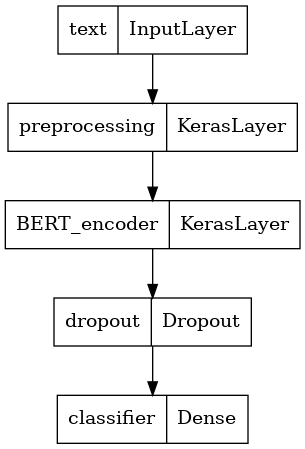

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 56:25 - loss: 0.6081 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:17 - loss: 0.6956 - binary_accuracy: 0.5625 

  3/625 [..............................] - ETA: 1:16 - loss: 0.7397 - binary_accuracy: 0.5312

  4/625 [..............................] - ETA: 1:14 - loss: 0.7340 - binary_accuracy: 0.5547

  5/625 [..............................] - ETA: 1:13 - loss: 0.7298 - binary_accuracy: 0.5562

  6/625 [..............................] - ETA: 1:13 - loss: 0.7300 - binary_accuracy: 0.5625

  7/625 [..............................] - ETA: 1:13 - loss: 0.7281 - binary_accuracy: 0.5714

  8/625 [..............................] - ETA: 1:12 - loss: 0.7121 - binary_accuracy: 0.5820

  9/625 [..............................] - ETA: 1:12 - loss: 0.7149 - binary_accuracy: 0.5729

 10/625 [..............................] - ETA: 1:12 - loss: 0.7203 - binary_accuracy: 0.5562

 11/625 [..............................] - ETA: 1:11 - loss: 0.7239 - binary_accuracy: 0.5426

 12/625 [..............................] - ETA: 1:11 - loss: 0.7322 - binary_accuracy: 0.5260

 13/625 [..............................] - ETA: 1:11 - loss: 0.7400 - binary_accuracy: 0.5192

 14/625 [..............................] - ETA: 1:11 - loss: 0.7351 - binary_accuracy: 0.5223

 15/625 [..............................] - ETA: 1:10 - loss: 0.7331 - binary_accuracy: 0.5271

 16/625 [..............................] - ETA: 1:10 - loss: 0.7263 - binary_accuracy: 0.5391

 17/625 [..............................] - ETA: 1:10 - loss: 0.7286 - binary_accuracy: 0.5312

 18/625 [..............................] - ETA: 1:10 - loss: 0.7248 - binary_accuracy: 0.5312

 19/625 [..............................] - ETA: 1:10 - loss: 0.7273 - binary_accuracy: 0.5280

 20/625 [..............................] - ETA: 1:10 - loss: 0.7242 - binary_accuracy: 0.5312

 21/625 [>.............................] - ETA: 1:10 - loss: 0.7233 - binary_accuracy: 0.5357

 22/625 [>.............................] - ETA: 1:09 - loss: 0.7265 - binary_accuracy: 0.5298

 23/625 [>.............................] - ETA: 1:09 - loss: 0.7255 - binary_accuracy: 0.5272

 24/625 [>.............................] - ETA: 1:09 - loss: 0.7223 - binary_accuracy: 0.5352

 25/625 [>.............................] - ETA: 1:09 - loss: 0.7221 - binary_accuracy: 0.5288

 26/625 [>.............................] - ETA: 1:09 - loss: 0.7220 - binary_accuracy: 0.5288

 27/625 [>.............................] - ETA: 1:09 - loss: 0.7238 - binary_accuracy: 0.5220

 28/625 [>.............................] - ETA: 1:09 - loss: 0.7228 - binary_accuracy: 0.5234

 29/625 [>.............................] - ETA: 1:09 - loss: 0.7211 - binary_accuracy: 0.5226

 30/625 [>.............................] - ETA: 1:09 - loss: 0.7226 - binary_accuracy: 0.5177

 31/625 [>.............................] - ETA: 1:09 - loss: 0.7224 - binary_accuracy: 0.5192

 32/625 [>.............................] - ETA: 1:09 - loss: 0.7207 - binary_accuracy: 0.5225

 33/625 [>.............................] - ETA: 1:09 - loss: 0.7167 - binary_accuracy: 0.5275

 34/625 [>.............................] - ETA: 1:08 - loss: 0.7187 - binary_accuracy: 0.5230

 35/625 [>.............................] - ETA: 1:08 - loss: 0.7185 - binary_accuracy: 0.5250

 36/625 [>.............................] - ETA: 1:08 - loss: 0.7191 - binary_accuracy: 0.5226

 37/625 [>.............................] - ETA: 1:08 - loss: 0.7186 - binary_accuracy: 0.5211

 38/625 [>.............................] - ETA: 1:08 - loss: 0.7178 - binary_accuracy: 0.5206

 39/625 [>.............................] - ETA: 1:08 - loss: 0.7180 - binary_accuracy: 0.5208

 40/625 [>.............................] - ETA: 1:08 - loss: 0.7163 - binary_accuracy: 0.5203

 41/625 [>.............................] - ETA: 1:08 - loss: 0.7136 - binary_accuracy: 0.5267

 42/625 [=>............................] - ETA: 1:07 - loss: 0.7144 - binary_accuracy: 0.5283

 43/625 [=>............................] - ETA: 1:07 - loss: 0.7133 - binary_accuracy: 0.5305

 44/625 [=>............................] - ETA: 1:07 - loss: 0.7119 - binary_accuracy: 0.5291

 45/625 [=>............................] - ETA: 1:07 - loss: 0.7133 - binary_accuracy: 0.5285

 46/625 [=>............................] - ETA: 1:07 - loss: 0.7121 - binary_accuracy: 0.5326

 47/625 [=>............................] - ETA: 1:07 - loss: 0.7115 - binary_accuracy: 0.5346

 48/625 [=>............................] - ETA: 1:07 - loss: 0.7111 - binary_accuracy: 0.5358

 49/625 [=>............................] - ETA: 1:07 - loss: 0.7107 - binary_accuracy: 0.5370

 50/625 [=>............................] - ETA: 1:06 - loss: 0.7082 - binary_accuracy: 0.5412

 51/625 [=>............................] - ETA: 1:06 - loss: 0.7099 - binary_accuracy: 0.5392

 52/625 [=>............................] - ETA: 1:06 - loss: 0.7095 - binary_accuracy: 0.5385

 53/625 [=>............................] - ETA: 1:06 - loss: 0.7087 - binary_accuracy: 0.5371

 54/625 [=>............................] - ETA: 1:06 - loss: 0.7086 - binary_accuracy: 0.5382

 55/625 [=>............................] - ETA: 1:06 - loss: 0.7083 - binary_accuracy: 0.5381

 56/625 [=>............................] - ETA: 1:06 - loss: 0.7066 - binary_accuracy: 0.5385

 57/625 [=>............................] - ETA: 1:06 - loss: 0.7053 - binary_accuracy: 0.5384

 58/625 [=>............................] - ETA: 1:05 - loss: 0.7057 - binary_accuracy: 0.5377

 59/625 [=>............................] - ETA: 1:05 - loss: 0.7044 - binary_accuracy: 0.5403

 60/625 [=>............................] - ETA: 1:05 - loss: 0.7048 - binary_accuracy: 0.5411

 61/625 [=>............................] - ETA: 1:05 - loss: 0.7028 - binary_accuracy: 0.5435

 62/625 [=>............................] - ETA: 1:05 - loss: 0.7018 - binary_accuracy: 0.5454

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.7014 - binary_accuracy: 0.5456

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.7002 - binary_accuracy: 0.5459

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.6997 - binary_accuracy: 0.5466

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.6997 - binary_accuracy: 0.5469

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.6986 - binary_accuracy: 0.5480

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.6982 - binary_accuracy: 0.5506

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.6969 - binary_accuracy: 0.5516

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.6963 - binary_accuracy: 0.5513

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.6949 - binary_accuracy: 0.5537

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.6947 - binary_accuracy: 0.5534

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.6947 - binary_accuracy: 0.5539

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.6939 - binary_accuracy: 0.5536

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.6925 - binary_accuracy: 0.5525

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.6915 - binary_accuracy: 0.5526

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.6900 - binary_accuracy: 0.5536

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.6894 - binary_accuracy: 0.5533

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.6885 - binary_accuracy: 0.5550

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.6874 - binary_accuracy: 0.5559

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.6857 - binary_accuracy: 0.5579

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.6864 - binary_accuracy: 0.5568

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.6860 - binary_accuracy: 0.5580

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.6839 - binary_accuracy: 0.5595

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.6842 - binary_accuracy: 0.5607

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.6834 - binary_accuracy: 0.5629

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.6814 - binary_accuracy: 0.5639

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.6807 - binary_accuracy: 0.5636

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.6805 - binary_accuracy: 0.5639

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.6793 - binary_accuracy: 0.5642

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.6787 - binary_accuracy: 0.5656

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.6780 - binary_accuracy: 0.5679

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.6770 - binary_accuracy: 0.5682

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.6762 - binary_accuracy: 0.5698

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.6768 - binary_accuracy: 0.5697

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.6759 - binary_accuracy: 0.5716

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.6749 - binary_accuracy: 0.5725

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.6742 - binary_accuracy: 0.5733

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.6745 - binary_accuracy: 0.5735

100/625 [===>..........................] - ETA: 1:00 - loss: 0.6736 - binary_accuracy: 0.5744

101/625 [===>..........................] - ETA: 1:00 - loss: 0.6729 - binary_accuracy: 0.5752

102/625 [===>..........................] - ETA: 1:00 - loss: 0.6723 - binary_accuracy: 0.5757

103/625 [===>..........................] - ETA: 1:00 - loss: 0.6710 - binary_accuracy: 0.5765

104/625 [===>..........................] - ETA: 1:00 - loss: 0.6703 - binary_accuracy: 0.5778

105/625 [====>.........................] - ETA: 1:00 - loss: 0.6691 - binary_accuracy: 0.5795

106/625 [====>.........................] - ETA: 59s - loss: 0.6679 - binary_accuracy: 0.5805 

107/625 [====>.........................] - ETA: 59s - loss: 0.6675 - binary_accuracy: 0.5806

108/625 [====>.........................] - ETA: 59s - loss: 0.6664 - binary_accuracy: 0.5813

109/625 [====>.........................] - ETA: 59s - loss: 0.6668 - binary_accuracy: 0.5808

110/625 [====>.........................] - ETA: 59s - loss: 0.6664 - binary_accuracy: 0.5813

111/625 [====>.........................] - ETA: 59s - loss: 0.6649 - binary_accuracy: 0.5831

112/625 [====>.........................] - ETA: 59s - loss: 0.6635 - binary_accuracy: 0.5843

113/625 [====>.........................] - ETA: 59s - loss: 0.6632 - binary_accuracy: 0.5846

114/625 [====>.........................] - ETA: 59s - loss: 0.6626 - binary_accuracy: 0.5866

115/625 [====>.........................] - ETA: 58s - loss: 0.6617 - binary_accuracy: 0.5878

116/625 [====>.........................] - ETA: 58s - loss: 0.6612 - binary_accuracy: 0.5873

117/625 [====>.........................] - ETA: 58s - loss: 0.6609 - binary_accuracy: 0.5865

118/625 [====>.........................] - ETA: 58s - loss: 0.6601 - binary_accuracy: 0.5871

119/625 [====>.........................] - ETA: 58s - loss: 0.6584 - binary_accuracy: 0.5885

120/625 [====>.........................] - ETA: 58s - loss: 0.6574 - binary_accuracy: 0.5906

121/625 [====>.........................] - ETA: 58s - loss: 0.6562 - binary_accuracy: 0.5919

122/625 [====>.........................] - ETA: 58s - loss: 0.6546 - binary_accuracy: 0.5940

123/625 [====>.........................] - ETA: 58s - loss: 0.6543 - binary_accuracy: 0.5948

124/625 [====>.........................] - ETA: 57s - loss: 0.6531 - binary_accuracy: 0.5965

125/625 [=====>........................] - ETA: 57s - loss: 0.6527 - binary_accuracy: 0.5970

126/625 [=====>........................] - ETA: 57s - loss: 0.6516 - binary_accuracy: 0.5985

127/625 [=====>........................] - ETA: 57s - loss: 0.6499 - binary_accuracy: 0.6001

128/625 [=====>........................] - ETA: 57s - loss: 0.6486 - binary_accuracy: 0.6018

129/625 [=====>........................] - ETA: 57s - loss: 0.6484 - binary_accuracy: 0.6030

130/625 [=====>........................] - ETA: 57s - loss: 0.6486 - binary_accuracy: 0.6026

131/625 [=====>........................] - ETA: 57s - loss: 0.6478 - binary_accuracy: 0.6042

132/625 [=====>........................] - ETA: 57s - loss: 0.6464 - binary_accuracy: 0.6054

133/625 [=====>........................] - ETA: 56s - loss: 0.6449 - binary_accuracy: 0.6067

134/625 [=====>........................] - ETA: 56s - loss: 0.6446 - binary_accuracy: 0.6070

135/625 [=====>........................] - ETA: 56s - loss: 0.6439 - binary_accuracy: 0.6074

136/625 [=====>........................] - ETA: 56s - loss: 0.6426 - binary_accuracy: 0.6082

137/625 [=====>........................] - ETA: 56s - loss: 0.6410 - binary_accuracy: 0.6097

138/625 [=====>........................] - ETA: 56s - loss: 0.6402 - binary_accuracy: 0.6101

139/625 [=====>........................] - ETA: 56s - loss: 0.6388 - binary_accuracy: 0.6113

140/625 [=====>........................] - ETA: 56s - loss: 0.6387 - binary_accuracy: 0.6116

141/625 [=====>........................] - ETA: 55s - loss: 0.6380 - binary_accuracy: 0.6119

142/625 [=====>........................] - ETA: 55s - loss: 0.6367 - binary_accuracy: 0.6138

143/625 [=====>........................] - ETA: 55s - loss: 0.6370 - binary_accuracy: 0.6139

144/625 [=====>........................] - ETA: 55s - loss: 0.6369 - binary_accuracy: 0.6139

145/625 [=====>........................] - ETA: 55s - loss: 0.6359 - binary_accuracy: 0.6151

146/625 [======>.......................] - ETA: 55s - loss: 0.6351 - binary_accuracy: 0.6162

147/625 [======>.......................] - ETA: 55s - loss: 0.6343 - binary_accuracy: 0.6171

148/625 [======>.......................] - ETA: 55s - loss: 0.6335 - binary_accuracy: 0.6180

149/625 [======>.......................] - ETA: 55s - loss: 0.6322 - binary_accuracy: 0.6198

150/625 [======>.......................] - ETA: 54s - loss: 0.6327 - binary_accuracy: 0.6190

151/625 [======>.......................] - ETA: 54s - loss: 0.6316 - binary_accuracy: 0.6200

152/625 [======>.......................] - ETA: 54s - loss: 0.6310 - binary_accuracy: 0.6211

153/625 [======>.......................] - ETA: 54s - loss: 0.6306 - binary_accuracy: 0.6207

154/625 [======>.......................] - ETA: 54s - loss: 0.6308 - binary_accuracy: 0.6199

155/625 [======>.......................] - ETA: 54s - loss: 0.6302 - binary_accuracy: 0.6200

156/625 [======>.......................] - ETA: 54s - loss: 0.6292 - binary_accuracy: 0.6208

157/625 [======>.......................] - ETA: 54s - loss: 0.6297 - binary_accuracy: 0.6204

158/625 [======>.......................] - ETA: 54s - loss: 0.6292 - binary_accuracy: 0.6216

159/625 [======>.......................] - ETA: 53s - loss: 0.6282 - binary_accuracy: 0.6228

160/625 [======>.......................] - ETA: 53s - loss: 0.6272 - binary_accuracy: 0.6236

161/625 [======>.......................] - ETA: 53s - loss: 0.6259 - binary_accuracy: 0.6252

162/625 [======>.......................] - ETA: 53s - loss: 0.6248 - binary_accuracy: 0.6264

163/625 [======>.......................] - ETA: 53s - loss: 0.6235 - binary_accuracy: 0.6275

164/625 [======>.......................] - ETA: 53s - loss: 0.6235 - binary_accuracy: 0.6277

165/625 [======>.......................] - ETA: 53s - loss: 0.6224 - binary_accuracy: 0.6292

166/625 [======>.......................] - ETA: 53s - loss: 0.6224 - binary_accuracy: 0.6295

167/625 [=======>......................] - ETA: 52s - loss: 0.6217 - binary_accuracy: 0.6299

168/625 [=======>......................] - ETA: 52s - loss: 0.6208 - binary_accuracy: 0.6302

169/625 [=======>......................] - ETA: 52s - loss: 0.6195 - binary_accuracy: 0.6307

170/625 [=======>......................] - ETA: 52s - loss: 0.6189 - binary_accuracy: 0.6313

171/625 [=======>......................] - ETA: 52s - loss: 0.6188 - binary_accuracy: 0.6316

172/625 [=======>......................] - ETA: 52s - loss: 0.6170 - binary_accuracy: 0.6330

173/625 [=======>......................] - ETA: 52s - loss: 0.6163 - binary_accuracy: 0.6337

174/625 [=======>......................] - ETA: 52s - loss: 0.6147 - binary_accuracy: 0.6349

175/625 [=======>......................] - ETA: 52s - loss: 0.6138 - binary_accuracy: 0.6363

176/625 [=======>......................] - ETA: 51s - loss: 0.6130 - binary_accuracy: 0.6371

177/625 [=======>......................] - ETA: 51s - loss: 0.6124 - binary_accuracy: 0.6379

178/625 [=======>......................] - ETA: 51s - loss: 0.6121 - binary_accuracy: 0.6385

179/625 [=======>......................] - ETA: 51s - loss: 0.6110 - binary_accuracy: 0.6393

180/625 [=======>......................] - ETA: 51s - loss: 0.6097 - binary_accuracy: 0.6405

181/625 [=======>......................] - ETA: 51s - loss: 0.6086 - binary_accuracy: 0.6411

182/625 [=======>......................] - ETA: 51s - loss: 0.6079 - binary_accuracy: 0.6420

183/625 [=======>......................] - ETA: 51s - loss: 0.6079 - binary_accuracy: 0.6424

184/625 [=======>......................] - ETA: 50s - loss: 0.6073 - binary_accuracy: 0.6430

185/625 [=======>......................] - ETA: 50s - loss: 0.6054 - binary_accuracy: 0.6444

186/625 [=======>......................] - ETA: 50s - loss: 0.6048 - binary_accuracy: 0.6450

187/625 [=======>......................] - ETA: 50s - loss: 0.6034 - binary_accuracy: 0.6459

188/625 [========>.....................] - ETA: 50s - loss: 0.6019 - binary_accuracy: 0.6474

189/625 [========>.....................] - ETA: 50s - loss: 0.6005 - binary_accuracy: 0.6483

190/625 [========>.....................] - ETA: 50s - loss: 0.6005 - binary_accuracy: 0.6485

191/625 [========>.....................] - ETA: 50s - loss: 0.5992 - binary_accuracy: 0.6495

192/625 [========>.....................] - ETA: 50s - loss: 0.5977 - binary_accuracy: 0.6506

193/625 [========>.....................] - ETA: 49s - loss: 0.5975 - binary_accuracy: 0.6504

194/625 [========>.....................] - ETA: 49s - loss: 0.5972 - binary_accuracy: 0.6508

195/625 [========>.....................] - ETA: 49s - loss: 0.5966 - binary_accuracy: 0.6514

196/625 [========>.....................] - ETA: 49s - loss: 0.5970 - binary_accuracy: 0.6511

197/625 [========>.....................] - ETA: 49s - loss: 0.5966 - binary_accuracy: 0.6523

198/625 [========>.....................] - ETA: 49s - loss: 0.5960 - binary_accuracy: 0.6529

199/625 [========>.....................] - ETA: 49s - loss: 0.5958 - binary_accuracy: 0.6530

200/625 [========>.....................] - ETA: 49s - loss: 0.5946 - binary_accuracy: 0.6539

201/625 [========>.....................] - ETA: 48s - loss: 0.5946 - binary_accuracy: 0.6544

202/625 [========>.....................] - ETA: 48s - loss: 0.5934 - binary_accuracy: 0.6552

203/625 [========>.....................] - ETA: 48s - loss: 0.5928 - binary_accuracy: 0.6553

204/625 [========>.....................] - ETA: 48s - loss: 0.5920 - binary_accuracy: 0.6561

205/625 [========>.....................] - ETA: 48s - loss: 0.5915 - binary_accuracy: 0.6564

206/625 [========>.....................] - ETA: 48s - loss: 0.5907 - binary_accuracy: 0.6570

207/625 [========>.....................] - ETA: 48s - loss: 0.5904 - binary_accuracy: 0.6576

208/625 [========>.....................] - ETA: 48s - loss: 0.5903 - binary_accuracy: 0.6576

209/625 [=========>....................] - ETA: 48s - loss: 0.5893 - binary_accuracy: 0.6586

210/625 [=========>....................] - ETA: 47s - loss: 0.5887 - binary_accuracy: 0.6594

211/625 [=========>....................] - ETA: 47s - loss: 0.5873 - binary_accuracy: 0.6604

212/625 [=========>....................] - ETA: 47s - loss: 0.5869 - binary_accuracy: 0.6611

213/625 [=========>....................] - ETA: 47s - loss: 0.5861 - binary_accuracy: 0.6617

214/625 [=========>....................] - ETA: 47s - loss: 0.5853 - binary_accuracy: 0.6625

215/625 [=========>....................] - ETA: 47s - loss: 0.5853 - binary_accuracy: 0.6624

216/625 [=========>....................] - ETA: 47s - loss: 0.5852 - binary_accuracy: 0.6625

217/625 [=========>....................] - ETA: 47s - loss: 0.5846 - binary_accuracy: 0.6632

218/625 [=========>....................] - ETA: 47s - loss: 0.5832 - binary_accuracy: 0.6641

219/625 [=========>....................] - ETA: 46s - loss: 0.5830 - binary_accuracy: 0.6647

220/625 [=========>....................] - ETA: 46s - loss: 0.5831 - binary_accuracy: 0.6646

221/625 [=========>....................] - ETA: 46s - loss: 0.5825 - binary_accuracy: 0.6652

222/625 [=========>....................] - ETA: 46s - loss: 0.5817 - binary_accuracy: 0.6658

223/625 [=========>....................] - ETA: 46s - loss: 0.5811 - binary_accuracy: 0.6666

224/625 [=========>....................] - ETA: 46s - loss: 0.5812 - binary_accuracy: 0.6669

225/625 [=========>....................] - ETA: 46s - loss: 0.5815 - binary_accuracy: 0.6671

226/625 [=========>....................] - ETA: 46s - loss: 0.5803 - binary_accuracy: 0.6679

227/625 [=========>....................] - ETA: 46s - loss: 0.5791 - binary_accuracy: 0.6686

228/625 [=========>....................] - ETA: 45s - loss: 0.5785 - binary_accuracy: 0.6693

229/625 [=========>....................] - ETA: 45s - loss: 0.5784 - binary_accuracy: 0.6695

230/625 [==========>...................] - ETA: 45s - loss: 0.5781 - binary_accuracy: 0.6696

231/625 [==========>...................] - ETA: 45s - loss: 0.5772 - binary_accuracy: 0.6702

232/625 [==========>...................] - ETA: 45s - loss: 0.5763 - binary_accuracy: 0.6709

233/625 [==========>...................] - ETA: 45s - loss: 0.5752 - binary_accuracy: 0.6718

234/625 [==========>...................] - ETA: 45s - loss: 0.5749 - binary_accuracy: 0.6723

235/625 [==========>...................] - ETA: 45s - loss: 0.5741 - binary_accuracy: 0.6727

236/625 [==========>...................] - ETA: 44s - loss: 0.5745 - binary_accuracy: 0.6725

237/625 [==========>...................] - ETA: 44s - loss: 0.5739 - binary_accuracy: 0.6730

238/625 [==========>...................] - ETA: 44s - loss: 0.5726 - binary_accuracy: 0.6742

239/625 [==========>...................] - ETA: 44s - loss: 0.5728 - binary_accuracy: 0.6743

240/625 [==========>...................] - ETA: 44s - loss: 0.5716 - binary_accuracy: 0.6754

241/625 [==========>...................] - ETA: 44s - loss: 0.5714 - binary_accuracy: 0.6758

242/625 [==========>...................] - ETA: 44s - loss: 0.5702 - binary_accuracy: 0.6767

243/625 [==========>...................] - ETA: 44s - loss: 0.5699 - binary_accuracy: 0.6768

244/625 [==========>...................] - ETA: 44s - loss: 0.5695 - binary_accuracy: 0.6770

245/625 [==========>...................] - ETA: 43s - loss: 0.5687 - binary_accuracy: 0.6777

246/625 [==========>...................] - ETA: 43s - loss: 0.5681 - binary_accuracy: 0.6782

247/625 [==========>...................] - ETA: 43s - loss: 0.5674 - binary_accuracy: 0.6785

248/625 [==========>...................] - ETA: 43s - loss: 0.5673 - binary_accuracy: 0.6788

249/625 [==========>...................] - ETA: 43s - loss: 0.5663 - binary_accuracy: 0.6795

250/625 [===========>..................] - ETA: 43s - loss: 0.5658 - binary_accuracy: 0.6799

251/625 [===========>..................] - ETA: 43s - loss: 0.5655 - binary_accuracy: 0.6803

252/625 [===========>..................] - ETA: 43s - loss: 0.5647 - binary_accuracy: 0.6809

253/625 [===========>..................] - ETA: 43s - loss: 0.5643 - binary_accuracy: 0.6813

254/625 [===========>..................] - ETA: 42s - loss: 0.5639 - binary_accuracy: 0.6818

255/625 [===========>..................] - ETA: 42s - loss: 0.5634 - binary_accuracy: 0.6821

256/625 [===========>..................] - ETA: 42s - loss: 0.5639 - binary_accuracy: 0.6821

257/625 [===========>..................] - ETA: 42s - loss: 0.5635 - binary_accuracy: 0.6828

258/625 [===========>..................] - ETA: 42s - loss: 0.5628 - binary_accuracy: 0.6835

259/625 [===========>..................] - ETA: 42s - loss: 0.5624 - binary_accuracy: 0.6839

260/625 [===========>..................] - ETA: 42s - loss: 0.5621 - binary_accuracy: 0.6841

261/625 [===========>..................] - ETA: 42s - loss: 0.5612 - binary_accuracy: 0.6849

262/625 [===========>..................] - ETA: 41s - loss: 0.5604 - binary_accuracy: 0.6854

263/625 [===========>..................] - ETA: 41s - loss: 0.5610 - binary_accuracy: 0.6851

264/625 [===========>..................] - ETA: 41s - loss: 0.5607 - binary_accuracy: 0.6855

265/625 [===========>..................] - ETA: 41s - loss: 0.5596 - binary_accuracy: 0.6861

266/625 [===========>..................] - ETA: 41s - loss: 0.5588 - binary_accuracy: 0.6867

267/625 [===========>..................] - ETA: 41s - loss: 0.5585 - binary_accuracy: 0.6870

268/625 [===========>..................] - ETA: 41s - loss: 0.5583 - binary_accuracy: 0.6874

269/625 [===========>..................] - ETA: 41s - loss: 0.5584 - binary_accuracy: 0.6878

270/625 [===========>..................] - ETA: 41s - loss: 0.5583 - binary_accuracy: 0.6881

271/625 [============>.................] - ETA: 40s - loss: 0.5578 - binary_accuracy: 0.6884

272/625 [============>.................] - ETA: 40s - loss: 0.5572 - binary_accuracy: 0.6891

273/625 [============>.................] - ETA: 40s - loss: 0.5575 - binary_accuracy: 0.6889

274/625 [============>.................] - ETA: 40s - loss: 0.5574 - binary_accuracy: 0.6889

275/625 [============>.................] - ETA: 40s - loss: 0.5568 - binary_accuracy: 0.6893

276/625 [============>.................] - ETA: 40s - loss: 0.5563 - binary_accuracy: 0.6899

277/625 [============>.................] - ETA: 40s - loss: 0.5554 - binary_accuracy: 0.6903

278/625 [============>.................] - ETA: 40s - loss: 0.5548 - binary_accuracy: 0.6909

279/625 [============>.................] - ETA: 40s - loss: 0.5545 - binary_accuracy: 0.6907

280/625 [============>.................] - ETA: 39s - loss: 0.5541 - binary_accuracy: 0.6913

281/625 [============>.................] - ETA: 39s - loss: 0.5536 - binary_accuracy: 0.6918

282/625 [============>.................] - ETA: 39s - loss: 0.5536 - binary_accuracy: 0.6918

283/625 [============>.................] - ETA: 39s - loss: 0.5533 - binary_accuracy: 0.6920

284/625 [============>.................] - ETA: 39s - loss: 0.5525 - binary_accuracy: 0.6927

285/625 [============>.................] - ETA: 39s - loss: 0.5524 - binary_accuracy: 0.6929

286/625 [============>.................] - ETA: 39s - loss: 0.5527 - binary_accuracy: 0.6929

287/625 [============>.................] - ETA: 39s - loss: 0.5527 - binary_accuracy: 0.6933

288/625 [============>.................] - ETA: 38s - loss: 0.5532 - binary_accuracy: 0.6930

289/625 [============>.................] - ETA: 38s - loss: 0.5527 - binary_accuracy: 0.6936

290/625 [============>.................] - ETA: 38s - loss: 0.5522 - binary_accuracy: 0.6942

291/625 [============>.................] - ETA: 38s - loss: 0.5519 - binary_accuracy: 0.6945

292/625 [=============>................] - ETA: 38s - loss: 0.5515 - binary_accuracy: 0.6947

293/625 [=============>................] - ETA: 38s - loss: 0.5516 - binary_accuracy: 0.6948

294/625 [=============>................] - ETA: 38s - loss: 0.5512 - binary_accuracy: 0.6952

295/625 [=============>................] - ETA: 38s - loss: 0.5511 - binary_accuracy: 0.6953

296/625 [=============>................] - ETA: 38s - loss: 0.5507 - binary_accuracy: 0.6958

297/625 [=============>................] - ETA: 37s - loss: 0.5499 - binary_accuracy: 0.6964

298/625 [=============>................] - ETA: 37s - loss: 0.5496 - binary_accuracy: 0.6968

299/625 [=============>................] - ETA: 37s - loss: 0.5495 - binary_accuracy: 0.6969

300/625 [=============>................] - ETA: 37s - loss: 0.5491 - binary_accuracy: 0.6973

301/625 [=============>................] - ETA: 37s - loss: 0.5487 - binary_accuracy: 0.6978

302/625 [=============>................] - ETA: 37s - loss: 0.5485 - binary_accuracy: 0.6981

303/625 [=============>................] - ETA: 37s - loss: 0.5485 - binary_accuracy: 0.6981

304/625 [=============>................] - ETA: 37s - loss: 0.5478 - binary_accuracy: 0.6984

305/625 [=============>................] - ETA: 36s - loss: 0.5476 - binary_accuracy: 0.6985

306/625 [=============>................] - ETA: 36s - loss: 0.5479 - binary_accuracy: 0.6983

307/625 [=============>................] - ETA: 36s - loss: 0.5474 - binary_accuracy: 0.6986

308/625 [=============>................] - ETA: 36s - loss: 0.5475 - binary_accuracy: 0.6986

309/625 [=============>................] - ETA: 36s - loss: 0.5474 - binary_accuracy: 0.6987

310/625 [=============>................] - ETA: 36s - loss: 0.5468 - binary_accuracy: 0.6992

311/625 [=============>................] - ETA: 36s - loss: 0.5466 - binary_accuracy: 0.6998

312/625 [=============>................] - ETA: 36s - loss: 0.5462 - binary_accuracy: 0.6999

313/625 [==============>...............] - ETA: 36s - loss: 0.5456 - binary_accuracy: 0.7003

314/625 [==============>...............] - ETA: 35s - loss: 0.5449 - binary_accuracy: 0.7009

315/625 [==============>...............] - ETA: 35s - loss: 0.5441 - binary_accuracy: 0.7015

316/625 [==============>...............] - ETA: 35s - loss: 0.5438 - binary_accuracy: 0.7017

317/625 [==============>...............] - ETA: 35s - loss: 0.5432 - binary_accuracy: 0.7021

318/625 [==============>...............] - ETA: 35s - loss: 0.5426 - binary_accuracy: 0.7024

319/625 [==============>...............] - ETA: 35s - loss: 0.5421 - binary_accuracy: 0.7031

320/625 [==============>...............] - ETA: 35s - loss: 0.5419 - binary_accuracy: 0.7031

321/625 [==============>...............] - ETA: 35s - loss: 0.5417 - binary_accuracy: 0.7035

322/625 [==============>...............] - ETA: 35s - loss: 0.5422 - binary_accuracy: 0.7036

323/625 [==============>...............] - ETA: 34s - loss: 0.5414 - binary_accuracy: 0.7042

324/625 [==============>...............] - ETA: 34s - loss: 0.5408 - binary_accuracy: 0.7048

325/625 [==============>...............] - ETA: 34s - loss: 0.5408 - binary_accuracy: 0.7048

326/625 [==============>...............] - ETA: 34s - loss: 0.5405 - binary_accuracy: 0.7050

327/625 [==============>...............] - ETA: 34s - loss: 0.5399 - binary_accuracy: 0.7056

328/625 [==============>...............] - ETA: 34s - loss: 0.5396 - binary_accuracy: 0.7058

329/625 [==============>...............] - ETA: 34s - loss: 0.5395 - binary_accuracy: 0.7060

330/625 [==============>...............] - ETA: 34s - loss: 0.5388 - binary_accuracy: 0.7064

331/625 [==============>...............] - ETA: 33s - loss: 0.5385 - binary_accuracy: 0.7065

332/625 [==============>...............] - ETA: 33s - loss: 0.5384 - binary_accuracy: 0.7063

333/625 [==============>...............] - ETA: 33s - loss: 0.5392 - binary_accuracy: 0.7059

334/625 [===============>..............] - ETA: 33s - loss: 0.5393 - binary_accuracy: 0.7057

335/625 [===============>..............] - ETA: 33s - loss: 0.5391 - binary_accuracy: 0.7059

336/625 [===============>..............] - ETA: 33s - loss: 0.5391 - binary_accuracy: 0.7059

337/625 [===============>..............] - ETA: 33s - loss: 0.5388 - binary_accuracy: 0.7061

338/625 [===============>..............] - ETA: 33s - loss: 0.5390 - binary_accuracy: 0.7064

339/625 [===============>..............] - ETA: 33s - loss: 0.5387 - binary_accuracy: 0.7066

340/625 [===============>..............] - ETA: 32s - loss: 0.5385 - binary_accuracy: 0.7070

341/625 [===============>..............] - ETA: 32s - loss: 0.5387 - binary_accuracy: 0.7071

342/625 [===============>..............] - ETA: 32s - loss: 0.5383 - binary_accuracy: 0.7075

343/625 [===============>..............] - ETA: 32s - loss: 0.5382 - binary_accuracy: 0.7076

344/625 [===============>..............] - ETA: 32s - loss: 0.5375 - binary_accuracy: 0.7081

345/625 [===============>..............] - ETA: 32s - loss: 0.5374 - binary_accuracy: 0.7081

346/625 [===============>..............] - ETA: 32s - loss: 0.5379 - binary_accuracy: 0.7079

347/625 [===============>..............] - ETA: 32s - loss: 0.5376 - binary_accuracy: 0.7081

348/625 [===============>..............] - ETA: 32s - loss: 0.5373 - binary_accuracy: 0.7084

349/625 [===============>..............] - ETA: 31s - loss: 0.5371 - binary_accuracy: 0.7086

350/625 [===============>..............] - ETA: 31s - loss: 0.5368 - binary_accuracy: 0.7089

351/625 [===============>..............] - ETA: 31s - loss: 0.5364 - binary_accuracy: 0.7095

352/625 [===============>..............] - ETA: 31s - loss: 0.5363 - binary_accuracy: 0.7097

353/625 [===============>..............] - ETA: 31s - loss: 0.5365 - binary_accuracy: 0.7097

354/625 [===============>..............] - ETA: 31s - loss: 0.5358 - binary_accuracy: 0.7102

355/625 [================>.............] - ETA: 31s - loss: 0.5354 - binary_accuracy: 0.7105

356/625 [================>.............] - ETA: 31s - loss: 0.5349 - binary_accuracy: 0.7108

357/625 [================>.............] - ETA: 30s - loss: 0.5343 - binary_accuracy: 0.7109

358/625 [================>.............] - ETA: 30s - loss: 0.5336 - binary_accuracy: 0.7112

359/625 [================>.............] - ETA: 30s - loss: 0.5330 - binary_accuracy: 0.7117

360/625 [================>.............] - ETA: 30s - loss: 0.5326 - binary_accuracy: 0.7122

361/625 [================>.............] - ETA: 30s - loss: 0.5325 - binary_accuracy: 0.7122

362/625 [================>.............] - ETA: 30s - loss: 0.5322 - binary_accuracy: 0.7124

363/625 [================>.............] - ETA: 30s - loss: 0.5317 - binary_accuracy: 0.7125

364/625 [================>.............] - ETA: 30s - loss: 0.5316 - binary_accuracy: 0.7128

365/625 [================>.............] - ETA: 30s - loss: 0.5309 - binary_accuracy: 0.7134

366/625 [================>.............] - ETA: 29s - loss: 0.5302 - binary_accuracy: 0.7138

367/625 [================>.............] - ETA: 29s - loss: 0.5296 - binary_accuracy: 0.7142

368/625 [================>.............] - ETA: 29s - loss: 0.5293 - binary_accuracy: 0.7144

369/625 [================>.............] - ETA: 29s - loss: 0.5289 - binary_accuracy: 0.7147

370/625 [================>.............] - ETA: 29s - loss: 0.5287 - binary_accuracy: 0.7149

371/625 [================>.............] - ETA: 29s - loss: 0.5281 - binary_accuracy: 0.7153

372/625 [================>.............] - ETA: 29s - loss: 0.5277 - binary_accuracy: 0.7156

373/625 [================>.............] - ETA: 29s - loss: 0.5273 - binary_accuracy: 0.7159

374/625 [================>.............] - ETA: 28s - loss: 0.5273 - binary_accuracy: 0.7161

375/625 [=================>............] - ETA: 28s - loss: 0.5269 - binary_accuracy: 0.7164

376/625 [=================>............] - ETA: 28s - loss: 0.5266 - binary_accuracy: 0.7168

377/625 [=================>............] - ETA: 28s - loss: 0.5265 - binary_accuracy: 0.7168

378/625 [=================>............] - ETA: 28s - loss: 0.5261 - binary_accuracy: 0.7172

379/625 [=================>............] - ETA: 28s - loss: 0.5258 - binary_accuracy: 0.7174

380/625 [=================>............] - ETA: 28s - loss: 0.5258 - binary_accuracy: 0.7174

381/625 [=================>............] - ETA: 28s - loss: 0.5251 - binary_accuracy: 0.7177

382/625 [=================>............] - ETA: 28s - loss: 0.5246 - binary_accuracy: 0.7179

383/625 [=================>............] - ETA: 27s - loss: 0.5241 - binary_accuracy: 0.7183

384/625 [=================>............] - ETA: 27s - loss: 0.5241 - binary_accuracy: 0.7185

385/625 [=================>............] - ETA: 27s - loss: 0.5244 - binary_accuracy: 0.7186

386/625 [=================>............] - ETA: 27s - loss: 0.5242 - binary_accuracy: 0.7190

387/625 [=================>............] - ETA: 27s - loss: 0.5241 - binary_accuracy: 0.7193

388/625 [=================>............] - ETA: 27s - loss: 0.5238 - binary_accuracy: 0.7197

389/625 [=================>............] - ETA: 27s - loss: 0.5230 - binary_accuracy: 0.7204

390/625 [=================>............] - ETA: 27s - loss: 0.5225 - binary_accuracy: 0.7207

391/625 [=================>............] - ETA: 27s - loss: 0.5219 - binary_accuracy: 0.7211

392/625 [=================>............] - ETA: 26s - loss: 0.5219 - binary_accuracy: 0.7212

393/625 [=================>............] - ETA: 26s - loss: 0.5219 - binary_accuracy: 0.7212

394/625 [=================>............] - ETA: 26s - loss: 0.5212 - binary_accuracy: 0.7216

395/625 [=================>............] - ETA: 26s - loss: 0.5210 - binary_accuracy: 0.7216

396/625 [==================>...........] - ETA: 26s - loss: 0.5210 - binary_accuracy: 0.7217

397/625 [==================>...........] - ETA: 26s - loss: 0.5211 - binary_accuracy: 0.7215

398/625 [==================>...........] - ETA: 26s - loss: 0.5208 - binary_accuracy: 0.7217

399/625 [==================>...........] - ETA: 26s - loss: 0.5203 - binary_accuracy: 0.7220

400/625 [==================>...........] - ETA: 25s - loss: 0.5202 - binary_accuracy: 0.7223

401/625 [==================>...........] - ETA: 25s - loss: 0.5197 - binary_accuracy: 0.7226

402/625 [==================>...........] - ETA: 25s - loss: 0.5202 - binary_accuracy: 0.7226

403/625 [==================>...........] - ETA: 25s - loss: 0.5201 - binary_accuracy: 0.7229

404/625 [==================>...........] - ETA: 25s - loss: 0.5203 - binary_accuracy: 0.7227

405/625 [==================>...........] - ETA: 25s - loss: 0.5196 - binary_accuracy: 0.7231

406/625 [==================>...........] - ETA: 25s - loss: 0.5197 - binary_accuracy: 0.7231

407/625 [==================>...........] - ETA: 25s - loss: 0.5194 - binary_accuracy: 0.7233

408/625 [==================>...........] - ETA: 25s - loss: 0.5191 - binary_accuracy: 0.7236

409/625 [==================>...........] - ETA: 24s - loss: 0.5186 - binary_accuracy: 0.7240

410/625 [==================>...........] - ETA: 24s - loss: 0.5187 - binary_accuracy: 0.7241

411/625 [==================>...........] - ETA: 24s - loss: 0.5186 - binary_accuracy: 0.7241

412/625 [==================>...........] - ETA: 24s - loss: 0.5182 - binary_accuracy: 0.7241

413/625 [==================>...........] - ETA: 24s - loss: 0.5178 - binary_accuracy: 0.7243

414/625 [==================>...........] - ETA: 24s - loss: 0.5182 - binary_accuracy: 0.7241

415/625 [==================>...........] - ETA: 24s - loss: 0.5178 - binary_accuracy: 0.7243

416/625 [==================>...........] - ETA: 24s - loss: 0.5174 - binary_accuracy: 0.7245

417/625 [===================>..........] - ETA: 24s - loss: 0.5171 - binary_accuracy: 0.7245

418/625 [===================>..........] - ETA: 23s - loss: 0.5166 - binary_accuracy: 0.7249

419/625 [===================>..........] - ETA: 23s - loss: 0.5167 - binary_accuracy: 0.7249

420/625 [===================>..........] - ETA: 23s - loss: 0.5165 - binary_accuracy: 0.7252

421/625 [===================>..........] - ETA: 23s - loss: 0.5163 - binary_accuracy: 0.7254

422/625 [===================>..........] - ETA: 23s - loss: 0.5159 - binary_accuracy: 0.7257

423/625 [===================>..........] - ETA: 23s - loss: 0.5157 - binary_accuracy: 0.7258

424/625 [===================>..........] - ETA: 23s - loss: 0.5156 - binary_accuracy: 0.7260

425/625 [===================>..........] - ETA: 23s - loss: 0.5153 - binary_accuracy: 0.7262

426/625 [===================>..........] - ETA: 22s - loss: 0.5156 - binary_accuracy: 0.7260

427/625 [===================>..........] - ETA: 22s - loss: 0.5151 - binary_accuracy: 0.7264

428/625 [===================>..........] - ETA: 22s - loss: 0.5145 - binary_accuracy: 0.7268

429/625 [===================>..........] - ETA: 22s - loss: 0.5142 - binary_accuracy: 0.7269

430/625 [===================>..........] - ETA: 22s - loss: 0.5136 - binary_accuracy: 0.7273

431/625 [===================>..........] - ETA: 22s - loss: 0.5134 - binary_accuracy: 0.7274

432/625 [===================>..........] - ETA: 22s - loss: 0.5133 - binary_accuracy: 0.7274

433/625 [===================>..........] - ETA: 22s - loss: 0.5133 - binary_accuracy: 0.7275

434/625 [===================>..........] - ETA: 22s - loss: 0.5131 - binary_accuracy: 0.7278

435/625 [===================>..........] - ETA: 21s - loss: 0.5125 - binary_accuracy: 0.7281

436/625 [===================>..........] - ETA: 21s - loss: 0.5121 - binary_accuracy: 0.7284

437/625 [===================>..........] - ETA: 21s - loss: 0.5119 - binary_accuracy: 0.7286

438/625 [====================>.........] - ETA: 21s - loss: 0.5119 - binary_accuracy: 0.7286

439/625 [====================>.........] - ETA: 21s - loss: 0.5115 - binary_accuracy: 0.7289

440/625 [====================>.........] - ETA: 21s - loss: 0.5113 - binary_accuracy: 0.7290

441/625 [====================>.........] - ETA: 21s - loss: 0.5108 - binary_accuracy: 0.7292

442/625 [====================>.........] - ETA: 21s - loss: 0.5107 - binary_accuracy: 0.7291

443/625 [====================>.........] - ETA: 21s - loss: 0.5104 - binary_accuracy: 0.7292

444/625 [====================>.........] - ETA: 20s - loss: 0.5101 - binary_accuracy: 0.7294

445/625 [====================>.........] - ETA: 20s - loss: 0.5096 - binary_accuracy: 0.7297

446/625 [====================>.........] - ETA: 20s - loss: 0.5092 - binary_accuracy: 0.7299

447/625 [====================>.........] - ETA: 20s - loss: 0.5090 - binary_accuracy: 0.7299

448/625 [====================>.........] - ETA: 20s - loss: 0.5086 - binary_accuracy: 0.7301

449/625 [====================>.........] - ETA: 20s - loss: 0.5083 - binary_accuracy: 0.7304

450/625 [====================>.........] - ETA: 20s - loss: 0.5082 - binary_accuracy: 0.7306

451/625 [====================>.........] - ETA: 20s - loss: 0.5079 - binary_accuracy: 0.7307

452/625 [====================>.........] - ETA: 19s - loss: 0.5075 - binary_accuracy: 0.7311

453/625 [====================>.........] - ETA: 19s - loss: 0.5069 - binary_accuracy: 0.7314

454/625 [====================>.........] - ETA: 19s - loss: 0.5066 - binary_accuracy: 0.7317

455/625 [====================>.........] - ETA: 19s - loss: 0.5065 - binary_accuracy: 0.7317

456/625 [====================>.........] - ETA: 19s - loss: 0.5065 - binary_accuracy: 0.7318

457/625 [====================>.........] - ETA: 19s - loss: 0.5064 - binary_accuracy: 0.7318

458/625 [====================>.........] - ETA: 19s - loss: 0.5058 - binary_accuracy: 0.7322

459/625 [=====================>........] - ETA: 19s - loss: 0.5058 - binary_accuracy: 0.7323

460/625 [=====================>........] - ETA: 19s - loss: 0.5053 - binary_accuracy: 0.7325

461/625 [=====================>........] - ETA: 18s - loss: 0.5053 - binary_accuracy: 0.7326

462/625 [=====================>........] - ETA: 18s - loss: 0.5052 - binary_accuracy: 0.7328

463/625 [=====================>........] - ETA: 18s - loss: 0.5049 - binary_accuracy: 0.7331

464/625 [=====================>........] - ETA: 18s - loss: 0.5049 - binary_accuracy: 0.7333

465/625 [=====================>........] - ETA: 18s - loss: 0.5047 - binary_accuracy: 0.7335

466/625 [=====================>........] - ETA: 18s - loss: 0.5047 - binary_accuracy: 0.7334

467/625 [=====================>........] - ETA: 18s - loss: 0.5043 - binary_accuracy: 0.7337

468/625 [=====================>........] - ETA: 18s - loss: 0.5039 - binary_accuracy: 0.7338

469/625 [=====================>........] - ETA: 18s - loss: 0.5035 - binary_accuracy: 0.7341

470/625 [=====================>........] - ETA: 17s - loss: 0.5032 - binary_accuracy: 0.7344

471/625 [=====================>........] - ETA: 17s - loss: 0.5029 - binary_accuracy: 0.7345

472/625 [=====================>........] - ETA: 17s - loss: 0.5029 - binary_accuracy: 0.7346

473/625 [=====================>........] - ETA: 17s - loss: 0.5026 - binary_accuracy: 0.7349

474/625 [=====================>........] - ETA: 17s - loss: 0.5024 - binary_accuracy: 0.7352

475/625 [=====================>........] - ETA: 17s - loss: 0.5022 - binary_accuracy: 0.7353

476/625 [=====================>........] - ETA: 17s - loss: 0.5015 - binary_accuracy: 0.7357

477/625 [=====================>........] - ETA: 17s - loss: 0.5014 - binary_accuracy: 0.7356

478/625 [=====================>........] - ETA: 16s - loss: 0.5013 - binary_accuracy: 0.7356

479/625 [=====================>........] - ETA: 16s - loss: 0.5012 - binary_accuracy: 0.7357

480/625 [======================>.......] - ETA: 16s - loss: 0.5007 - binary_accuracy: 0.7360

481/625 [======================>.......] - ETA: 16s - loss: 0.5006 - binary_accuracy: 0.7362

482/625 [======================>.......] - ETA: 16s - loss: 0.5003 - binary_accuracy: 0.7363

483/625 [======================>.......] - ETA: 16s - loss: 0.5002 - binary_accuracy: 0.7361

484/625 [======================>.......] - ETA: 16s - loss: 0.4998 - binary_accuracy: 0.7363

485/625 [======================>.......] - ETA: 16s - loss: 0.4996 - binary_accuracy: 0.7364

486/625 [======================>.......] - ETA: 16s - loss: 0.4991 - binary_accuracy: 0.7366

487/625 [======================>.......] - ETA: 15s - loss: 0.4987 - binary_accuracy: 0.7368

488/625 [======================>.......] - ETA: 15s - loss: 0.4982 - binary_accuracy: 0.7371

489/625 [======================>.......] - ETA: 15s - loss: 0.4978 - binary_accuracy: 0.7375

490/625 [======================>.......] - ETA: 15s - loss: 0.4977 - binary_accuracy: 0.7378

491/625 [======================>.......] - ETA: 15s - loss: 0.4974 - binary_accuracy: 0.7378

492/625 [======================>.......] - ETA: 15s - loss: 0.4968 - binary_accuracy: 0.7382

493/625 [======================>.......] - ETA: 15s - loss: 0.4964 - binary_accuracy: 0.7386

494/625 [======================>.......] - ETA: 15s - loss: 0.4962 - binary_accuracy: 0.7388

495/625 [======================>.......] - ETA: 15s - loss: 0.4958 - binary_accuracy: 0.7391

496/625 [======================>.......] - ETA: 14s - loss: 0.4956 - binary_accuracy: 0.7392

497/625 [======================>.......] - ETA: 14s - loss: 0.4955 - binary_accuracy: 0.7394

498/625 [======================>.......] - ETA: 14s - loss: 0.4958 - binary_accuracy: 0.7391

499/625 [======================>.......] - ETA: 14s - loss: 0.4954 - binary_accuracy: 0.7392

500/625 [=======================>......] - ETA: 14s - loss: 0.4953 - binary_accuracy: 0.7393

501/625 [=======================>......] - ETA: 14s - loss: 0.4952 - binary_accuracy: 0.7394

502/625 [=======================>......] - ETA: 14s - loss: 0.4949 - binary_accuracy: 0.7395

503/625 [=======================>......] - ETA: 14s - loss: 0.4947 - binary_accuracy: 0.7397

504/625 [=======================>......] - ETA: 13s - loss: 0.4944 - binary_accuracy: 0.7401

505/625 [=======================>......] - ETA: 13s - loss: 0.4940 - binary_accuracy: 0.7405

506/625 [=======================>......] - ETA: 13s - loss: 0.4943 - binary_accuracy: 0.7404

507/625 [=======================>......] - ETA: 13s - loss: 0.4939 - binary_accuracy: 0.7408

508/625 [=======================>......] - ETA: 13s - loss: 0.4937 - binary_accuracy: 0.7410

509/625 [=======================>......] - ETA: 13s - loss: 0.4934 - binary_accuracy: 0.7412

510/625 [=======================>......] - ETA: 13s - loss: 0.4929 - binary_accuracy: 0.7415

511/625 [=======================>......] - ETA: 13s - loss: 0.4926 - binary_accuracy: 0.7417

512/625 [=======================>......] - ETA: 13s - loss: 0.4924 - binary_accuracy: 0.7419

513/625 [=======================>......] - ETA: 12s - loss: 0.4921 - binary_accuracy: 0.7420

514/625 [=======================>......] - ETA: 12s - loss: 0.4924 - binary_accuracy: 0.7418

515/625 [=======================>......] - ETA: 12s - loss: 0.4922 - binary_accuracy: 0.7419

516/625 [=======================>......] - ETA: 12s - loss: 0.4919 - binary_accuracy: 0.7421

517/625 [=======================>......] - ETA: 12s - loss: 0.4921 - binary_accuracy: 0.7421

518/625 [=======================>......] - ETA: 12s - loss: 0.4922 - binary_accuracy: 0.7422

519/625 [=======================>......] - ETA: 12s - loss: 0.4920 - binary_accuracy: 0.7423

520/625 [=======================>......] - ETA: 12s - loss: 0.4919 - binary_accuracy: 0.7423

521/625 [========================>.....] - ETA: 12s - loss: 0.4914 - binary_accuracy: 0.7427

522/625 [========================>.....] - ETA: 11s - loss: 0.4912 - binary_accuracy: 0.7428

523/625 [========================>.....] - ETA: 11s - loss: 0.4911 - binary_accuracy: 0.7428

524/625 [========================>.....] - ETA: 11s - loss: 0.4909 - binary_accuracy: 0.7428

525/625 [========================>.....] - ETA: 11s - loss: 0.4909 - binary_accuracy: 0.7430

526/625 [========================>.....] - ETA: 11s - loss: 0.4907 - binary_accuracy: 0.7433

527/625 [========================>.....] - ETA: 11s - loss: 0.4906 - binary_accuracy: 0.7434

528/625 [========================>.....] - ETA: 11s - loss: 0.4908 - binary_accuracy: 0.7435

529/625 [========================>.....] - ETA: 11s - loss: 0.4905 - binary_accuracy: 0.7437

530/625 [========================>.....] - ETA: 10s - loss: 0.4903 - binary_accuracy: 0.7437

531/625 [========================>.....] - ETA: 10s - loss: 0.4901 - binary_accuracy: 0.7438

532/625 [========================>.....] - ETA: 10s - loss: 0.4900 - binary_accuracy: 0.7437

533/625 [========================>.....] - ETA: 10s - loss: 0.4900 - binary_accuracy: 0.7438

534/625 [========================>.....] - ETA: 10s - loss: 0.4900 - binary_accuracy: 0.7439

535/625 [========================>.....] - ETA: 10s - loss: 0.4898 - binary_accuracy: 0.7441

536/625 [========================>.....] - ETA: 10s - loss: 0.4894 - binary_accuracy: 0.7444

537/625 [========================>.....] - ETA: 10s - loss: 0.4892 - binary_accuracy: 0.7446

538/625 [========================>.....] - ETA: 10s - loss: 0.4891 - binary_accuracy: 0.7448

539/625 [========================>.....] - ETA: 9s - loss: 0.4890 - binary_accuracy: 0.7447 

540/625 [========================>.....] - ETA: 9s - loss: 0.4890 - binary_accuracy: 0.7450

541/625 [========================>.....] - ETA: 9s - loss: 0.4889 - binary_accuracy: 0.7450

542/625 [=========================>....] - ETA: 9s - loss: 0.4888 - binary_accuracy: 0.7450

543/625 [=========================>....] - ETA: 9s - loss: 0.4888 - binary_accuracy: 0.7451

544/625 [=========================>....] - ETA: 9s - loss: 0.4889 - binary_accuracy: 0.7449

545/625 [=========================>....] - ETA: 9s - loss: 0.4887 - binary_accuracy: 0.7450

546/625 [=========================>....] - ETA: 9s - loss: 0.4885 - binary_accuracy: 0.7451

547/625 [=========================>....] - ETA: 9s - loss: 0.4885 - binary_accuracy: 0.7451

548/625 [=========================>....] - ETA: 8s - loss: 0.4885 - binary_accuracy: 0.7450

549/625 [=========================>....] - ETA: 8s - loss: 0.4882 - binary_accuracy: 0.7453

550/625 [=========================>....] - ETA: 8s - loss: 0.4881 - binary_accuracy: 0.7454

551/625 [=========================>....] - ETA: 8s - loss: 0.4880 - binary_accuracy: 0.7455

552/625 [=========================>....] - ETA: 8s - loss: 0.4880 - binary_accuracy: 0.7455

553/625 [=========================>....] - ETA: 8s - loss: 0.4879 - binary_accuracy: 0.7456

554/625 [=========================>....] - ETA: 8s - loss: 0.4876 - binary_accuracy: 0.7457

555/625 [=========================>....] - ETA: 8s - loss: 0.4873 - binary_accuracy: 0.7459

556/625 [=========================>....] - ETA: 7s - loss: 0.4872 - binary_accuracy: 0.7458

557/625 [=========================>....] - ETA: 7s - loss: 0.4869 - binary_accuracy: 0.7459

558/625 [=========================>....] - ETA: 7s - loss: 0.4871 - binary_accuracy: 0.7457

559/625 [=========================>....] - ETA: 7s - loss: 0.4868 - binary_accuracy: 0.7459

560/625 [=========================>....] - ETA: 7s - loss: 0.4866 - binary_accuracy: 0.7460

561/625 [=========================>....] - ETA: 7s - loss: 0.4865 - binary_accuracy: 0.7461

562/625 [=========================>....] - ETA: 7s - loss: 0.4863 - binary_accuracy: 0.7464

563/625 [==========================>...] - ETA: 7s - loss: 0.4861 - binary_accuracy: 0.7466

564/625 [==========================>...] - ETA: 7s - loss: 0.4858 - binary_accuracy: 0.7467

565/625 [==========================>...] - ETA: 6s - loss: 0.4860 - binary_accuracy: 0.7467

566/625 [==========================>...] - ETA: 6s - loss: 0.4857 - binary_accuracy: 0.7470

567/625 [==========================>...] - ETA: 6s - loss: 0.4858 - binary_accuracy: 0.7470

568/625 [==========================>...] - ETA: 6s - loss: 0.4856 - binary_accuracy: 0.7470

569/625 [==========================>...] - ETA: 6s - loss: 0.4853 - binary_accuracy: 0.7471

570/625 [==========================>...] - ETA: 6s - loss: 0.4852 - binary_accuracy: 0.7472

571/625 [==========================>...] - ETA: 6s - loss: 0.4854 - binary_accuracy: 0.7470

572/625 [==========================>...] - ETA: 6s - loss: 0.4851 - binary_accuracy: 0.7473

573/625 [==========================>...] - ETA: 6s - loss: 0.4847 - binary_accuracy: 0.7474

574/625 [==========================>...] - ETA: 5s - loss: 0.4846 - binary_accuracy: 0.7476

575/625 [==========================>...] - ETA: 5s - loss: 0.4848 - binary_accuracy: 0.7476

576/625 [==========================>...] - ETA: 5s - loss: 0.4851 - binary_accuracy: 0.7475

577/625 [==========================>...] - ETA: 5s - loss: 0.4852 - binary_accuracy: 0.7475

578/625 [==========================>...] - ETA: 5s - loss: 0.4851 - binary_accuracy: 0.7476

579/625 [==========================>...] - ETA: 5s - loss: 0.4852 - binary_accuracy: 0.7476

580/625 [==========================>...] - ETA: 5s - loss: 0.4849 - binary_accuracy: 0.7478

581/625 [==========================>...] - ETA: 5s - loss: 0.4847 - binary_accuracy: 0.7480

582/625 [==========================>...] - ETA: 4s - loss: 0.4848 - binary_accuracy: 0.7479

583/625 [==========================>...] - ETA: 4s - loss: 0.4848 - binary_accuracy: 0.7477

584/625 [===========================>..] - ETA: 4s - loss: 0.4846 - binary_accuracy: 0.7479

585/625 [===========================>..] - ETA: 4s - loss: 0.4843 - binary_accuracy: 0.7481

586/625 [===========================>..] - ETA: 4s - loss: 0.4843 - binary_accuracy: 0.7481

587/625 [===========================>..] - ETA: 4s - loss: 0.4843 - binary_accuracy: 0.7480

588/625 [===========================>..] - ETA: 4s - loss: 0.4838 - binary_accuracy: 0.7482

589/625 [===========================>..] - ETA: 4s - loss: 0.4835 - binary_accuracy: 0.7485

590/625 [===========================>..] - ETA: 4s - loss: 0.4832 - binary_accuracy: 0.7487

591/625 [===========================>..] - ETA: 3s - loss: 0.4830 - binary_accuracy: 0.7489

592/625 [===========================>..] - ETA: 3s - loss: 0.4829 - binary_accuracy: 0.7489

593/625 [===========================>..] - ETA: 3s - loss: 0.4827 - binary_accuracy: 0.7491

594/625 [===========================>..] - ETA: 3s - loss: 0.4827 - binary_accuracy: 0.7492

595/625 [===========================>..] - ETA: 3s - loss: 0.4823 - binary_accuracy: 0.7494

596/625 [===========================>..] - ETA: 3s - loss: 0.4822 - binary_accuracy: 0.7495

597/625 [===========================>..] - ETA: 3s - loss: 0.4821 - binary_accuracy: 0.7494

598/625 [===========================>..] - ETA: 3s - loss: 0.4820 - binary_accuracy: 0.7495

599/625 [===========================>..] - ETA: 3s - loss: 0.4821 - binary_accuracy: 0.7494

600/625 [===========================>..] - ETA: 2s - loss: 0.4820 - binary_accuracy: 0.7495

601/625 [===========================>..] - ETA: 2s - loss: 0.4816 - binary_accuracy: 0.7496

602/625 [===========================>..] - ETA: 2s - loss: 0.4815 - binary_accuracy: 0.7495

603/625 [===========================>..] - ETA: 2s - loss: 0.4811 - binary_accuracy: 0.7497

604/625 [===========================>..] - ETA: 2s - loss: 0.4811 - binary_accuracy: 0.7497

605/625 [============================>.] - ETA: 2s - loss: 0.4812 - binary_accuracy: 0.7497

606/625 [============================>.] - ETA: 2s - loss: 0.4813 - binary_accuracy: 0.7497

607/625 [============================>.] - ETA: 2s - loss: 0.4807 - binary_accuracy: 0.7501

608/625 [============================>.] - ETA: 1s - loss: 0.4808 - binary_accuracy: 0.7502

609/625 [============================>.] - ETA: 1s - loss: 0.4804 - binary_accuracy: 0.7504

610/625 [============================>.] - ETA: 1s - loss: 0.4801 - binary_accuracy: 0.7505

611/625 [============================>.] - ETA: 1s - loss: 0.4799 - binary_accuracy: 0.7505

612/625 [============================>.] - ETA: 1s - loss: 0.4797 - binary_accuracy: 0.7506

613/625 [============================>.] - ETA: 1s - loss: 0.4800 - binary_accuracy: 0.7506

614/625 [============================>.] - ETA: 1s - loss: 0.4797 - binary_accuracy: 0.7508

615/625 [============================>.] - ETA: 1s - loss: 0.4796 - binary_accuracy: 0.7508

616/625 [============================>.] - ETA: 1s - loss: 0.4793 - binary_accuracy: 0.7511

617/625 [============================>.] - ETA: 0s - loss: 0.4794 - binary_accuracy: 0.7511

618/625 [============================>.] - ETA: 0s - loss: 0.4792 - binary_accuracy: 0.7511

619/625 [============================>.] - ETA: 0s - loss: 0.4788 - binary_accuracy: 0.7513

620/625 [============================>.] - ETA: 0s - loss: 0.4788 - binary_accuracy: 0.7513

621/625 [============================>.] - ETA: 0s - loss: 0.4788 - binary_accuracy: 0.7514

622/625 [============================>.] - ETA: 0s - loss: 0.4786 - binary_accuracy: 0.7514

623/625 [============================>.] - ETA: 0s - loss: 0.4785 - binary_accuracy: 0.7516

624/625 [============================>.] - ETA: 0s - loss: 0.4784 - binary_accuracy: 0.7517

625/625 [==============================] - ETA: 0s - loss: 0.4781 - binary_accuracy: 0.7519

625/625 [==============================] - 89s 135ms/step - loss: 0.4781 - binary_accuracy: 0.7519 - val_loss: 0.3967 - val_binary_accuracy: 0.8338


Epoch 2/5
  1/625 [..............................] - ETA: 1:16 - loss: 0.6778 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:16 - loss: 0.5302 - binary_accuracy: 0.8125

  3/625 [..............................] - ETA: 1:15 - loss: 0.4802 - binary_accuracy: 0.8333

  4/625 [..............................] - ETA: 1:13 - loss: 0.4464 - binary_accuracy: 0.8359

  5/625 [..............................] - ETA: 1:12 - loss: 0.4269 - binary_accuracy: 0.8438

  6/625 [..............................] - ETA: 1:12 - loss: 0.4407 - binary_accuracy: 0.8281

  7/625 [..............................] - ETA: 1:12 - loss: 0.4203 - binary_accuracy: 0.8348

  8/625 [..............................] - ETA: 1:11 - loss: 0.4292 - binary_accuracy: 0.8203

  9/625 [..............................] - ETA: 1:11 - loss: 0.4480 - binary_accuracy: 0.8056

 10/625 [..............................] - ETA: 1:11 - loss: 0.4599 - binary_accuracy: 0.7937

 11/625 [..............................] - ETA: 1:11 - loss: 0.4537 - binary_accuracy: 0.7869

 12/625 [..............................] - ETA: 1:11 - loss: 0.4460 - binary_accuracy: 0.7917

 13/625 [..............................] - ETA: 1:10 - loss: 0.4423 - binary_accuracy: 0.7957

 14/625 [..............................] - ETA: 1:10 - loss: 0.4405 - binary_accuracy: 0.7924

 15/625 [..............................] - ETA: 1:10 - loss: 0.4321 - binary_accuracy: 0.7937

 16/625 [..............................] - ETA: 1:10 - loss: 0.4363 - binary_accuracy: 0.7910

 17/625 [..............................] - ETA: 1:10 - loss: 0.4287 - binary_accuracy: 0.7904

 18/625 [..............................] - ETA: 1:09 - loss: 0.4348 - binary_accuracy: 0.7899

 19/625 [..............................] - ETA: 1:09 - loss: 0.4461 - binary_accuracy: 0.7862

 20/625 [..............................] - ETA: 1:09 - loss: 0.4408 - binary_accuracy: 0.7891

 21/625 [>.............................] - ETA: 1:09 - loss: 0.4330 - binary_accuracy: 0.7932

 22/625 [>.............................] - ETA: 1:09 - loss: 0.4383 - binary_accuracy: 0.7912

 23/625 [>.............................] - ETA: 1:09 - loss: 0.4345 - binary_accuracy: 0.7935

 24/625 [>.............................] - ETA: 1:09 - loss: 0.4223 - binary_accuracy: 0.7982

 25/625 [>.............................] - ETA: 1:08 - loss: 0.4228 - binary_accuracy: 0.7950

 26/625 [>.............................] - ETA: 1:08 - loss: 0.4297 - binary_accuracy: 0.7933

 27/625 [>.............................] - ETA: 1:08 - loss: 0.4254 - binary_accuracy: 0.7963

 28/625 [>.............................] - ETA: 1:08 - loss: 0.4252 - binary_accuracy: 0.7969

 29/625 [>.............................] - ETA: 1:08 - loss: 0.4229 - binary_accuracy: 0.7974

 30/625 [>.............................] - ETA: 1:08 - loss: 0.4268 - binary_accuracy: 0.7969

 31/625 [>.............................] - ETA: 1:08 - loss: 0.4256 - binary_accuracy: 0.7974

 32/625 [>.............................] - ETA: 1:08 - loss: 0.4235 - binary_accuracy: 0.7998

 33/625 [>.............................] - ETA: 1:08 - loss: 0.4186 - binary_accuracy: 0.8040

 34/625 [>.............................] - ETA: 1:07 - loss: 0.4175 - binary_accuracy: 0.8061

 35/625 [>.............................] - ETA: 1:07 - loss: 0.4195 - binary_accuracy: 0.8045

 36/625 [>.............................] - ETA: 1:07 - loss: 0.4160 - binary_accuracy: 0.8056

 37/625 [>.............................] - ETA: 1:07 - loss: 0.4135 - binary_accuracy: 0.8057

 38/625 [>.............................] - ETA: 1:07 - loss: 0.4110 - binary_accuracy: 0.8059

 39/625 [>.............................] - ETA: 1:07 - loss: 0.4121 - binary_accuracy: 0.8053

 40/625 [>.............................] - ETA: 1:07 - loss: 0.4069 - binary_accuracy: 0.8078

 41/625 [>.............................] - ETA: 1:07 - loss: 0.4067 - binary_accuracy: 0.8087

 42/625 [=>............................] - ETA: 1:07 - loss: 0.4057 - binary_accuracy: 0.8088

 43/625 [=>............................] - ETA: 1:07 - loss: 0.4069 - binary_accuracy: 0.8074

 44/625 [=>............................] - ETA: 1:06 - loss: 0.4090 - binary_accuracy: 0.8061

 45/625 [=>............................] - ETA: 1:06 - loss: 0.4043 - binary_accuracy: 0.8097

 46/625 [=>............................] - ETA: 1:06 - loss: 0.4032 - binary_accuracy: 0.8098

 47/625 [=>............................] - ETA: 1:06 - loss: 0.4020 - binary_accuracy: 0.8098

 48/625 [=>............................] - ETA: 1:06 - loss: 0.4026 - binary_accuracy: 0.8092

 49/625 [=>............................] - ETA: 1:06 - loss: 0.4008 - binary_accuracy: 0.8093

 50/625 [=>............................] - ETA: 1:06 - loss: 0.4003 - binary_accuracy: 0.8106

 51/625 [=>............................] - ETA: 1:05 - loss: 0.4013 - binary_accuracy: 0.8107

 52/625 [=>............................] - ETA: 1:05 - loss: 0.4001 - binary_accuracy: 0.8113

 53/625 [=>............................] - ETA: 1:05 - loss: 0.4021 - binary_accuracy: 0.8090

 54/625 [=>............................] - ETA: 1:05 - loss: 0.3987 - binary_accuracy: 0.8108

 55/625 [=>............................] - ETA: 1:05 - loss: 0.3969 - binary_accuracy: 0.8119

 56/625 [=>............................] - ETA: 1:05 - loss: 0.4004 - binary_accuracy: 0.8103

 57/625 [=>............................] - ETA: 1:05 - loss: 0.3992 - binary_accuracy: 0.8109

 58/625 [=>............................] - ETA: 1:05 - loss: 0.3967 - binary_accuracy: 0.8114

 59/625 [=>............................] - ETA: 1:04 - loss: 0.3983 - binary_accuracy: 0.8093

 60/625 [=>............................] - ETA: 1:04 - loss: 0.4005 - binary_accuracy: 0.8078

 61/625 [=>............................] - ETA: 1:04 - loss: 0.3984 - binary_accuracy: 0.8094

 62/625 [=>............................] - ETA: 1:04 - loss: 0.3982 - binary_accuracy: 0.8095

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.3965 - binary_accuracy: 0.8090

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.3963 - binary_accuracy: 0.8091

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.3965 - binary_accuracy: 0.8096

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.3980 - binary_accuracy: 0.8101

 67/625 [==>...........................] - ETA: 1:03 - loss: 0.3981 - binary_accuracy: 0.8083

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.3978 - binary_accuracy: 0.8079

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.3979 - binary_accuracy: 0.8075

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.3981 - binary_accuracy: 0.8080

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.3986 - binary_accuracy: 0.8077

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.3973 - binary_accuracy: 0.8090

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.3985 - binary_accuracy: 0.8082

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.3977 - binary_accuracy: 0.8091

 75/625 [==>...........................] - ETA: 1:02 - loss: 0.3987 - binary_accuracy: 0.8092

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.3967 - binary_accuracy: 0.8109

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.3979 - binary_accuracy: 0.8105

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.3987 - binary_accuracy: 0.8109

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.3975 - binary_accuracy: 0.8117

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.3965 - binary_accuracy: 0.8129

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.3947 - binary_accuracy: 0.8144

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.3943 - binary_accuracy: 0.8140

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.3943 - binary_accuracy: 0.8144

 84/625 [===>..........................] - ETA: 1:01 - loss: 0.3942 - binary_accuracy: 0.8140

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.3933 - binary_accuracy: 0.8143

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.3921 - binary_accuracy: 0.8143

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.3921 - binary_accuracy: 0.8139

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.3942 - binary_accuracy: 0.8125

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.3951 - binary_accuracy: 0.8114

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.3984 - binary_accuracy: 0.8097

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.3998 - binary_accuracy: 0.8091

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.3979 - binary_accuracy: 0.8105

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.3969 - binary_accuracy: 0.8108

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.3964 - binary_accuracy: 0.8115

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.3992 - binary_accuracy: 0.8109

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.3994 - binary_accuracy: 0.8112

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.3988 - binary_accuracy: 0.8112

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.3977 - binary_accuracy: 0.8119

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.3983 - binary_accuracy: 0.8109

100/625 [===>..........................] - ETA: 1:00 - loss: 0.3980 - binary_accuracy: 0.8119

101/625 [===>..........................] - ETA: 1:00 - loss: 0.3984 - binary_accuracy: 0.8116

102/625 [===>..........................] - ETA: 59s - loss: 0.3987 - binary_accuracy: 0.8116 

103/625 [===>..........................] - ETA: 59s - loss: 0.3977 - binary_accuracy: 0.8119

104/625 [===>..........................] - ETA: 59s - loss: 0.3977 - binary_accuracy: 0.8119

105/625 [====>.........................] - ETA: 59s - loss: 0.3977 - binary_accuracy: 0.8116

106/625 [====>.........................] - ETA: 59s - loss: 0.3968 - binary_accuracy: 0.8122

107/625 [====>.........................] - ETA: 59s - loss: 0.3962 - binary_accuracy: 0.8125

108/625 [====>.........................] - ETA: 59s - loss: 0.3946 - binary_accuracy: 0.8134

109/625 [====>.........................] - ETA: 59s - loss: 0.3948 - binary_accuracy: 0.8131

110/625 [====>.........................] - ETA: 59s - loss: 0.3950 - binary_accuracy: 0.8122

111/625 [====>.........................] - ETA: 58s - loss: 0.3930 - binary_accuracy: 0.8133

112/625 [====>.........................] - ETA: 58s - loss: 0.3930 - binary_accuracy: 0.8133

113/625 [====>.........................] - ETA: 58s - loss: 0.3933 - binary_accuracy: 0.8131

114/625 [====>.........................] - ETA: 58s - loss: 0.3929 - binary_accuracy: 0.8141

115/625 [====>.........................] - ETA: 58s - loss: 0.3924 - binary_accuracy: 0.8147

116/625 [====>.........................] - ETA: 58s - loss: 0.3923 - binary_accuracy: 0.8152

117/625 [====>.........................] - ETA: 58s - loss: 0.3926 - binary_accuracy: 0.8149

118/625 [====>.........................] - ETA: 58s - loss: 0.3918 - binary_accuracy: 0.8151

119/625 [====>.........................] - ETA: 58s - loss: 0.3910 - binary_accuracy: 0.8157

120/625 [====>.........................] - ETA: 57s - loss: 0.3912 - binary_accuracy: 0.8159

121/625 [====>.........................] - ETA: 57s - loss: 0.3911 - binary_accuracy: 0.8161

122/625 [====>.........................] - ETA: 57s - loss: 0.3933 - binary_accuracy: 0.8145

123/625 [====>.........................] - ETA: 57s - loss: 0.3932 - binary_accuracy: 0.8143

124/625 [====>.........................] - ETA: 57s - loss: 0.3920 - binary_accuracy: 0.8148

125/625 [=====>........................] - ETA: 57s - loss: 0.3909 - binary_accuracy: 0.8152

126/625 [=====>........................] - ETA: 57s - loss: 0.3913 - binary_accuracy: 0.8140

127/625 [=====>........................] - ETA: 57s - loss: 0.3893 - binary_accuracy: 0.8152

128/625 [=====>........................] - ETA: 56s - loss: 0.3882 - binary_accuracy: 0.8162

129/625 [=====>........................] - ETA: 56s - loss: 0.3881 - binary_accuracy: 0.8169

130/625 [=====>........................] - ETA: 56s - loss: 0.3888 - binary_accuracy: 0.8166

131/625 [=====>........................] - ETA: 56s - loss: 0.3883 - binary_accuracy: 0.8170

132/625 [=====>........................] - ETA: 56s - loss: 0.3888 - binary_accuracy: 0.8165

133/625 [=====>........................] - ETA: 56s - loss: 0.3875 - binary_accuracy: 0.8174

134/625 [=====>........................] - ETA: 56s - loss: 0.3885 - binary_accuracy: 0.8174

135/625 [=====>........................] - ETA: 56s - loss: 0.3874 - binary_accuracy: 0.8178

136/625 [=====>........................] - ETA: 56s - loss: 0.3857 - binary_accuracy: 0.8192

137/625 [=====>........................] - ETA: 55s - loss: 0.3844 - binary_accuracy: 0.8203

138/625 [=====>........................] - ETA: 55s - loss: 0.3848 - binary_accuracy: 0.8197

139/625 [=====>........................] - ETA: 55s - loss: 0.3843 - binary_accuracy: 0.8199

140/625 [=====>........................] - ETA: 55s - loss: 0.3839 - binary_accuracy: 0.8203

141/625 [=====>........................] - ETA: 55s - loss: 0.3829 - binary_accuracy: 0.8209

142/625 [=====>........................] - ETA: 55s - loss: 0.3820 - binary_accuracy: 0.8213

143/625 [=====>........................] - ETA: 55s - loss: 0.3831 - binary_accuracy: 0.8210

144/625 [=====>........................] - ETA: 55s - loss: 0.3848 - binary_accuracy: 0.8205

145/625 [=====>........................] - ETA: 54s - loss: 0.3849 - binary_accuracy: 0.8205

146/625 [======>.......................] - ETA: 54s - loss: 0.3840 - binary_accuracy: 0.8208

147/625 [======>.......................] - ETA: 54s - loss: 0.3838 - binary_accuracy: 0.8214

148/625 [======>.......................] - ETA: 54s - loss: 0.3835 - binary_accuracy: 0.8216

149/625 [======>.......................] - ETA: 54s - loss: 0.3825 - binary_accuracy: 0.8221

150/625 [======>.......................] - ETA: 54s - loss: 0.3837 - binary_accuracy: 0.8215

151/625 [======>.......................] - ETA: 54s - loss: 0.3822 - binary_accuracy: 0.8224

152/625 [======>.......................] - ETA: 54s - loss: 0.3825 - binary_accuracy: 0.8224

153/625 [======>.......................] - ETA: 54s - loss: 0.3817 - binary_accuracy: 0.8227

154/625 [======>.......................] - ETA: 53s - loss: 0.3813 - binary_accuracy: 0.8228

155/625 [======>.......................] - ETA: 53s - loss: 0.3817 - binary_accuracy: 0.8228

156/625 [======>.......................] - ETA: 53s - loss: 0.3807 - binary_accuracy: 0.8231

157/625 [======>.......................] - ETA: 53s - loss: 0.3819 - binary_accuracy: 0.8225

158/625 [======>.......................] - ETA: 53s - loss: 0.3818 - binary_accuracy: 0.8226

159/625 [======>.......................] - ETA: 53s - loss: 0.3817 - binary_accuracy: 0.8231

160/625 [======>.......................] - ETA: 53s - loss: 0.3811 - binary_accuracy: 0.8232

161/625 [======>.......................] - ETA: 53s - loss: 0.3799 - binary_accuracy: 0.8241

162/625 [======>.......................] - ETA: 53s - loss: 0.3789 - binary_accuracy: 0.8245

163/625 [======>.......................] - ETA: 52s - loss: 0.3781 - binary_accuracy: 0.8250

164/625 [======>.......................] - ETA: 52s - loss: 0.3779 - binary_accuracy: 0.8251

165/625 [======>.......................] - ETA: 52s - loss: 0.3782 - binary_accuracy: 0.8254

166/625 [======>.......................] - ETA: 52s - loss: 0.3777 - binary_accuracy: 0.8253

167/625 [=======>......................] - ETA: 52s - loss: 0.3775 - binary_accuracy: 0.8249

168/625 [=======>......................] - ETA: 52s - loss: 0.3769 - binary_accuracy: 0.8253

169/625 [=======>......................] - ETA: 52s - loss: 0.3760 - binary_accuracy: 0.8256

170/625 [=======>......................] - ETA: 52s - loss: 0.3752 - binary_accuracy: 0.8259

171/625 [=======>......................] - ETA: 51s - loss: 0.3751 - binary_accuracy: 0.8258

172/625 [=======>......................] - ETA: 51s - loss: 0.3739 - binary_accuracy: 0.8263

173/625 [=======>......................] - ETA: 51s - loss: 0.3738 - binary_accuracy: 0.8266

174/625 [=======>......................] - ETA: 51s - loss: 0.3739 - binary_accuracy: 0.8265

175/625 [=======>......................] - ETA: 51s - loss: 0.3742 - binary_accuracy: 0.8268

176/625 [=======>......................] - ETA: 51s - loss: 0.3741 - binary_accuracy: 0.8271

177/625 [=======>......................] - ETA: 51s - loss: 0.3741 - binary_accuracy: 0.8270

178/625 [=======>......................] - ETA: 51s - loss: 0.3743 - binary_accuracy: 0.8264

179/625 [=======>......................] - ETA: 51s - loss: 0.3739 - binary_accuracy: 0.8263

180/625 [=======>......................] - ETA: 50s - loss: 0.3736 - binary_accuracy: 0.8266

181/625 [=======>......................] - ETA: 50s - loss: 0.3728 - binary_accuracy: 0.8268

182/625 [=======>......................] - ETA: 50s - loss: 0.3731 - binary_accuracy: 0.8266

183/625 [=======>......................] - ETA: 50s - loss: 0.3728 - binary_accuracy: 0.8267

184/625 [=======>......................] - ETA: 50s - loss: 0.3732 - binary_accuracy: 0.8266

185/625 [=======>......................] - ETA: 50s - loss: 0.3725 - binary_accuracy: 0.8272

186/625 [=======>......................] - ETA: 50s - loss: 0.3719 - binary_accuracy: 0.8276

187/625 [=======>......................] - ETA: 50s - loss: 0.3710 - binary_accuracy: 0.8282

188/625 [========>.....................] - ETA: 50s - loss: 0.3702 - binary_accuracy: 0.8288

189/625 [========>.....................] - ETA: 49s - loss: 0.3696 - binary_accuracy: 0.8292

190/625 [========>.....................] - ETA: 49s - loss: 0.3702 - binary_accuracy: 0.8291

191/625 [========>.....................] - ETA: 49s - loss: 0.3695 - binary_accuracy: 0.8297

192/625 [========>.....................] - ETA: 49s - loss: 0.3691 - binary_accuracy: 0.8301

193/625 [========>.....................] - ETA: 49s - loss: 0.3694 - binary_accuracy: 0.8295

194/625 [========>.....................] - ETA: 49s - loss: 0.3696 - binary_accuracy: 0.8294

195/625 [========>.....................] - ETA: 49s - loss: 0.3698 - binary_accuracy: 0.8292

196/625 [========>.....................] - ETA: 49s - loss: 0.3714 - binary_accuracy: 0.8284

197/625 [========>.....................] - ETA: 49s - loss: 0.3719 - binary_accuracy: 0.8282

198/625 [========>.....................] - ETA: 48s - loss: 0.3718 - binary_accuracy: 0.8281

199/625 [========>.....................] - ETA: 48s - loss: 0.3722 - binary_accuracy: 0.8276

200/625 [========>.....................] - ETA: 48s - loss: 0.3713 - binary_accuracy: 0.8280

201/625 [========>.....................] - ETA: 48s - loss: 0.3719 - binary_accuracy: 0.8274

202/625 [========>.....................] - ETA: 48s - loss: 0.3711 - binary_accuracy: 0.8278

203/625 [========>.....................] - ETA: 48s - loss: 0.3706 - binary_accuracy: 0.8280

204/625 [========>.....................] - ETA: 48s - loss: 0.3701 - binary_accuracy: 0.8283

205/625 [========>.....................] - ETA: 48s - loss: 0.3700 - binary_accuracy: 0.8284

206/625 [========>.....................] - ETA: 48s - loss: 0.3703 - binary_accuracy: 0.8284

207/625 [========>.....................] - ETA: 47s - loss: 0.3716 - binary_accuracy: 0.8282

208/625 [========>.....................] - ETA: 47s - loss: 0.3725 - binary_accuracy: 0.8277

209/625 [=========>....................] - ETA: 47s - loss: 0.3726 - binary_accuracy: 0.8281

210/625 [=========>....................] - ETA: 47s - loss: 0.3729 - binary_accuracy: 0.8280

211/625 [=========>....................] - ETA: 47s - loss: 0.3723 - binary_accuracy: 0.8282

212/625 [=========>....................] - ETA: 47s - loss: 0.3729 - binary_accuracy: 0.8281

213/625 [=========>....................] - ETA: 47s - loss: 0.3726 - binary_accuracy: 0.8283

214/625 [=========>....................] - ETA: 47s - loss: 0.3720 - binary_accuracy: 0.8286

215/625 [=========>....................] - ETA: 47s - loss: 0.3718 - binary_accuracy: 0.8288

216/625 [=========>....................] - ETA: 46s - loss: 0.3717 - binary_accuracy: 0.8287

217/625 [=========>....................] - ETA: 46s - loss: 0.3711 - binary_accuracy: 0.8291

218/625 [=========>....................] - ETA: 46s - loss: 0.3704 - binary_accuracy: 0.8294

219/625 [=========>....................] - ETA: 46s - loss: 0.3706 - binary_accuracy: 0.8293

220/625 [=========>....................] - ETA: 46s - loss: 0.3710 - binary_accuracy: 0.8293

221/625 [=========>....................] - ETA: 46s - loss: 0.3710 - binary_accuracy: 0.8293

222/625 [=========>....................] - ETA: 46s - loss: 0.3704 - binary_accuracy: 0.8295

223/625 [=========>....................] - ETA: 46s - loss: 0.3705 - binary_accuracy: 0.8297

224/625 [=========>....................] - ETA: 46s - loss: 0.3716 - binary_accuracy: 0.8288

225/625 [=========>....................] - ETA: 45s - loss: 0.3718 - binary_accuracy: 0.8286

226/625 [=========>....................] - ETA: 45s - loss: 0.3710 - binary_accuracy: 0.8290

227/625 [=========>....................] - ETA: 45s - loss: 0.3700 - binary_accuracy: 0.8296

228/625 [=========>....................] - ETA: 45s - loss: 0.3698 - binary_accuracy: 0.8299

229/625 [=========>....................] - ETA: 45s - loss: 0.3695 - binary_accuracy: 0.8301

230/625 [==========>...................] - ETA: 45s - loss: 0.3692 - binary_accuracy: 0.8303

231/625 [==========>...................] - ETA: 45s - loss: 0.3685 - binary_accuracy: 0.8309

232/625 [==========>...................] - ETA: 45s - loss: 0.3680 - binary_accuracy: 0.8314

233/625 [==========>...................] - ETA: 44s - loss: 0.3680 - binary_accuracy: 0.8314

234/625 [==========>...................] - ETA: 44s - loss: 0.3674 - binary_accuracy: 0.8316

235/625 [==========>...................] - ETA: 44s - loss: 0.3670 - binary_accuracy: 0.8315

236/625 [==========>...................] - ETA: 44s - loss: 0.3674 - binary_accuracy: 0.8314

237/625 [==========>...................] - ETA: 44s - loss: 0.3670 - binary_accuracy: 0.8315

238/625 [==========>...................] - ETA: 44s - loss: 0.3658 - binary_accuracy: 0.8322

239/625 [==========>...................] - ETA: 44s - loss: 0.3661 - binary_accuracy: 0.8321

240/625 [==========>...................] - ETA: 44s - loss: 0.3654 - binary_accuracy: 0.8327

241/625 [==========>...................] - ETA: 44s - loss: 0.3658 - binary_accuracy: 0.8325

242/625 [==========>...................] - ETA: 43s - loss: 0.3651 - binary_accuracy: 0.8329

243/625 [==========>...................] - ETA: 43s - loss: 0.3650 - binary_accuracy: 0.8327

244/625 [==========>...................] - ETA: 43s - loss: 0.3648 - binary_accuracy: 0.8327

245/625 [==========>...................] - ETA: 43s - loss: 0.3647 - binary_accuracy: 0.8329

246/625 [==========>...................] - ETA: 43s - loss: 0.3642 - binary_accuracy: 0.8332

247/625 [==========>...................] - ETA: 43s - loss: 0.3638 - binary_accuracy: 0.8334

248/625 [==========>...................] - ETA: 43s - loss: 0.3638 - binary_accuracy: 0.8334

249/625 [==========>...................] - ETA: 43s - loss: 0.3634 - binary_accuracy: 0.8336

250/625 [===========>..................] - ETA: 43s - loss: 0.3636 - binary_accuracy: 0.8335

251/625 [===========>..................] - ETA: 42s - loss: 0.3642 - binary_accuracy: 0.8334

252/625 [===========>..................] - ETA: 42s - loss: 0.3633 - binary_accuracy: 0.8340

253/625 [===========>..................] - ETA: 42s - loss: 0.3631 - binary_accuracy: 0.8341

254/625 [===========>..................] - ETA: 42s - loss: 0.3626 - binary_accuracy: 0.8343

255/625 [===========>..................] - ETA: 42s - loss: 0.3624 - binary_accuracy: 0.8344

256/625 [===========>..................] - ETA: 42s - loss: 0.3634 - binary_accuracy: 0.8341

257/625 [===========>..................] - ETA: 42s - loss: 0.3633 - binary_accuracy: 0.8341

258/625 [===========>..................] - ETA: 42s - loss: 0.3628 - binary_accuracy: 0.8344

259/625 [===========>..................] - ETA: 41s - loss: 0.3624 - binary_accuracy: 0.8345

260/625 [===========>..................] - ETA: 41s - loss: 0.3631 - binary_accuracy: 0.8344

261/625 [===========>..................] - ETA: 41s - loss: 0.3625 - binary_accuracy: 0.8345

262/625 [===========>..................] - ETA: 41s - loss: 0.3624 - binary_accuracy: 0.8346

263/625 [===========>..................] - ETA: 41s - loss: 0.3627 - binary_accuracy: 0.8342

264/625 [===========>..................] - ETA: 41s - loss: 0.3626 - binary_accuracy: 0.8343

265/625 [===========>..................] - ETA: 41s - loss: 0.3619 - binary_accuracy: 0.8347

266/625 [===========>..................] - ETA: 41s - loss: 0.3612 - binary_accuracy: 0.8352

267/625 [===========>..................] - ETA: 41s - loss: 0.3605 - binary_accuracy: 0.8358

268/625 [===========>..................] - ETA: 40s - loss: 0.3600 - binary_accuracy: 0.8362

269/625 [===========>..................] - ETA: 40s - loss: 0.3600 - binary_accuracy: 0.8364

270/625 [===========>..................] - ETA: 40s - loss: 0.3600 - binary_accuracy: 0.8366

271/625 [============>.................] - ETA: 40s - loss: 0.3599 - binary_accuracy: 0.8366

272/625 [============>.................] - ETA: 40s - loss: 0.3594 - binary_accuracy: 0.8370

273/625 [============>.................] - ETA: 40s - loss: 0.3602 - binary_accuracy: 0.8365

274/625 [============>.................] - ETA: 40s - loss: 0.3607 - binary_accuracy: 0.8362

275/625 [============>.................] - ETA: 40s - loss: 0.3607 - binary_accuracy: 0.8359

276/625 [============>.................] - ETA: 40s - loss: 0.3601 - binary_accuracy: 0.8364

277/625 [============>.................] - ETA: 39s - loss: 0.3595 - binary_accuracy: 0.8368

278/625 [============>.................] - ETA: 39s - loss: 0.3590 - binary_accuracy: 0.8370

279/625 [============>.................] - ETA: 39s - loss: 0.3587 - binary_accuracy: 0.8371

280/625 [============>.................] - ETA: 39s - loss: 0.3586 - binary_accuracy: 0.8373

281/625 [============>.................] - ETA: 39s - loss: 0.3586 - binary_accuracy: 0.8373

282/625 [============>.................] - ETA: 39s - loss: 0.3590 - binary_accuracy: 0.8370

283/625 [============>.................] - ETA: 39s - loss: 0.3585 - binary_accuracy: 0.8370

284/625 [============>.................] - ETA: 39s - loss: 0.3575 - binary_accuracy: 0.8375

285/625 [============>.................] - ETA: 39s - loss: 0.3575 - binary_accuracy: 0.8372

286/625 [============>.................] - ETA: 38s - loss: 0.3578 - binary_accuracy: 0.8371

287/625 [============>.................] - ETA: 38s - loss: 0.3576 - binary_accuracy: 0.8371

288/625 [============>.................] - ETA: 38s - loss: 0.3583 - binary_accuracy: 0.8367

289/625 [============>.................] - ETA: 38s - loss: 0.3578 - binary_accuracy: 0.8369

290/625 [============>.................] - ETA: 38s - loss: 0.3575 - binary_accuracy: 0.8371

291/625 [============>.................] - ETA: 38s - loss: 0.3576 - binary_accuracy: 0.8372

292/625 [=============>................] - ETA: 38s - loss: 0.3572 - binary_accuracy: 0.8374

293/625 [=============>................] - ETA: 38s - loss: 0.3571 - binary_accuracy: 0.8376

294/625 [=============>................] - ETA: 38s - loss: 0.3572 - binary_accuracy: 0.8377

295/625 [=============>................] - ETA: 37s - loss: 0.3569 - binary_accuracy: 0.8379

296/625 [=============>................] - ETA: 37s - loss: 0.3568 - binary_accuracy: 0.8383

297/625 [=============>................] - ETA: 37s - loss: 0.3563 - binary_accuracy: 0.8385

298/625 [=============>................] - ETA: 37s - loss: 0.3558 - binary_accuracy: 0.8388

299/625 [=============>................] - ETA: 37s - loss: 0.3561 - binary_accuracy: 0.8388

300/625 [=============>................] - ETA: 37s - loss: 0.3557 - binary_accuracy: 0.8390

301/625 [=============>................] - ETA: 37s - loss: 0.3551 - binary_accuracy: 0.8392

302/625 [=============>................] - ETA: 37s - loss: 0.3552 - binary_accuracy: 0.8392

303/625 [=============>................] - ETA: 36s - loss: 0.3562 - binary_accuracy: 0.8389

304/625 [=============>................] - ETA: 36s - loss: 0.3556 - binary_accuracy: 0.8393

305/625 [=============>................] - ETA: 36s - loss: 0.3554 - binary_accuracy: 0.8393

306/625 [=============>................] - ETA: 36s - loss: 0.3558 - binary_accuracy: 0.8391

307/625 [=============>................] - ETA: 36s - loss: 0.3555 - binary_accuracy: 0.8393

308/625 [=============>................] - ETA: 36s - loss: 0.3553 - binary_accuracy: 0.8395

309/625 [=============>................] - ETA: 36s - loss: 0.3549 - binary_accuracy: 0.8398

310/625 [=============>................] - ETA: 36s - loss: 0.3543 - binary_accuracy: 0.8400

311/625 [=============>................] - ETA: 36s - loss: 0.3546 - binary_accuracy: 0.8399

312/625 [=============>................] - ETA: 35s - loss: 0.3543 - binary_accuracy: 0.8398

313/625 [==============>...............] - ETA: 35s - loss: 0.3544 - binary_accuracy: 0.8400

314/625 [==============>...............] - ETA: 35s - loss: 0.3544 - binary_accuracy: 0.8400

315/625 [==============>...............] - ETA: 35s - loss: 0.3541 - binary_accuracy: 0.8403

316/625 [==============>...............] - ETA: 35s - loss: 0.3540 - binary_accuracy: 0.8404

317/625 [==============>...............] - ETA: 35s - loss: 0.3534 - binary_accuracy: 0.8406

318/625 [==============>...............] - ETA: 35s - loss: 0.3529 - binary_accuracy: 0.8407

319/625 [==============>...............] - ETA: 35s - loss: 0.3525 - binary_accuracy: 0.8408

320/625 [==============>...............] - ETA: 35s - loss: 0.3528 - binary_accuracy: 0.8408

321/625 [==============>...............] - ETA: 34s - loss: 0.3532 - binary_accuracy: 0.8407

322/625 [==============>...............] - ETA: 34s - loss: 0.3530 - binary_accuracy: 0.8408

323/625 [==============>...............] - ETA: 34s - loss: 0.3523 - binary_accuracy: 0.8412

324/625 [==============>...............] - ETA: 34s - loss: 0.3518 - binary_accuracy: 0.8415

325/625 [==============>...............] - ETA: 34s - loss: 0.3521 - binary_accuracy: 0.8412

326/625 [==============>...............] - ETA: 34s - loss: 0.3519 - binary_accuracy: 0.8412

327/625 [==============>...............] - ETA: 34s - loss: 0.3516 - binary_accuracy: 0.8411

328/625 [==============>...............] - ETA: 34s - loss: 0.3517 - binary_accuracy: 0.8410

329/625 [==============>...............] - ETA: 33s - loss: 0.3520 - binary_accuracy: 0.8408

330/625 [==============>...............] - ETA: 33s - loss: 0.3518 - binary_accuracy: 0.8409

331/625 [==============>...............] - ETA: 33s - loss: 0.3521 - binary_accuracy: 0.8408

332/625 [==============>...............] - ETA: 33s - loss: 0.3519 - binary_accuracy: 0.8410

333/625 [==============>...............] - ETA: 33s - loss: 0.3526 - binary_accuracy: 0.8407

334/625 [===============>..............] - ETA: 33s - loss: 0.3525 - binary_accuracy: 0.8406

335/625 [===============>..............] - ETA: 33s - loss: 0.3525 - binary_accuracy: 0.8404

336/625 [===============>..............] - ETA: 33s - loss: 0.3525 - binary_accuracy: 0.8404

337/625 [===============>..............] - ETA: 33s - loss: 0.3525 - binary_accuracy: 0.8403

338/625 [===============>..............] - ETA: 32s - loss: 0.3530 - binary_accuracy: 0.8402

339/625 [===============>..............] - ETA: 32s - loss: 0.3530 - binary_accuracy: 0.8402

340/625 [===============>..............] - ETA: 32s - loss: 0.3531 - binary_accuracy: 0.8404

341/625 [===============>..............] - ETA: 32s - loss: 0.3528 - binary_accuracy: 0.8406

342/625 [===============>..............] - ETA: 32s - loss: 0.3527 - binary_accuracy: 0.8406

343/625 [===============>..............] - ETA: 32s - loss: 0.3525 - binary_accuracy: 0.8407

344/625 [===============>..............] - ETA: 32s - loss: 0.3519 - binary_accuracy: 0.8410

345/625 [===============>..............] - ETA: 32s - loss: 0.3523 - binary_accuracy: 0.8409

346/625 [===============>..............] - ETA: 32s - loss: 0.3528 - binary_accuracy: 0.8407

347/625 [===============>..............] - ETA: 31s - loss: 0.3523 - binary_accuracy: 0.8410

348/625 [===============>..............] - ETA: 31s - loss: 0.3522 - binary_accuracy: 0.8411

349/625 [===============>..............] - ETA: 31s - loss: 0.3520 - binary_accuracy: 0.8412

350/625 [===============>..............] - ETA: 31s - loss: 0.3518 - binary_accuracy: 0.8413

351/625 [===============>..............] - ETA: 31s - loss: 0.3515 - binary_accuracy: 0.8414

352/625 [===============>..............] - ETA: 31s - loss: 0.3515 - binary_accuracy: 0.8414

353/625 [===============>..............] - ETA: 31s - loss: 0.3521 - binary_accuracy: 0.8413

354/625 [===============>..............] - ETA: 31s - loss: 0.3517 - binary_accuracy: 0.8414

355/625 [================>.............] - ETA: 31s - loss: 0.3516 - binary_accuracy: 0.8414

356/625 [================>.............] - ETA: 30s - loss: 0.3514 - binary_accuracy: 0.8415

357/625 [================>.............] - ETA: 30s - loss: 0.3509 - binary_accuracy: 0.8415

358/625 [================>.............] - ETA: 30s - loss: 0.3503 - binary_accuracy: 0.8418

359/625 [================>.............] - ETA: 30s - loss: 0.3499 - binary_accuracy: 0.8421

360/625 [================>.............] - ETA: 30s - loss: 0.3499 - binary_accuracy: 0.8423

361/625 [================>.............] - ETA: 30s - loss: 0.3501 - binary_accuracy: 0.8420

362/625 [================>.............] - ETA: 30s - loss: 0.3499 - binary_accuracy: 0.8421

363/625 [================>.............] - ETA: 30s - loss: 0.3495 - binary_accuracy: 0.8422

364/625 [================>.............] - ETA: 29s - loss: 0.3493 - binary_accuracy: 0.8424

365/625 [================>.............] - ETA: 29s - loss: 0.3491 - binary_accuracy: 0.8424

366/625 [================>.............] - ETA: 29s - loss: 0.3487 - binary_accuracy: 0.8426

367/625 [================>.............] - ETA: 29s - loss: 0.3481 - binary_accuracy: 0.8427

368/625 [================>.............] - ETA: 29s - loss: 0.3479 - binary_accuracy: 0.8428

369/625 [================>.............] - ETA: 29s - loss: 0.3476 - binary_accuracy: 0.8430

370/625 [================>.............] - ETA: 29s - loss: 0.3474 - binary_accuracy: 0.8430

371/625 [================>.............] - ETA: 29s - loss: 0.3472 - binary_accuracy: 0.8431

372/625 [================>.............] - ETA: 29s - loss: 0.3472 - binary_accuracy: 0.8431

373/625 [================>.............] - ETA: 28s - loss: 0.3468 - binary_accuracy: 0.8432

374/625 [================>.............] - ETA: 28s - loss: 0.3470 - binary_accuracy: 0.8432

375/625 [=================>............] - ETA: 28s - loss: 0.3468 - binary_accuracy: 0.8432

376/625 [=================>............] - ETA: 28s - loss: 0.3468 - binary_accuracy: 0.8433

377/625 [=================>............] - ETA: 28s - loss: 0.3470 - binary_accuracy: 0.8432

378/625 [=================>............] - ETA: 28s - loss: 0.3468 - binary_accuracy: 0.8433

379/625 [=================>............] - ETA: 28s - loss: 0.3462 - binary_accuracy: 0.8436

380/625 [=================>............] - ETA: 28s - loss: 0.3465 - binary_accuracy: 0.8436

381/625 [=================>............] - ETA: 28s - loss: 0.3459 - binary_accuracy: 0.8439

382/625 [=================>............] - ETA: 27s - loss: 0.3456 - binary_accuracy: 0.8441

383/625 [=================>............] - ETA: 27s - loss: 0.3454 - binary_accuracy: 0.8441

384/625 [=================>............] - ETA: 27s - loss: 0.3455 - binary_accuracy: 0.8439

385/625 [=================>............] - ETA: 27s - loss: 0.3453 - binary_accuracy: 0.8439

386/625 [=================>............] - ETA: 27s - loss: 0.3451 - binary_accuracy: 0.8442

387/625 [=================>............] - ETA: 27s - loss: 0.3449 - binary_accuracy: 0.8442

388/625 [=================>............] - ETA: 27s - loss: 0.3445 - binary_accuracy: 0.8444

389/625 [=================>............] - ETA: 27s - loss: 0.3439 - binary_accuracy: 0.8447

390/625 [=================>............] - ETA: 26s - loss: 0.3436 - binary_accuracy: 0.8447

391/625 [=================>............] - ETA: 26s - loss: 0.3432 - binary_accuracy: 0.8450

392/625 [=================>............] - ETA: 26s - loss: 0.3431 - binary_accuracy: 0.8450

393/625 [=================>............] - ETA: 26s - loss: 0.3437 - binary_accuracy: 0.8449

394/625 [=================>............] - ETA: 26s - loss: 0.3431 - binary_accuracy: 0.8452

395/625 [=================>............] - ETA: 26s - loss: 0.3431 - binary_accuracy: 0.8453

396/625 [==================>...........] - ETA: 26s - loss: 0.3436 - binary_accuracy: 0.8449

397/625 [==================>...........] - ETA: 26s - loss: 0.3438 - binary_accuracy: 0.8449

398/625 [==================>...........] - ETA: 26s - loss: 0.3439 - binary_accuracy: 0.8450

399/625 [==================>...........] - ETA: 25s - loss: 0.3437 - binary_accuracy: 0.8450

400/625 [==================>...........] - ETA: 25s - loss: 0.3437 - binary_accuracy: 0.8451

401/625 [==================>...........] - ETA: 25s - loss: 0.3433 - binary_accuracy: 0.8452

402/625 [==================>...........] - ETA: 25s - loss: 0.3437 - binary_accuracy: 0.8451

403/625 [==================>...........] - ETA: 25s - loss: 0.3437 - binary_accuracy: 0.8451

404/625 [==================>...........] - ETA: 25s - loss: 0.3439 - binary_accuracy: 0.8449

405/625 [==================>...........] - ETA: 25s - loss: 0.3435 - binary_accuracy: 0.8451

406/625 [==================>...........] - ETA: 25s - loss: 0.3440 - binary_accuracy: 0.8451

407/625 [==================>...........] - ETA: 25s - loss: 0.3440 - binary_accuracy: 0.8451

408/625 [==================>...........] - ETA: 24s - loss: 0.3437 - binary_accuracy: 0.8453

409/625 [==================>...........] - ETA: 24s - loss: 0.3433 - binary_accuracy: 0.8454

410/625 [==================>...........] - ETA: 24s - loss: 0.3433 - binary_accuracy: 0.8454

411/625 [==================>...........] - ETA: 24s - loss: 0.3432 - binary_accuracy: 0.8454

412/625 [==================>...........] - ETA: 24s - loss: 0.3430 - binary_accuracy: 0.8453

413/625 [==================>...........] - ETA: 24s - loss: 0.3429 - binary_accuracy: 0.8454

414/625 [==================>...........] - ETA: 24s - loss: 0.3435 - binary_accuracy: 0.8452

415/625 [==================>...........] - ETA: 24s - loss: 0.3430 - binary_accuracy: 0.8453

416/625 [==================>...........] - ETA: 23s - loss: 0.3425 - binary_accuracy: 0.8456

417/625 [===================>..........] - ETA: 23s - loss: 0.3423 - binary_accuracy: 0.8455

418/625 [===================>..........] - ETA: 23s - loss: 0.3421 - binary_accuracy: 0.8457

419/625 [===================>..........] - ETA: 23s - loss: 0.3422 - binary_accuracy: 0.8456

420/625 [===================>..........] - ETA: 23s - loss: 0.3420 - binary_accuracy: 0.8457

421/625 [===================>..........] - ETA: 23s - loss: 0.3418 - binary_accuracy: 0.8458

422/625 [===================>..........] - ETA: 23s - loss: 0.3417 - binary_accuracy: 0.8458

423/625 [===================>..........] - ETA: 23s - loss: 0.3416 - binary_accuracy: 0.8459

424/625 [===================>..........] - ETA: 23s - loss: 0.3417 - binary_accuracy: 0.8458

425/625 [===================>..........] - ETA: 22s - loss: 0.3415 - binary_accuracy: 0.8460

426/625 [===================>..........] - ETA: 22s - loss: 0.3418 - binary_accuracy: 0.8457

427/625 [===================>..........] - ETA: 22s - loss: 0.3415 - binary_accuracy: 0.8457

428/625 [===================>..........] - ETA: 22s - loss: 0.3415 - binary_accuracy: 0.8458

429/625 [===================>..........] - ETA: 22s - loss: 0.3412 - binary_accuracy: 0.8460

430/625 [===================>..........] - ETA: 22s - loss: 0.3407 - binary_accuracy: 0.8463

431/625 [===================>..........] - ETA: 22s - loss: 0.3407 - binary_accuracy: 0.8462

432/625 [===================>..........] - ETA: 22s - loss: 0.3409 - binary_accuracy: 0.8461

433/625 [===================>..........] - ETA: 22s - loss: 0.3407 - binary_accuracy: 0.8463

434/625 [===================>..........] - ETA: 21s - loss: 0.3410 - binary_accuracy: 0.8461

435/625 [===================>..........] - ETA: 21s - loss: 0.3407 - binary_accuracy: 0.8463

436/625 [===================>..........] - ETA: 21s - loss: 0.3403 - binary_accuracy: 0.8465

437/625 [===================>..........] - ETA: 21s - loss: 0.3401 - binary_accuracy: 0.8465

438/625 [====================>.........] - ETA: 21s - loss: 0.3401 - binary_accuracy: 0.8467

439/625 [====================>.........] - ETA: 21s - loss: 0.3395 - binary_accuracy: 0.8470

440/625 [====================>.........] - ETA: 21s - loss: 0.3395 - binary_accuracy: 0.8469

441/625 [====================>.........] - ETA: 21s - loss: 0.3392 - binary_accuracy: 0.8472

442/625 [====================>.........] - ETA: 20s - loss: 0.3397 - binary_accuracy: 0.8468

443/625 [====================>.........] - ETA: 20s - loss: 0.3395 - binary_accuracy: 0.8467

444/625 [====================>.........] - ETA: 20s - loss: 0.3393 - binary_accuracy: 0.8467

445/625 [====================>.........] - ETA: 20s - loss: 0.3389 - binary_accuracy: 0.8468

446/625 [====================>.........] - ETA: 20s - loss: 0.3387 - binary_accuracy: 0.8469

447/625 [====================>.........] - ETA: 20s - loss: 0.3383 - binary_accuracy: 0.8470

448/625 [====================>.........] - ETA: 20s - loss: 0.3379 - binary_accuracy: 0.8472

449/625 [====================>.........] - ETA: 20s - loss: 0.3376 - binary_accuracy: 0.8475

450/625 [====================>.........] - ETA: 20s - loss: 0.3381 - binary_accuracy: 0.8474

451/625 [====================>.........] - ETA: 19s - loss: 0.3382 - binary_accuracy: 0.8475

452/625 [====================>.........] - ETA: 19s - loss: 0.3382 - binary_accuracy: 0.8476

453/625 [====================>.........] - ETA: 19s - loss: 0.3378 - binary_accuracy: 0.8479

454/625 [====================>.........] - ETA: 19s - loss: 0.3378 - binary_accuracy: 0.8480

455/625 [====================>.........] - ETA: 19s - loss: 0.3376 - binary_accuracy: 0.8481

456/625 [====================>.........] - ETA: 19s - loss: 0.3375 - binary_accuracy: 0.8482

457/625 [====================>.........] - ETA: 19s - loss: 0.3373 - binary_accuracy: 0.8483

458/625 [====================>.........] - ETA: 19s - loss: 0.3367 - binary_accuracy: 0.8486

459/625 [=====================>........] - ETA: 19s - loss: 0.3369 - binary_accuracy: 0.8486

460/625 [=====================>........] - ETA: 18s - loss: 0.3365 - binary_accuracy: 0.8488

461/625 [=====================>........] - ETA: 18s - loss: 0.3368 - binary_accuracy: 0.8486

462/625 [=====================>........] - ETA: 18s - loss: 0.3365 - binary_accuracy: 0.8488

463/625 [=====================>........] - ETA: 18s - loss: 0.3369 - binary_accuracy: 0.8488

464/625 [=====================>........] - ETA: 18s - loss: 0.3373 - binary_accuracy: 0.8485

465/625 [=====================>........] - ETA: 18s - loss: 0.3370 - binary_accuracy: 0.8487

466/625 [=====================>........] - ETA: 18s - loss: 0.3372 - binary_accuracy: 0.8485

467/625 [=====================>........] - ETA: 18s - loss: 0.3371 - binary_accuracy: 0.8486

468/625 [=====================>........] - ETA: 17s - loss: 0.3371 - binary_accuracy: 0.8486

469/625 [=====================>........] - ETA: 17s - loss: 0.3367 - binary_accuracy: 0.8487

470/625 [=====================>........] - ETA: 17s - loss: 0.3365 - binary_accuracy: 0.8488

471/625 [=====================>........] - ETA: 17s - loss: 0.3363 - binary_accuracy: 0.8488

472/625 [=====================>........] - ETA: 17s - loss: 0.3365 - binary_accuracy: 0.8488

473/625 [=====================>........] - ETA: 17s - loss: 0.3361 - binary_accuracy: 0.8489

474/625 [=====================>........] - ETA: 17s - loss: 0.3359 - binary_accuracy: 0.8490

475/625 [=====================>........] - ETA: 17s - loss: 0.3361 - binary_accuracy: 0.8488

476/625 [=====================>........] - ETA: 17s - loss: 0.3358 - binary_accuracy: 0.8490

477/625 [=====================>........] - ETA: 16s - loss: 0.3359 - binary_accuracy: 0.8489

478/625 [=====================>........] - ETA: 16s - loss: 0.3358 - binary_accuracy: 0.8488

479/625 [=====================>........] - ETA: 16s - loss: 0.3359 - binary_accuracy: 0.8489

480/625 [======================>.......] - ETA: 16s - loss: 0.3355 - binary_accuracy: 0.8491

481/625 [======================>.......] - ETA: 16s - loss: 0.3355 - binary_accuracy: 0.8491

482/625 [======================>.......] - ETA: 16s - loss: 0.3358 - binary_accuracy: 0.8489

483/625 [======================>.......] - ETA: 16s - loss: 0.3360 - binary_accuracy: 0.8487

484/625 [======================>.......] - ETA: 16s - loss: 0.3359 - binary_accuracy: 0.8488

485/625 [======================>.......] - ETA: 16s - loss: 0.3356 - binary_accuracy: 0.8487

486/625 [======================>.......] - ETA: 15s - loss: 0.3354 - binary_accuracy: 0.8489

487/625 [======================>.......] - ETA: 15s - loss: 0.3352 - binary_accuracy: 0.8489

488/625 [======================>.......] - ETA: 15s - loss: 0.3349 - binary_accuracy: 0.8491

489/625 [======================>.......] - ETA: 15s - loss: 0.3346 - binary_accuracy: 0.8494

490/625 [======================>.......] - ETA: 15s - loss: 0.3344 - binary_accuracy: 0.8496

491/625 [======================>.......] - ETA: 15s - loss: 0.3344 - binary_accuracy: 0.8495

492/625 [======================>.......] - ETA: 15s - loss: 0.3338 - binary_accuracy: 0.8498

493/625 [======================>.......] - ETA: 15s - loss: 0.3337 - binary_accuracy: 0.8498

494/625 [======================>.......] - ETA: 15s - loss: 0.3340 - binary_accuracy: 0.8498

495/625 [======================>.......] - ETA: 14s - loss: 0.3336 - binary_accuracy: 0.8501

496/625 [======================>.......] - ETA: 14s - loss: 0.3333 - binary_accuracy: 0.8502

497/625 [======================>.......] - ETA: 14s - loss: 0.3333 - binary_accuracy: 0.8502

498/625 [======================>.......] - ETA: 14s - loss: 0.3334 - binary_accuracy: 0.8502

499/625 [======================>.......] - ETA: 14s - loss: 0.3331 - binary_accuracy: 0.8503

500/625 [=======================>......] - ETA: 14s - loss: 0.3329 - binary_accuracy: 0.8504

501/625 [=======================>......] - ETA: 14s - loss: 0.3330 - binary_accuracy: 0.8504

502/625 [=======================>......] - ETA: 14s - loss: 0.3330 - binary_accuracy: 0.8503

503/625 [=======================>......] - ETA: 13s - loss: 0.3329 - binary_accuracy: 0.8502

504/625 [=======================>......] - ETA: 13s - loss: 0.3324 - binary_accuracy: 0.8505

505/625 [=======================>......] - ETA: 13s - loss: 0.3323 - binary_accuracy: 0.8505

506/625 [=======================>......] - ETA: 13s - loss: 0.3324 - binary_accuracy: 0.8505

507/625 [=======================>......] - ETA: 13s - loss: 0.3321 - binary_accuracy: 0.8506

508/625 [=======================>......] - ETA: 13s - loss: 0.3321 - binary_accuracy: 0.8507

509/625 [=======================>......] - ETA: 13s - loss: 0.3319 - binary_accuracy: 0.8507

510/625 [=======================>......] - ETA: 13s - loss: 0.3317 - binary_accuracy: 0.8509

511/625 [=======================>......] - ETA: 13s - loss: 0.3312 - binary_accuracy: 0.8511

512/625 [=======================>......] - ETA: 12s - loss: 0.3312 - binary_accuracy: 0.8513

513/625 [=======================>......] - ETA: 12s - loss: 0.3311 - binary_accuracy: 0.8512

514/625 [=======================>......] - ETA: 12s - loss: 0.3316 - binary_accuracy: 0.8509

515/625 [=======================>......] - ETA: 12s - loss: 0.3314 - binary_accuracy: 0.8509

516/625 [=======================>......] - ETA: 12s - loss: 0.3312 - binary_accuracy: 0.8511

517/625 [=======================>......] - ETA: 12s - loss: 0.3311 - binary_accuracy: 0.8511

518/625 [=======================>......] - ETA: 12s - loss: 0.3314 - binary_accuracy: 0.8510

519/625 [=======================>......] - ETA: 12s - loss: 0.3311 - binary_accuracy: 0.8510

520/625 [=======================>......] - ETA: 12s - loss: 0.3309 - binary_accuracy: 0.8510

521/625 [========================>.....] - ETA: 11s - loss: 0.3307 - binary_accuracy: 0.8509

522/625 [========================>.....] - ETA: 11s - loss: 0.3306 - binary_accuracy: 0.8509

523/625 [========================>.....] - ETA: 11s - loss: 0.3306 - binary_accuracy: 0.8509

524/625 [========================>.....] - ETA: 11s - loss: 0.3304 - binary_accuracy: 0.8510

525/625 [========================>.....] - ETA: 11s - loss: 0.3306 - binary_accuracy: 0.8510

526/625 [========================>.....] - ETA: 11s - loss: 0.3303 - binary_accuracy: 0.8512

527/625 [========================>.....] - ETA: 11s - loss: 0.3304 - binary_accuracy: 0.8512

528/625 [========================>.....] - ETA: 11s - loss: 0.3310 - binary_accuracy: 0.8510

529/625 [========================>.....] - ETA: 11s - loss: 0.3308 - binary_accuracy: 0.8511

530/625 [========================>.....] - ETA: 10s - loss: 0.3307 - binary_accuracy: 0.8510

531/625 [========================>.....] - ETA: 10s - loss: 0.3308 - binary_accuracy: 0.8509

532/625 [========================>.....] - ETA: 10s - loss: 0.3309 - binary_accuracy: 0.8509

533/625 [========================>.....] - ETA: 10s - loss: 0.3309 - binary_accuracy: 0.8510

534/625 [========================>.....] - ETA: 10s - loss: 0.3309 - binary_accuracy: 0.8510

535/625 [========================>.....] - ETA: 10s - loss: 0.3308 - binary_accuracy: 0.8511

536/625 [========================>.....] - ETA: 10s - loss: 0.3310 - binary_accuracy: 0.8512

537/625 [========================>.....] - ETA: 10s - loss: 0.3309 - binary_accuracy: 0.8513

538/625 [========================>.....] - ETA: 9s - loss: 0.3309 - binary_accuracy: 0.8512 

539/625 [========================>.....] - ETA: 9s - loss: 0.3307 - binary_accuracy: 0.8513

540/625 [========================>.....] - ETA: 9s - loss: 0.3307 - binary_accuracy: 0.8514

541/625 [========================>.....] - ETA: 9s - loss: 0.3306 - binary_accuracy: 0.8515

542/625 [=========================>....] - ETA: 9s - loss: 0.3304 - binary_accuracy: 0.8516

543/625 [=========================>....] - ETA: 9s - loss: 0.3305 - binary_accuracy: 0.8516

544/625 [=========================>....] - ETA: 9s - loss: 0.3306 - binary_accuracy: 0.8515

545/625 [=========================>....] - ETA: 9s - loss: 0.3303 - binary_accuracy: 0.8517

546/625 [=========================>....] - ETA: 9s - loss: 0.3302 - binary_accuracy: 0.8518

547/625 [=========================>....] - ETA: 8s - loss: 0.3305 - binary_accuracy: 0.8516

548/625 [=========================>....] - ETA: 8s - loss: 0.3305 - binary_accuracy: 0.8514

549/625 [=========================>....] - ETA: 8s - loss: 0.3304 - binary_accuracy: 0.8514

550/625 [=========================>....] - ETA: 8s - loss: 0.3304 - binary_accuracy: 0.8514

551/625 [=========================>....] - ETA: 8s - loss: 0.3302 - binary_accuracy: 0.8515

552/625 [=========================>....] - ETA: 8s - loss: 0.3306 - binary_accuracy: 0.8513

553/625 [=========================>....] - ETA: 8s - loss: 0.3305 - binary_accuracy: 0.8514

554/625 [=========================>....] - ETA: 8s - loss: 0.3302 - binary_accuracy: 0.8515

555/625 [=========================>....] - ETA: 8s - loss: 0.3301 - binary_accuracy: 0.8515

556/625 [=========================>....] - ETA: 7s - loss: 0.3301 - binary_accuracy: 0.8515

557/625 [=========================>....] - ETA: 7s - loss: 0.3300 - binary_accuracy: 0.8514

558/625 [=========================>....] - ETA: 7s - loss: 0.3300 - binary_accuracy: 0.8515

559/625 [=========================>....] - ETA: 7s - loss: 0.3299 - binary_accuracy: 0.8515

560/625 [=========================>....] - ETA: 7s - loss: 0.3297 - binary_accuracy: 0.8516

561/625 [=========================>....] - ETA: 7s - loss: 0.3299 - binary_accuracy: 0.8515

562/625 [=========================>....] - ETA: 7s - loss: 0.3300 - binary_accuracy: 0.8515

563/625 [==========================>...] - ETA: 7s - loss: 0.3298 - binary_accuracy: 0.8516

564/625 [==========================>...] - ETA: 6s - loss: 0.3298 - binary_accuracy: 0.8516

565/625 [==========================>...] - ETA: 6s - loss: 0.3297 - binary_accuracy: 0.8517

566/625 [==========================>...] - ETA: 6s - loss: 0.3295 - binary_accuracy: 0.8517

567/625 [==========================>...] - ETA: 6s - loss: 0.3297 - binary_accuracy: 0.8516

568/625 [==========================>...] - ETA: 6s - loss: 0.3294 - binary_accuracy: 0.8517

569/625 [==========================>...] - ETA: 6s - loss: 0.3291 - binary_accuracy: 0.8519

570/625 [==========================>...] - ETA: 6s - loss: 0.3291 - binary_accuracy: 0.8519

571/625 [==========================>...] - ETA: 6s - loss: 0.3292 - binary_accuracy: 0.8518

572/625 [==========================>...] - ETA: 6s - loss: 0.3288 - binary_accuracy: 0.8520

573/625 [==========================>...] - ETA: 5s - loss: 0.3286 - binary_accuracy: 0.8520

574/625 [==========================>...] - ETA: 5s - loss: 0.3286 - binary_accuracy: 0.8521

575/625 [==========================>...] - ETA: 5s - loss: 0.3288 - binary_accuracy: 0.8521

576/625 [==========================>...] - ETA: 5s - loss: 0.3295 - binary_accuracy: 0.8518

577/625 [==========================>...] - ETA: 5s - loss: 0.3298 - binary_accuracy: 0.8516

578/625 [==========================>...] - ETA: 5s - loss: 0.3297 - binary_accuracy: 0.8517

579/625 [==========================>...] - ETA: 5s - loss: 0.3302 - binary_accuracy: 0.8516

580/625 [==========================>...] - ETA: 5s - loss: 0.3303 - binary_accuracy: 0.8515

581/625 [==========================>...] - ETA: 5s - loss: 0.3301 - binary_accuracy: 0.8515

582/625 [==========================>...] - ETA: 4s - loss: 0.3303 - binary_accuracy: 0.8515

583/625 [==========================>...] - ETA: 4s - loss: 0.3303 - binary_accuracy: 0.8514

584/625 [===========================>..] - ETA: 4s - loss: 0.3302 - binary_accuracy: 0.8515

585/625 [===========================>..] - ETA: 4s - loss: 0.3302 - binary_accuracy: 0.8515

586/625 [===========================>..] - ETA: 4s - loss: 0.3306 - binary_accuracy: 0.8514

587/625 [===========================>..] - ETA: 4s - loss: 0.3309 - binary_accuracy: 0.8514

588/625 [===========================>..] - ETA: 4s - loss: 0.3305 - binary_accuracy: 0.8516

589/625 [===========================>..] - ETA: 4s - loss: 0.3305 - binary_accuracy: 0.8517

590/625 [===========================>..] - ETA: 4s - loss: 0.3304 - binary_accuracy: 0.8518

591/625 [===========================>..] - ETA: 3s - loss: 0.3302 - binary_accuracy: 0.8518

592/625 [===========================>..] - ETA: 3s - loss: 0.3299 - binary_accuracy: 0.8520

593/625 [===========================>..] - ETA: 3s - loss: 0.3298 - binary_accuracy: 0.8520

594/625 [===========================>..] - ETA: 3s - loss: 0.3299 - binary_accuracy: 0.8520

595/625 [===========================>..] - ETA: 3s - loss: 0.3297 - binary_accuracy: 0.8521

596/625 [===========================>..] - ETA: 3s - loss: 0.3296 - binary_accuracy: 0.8521

597/625 [===========================>..] - ETA: 3s - loss: 0.3294 - binary_accuracy: 0.8521

598/625 [===========================>..] - ETA: 3s - loss: 0.3293 - binary_accuracy: 0.8522

599/625 [===========================>..] - ETA: 2s - loss: 0.3295 - binary_accuracy: 0.8520

600/625 [===========================>..] - ETA: 2s - loss: 0.3295 - binary_accuracy: 0.8520

601/625 [===========================>..] - ETA: 2s - loss: 0.3293 - binary_accuracy: 0.8520

602/625 [===========================>..] - ETA: 2s - loss: 0.3293 - binary_accuracy: 0.8520

603/625 [===========================>..] - ETA: 2s - loss: 0.3292 - binary_accuracy: 0.8520

604/625 [===========================>..] - ETA: 2s - loss: 0.3292 - binary_accuracy: 0.8520

605/625 [============================>.] - ETA: 2s - loss: 0.3295 - binary_accuracy: 0.8518

606/625 [============================>.] - ETA: 2s - loss: 0.3294 - binary_accuracy: 0.8518

607/625 [============================>.] - ETA: 2s - loss: 0.3290 - binary_accuracy: 0.8520

608/625 [============================>.] - ETA: 1s - loss: 0.3292 - binary_accuracy: 0.8520

609/625 [============================>.] - ETA: 1s - loss: 0.3287 - binary_accuracy: 0.8523

610/625 [============================>.] - ETA: 1s - loss: 0.3286 - binary_accuracy: 0.8523

611/625 [============================>.] - ETA: 1s - loss: 0.3284 - binary_accuracy: 0.8524

612/625 [============================>.] - ETA: 1s - loss: 0.3282 - binary_accuracy: 0.8526

613/625 [============================>.] - ETA: 1s - loss: 0.3285 - binary_accuracy: 0.8524

614/625 [============================>.] - ETA: 1s - loss: 0.3281 - binary_accuracy: 0.8526

615/625 [============================>.] - ETA: 1s - loss: 0.3282 - binary_accuracy: 0.8526

616/625 [============================>.] - ETA: 1s - loss: 0.3280 - binary_accuracy: 0.8528

617/625 [============================>.] - ETA: 0s - loss: 0.3280 - binary_accuracy: 0.8529

618/625 [============================>.] - ETA: 0s - loss: 0.3281 - binary_accuracy: 0.8529

619/625 [============================>.] - ETA: 0s - loss: 0.3278 - binary_accuracy: 0.8530

620/625 [============================>.] - ETA: 0s - loss: 0.3279 - binary_accuracy: 0.8529

621/625 [============================>.] - ETA: 0s - loss: 0.3281 - binary_accuracy: 0.8527

622/625 [============================>.] - ETA: 0s - loss: 0.3281 - binary_accuracy: 0.8526

623/625 [============================>.] - ETA: 0s - loss: 0.3279 - binary_accuracy: 0.8527

624/625 [============================>.] - ETA: 0s - loss: 0.3278 - binary_accuracy: 0.8528

625/625 [==============================] - ETA: 0s - loss: 0.3276 - binary_accuracy: 0.8529

625/625 [==============================] - 83s 133ms/step - loss: 0.3276 - binary_accuracy: 0.8529 - val_loss: 0.3827 - val_binary_accuracy: 0.8434


Epoch 3/5
  1/625 [..............................] - ETA: 1:13 - loss: 0.4220 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:15 - loss: 0.3425 - binary_accuracy: 0.9062

  3/625 [..............................] - ETA: 1:13 - loss: 0.3290 - binary_accuracy: 0.9062

  4/625 [..............................] - ETA: 1:11 - loss: 0.2836 - binary_accuracy: 0.9062

  5/625 [..............................] - ETA: 1:11 - loss: 0.2538 - binary_accuracy: 0.9187

  6/625 [..............................] - ETA: 1:11 - loss: 0.2523 - binary_accuracy: 0.9219

  7/625 [..............................] - ETA: 1:11 - loss: 0.2458 - binary_accuracy: 0.9196

  8/625 [..............................] - ETA: 1:11 - loss: 0.2631 - binary_accuracy: 0.9102

  9/625 [..............................] - ETA: 1:11 - loss: 0.2784 - binary_accuracy: 0.8958

 10/625 [..............................] - ETA: 1:11 - loss: 0.2979 - binary_accuracy: 0.8844

 11/625 [..............................] - ETA: 1:10 - loss: 0.3146 - binary_accuracy: 0.8750

 12/625 [..............................] - ETA: 1:10 - loss: 0.3037 - binary_accuracy: 0.8802

 13/625 [..............................] - ETA: 1:10 - loss: 0.3031 - binary_accuracy: 0.8798

 14/625 [..............................] - ETA: 1:10 - loss: 0.3008 - binary_accuracy: 0.8705

 15/625 [..............................] - ETA: 1:10 - loss: 0.2959 - binary_accuracy: 0.8729

 16/625 [..............................] - ETA: 1:09 - loss: 0.2931 - binary_accuracy: 0.8750

 17/625 [..............................] - ETA: 1:09 - loss: 0.2849 - binary_accuracy: 0.8768

 18/625 [..............................] - ETA: 1:09 - loss: 0.2926 - binary_accuracy: 0.8715

 19/625 [..............................] - ETA: 1:09 - loss: 0.3098 - binary_accuracy: 0.8668

 20/625 [..............................] - ETA: 1:09 - loss: 0.3068 - binary_accuracy: 0.8703

 21/625 [>.............................] - ETA: 1:09 - loss: 0.3061 - binary_accuracy: 0.8690

 22/625 [>.............................] - ETA: 1:09 - loss: 0.3131 - binary_accuracy: 0.8636

 23/625 [>.............................] - ETA: 1:09 - loss: 0.3089 - binary_accuracy: 0.8668

 24/625 [>.............................] - ETA: 1:08 - loss: 0.2990 - binary_accuracy: 0.8724

 25/625 [>.............................] - ETA: 1:08 - loss: 0.2956 - binary_accuracy: 0.8763

 26/625 [>.............................] - ETA: 1:08 - loss: 0.3077 - binary_accuracy: 0.8714

 27/625 [>.............................] - ETA: 1:08 - loss: 0.3029 - binary_accuracy: 0.8738

 28/625 [>.............................] - ETA: 1:08 - loss: 0.3046 - binary_accuracy: 0.8739

 29/625 [>.............................] - ETA: 1:08 - loss: 0.3028 - binary_accuracy: 0.8739

 30/625 [>.............................] - ETA: 1:08 - loss: 0.3053 - binary_accuracy: 0.8719

 31/625 [>.............................] - ETA: 1:08 - loss: 0.3112 - binary_accuracy: 0.8710

 32/625 [>.............................] - ETA: 1:08 - loss: 0.3072 - binary_accuracy: 0.8721

 33/625 [>.............................] - ETA: 1:07 - loss: 0.3024 - binary_accuracy: 0.8731

 34/625 [>.............................] - ETA: 1:07 - loss: 0.3004 - binary_accuracy: 0.8732

 35/625 [>.............................] - ETA: 1:07 - loss: 0.3039 - binary_accuracy: 0.8714

 36/625 [>.............................] - ETA: 1:07 - loss: 0.3017 - binary_accuracy: 0.8707

 37/625 [>.............................] - ETA: 1:07 - loss: 0.2985 - binary_accuracy: 0.8725

 38/625 [>.............................] - ETA: 1:07 - loss: 0.2970 - binary_accuracy: 0.8742

 39/625 [>.............................] - ETA: 1:07 - loss: 0.2979 - binary_accuracy: 0.8734

 40/625 [>.............................] - ETA: 1:06 - loss: 0.2920 - binary_accuracy: 0.8758

 41/625 [>.............................] - ETA: 1:06 - loss: 0.2910 - binary_accuracy: 0.8765

 42/625 [=>............................] - ETA: 1:06 - loss: 0.2918 - binary_accuracy: 0.8765

 43/625 [=>............................] - ETA: 1:06 - loss: 0.2962 - binary_accuracy: 0.8735

 44/625 [=>............................] - ETA: 1:06 - loss: 0.2979 - binary_accuracy: 0.8729

 45/625 [=>............................] - ETA: 1:06 - loss: 0.2934 - binary_accuracy: 0.8757

 46/625 [=>............................] - ETA: 1:06 - loss: 0.2903 - binary_accuracy: 0.8770

 47/625 [=>............................] - ETA: 1:06 - loss: 0.2880 - binary_accuracy: 0.8783

 48/625 [=>............................] - ETA: 1:06 - loss: 0.2873 - binary_accuracy: 0.8770

 49/625 [=>............................] - ETA: 1:05 - loss: 0.2852 - binary_accuracy: 0.8769

 50/625 [=>............................] - ETA: 1:05 - loss: 0.2860 - binary_accuracy: 0.8775

 51/625 [=>............................] - ETA: 1:05 - loss: 0.2894 - binary_accuracy: 0.8762

 52/625 [=>............................] - ETA: 1:05 - loss: 0.2873 - binary_accuracy: 0.8780

 53/625 [=>............................] - ETA: 1:05 - loss: 0.2870 - binary_accuracy: 0.8779

 54/625 [=>............................] - ETA: 1:05 - loss: 0.2864 - binary_accuracy: 0.8779

 55/625 [=>............................] - ETA: 1:05 - loss: 0.2864 - binary_accuracy: 0.8784

 56/625 [=>............................] - ETA: 1:05 - loss: 0.2912 - binary_accuracy: 0.8767

 57/625 [=>............................] - ETA: 1:04 - loss: 0.2902 - binary_accuracy: 0.8772

 58/625 [=>............................] - ETA: 1:04 - loss: 0.2895 - binary_accuracy: 0.8782

 59/625 [=>............................] - ETA: 1:04 - loss: 0.2895 - binary_accuracy: 0.8787

 60/625 [=>............................] - ETA: 1:04 - loss: 0.2912 - binary_accuracy: 0.8786

 61/625 [=>............................] - ETA: 1:04 - loss: 0.2907 - binary_accuracy: 0.8801

 62/625 [=>............................] - ETA: 1:04 - loss: 0.2917 - binary_accuracy: 0.8800

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.2916 - binary_accuracy: 0.8800

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.2944 - binary_accuracy: 0.8789

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.2967 - binary_accuracy: 0.8779

 66/625 [==>...........................] - ETA: 1:03 - loss: 0.2990 - binary_accuracy: 0.8778

 67/625 [==>...........................] - ETA: 1:03 - loss: 0.2999 - binary_accuracy: 0.8769

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.3004 - binary_accuracy: 0.8759

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.3000 - binary_accuracy: 0.8759

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.2989 - binary_accuracy: 0.8763

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.2985 - binary_accuracy: 0.8759

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.2968 - binary_accuracy: 0.8763

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.2983 - binary_accuracy: 0.8759

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.2990 - binary_accuracy: 0.8754

 75/625 [==>...........................] - ETA: 1:02 - loss: 0.3015 - binary_accuracy: 0.8750

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.3004 - binary_accuracy: 0.8762

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.3020 - binary_accuracy: 0.8758

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.3021 - binary_accuracy: 0.8758

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.3005 - binary_accuracy: 0.8766

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.2984 - binary_accuracy: 0.8777

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.2970 - binary_accuracy: 0.8781

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.2959 - binary_accuracy: 0.8788

 83/625 [==>...........................] - ETA: 1:01 - loss: 0.2954 - binary_accuracy: 0.8791

 84/625 [===>..........................] - ETA: 1:01 - loss: 0.2948 - binary_accuracy: 0.8798

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.2951 - binary_accuracy: 0.8801

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.2952 - binary_accuracy: 0.8805

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.2953 - binary_accuracy: 0.8800

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.2966 - binary_accuracy: 0.8800

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.2967 - binary_accuracy: 0.8799

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.2967 - binary_accuracy: 0.8799

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.2988 - binary_accuracy: 0.8795

 92/625 [===>..........................] - ETA: 1:00 - loss: 0.2971 - binary_accuracy: 0.8801

 93/625 [===>..........................] - ETA: 1:00 - loss: 0.2954 - binary_accuracy: 0.8807

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.2946 - binary_accuracy: 0.8813

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.2964 - binary_accuracy: 0.8806

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.2959 - binary_accuracy: 0.8809

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.2965 - binary_accuracy: 0.8802

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.2962 - binary_accuracy: 0.8801

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.2954 - binary_accuracy: 0.8797

100/625 [===>..........................] - ETA: 1:00 - loss: 0.2957 - binary_accuracy: 0.8794

101/625 [===>..........................] - ETA: 59s - loss: 0.2964 - binary_accuracy: 0.8796 

102/625 [===>..........................] - ETA: 59s - loss: 0.2967 - binary_accuracy: 0.8793

103/625 [===>..........................] - ETA: 59s - loss: 0.2951 - binary_accuracy: 0.8802

104/625 [===>..........................] - ETA: 59s - loss: 0.2951 - binary_accuracy: 0.8807

105/625 [====>.........................] - ETA: 59s - loss: 0.2948 - binary_accuracy: 0.8801

106/625 [====>.........................] - ETA: 59s - loss: 0.2944 - binary_accuracy: 0.8800

107/625 [====>.........................] - ETA: 59s - loss: 0.2938 - binary_accuracy: 0.8803

108/625 [====>.........................] - ETA: 59s - loss: 0.2919 - binary_accuracy: 0.8811

109/625 [====>.........................] - ETA: 59s - loss: 0.2918 - binary_accuracy: 0.8810

110/625 [====>.........................] - ETA: 59s - loss: 0.2923 - binary_accuracy: 0.8810

111/625 [====>.........................] - ETA: 58s - loss: 0.2908 - binary_accuracy: 0.8818

112/625 [====>.........................] - ETA: 58s - loss: 0.2913 - binary_accuracy: 0.8817

113/625 [====>.........................] - ETA: 58s - loss: 0.2903 - binary_accuracy: 0.8819

114/625 [====>.........................] - ETA: 58s - loss: 0.2903 - binary_accuracy: 0.8819

115/625 [====>.........................] - ETA: 58s - loss: 0.2905 - binary_accuracy: 0.8821

116/625 [====>.........................] - ETA: 58s - loss: 0.2914 - binary_accuracy: 0.8817

117/625 [====>.........................] - ETA: 58s - loss: 0.2917 - binary_accuracy: 0.8809

118/625 [====>.........................] - ETA: 58s - loss: 0.2910 - binary_accuracy: 0.8806

119/625 [====>.........................] - ETA: 58s - loss: 0.2902 - binary_accuracy: 0.8810

120/625 [====>.........................] - ETA: 57s - loss: 0.2898 - binary_accuracy: 0.8813

121/625 [====>.........................] - ETA: 57s - loss: 0.2907 - binary_accuracy: 0.8809

122/625 [====>.........................] - ETA: 57s - loss: 0.2923 - binary_accuracy: 0.8801

123/625 [====>.........................] - ETA: 57s - loss: 0.2915 - binary_accuracy: 0.8803

124/625 [====>.........................] - ETA: 57s - loss: 0.2906 - binary_accuracy: 0.8808

125/625 [=====>........................] - ETA: 57s - loss: 0.2900 - binary_accuracy: 0.8810

126/625 [=====>........................] - ETA: 57s - loss: 0.2899 - binary_accuracy: 0.8810

127/625 [=====>........................] - ETA: 57s - loss: 0.2882 - binary_accuracy: 0.8819

128/625 [=====>........................] - ETA: 56s - loss: 0.2880 - binary_accuracy: 0.8821

129/625 [=====>........................] - ETA: 56s - loss: 0.2880 - binary_accuracy: 0.8820

130/625 [=====>........................] - ETA: 56s - loss: 0.2891 - binary_accuracy: 0.8815

131/625 [=====>........................] - ETA: 56s - loss: 0.2884 - binary_accuracy: 0.8819

132/625 [=====>........................] - ETA: 56s - loss: 0.2885 - binary_accuracy: 0.8821

133/625 [=====>........................] - ETA: 56s - loss: 0.2878 - binary_accuracy: 0.8825

134/625 [=====>........................] - ETA: 56s - loss: 0.2897 - binary_accuracy: 0.8818

135/625 [=====>........................] - ETA: 56s - loss: 0.2889 - binary_accuracy: 0.8817

136/625 [=====>........................] - ETA: 56s - loss: 0.2874 - binary_accuracy: 0.8826

137/625 [=====>........................] - ETA: 55s - loss: 0.2864 - binary_accuracy: 0.8830

138/625 [=====>........................] - ETA: 55s - loss: 0.2863 - binary_accuracy: 0.8825

139/625 [=====>........................] - ETA: 55s - loss: 0.2865 - binary_accuracy: 0.8822

140/625 [=====>........................] - ETA: 55s - loss: 0.2869 - binary_accuracy: 0.8813

141/625 [=====>........................] - ETA: 55s - loss: 0.2858 - binary_accuracy: 0.8816

142/625 [=====>........................] - ETA: 55s - loss: 0.2862 - binary_accuracy: 0.8812

143/625 [=====>........................] - ETA: 55s - loss: 0.2874 - binary_accuracy: 0.8809

144/625 [=====>........................] - ETA: 55s - loss: 0.2893 - binary_accuracy: 0.8804

145/625 [=====>........................] - ETA: 54s - loss: 0.2895 - binary_accuracy: 0.8802

146/625 [======>.......................] - ETA: 54s - loss: 0.2895 - binary_accuracy: 0.8799

147/625 [======>.......................] - ETA: 54s - loss: 0.2899 - binary_accuracy: 0.8799

148/625 [======>.......................] - ETA: 54s - loss: 0.2895 - binary_accuracy: 0.8801

149/625 [======>.......................] - ETA: 54s - loss: 0.2887 - binary_accuracy: 0.8807

150/625 [======>.......................] - ETA: 54s - loss: 0.2900 - binary_accuracy: 0.8798

151/625 [======>.......................] - ETA: 54s - loss: 0.2888 - binary_accuracy: 0.8806

152/625 [======>.......................] - ETA: 54s - loss: 0.2896 - binary_accuracy: 0.8801

153/625 [======>.......................] - ETA: 54s - loss: 0.2889 - binary_accuracy: 0.8805

154/625 [======>.......................] - ETA: 53s - loss: 0.2886 - binary_accuracy: 0.8805

155/625 [======>.......................] - ETA: 53s - loss: 0.2887 - binary_accuracy: 0.8806

156/625 [======>.......................] - ETA: 53s - loss: 0.2881 - binary_accuracy: 0.8812

157/625 [======>.......................] - ETA: 53s - loss: 0.2891 - binary_accuracy: 0.8806

158/625 [======>.......................] - ETA: 53s - loss: 0.2892 - binary_accuracy: 0.8805

159/625 [======>.......................] - ETA: 53s - loss: 0.2885 - binary_accuracy: 0.8809

160/625 [======>.......................] - ETA: 53s - loss: 0.2879 - binary_accuracy: 0.8811

161/625 [======>.......................] - ETA: 53s - loss: 0.2870 - binary_accuracy: 0.8812

162/625 [======>.......................] - ETA: 53s - loss: 0.2861 - binary_accuracy: 0.8816

163/625 [======>.......................] - ETA: 52s - loss: 0.2854 - binary_accuracy: 0.8817

164/625 [======>.......................] - ETA: 52s - loss: 0.2854 - binary_accuracy: 0.8819

165/625 [======>.......................] - ETA: 52s - loss: 0.2853 - binary_accuracy: 0.8820

166/625 [======>.......................] - ETA: 52s - loss: 0.2850 - binary_accuracy: 0.8820

167/625 [=======>......................] - ETA: 52s - loss: 0.2851 - binary_accuracy: 0.8815

168/625 [=======>......................] - ETA: 52s - loss: 0.2840 - binary_accuracy: 0.8821

169/625 [=======>......................] - ETA: 52s - loss: 0.2830 - binary_accuracy: 0.8826

170/625 [=======>......................] - ETA: 52s - loss: 0.2827 - binary_accuracy: 0.8827

171/625 [=======>......................] - ETA: 52s - loss: 0.2828 - binary_accuracy: 0.8827

172/625 [=======>......................] - ETA: 51s - loss: 0.2815 - binary_accuracy: 0.8834

173/625 [=======>......................] - ETA: 51s - loss: 0.2816 - binary_accuracy: 0.8835

174/625 [=======>......................] - ETA: 51s - loss: 0.2821 - binary_accuracy: 0.8834

175/625 [=======>......................] - ETA: 51s - loss: 0.2832 - binary_accuracy: 0.8834

176/625 [=======>......................] - ETA: 51s - loss: 0.2835 - binary_accuracy: 0.8833

177/625 [=======>......................] - ETA: 51s - loss: 0.2829 - binary_accuracy: 0.8838

178/625 [=======>......................] - ETA: 51s - loss: 0.2826 - binary_accuracy: 0.8838

179/625 [=======>......................] - ETA: 51s - loss: 0.2822 - binary_accuracy: 0.8841

180/625 [=======>......................] - ETA: 51s - loss: 0.2818 - binary_accuracy: 0.8842

181/625 [=======>......................] - ETA: 51s - loss: 0.2816 - binary_accuracy: 0.8843

182/625 [=======>......................] - ETA: 50s - loss: 0.2813 - binary_accuracy: 0.8843

183/625 [=======>......................] - ETA: 50s - loss: 0.2809 - binary_accuracy: 0.8846

184/625 [=======>......................] - ETA: 50s - loss: 0.2811 - binary_accuracy: 0.8845

185/625 [=======>......................] - ETA: 50s - loss: 0.2810 - binary_accuracy: 0.8846

186/625 [=======>......................] - ETA: 50s - loss: 0.2802 - binary_accuracy: 0.8847

187/625 [=======>......................] - ETA: 50s - loss: 0.2799 - binary_accuracy: 0.8852

188/625 [========>.....................] - ETA: 50s - loss: 0.2790 - binary_accuracy: 0.8856

189/625 [========>.....................] - ETA: 50s - loss: 0.2782 - binary_accuracy: 0.8861

190/625 [========>.....................] - ETA: 49s - loss: 0.2784 - binary_accuracy: 0.8860

191/625 [========>.....................] - ETA: 49s - loss: 0.2776 - binary_accuracy: 0.8863

192/625 [========>.....................] - ETA: 49s - loss: 0.2770 - binary_accuracy: 0.8866

193/625 [========>.....................] - ETA: 49s - loss: 0.2772 - binary_accuracy: 0.8867

194/625 [========>.....................] - ETA: 49s - loss: 0.2775 - binary_accuracy: 0.8863

195/625 [========>.....................] - ETA: 49s - loss: 0.2774 - binary_accuracy: 0.8859

196/625 [========>.....................] - ETA: 49s - loss: 0.2794 - binary_accuracy: 0.8852

197/625 [========>.....................] - ETA: 49s - loss: 0.2793 - binary_accuracy: 0.8853

198/625 [========>.....................] - ETA: 49s - loss: 0.2793 - binary_accuracy: 0.8854

199/625 [========>.....................] - ETA: 49s - loss: 0.2796 - binary_accuracy: 0.8851

200/625 [========>.....................] - ETA: 48s - loss: 0.2785 - binary_accuracy: 0.8856

201/625 [========>.....................] - ETA: 48s - loss: 0.2789 - binary_accuracy: 0.8856

202/625 [========>.....................] - ETA: 48s - loss: 0.2782 - binary_accuracy: 0.8858

203/625 [========>.....................] - ETA: 48s - loss: 0.2777 - binary_accuracy: 0.8859

204/625 [========>.....................] - ETA: 48s - loss: 0.2772 - binary_accuracy: 0.8857

205/625 [========>.....................] - ETA: 48s - loss: 0.2772 - binary_accuracy: 0.8857

206/625 [========>.....................] - ETA: 48s - loss: 0.2775 - binary_accuracy: 0.8856

207/625 [========>.....................] - ETA: 48s - loss: 0.2787 - binary_accuracy: 0.8856

208/625 [========>.....................] - ETA: 47s - loss: 0.2796 - binary_accuracy: 0.8854

209/625 [=========>....................] - ETA: 47s - loss: 0.2794 - binary_accuracy: 0.8855

210/625 [=========>....................] - ETA: 47s - loss: 0.2793 - binary_accuracy: 0.8854

211/625 [=========>....................] - ETA: 47s - loss: 0.2787 - binary_accuracy: 0.8857

212/625 [=========>....................] - ETA: 47s - loss: 0.2794 - binary_accuracy: 0.8852

213/625 [=========>....................] - ETA: 47s - loss: 0.2785 - binary_accuracy: 0.8857

214/625 [=========>....................] - ETA: 47s - loss: 0.2777 - binary_accuracy: 0.8861

215/625 [=========>....................] - ETA: 47s - loss: 0.2780 - binary_accuracy: 0.8859

216/625 [=========>....................] - ETA: 47s - loss: 0.2782 - binary_accuracy: 0.8856

217/625 [=========>....................] - ETA: 46s - loss: 0.2776 - binary_accuracy: 0.8859

218/625 [=========>....................] - ETA: 46s - loss: 0.2772 - binary_accuracy: 0.8860

219/625 [=========>....................] - ETA: 46s - loss: 0.2769 - binary_accuracy: 0.8863

220/625 [=========>....................] - ETA: 46s - loss: 0.2779 - binary_accuracy: 0.8861

221/625 [=========>....................] - ETA: 46s - loss: 0.2775 - binary_accuracy: 0.8862

222/625 [=========>....................] - ETA: 46s - loss: 0.2770 - binary_accuracy: 0.8864

223/625 [=========>....................] - ETA: 46s - loss: 0.2774 - binary_accuracy: 0.8865

224/625 [=========>....................] - ETA: 46s - loss: 0.2789 - binary_accuracy: 0.8856

225/625 [=========>....................] - ETA: 46s - loss: 0.2789 - binary_accuracy: 0.8854

226/625 [=========>....................] - ETA: 45s - loss: 0.2784 - binary_accuracy: 0.8855

227/625 [=========>....................] - ETA: 45s - loss: 0.2776 - binary_accuracy: 0.8857

228/625 [=========>....................] - ETA: 45s - loss: 0.2773 - binary_accuracy: 0.8858

229/625 [=========>....................] - ETA: 45s - loss: 0.2774 - binary_accuracy: 0.8858

230/625 [==========>...................] - ETA: 45s - loss: 0.2767 - binary_accuracy: 0.8860

231/625 [==========>...................] - ETA: 45s - loss: 0.2764 - binary_accuracy: 0.8862

232/625 [==========>...................] - ETA: 45s - loss: 0.2762 - binary_accuracy: 0.8862

233/625 [==========>...................] - ETA: 45s - loss: 0.2761 - binary_accuracy: 0.8861

234/625 [==========>...................] - ETA: 45s - loss: 0.2758 - binary_accuracy: 0.8860

235/625 [==========>...................] - ETA: 44s - loss: 0.2757 - binary_accuracy: 0.8859

236/625 [==========>...................] - ETA: 44s - loss: 0.2763 - binary_accuracy: 0.8856

237/625 [==========>...................] - ETA: 44s - loss: 0.2757 - binary_accuracy: 0.8859

238/625 [==========>...................] - ETA: 44s - loss: 0.2746 - binary_accuracy: 0.8864

239/625 [==========>...................] - ETA: 44s - loss: 0.2753 - binary_accuracy: 0.8861

240/625 [==========>...................] - ETA: 44s - loss: 0.2745 - binary_accuracy: 0.8866

241/625 [==========>...................] - ETA: 44s - loss: 0.2745 - binary_accuracy: 0.8865

242/625 [==========>...................] - ETA: 44s - loss: 0.2738 - binary_accuracy: 0.8868

243/625 [==========>...................] - ETA: 43s - loss: 0.2737 - binary_accuracy: 0.8866

244/625 [==========>...................] - ETA: 43s - loss: 0.2739 - binary_accuracy: 0.8864

245/625 [==========>...................] - ETA: 43s - loss: 0.2736 - binary_accuracy: 0.8864

246/625 [==========>...................] - ETA: 43s - loss: 0.2729 - binary_accuracy: 0.8867

247/625 [==========>...................] - ETA: 43s - loss: 0.2726 - binary_accuracy: 0.8870

248/625 [==========>...................] - ETA: 43s - loss: 0.2724 - binary_accuracy: 0.8870

249/625 [==========>...................] - ETA: 43s - loss: 0.2721 - binary_accuracy: 0.8869

250/625 [===========>..................] - ETA: 43s - loss: 0.2716 - binary_accuracy: 0.8870

251/625 [===========>..................] - ETA: 43s - loss: 0.2722 - binary_accuracy: 0.8868

252/625 [===========>..................] - ETA: 42s - loss: 0.2714 - binary_accuracy: 0.8872

253/625 [===========>..................] - ETA: 42s - loss: 0.2713 - binary_accuracy: 0.8871

254/625 [===========>..................] - ETA: 42s - loss: 0.2710 - binary_accuracy: 0.8873

255/625 [===========>..................] - ETA: 42s - loss: 0.2708 - binary_accuracy: 0.8874

256/625 [===========>..................] - ETA: 42s - loss: 0.2721 - binary_accuracy: 0.8867

257/625 [===========>..................] - ETA: 42s - loss: 0.2722 - binary_accuracy: 0.8867

258/625 [===========>..................] - ETA: 42s - loss: 0.2719 - binary_accuracy: 0.8867

259/625 [===========>..................] - ETA: 42s - loss: 0.2715 - binary_accuracy: 0.8869

260/625 [===========>..................] - ETA: 41s - loss: 0.2724 - binary_accuracy: 0.8865

261/625 [===========>..................] - ETA: 41s - loss: 0.2719 - binary_accuracy: 0.8869

262/625 [===========>..................] - ETA: 41s - loss: 0.2720 - binary_accuracy: 0.8869

263/625 [===========>..................] - ETA: 41s - loss: 0.2723 - binary_accuracy: 0.8865

264/625 [===========>..................] - ETA: 41s - loss: 0.2724 - binary_accuracy: 0.8861

265/625 [===========>..................] - ETA: 41s - loss: 0.2724 - binary_accuracy: 0.8861

266/625 [===========>..................] - ETA: 41s - loss: 0.2717 - binary_accuracy: 0.8863

267/625 [===========>..................] - ETA: 41s - loss: 0.2709 - binary_accuracy: 0.8866

268/625 [===========>..................] - ETA: 41s - loss: 0.2703 - binary_accuracy: 0.8870

269/625 [===========>..................] - ETA: 40s - loss: 0.2701 - binary_accuracy: 0.8873

270/625 [===========>..................] - ETA: 40s - loss: 0.2703 - binary_accuracy: 0.8870

271/625 [============>.................] - ETA: 40s - loss: 0.2701 - binary_accuracy: 0.8871

272/625 [============>.................] - ETA: 40s - loss: 0.2695 - binary_accuracy: 0.8874

273/625 [============>.................] - ETA: 40s - loss: 0.2696 - binary_accuracy: 0.8872

274/625 [============>.................] - ETA: 40s - loss: 0.2701 - binary_accuracy: 0.8870

275/625 [============>.................] - ETA: 40s - loss: 0.2700 - binary_accuracy: 0.8870

276/625 [============>.................] - ETA: 40s - loss: 0.2701 - binary_accuracy: 0.8871

277/625 [============>.................] - ETA: 40s - loss: 0.2696 - binary_accuracy: 0.8873

278/625 [============>.................] - ETA: 39s - loss: 0.2690 - binary_accuracy: 0.8877

279/625 [============>.................] - ETA: 39s - loss: 0.2685 - binary_accuracy: 0.8879

280/625 [============>.................] - ETA: 39s - loss: 0.2683 - binary_accuracy: 0.8881

281/625 [============>.................] - ETA: 39s - loss: 0.2684 - binary_accuracy: 0.8880

282/625 [============>.................] - ETA: 39s - loss: 0.2693 - binary_accuracy: 0.8877

283/625 [============>.................] - ETA: 39s - loss: 0.2688 - binary_accuracy: 0.8879

284/625 [============>.................] - ETA: 39s - loss: 0.2681 - binary_accuracy: 0.8882

285/625 [============>.................] - ETA: 39s - loss: 0.2686 - binary_accuracy: 0.8880

286/625 [============>.................] - ETA: 39s - loss: 0.2689 - binary_accuracy: 0.8879

287/625 [============>.................] - ETA: 38s - loss: 0.2686 - binary_accuracy: 0.8881

288/625 [============>.................] - ETA: 38s - loss: 0.2690 - binary_accuracy: 0.8878

289/625 [============>.................] - ETA: 38s - loss: 0.2686 - binary_accuracy: 0.8881

290/625 [============>.................] - ETA: 38s - loss: 0.2686 - binary_accuracy: 0.8878

291/625 [============>.................] - ETA: 38s - loss: 0.2682 - binary_accuracy: 0.8879

292/625 [=============>................] - ETA: 38s - loss: 0.2681 - binary_accuracy: 0.8878

293/625 [=============>................] - ETA: 38s - loss: 0.2677 - binary_accuracy: 0.8879

294/625 [=============>................] - ETA: 38s - loss: 0.2681 - binary_accuracy: 0.8876

295/625 [=============>................] - ETA: 37s - loss: 0.2680 - binary_accuracy: 0.8876

296/625 [=============>................] - ETA: 37s - loss: 0.2683 - binary_accuracy: 0.8877

297/625 [=============>................] - ETA: 37s - loss: 0.2679 - binary_accuracy: 0.8879

298/625 [=============>................] - ETA: 37s - loss: 0.2675 - binary_accuracy: 0.8882

299/625 [=============>................] - ETA: 37s - loss: 0.2673 - binary_accuracy: 0.8884

300/625 [=============>................] - ETA: 37s - loss: 0.2669 - binary_accuracy: 0.8885

301/625 [=============>................] - ETA: 37s - loss: 0.2662 - binary_accuracy: 0.8888

302/625 [=============>................] - ETA: 37s - loss: 0.2665 - binary_accuracy: 0.8889

303/625 [=============>................] - ETA: 37s - loss: 0.2668 - binary_accuracy: 0.8887

304/625 [=============>................] - ETA: 36s - loss: 0.2661 - binary_accuracy: 0.8890

305/625 [=============>................] - ETA: 36s - loss: 0.2661 - binary_accuracy: 0.8888

306/625 [=============>................] - ETA: 36s - loss: 0.2675 - binary_accuracy: 0.8883

307/625 [=============>................] - ETA: 36s - loss: 0.2675 - binary_accuracy: 0.8881

308/625 [=============>................] - ETA: 36s - loss: 0.2678 - binary_accuracy: 0.8880

309/625 [=============>................] - ETA: 36s - loss: 0.2679 - binary_accuracy: 0.8877

310/625 [=============>................] - ETA: 36s - loss: 0.2679 - binary_accuracy: 0.8878

311/625 [=============>................] - ETA: 36s - loss: 0.2681 - binary_accuracy: 0.8877

312/625 [=============>................] - ETA: 35s - loss: 0.2682 - binary_accuracy: 0.8874

313/625 [==============>...............] - ETA: 35s - loss: 0.2681 - binary_accuracy: 0.8877

314/625 [==============>...............] - ETA: 35s - loss: 0.2678 - binary_accuracy: 0.8877

315/625 [==============>...............] - ETA: 35s - loss: 0.2676 - binary_accuracy: 0.8880

316/625 [==============>...............] - ETA: 35s - loss: 0.2672 - binary_accuracy: 0.8882

317/625 [==============>...............] - ETA: 35s - loss: 0.2666 - binary_accuracy: 0.8885

318/625 [==============>...............] - ETA: 35s - loss: 0.2664 - binary_accuracy: 0.8887

319/625 [==============>...............] - ETA: 35s - loss: 0.2661 - binary_accuracy: 0.8887

320/625 [==============>...............] - ETA: 35s - loss: 0.2659 - binary_accuracy: 0.8887

321/625 [==============>...............] - ETA: 34s - loss: 0.2665 - binary_accuracy: 0.8885

322/625 [==============>...............] - ETA: 34s - loss: 0.2664 - binary_accuracy: 0.8887

323/625 [==============>...............] - ETA: 34s - loss: 0.2657 - binary_accuracy: 0.8889

324/625 [==============>...............] - ETA: 34s - loss: 0.2652 - binary_accuracy: 0.8892

325/625 [==============>...............] - ETA: 34s - loss: 0.2654 - binary_accuracy: 0.8888

326/625 [==============>...............] - ETA: 34s - loss: 0.2650 - binary_accuracy: 0.8890

327/625 [==============>...............] - ETA: 34s - loss: 0.2648 - binary_accuracy: 0.8890

328/625 [==============>...............] - ETA: 34s - loss: 0.2648 - binary_accuracy: 0.8889

329/625 [==============>...............] - ETA: 34s - loss: 0.2650 - binary_accuracy: 0.8887

330/625 [==============>...............] - ETA: 33s - loss: 0.2648 - binary_accuracy: 0.8886

331/625 [==============>...............] - ETA: 33s - loss: 0.2648 - binary_accuracy: 0.8887

332/625 [==============>...............] - ETA: 33s - loss: 0.2644 - binary_accuracy: 0.8888

333/625 [==============>...............] - ETA: 33s - loss: 0.2654 - binary_accuracy: 0.8885

334/625 [===============>..............] - ETA: 33s - loss: 0.2654 - binary_accuracy: 0.8883

335/625 [===============>..............] - ETA: 33s - loss: 0.2652 - binary_accuracy: 0.8883

336/625 [===============>..............] - ETA: 33s - loss: 0.2655 - binary_accuracy: 0.8882

337/625 [===============>..............] - ETA: 33s - loss: 0.2653 - binary_accuracy: 0.8882

338/625 [===============>..............] - ETA: 33s - loss: 0.2657 - binary_accuracy: 0.8881

339/625 [===============>..............] - ETA: 32s - loss: 0.2656 - binary_accuracy: 0.8883

340/625 [===============>..............] - ETA: 32s - loss: 0.2658 - binary_accuracy: 0.8883

341/625 [===============>..............] - ETA: 32s - loss: 0.2655 - binary_accuracy: 0.8886

342/625 [===============>..............] - ETA: 32s - loss: 0.2651 - binary_accuracy: 0.8886

343/625 [===============>..............] - ETA: 32s - loss: 0.2648 - binary_accuracy: 0.8888

344/625 [===============>..............] - ETA: 32s - loss: 0.2644 - binary_accuracy: 0.8890

345/625 [===============>..............] - ETA: 32s - loss: 0.2650 - binary_accuracy: 0.8888

346/625 [===============>..............] - ETA: 32s - loss: 0.2656 - binary_accuracy: 0.8886

347/625 [===============>..............] - ETA: 31s - loss: 0.2651 - binary_accuracy: 0.8890

348/625 [===============>..............] - ETA: 31s - loss: 0.2654 - binary_accuracy: 0.8888

349/625 [===============>..............] - ETA: 31s - loss: 0.2651 - binary_accuracy: 0.8890

350/625 [===============>..............] - ETA: 31s - loss: 0.2646 - binary_accuracy: 0.8892

351/625 [===============>..............] - ETA: 31s - loss: 0.2641 - binary_accuracy: 0.8895

352/625 [===============>..............] - ETA: 31s - loss: 0.2643 - binary_accuracy: 0.8896

353/625 [===============>..............] - ETA: 31s - loss: 0.2647 - binary_accuracy: 0.8894

354/625 [===============>..............] - ETA: 31s - loss: 0.2642 - binary_accuracy: 0.8897

355/625 [================>.............] - ETA: 31s - loss: 0.2640 - binary_accuracy: 0.8898

356/625 [================>.............] - ETA: 30s - loss: 0.2638 - binary_accuracy: 0.8899

357/625 [================>.............] - ETA: 30s - loss: 0.2633 - binary_accuracy: 0.8902

358/625 [================>.............] - ETA: 30s - loss: 0.2629 - binary_accuracy: 0.8905

359/625 [================>.............] - ETA: 30s - loss: 0.2626 - binary_accuracy: 0.8906

360/625 [================>.............] - ETA: 30s - loss: 0.2625 - binary_accuracy: 0.8906

361/625 [================>.............] - ETA: 30s - loss: 0.2624 - binary_accuracy: 0.8905

362/625 [================>.............] - ETA: 30s - loss: 0.2622 - binary_accuracy: 0.8904

363/625 [================>.............] - ETA: 30s - loss: 0.2619 - binary_accuracy: 0.8905

364/625 [================>.............] - ETA: 30s - loss: 0.2624 - binary_accuracy: 0.8902

365/625 [================>.............] - ETA: 29s - loss: 0.2621 - binary_accuracy: 0.8903

366/625 [================>.............] - ETA: 29s - loss: 0.2617 - binary_accuracy: 0.8904

367/625 [================>.............] - ETA: 29s - loss: 0.2612 - binary_accuracy: 0.8906

368/625 [================>.............] - ETA: 29s - loss: 0.2614 - binary_accuracy: 0.8905

369/625 [================>.............] - ETA: 29s - loss: 0.2613 - binary_accuracy: 0.8905

370/625 [================>.............] - ETA: 29s - loss: 0.2611 - binary_accuracy: 0.8905

371/625 [================>.............] - ETA: 29s - loss: 0.2608 - binary_accuracy: 0.8905

372/625 [================>.............] - ETA: 29s - loss: 0.2607 - binary_accuracy: 0.8905

373/625 [================>.............] - ETA: 28s - loss: 0.2602 - binary_accuracy: 0.8907

374/625 [================>.............] - ETA: 28s - loss: 0.2602 - binary_accuracy: 0.8908

375/625 [=================>............] - ETA: 28s - loss: 0.2600 - binary_accuracy: 0.8909

376/625 [=================>............] - ETA: 28s - loss: 0.2599 - binary_accuracy: 0.8910

377/625 [=================>............] - ETA: 28s - loss: 0.2602 - binary_accuracy: 0.8907

378/625 [=================>............] - ETA: 28s - loss: 0.2600 - binary_accuracy: 0.8908

379/625 [=================>............] - ETA: 28s - loss: 0.2595 - binary_accuracy: 0.8911

380/625 [=================>............] - ETA: 28s - loss: 0.2598 - binary_accuracy: 0.8910

381/625 [=================>............] - ETA: 28s - loss: 0.2592 - binary_accuracy: 0.8913

382/625 [=================>............] - ETA: 27s - loss: 0.2588 - binary_accuracy: 0.8915

383/625 [=================>............] - ETA: 27s - loss: 0.2589 - binary_accuracy: 0.8914

384/625 [=================>............] - ETA: 27s - loss: 0.2591 - binary_accuracy: 0.8912

385/625 [=================>............] - ETA: 27s - loss: 0.2590 - binary_accuracy: 0.8912

386/625 [=================>............] - ETA: 27s - loss: 0.2588 - binary_accuracy: 0.8913

387/625 [=================>............] - ETA: 27s - loss: 0.2585 - binary_accuracy: 0.8914

388/625 [=================>............] - ETA: 27s - loss: 0.2581 - binary_accuracy: 0.8917

389/625 [=================>............] - ETA: 27s - loss: 0.2576 - binary_accuracy: 0.8919

390/625 [=================>............] - ETA: 27s - loss: 0.2574 - binary_accuracy: 0.8919

391/625 [=================>............] - ETA: 26s - loss: 0.2571 - binary_accuracy: 0.8921

392/625 [=================>............] - ETA: 26s - loss: 0.2570 - binary_accuracy: 0.8921

393/625 [=================>............] - ETA: 26s - loss: 0.2578 - binary_accuracy: 0.8919

394/625 [=================>............] - ETA: 26s - loss: 0.2574 - binary_accuracy: 0.8921

395/625 [=================>............] - ETA: 26s - loss: 0.2573 - binary_accuracy: 0.8922

396/625 [==================>...........] - ETA: 26s - loss: 0.2577 - binary_accuracy: 0.8920

397/625 [==================>...........] - ETA: 26s - loss: 0.2581 - binary_accuracy: 0.8920

398/625 [==================>...........] - ETA: 26s - loss: 0.2585 - binary_accuracy: 0.8920

399/625 [==================>...........] - ETA: 26s - loss: 0.2585 - binary_accuracy: 0.8918

400/625 [==================>...........] - ETA: 25s - loss: 0.2586 - binary_accuracy: 0.8919

401/625 [==================>...........] - ETA: 25s - loss: 0.2584 - binary_accuracy: 0.8918

402/625 [==================>...........] - ETA: 25s - loss: 0.2586 - binary_accuracy: 0.8917

403/625 [==================>...........] - ETA: 25s - loss: 0.2587 - binary_accuracy: 0.8916

404/625 [==================>...........] - ETA: 25s - loss: 0.2590 - binary_accuracy: 0.8913

405/625 [==================>...........] - ETA: 25s - loss: 0.2587 - binary_accuracy: 0.8914

406/625 [==================>...........] - ETA: 25s - loss: 0.2594 - binary_accuracy: 0.8912

407/625 [==================>...........] - ETA: 25s - loss: 0.2596 - binary_accuracy: 0.8913

408/625 [==================>...........] - ETA: 24s - loss: 0.2591 - binary_accuracy: 0.8915

409/625 [==================>...........] - ETA: 24s - loss: 0.2587 - binary_accuracy: 0.8917

410/625 [==================>...........] - ETA: 24s - loss: 0.2588 - binary_accuracy: 0.8918

411/625 [==================>...........] - ETA: 24s - loss: 0.2586 - binary_accuracy: 0.8919

412/625 [==================>...........] - ETA: 24s - loss: 0.2583 - binary_accuracy: 0.8919

413/625 [==================>...........] - ETA: 24s - loss: 0.2582 - binary_accuracy: 0.8920

414/625 [==================>...........] - ETA: 24s - loss: 0.2590 - binary_accuracy: 0.8917

415/625 [==================>...........] - ETA: 24s - loss: 0.2585 - binary_accuracy: 0.8919

416/625 [==================>...........] - ETA: 24s - loss: 0.2580 - binary_accuracy: 0.8921

417/625 [===================>..........] - ETA: 23s - loss: 0.2579 - binary_accuracy: 0.8922

418/625 [===================>..........] - ETA: 23s - loss: 0.2576 - binary_accuracy: 0.8924

419/625 [===================>..........] - ETA: 23s - loss: 0.2580 - binary_accuracy: 0.8922

420/625 [===================>..........] - ETA: 23s - loss: 0.2579 - binary_accuracy: 0.8922

421/625 [===================>..........] - ETA: 23s - loss: 0.2579 - binary_accuracy: 0.8922

422/625 [===================>..........] - ETA: 23s - loss: 0.2576 - binary_accuracy: 0.8923

423/625 [===================>..........] - ETA: 23s - loss: 0.2574 - binary_accuracy: 0.8925

424/625 [===================>..........] - ETA: 23s - loss: 0.2572 - binary_accuracy: 0.8926

425/625 [===================>..........] - ETA: 23s - loss: 0.2572 - binary_accuracy: 0.8926

426/625 [===================>..........] - ETA: 22s - loss: 0.2573 - binary_accuracy: 0.8925

427/625 [===================>..........] - ETA: 22s - loss: 0.2572 - binary_accuracy: 0.8925

428/625 [===================>..........] - ETA: 22s - loss: 0.2570 - binary_accuracy: 0.8925

429/625 [===================>..........] - ETA: 22s - loss: 0.2567 - binary_accuracy: 0.8927

430/625 [===================>..........] - ETA: 22s - loss: 0.2562 - binary_accuracy: 0.8930

431/625 [===================>..........] - ETA: 22s - loss: 0.2560 - binary_accuracy: 0.8931

432/625 [===================>..........] - ETA: 22s - loss: 0.2561 - binary_accuracy: 0.8929

433/625 [===================>..........] - ETA: 22s - loss: 0.2558 - binary_accuracy: 0.8930

434/625 [===================>..........] - ETA: 21s - loss: 0.2560 - binary_accuracy: 0.8930

435/625 [===================>..........] - ETA: 21s - loss: 0.2558 - binary_accuracy: 0.8931

436/625 [===================>..........] - ETA: 21s - loss: 0.2554 - binary_accuracy: 0.8933

437/625 [===================>..........] - ETA: 21s - loss: 0.2552 - binary_accuracy: 0.8934

438/625 [====================>.........] - ETA: 21s - loss: 0.2553 - binary_accuracy: 0.8933

439/625 [====================>.........] - ETA: 21s - loss: 0.2551 - binary_accuracy: 0.8934

440/625 [====================>.........] - ETA: 21s - loss: 0.2551 - binary_accuracy: 0.8935

441/625 [====================>.........] - ETA: 21s - loss: 0.2548 - binary_accuracy: 0.8936

442/625 [====================>.........] - ETA: 21s - loss: 0.2549 - binary_accuracy: 0.8933

443/625 [====================>.........] - ETA: 20s - loss: 0.2547 - binary_accuracy: 0.8933

444/625 [====================>.........] - ETA: 20s - loss: 0.2544 - binary_accuracy: 0.8935

445/625 [====================>.........] - ETA: 20s - loss: 0.2541 - binary_accuracy: 0.8936

446/625 [====================>.........] - ETA: 20s - loss: 0.2537 - binary_accuracy: 0.8937

447/625 [====================>.........] - ETA: 20s - loss: 0.2533 - binary_accuracy: 0.8939

448/625 [====================>.........] - ETA: 20s - loss: 0.2531 - binary_accuracy: 0.8938

449/625 [====================>.........] - ETA: 20s - loss: 0.2528 - binary_accuracy: 0.8940

450/625 [====================>.........] - ETA: 20s - loss: 0.2529 - binary_accuracy: 0.8941

451/625 [====================>.........] - ETA: 20s - loss: 0.2530 - binary_accuracy: 0.8942

452/625 [====================>.........] - ETA: 19s - loss: 0.2532 - binary_accuracy: 0.8942

453/625 [====================>.........] - ETA: 19s - loss: 0.2529 - binary_accuracy: 0.8943

454/625 [====================>.........] - ETA: 19s - loss: 0.2531 - binary_accuracy: 0.8942

455/625 [====================>.........] - ETA: 19s - loss: 0.2529 - binary_accuracy: 0.8943

456/625 [====================>.........] - ETA: 19s - loss: 0.2528 - binary_accuracy: 0.8943

457/625 [====================>.........] - ETA: 19s - loss: 0.2528 - binary_accuracy: 0.8944

458/625 [====================>.........] - ETA: 19s - loss: 0.2525 - binary_accuracy: 0.8944

459/625 [=====================>........] - ETA: 19s - loss: 0.2527 - binary_accuracy: 0.8943

460/625 [=====================>........] - ETA: 18s - loss: 0.2523 - binary_accuracy: 0.8945

461/625 [=====================>........] - ETA: 18s - loss: 0.2524 - binary_accuracy: 0.8945

462/625 [=====================>........] - ETA: 18s - loss: 0.2525 - binary_accuracy: 0.8944

463/625 [=====================>........] - ETA: 18s - loss: 0.2529 - binary_accuracy: 0.8944

464/625 [=====================>........] - ETA: 18s - loss: 0.2533 - binary_accuracy: 0.8943

465/625 [=====================>........] - ETA: 18s - loss: 0.2529 - binary_accuracy: 0.8944

466/625 [=====================>........] - ETA: 18s - loss: 0.2532 - binary_accuracy: 0.8942

467/625 [=====================>........] - ETA: 18s - loss: 0.2534 - binary_accuracy: 0.8941

468/625 [=====================>........] - ETA: 18s - loss: 0.2535 - binary_accuracy: 0.8940

469/625 [=====================>........] - ETA: 17s - loss: 0.2533 - binary_accuracy: 0.8941

470/625 [=====================>........] - ETA: 17s - loss: 0.2530 - binary_accuracy: 0.8941

471/625 [=====================>........] - ETA: 17s - loss: 0.2528 - binary_accuracy: 0.8942

472/625 [=====================>........] - ETA: 17s - loss: 0.2530 - binary_accuracy: 0.8942

473/625 [=====================>........] - ETA: 17s - loss: 0.2527 - binary_accuracy: 0.8943

474/625 [=====================>........] - ETA: 17s - loss: 0.2525 - binary_accuracy: 0.8944

475/625 [=====================>........] - ETA: 17s - loss: 0.2526 - binary_accuracy: 0.8944

476/625 [=====================>........] - ETA: 17s - loss: 0.2522 - binary_accuracy: 0.8946

477/625 [=====================>........] - ETA: 17s - loss: 0.2521 - binary_accuracy: 0.8947

478/625 [=====================>........] - ETA: 16s - loss: 0.2519 - binary_accuracy: 0.8947

479/625 [=====================>........] - ETA: 16s - loss: 0.2522 - binary_accuracy: 0.8946

480/625 [======================>.......] - ETA: 16s - loss: 0.2522 - binary_accuracy: 0.8947

481/625 [======================>.......] - ETA: 16s - loss: 0.2528 - binary_accuracy: 0.8944

482/625 [======================>.......] - ETA: 16s - loss: 0.2529 - binary_accuracy: 0.8945

483/625 [======================>.......] - ETA: 16s - loss: 0.2531 - binary_accuracy: 0.8944

484/625 [======================>.......] - ETA: 16s - loss: 0.2531 - binary_accuracy: 0.8945

485/625 [======================>.......] - ETA: 16s - loss: 0.2529 - binary_accuracy: 0.8946

486/625 [======================>.......] - ETA: 15s - loss: 0.2528 - binary_accuracy: 0.8947

487/625 [======================>.......] - ETA: 15s - loss: 0.2526 - binary_accuracy: 0.8948

488/625 [======================>.......] - ETA: 15s - loss: 0.2524 - binary_accuracy: 0.8949

489/625 [======================>.......] - ETA: 15s - loss: 0.2525 - binary_accuracy: 0.8947

490/625 [======================>.......] - ETA: 15s - loss: 0.2522 - binary_accuracy: 0.8948

491/625 [======================>.......] - ETA: 15s - loss: 0.2522 - binary_accuracy: 0.8949

492/625 [======================>.......] - ETA: 15s - loss: 0.2517 - binary_accuracy: 0.8951

493/625 [======================>.......] - ETA: 15s - loss: 0.2517 - binary_accuracy: 0.8950

494/625 [======================>.......] - ETA: 15s - loss: 0.2516 - binary_accuracy: 0.8951

495/625 [======================>.......] - ETA: 14s - loss: 0.2513 - binary_accuracy: 0.8951

496/625 [======================>.......] - ETA: 14s - loss: 0.2513 - binary_accuracy: 0.8950

497/625 [======================>.......] - ETA: 14s - loss: 0.2514 - binary_accuracy: 0.8950

498/625 [======================>.......] - ETA: 14s - loss: 0.2517 - binary_accuracy: 0.8948

499/625 [======================>.......] - ETA: 14s - loss: 0.2515 - binary_accuracy: 0.8949

500/625 [=======================>......] - ETA: 14s - loss: 0.2514 - binary_accuracy: 0.8950

501/625 [=======================>......] - ETA: 14s - loss: 0.2515 - binary_accuracy: 0.8950

502/625 [=======================>......] - ETA: 14s - loss: 0.2513 - binary_accuracy: 0.8950

503/625 [=======================>......] - ETA: 14s - loss: 0.2511 - binary_accuracy: 0.8951

504/625 [=======================>......] - ETA: 13s - loss: 0.2508 - binary_accuracy: 0.8953

505/625 [=======================>......] - ETA: 13s - loss: 0.2508 - binary_accuracy: 0.8953

506/625 [=======================>......] - ETA: 13s - loss: 0.2509 - binary_accuracy: 0.8953

507/625 [=======================>......] - ETA: 13s - loss: 0.2507 - binary_accuracy: 0.8954

508/625 [=======================>......] - ETA: 13s - loss: 0.2508 - binary_accuracy: 0.8953

509/625 [=======================>......] - ETA: 13s - loss: 0.2507 - binary_accuracy: 0.8954

510/625 [=======================>......] - ETA: 13s - loss: 0.2503 - binary_accuracy: 0.8955

511/625 [=======================>......] - ETA: 13s - loss: 0.2500 - binary_accuracy: 0.8957

512/625 [=======================>......] - ETA: 12s - loss: 0.2500 - binary_accuracy: 0.8958

513/625 [=======================>......] - ETA: 12s - loss: 0.2497 - binary_accuracy: 0.8959

514/625 [=======================>......] - ETA: 12s - loss: 0.2499 - binary_accuracy: 0.8957

515/625 [=======================>......] - ETA: 12s - loss: 0.2496 - binary_accuracy: 0.8957

516/625 [=======================>......] - ETA: 12s - loss: 0.2495 - binary_accuracy: 0.8957

517/625 [=======================>......] - ETA: 12s - loss: 0.2496 - binary_accuracy: 0.8956

518/625 [=======================>......] - ETA: 12s - loss: 0.2500 - binary_accuracy: 0.8954

519/625 [=======================>......] - ETA: 12s - loss: 0.2497 - binary_accuracy: 0.8955

520/625 [=======================>......] - ETA: 12s - loss: 0.2495 - binary_accuracy: 0.8956

521/625 [========================>.....] - ETA: 11s - loss: 0.2494 - binary_accuracy: 0.8955

522/625 [========================>.....] - ETA: 11s - loss: 0.2493 - binary_accuracy: 0.8955

523/625 [========================>.....] - ETA: 11s - loss: 0.2493 - binary_accuracy: 0.8955

524/625 [========================>.....] - ETA: 11s - loss: 0.2492 - binary_accuracy: 0.8954

525/625 [========================>.....] - ETA: 11s - loss: 0.2494 - binary_accuracy: 0.8955

526/625 [========================>.....] - ETA: 11s - loss: 0.2492 - binary_accuracy: 0.8956

527/625 [========================>.....] - ETA: 11s - loss: 0.2492 - binary_accuracy: 0.8956

528/625 [========================>.....] - ETA: 11s - loss: 0.2503 - binary_accuracy: 0.8954

529/625 [========================>.....] - ETA: 11s - loss: 0.2503 - binary_accuracy: 0.8953

530/625 [========================>.....] - ETA: 10s - loss: 0.2500 - binary_accuracy: 0.8954

531/625 [========================>.....] - ETA: 10s - loss: 0.2502 - binary_accuracy: 0.8954

532/625 [========================>.....] - ETA: 10s - loss: 0.2504 - binary_accuracy: 0.8953

533/625 [========================>.....] - ETA: 10s - loss: 0.2503 - binary_accuracy: 0.8953

534/625 [========================>.....] - ETA: 10s - loss: 0.2504 - binary_accuracy: 0.8953

535/625 [========================>.....] - ETA: 10s - loss: 0.2503 - binary_accuracy: 0.8954

536/625 [========================>.....] - ETA: 10s - loss: 0.2506 - binary_accuracy: 0.8953

537/625 [========================>.....] - ETA: 10s - loss: 0.2507 - binary_accuracy: 0.8954

538/625 [========================>.....] - ETA: 9s - loss: 0.2509 - binary_accuracy: 0.8953 

539/625 [========================>.....] - ETA: 9s - loss: 0.2506 - binary_accuracy: 0.8954

540/625 [========================>.....] - ETA: 9s - loss: 0.2506 - binary_accuracy: 0.8954

541/625 [========================>.....] - ETA: 9s - loss: 0.2505 - binary_accuracy: 0.8955

542/625 [=========================>....] - ETA: 9s - loss: 0.2502 - binary_accuracy: 0.8955

543/625 [=========================>....] - ETA: 9s - loss: 0.2505 - binary_accuracy: 0.8955

544/625 [=========================>....] - ETA: 9s - loss: 0.2507 - binary_accuracy: 0.8955

545/625 [=========================>....] - ETA: 9s - loss: 0.2505 - binary_accuracy: 0.8955

546/625 [=========================>....] - ETA: 9s - loss: 0.2503 - binary_accuracy: 0.8956

547/625 [=========================>....] - ETA: 8s - loss: 0.2503 - binary_accuracy: 0.8956

548/625 [=========================>....] - ETA: 8s - loss: 0.2502 - binary_accuracy: 0.8956

549/625 [=========================>....] - ETA: 8s - loss: 0.2501 - binary_accuracy: 0.8956

550/625 [=========================>....] - ETA: 8s - loss: 0.2502 - binary_accuracy: 0.8956

551/625 [=========================>....] - ETA: 8s - loss: 0.2501 - binary_accuracy: 0.8956

552/625 [=========================>....] - ETA: 8s - loss: 0.2502 - binary_accuracy: 0.8956

553/625 [=========================>....] - ETA: 8s - loss: 0.2504 - binary_accuracy: 0.8955

554/625 [=========================>....] - ETA: 8s - loss: 0.2501 - binary_accuracy: 0.8956

555/625 [=========================>....] - ETA: 8s - loss: 0.2500 - binary_accuracy: 0.8957

556/625 [=========================>....] - ETA: 7s - loss: 0.2503 - binary_accuracy: 0.8956

557/625 [=========================>....] - ETA: 7s - loss: 0.2503 - binary_accuracy: 0.8955

558/625 [=========================>....] - ETA: 7s - loss: 0.2502 - binary_accuracy: 0.8955

559/625 [=========================>....] - ETA: 7s - loss: 0.2503 - binary_accuracy: 0.8954

560/625 [=========================>....] - ETA: 7s - loss: 0.2501 - binary_accuracy: 0.8954

561/625 [=========================>....] - ETA: 7s - loss: 0.2504 - binary_accuracy: 0.8953

562/625 [=========================>....] - ETA: 7s - loss: 0.2507 - binary_accuracy: 0.8952

563/625 [==========================>...] - ETA: 7s - loss: 0.2504 - binary_accuracy: 0.8953

564/625 [==========================>...] - ETA: 7s - loss: 0.2503 - binary_accuracy: 0.8953

565/625 [==========================>...] - ETA: 6s - loss: 0.2501 - binary_accuracy: 0.8954

566/625 [==========================>...] - ETA: 6s - loss: 0.2500 - binary_accuracy: 0.8954

567/625 [==========================>...] - ETA: 6s - loss: 0.2501 - binary_accuracy: 0.8954

568/625 [==========================>...] - ETA: 6s - loss: 0.2499 - binary_accuracy: 0.8955

569/625 [==========================>...] - ETA: 6s - loss: 0.2496 - binary_accuracy: 0.8956

570/625 [==========================>...] - ETA: 6s - loss: 0.2496 - binary_accuracy: 0.8956

571/625 [==========================>...] - ETA: 6s - loss: 0.2497 - binary_accuracy: 0.8956

572/625 [==========================>...] - ETA: 6s - loss: 0.2495 - binary_accuracy: 0.8957

573/625 [==========================>...] - ETA: 5s - loss: 0.2493 - binary_accuracy: 0.8957

574/625 [==========================>...] - ETA: 5s - loss: 0.2492 - binary_accuracy: 0.8958

575/625 [==========================>...] - ETA: 5s - loss: 0.2496 - binary_accuracy: 0.8958

576/625 [==========================>...] - ETA: 5s - loss: 0.2505 - binary_accuracy: 0.8955

577/625 [==========================>...] - ETA: 5s - loss: 0.2508 - binary_accuracy: 0.8954

578/625 [==========================>...] - ETA: 5s - loss: 0.2506 - binary_accuracy: 0.8954

579/625 [==========================>...] - ETA: 5s - loss: 0.2510 - binary_accuracy: 0.8952

580/625 [==========================>...] - ETA: 5s - loss: 0.2511 - binary_accuracy: 0.8952

581/625 [==========================>...] - ETA: 5s - loss: 0.2509 - binary_accuracy: 0.8952

582/625 [==========================>...] - ETA: 4s - loss: 0.2512 - binary_accuracy: 0.8951

583/625 [==========================>...] - ETA: 4s - loss: 0.2514 - binary_accuracy: 0.8949

584/625 [===========================>..] - ETA: 4s - loss: 0.2513 - binary_accuracy: 0.8950

585/625 [===========================>..] - ETA: 4s - loss: 0.2512 - binary_accuracy: 0.8950

586/625 [===========================>..] - ETA: 4s - loss: 0.2515 - binary_accuracy: 0.8949

587/625 [===========================>..] - ETA: 4s - loss: 0.2517 - binary_accuracy: 0.8949

588/625 [===========================>..] - ETA: 4s - loss: 0.2514 - binary_accuracy: 0.8951

589/625 [===========================>..] - ETA: 4s - loss: 0.2515 - binary_accuracy: 0.8951

590/625 [===========================>..] - ETA: 4s - loss: 0.2513 - binary_accuracy: 0.8951

591/625 [===========================>..] - ETA: 3s - loss: 0.2512 - binary_accuracy: 0.8953

592/625 [===========================>..] - ETA: 3s - loss: 0.2510 - binary_accuracy: 0.8954

593/625 [===========================>..] - ETA: 3s - loss: 0.2510 - binary_accuracy: 0.8954

594/625 [===========================>..] - ETA: 3s - loss: 0.2510 - binary_accuracy: 0.8954

595/625 [===========================>..] - ETA: 3s - loss: 0.2508 - binary_accuracy: 0.8955

596/625 [===========================>..] - ETA: 3s - loss: 0.2507 - binary_accuracy: 0.8955

597/625 [===========================>..] - ETA: 3s - loss: 0.2506 - binary_accuracy: 0.8955

598/625 [===========================>..] - ETA: 3s - loss: 0.2505 - binary_accuracy: 0.8955

599/625 [===========================>..] - ETA: 2s - loss: 0.2507 - binary_accuracy: 0.8952

600/625 [===========================>..] - ETA: 2s - loss: 0.2507 - binary_accuracy: 0.8953

601/625 [===========================>..] - ETA: 2s - loss: 0.2505 - binary_accuracy: 0.8954

602/625 [===========================>..] - ETA: 2s - loss: 0.2508 - binary_accuracy: 0.8953

603/625 [===========================>..] - ETA: 2s - loss: 0.2506 - binary_accuracy: 0.8954

604/625 [===========================>..] - ETA: 2s - loss: 0.2507 - binary_accuracy: 0.8953

605/625 [============================>.] - ETA: 2s - loss: 0.2509 - binary_accuracy: 0.8951

606/625 [============================>.] - ETA: 2s - loss: 0.2509 - binary_accuracy: 0.8951

607/625 [============================>.] - ETA: 2s - loss: 0.2506 - binary_accuracy: 0.8952

608/625 [============================>.] - ETA: 1s - loss: 0.2507 - binary_accuracy: 0.8952

609/625 [============================>.] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.8954

610/625 [============================>.] - ETA: 1s - loss: 0.2503 - binary_accuracy: 0.8954

611/625 [============================>.] - ETA: 1s - loss: 0.2501 - binary_accuracy: 0.8954

612/625 [============================>.] - ETA: 1s - loss: 0.2501 - binary_accuracy: 0.8955

613/625 [============================>.] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.8954

614/625 [============================>.] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.8955

615/625 [============================>.] - ETA: 1s - loss: 0.2507 - binary_accuracy: 0.8955

616/625 [============================>.] - ETA: 1s - loss: 0.2507 - binary_accuracy: 0.8956

617/625 [============================>.] - ETA: 0s - loss: 0.2512 - binary_accuracy: 0.8956

618/625 [============================>.] - ETA: 0s - loss: 0.2513 - binary_accuracy: 0.8955

619/625 [============================>.] - ETA: 0s - loss: 0.2509 - binary_accuracy: 0.8957

620/625 [============================>.] - ETA: 0s - loss: 0.2508 - binary_accuracy: 0.8957

621/625 [============================>.] - ETA: 0s - loss: 0.2511 - binary_accuracy: 0.8956

622/625 [============================>.] - ETA: 0s - loss: 0.2511 - binary_accuracy: 0.8955

623/625 [============================>.] - ETA: 0s - loss: 0.2509 - binary_accuracy: 0.8956

624/625 [============================>.] - ETA: 0s - loss: 0.2509 - binary_accuracy: 0.8956

625/625 [==============================] - ETA: 0s - loss: 0.2507 - binary_accuracy: 0.8957

625/625 [==============================] - 83s 133ms/step - loss: 0.2507 - binary_accuracy: 0.8957 - val_loss: 0.4026 - val_binary_accuracy: 0.8454


Epoch 4/5
  1/625 [..............................] - ETA: 1:14 - loss: 0.4408 - binary_accuracy: 0.9062

  2/625 [..............................] - ETA: 1:16 - loss: 0.3327 - binary_accuracy: 0.9062

  3/625 [..............................] - ETA: 1:14 - loss: 0.3244 - binary_accuracy: 0.9062

  4/625 [..............................] - ETA: 1:12 - loss: 0.2640 - binary_accuracy: 0.9219

  5/625 [..............................] - ETA: 1:11 - loss: 0.2357 - binary_accuracy: 0.9312

  6/625 [..............................] - ETA: 1:11 - loss: 0.2379 - binary_accuracy: 0.9323

  7/625 [..............................] - ETA: 1:11 - loss: 0.2313 - binary_accuracy: 0.9330

  8/625 [..............................] - ETA: 1:11 - loss: 0.2386 - binary_accuracy: 0.9141

  9/625 [..............................] - ETA: 1:10 - loss: 0.2532 - binary_accuracy: 0.9028

 10/625 [..............................] - ETA: 1:10 - loss: 0.2490 - binary_accuracy: 0.9000

 11/625 [..............................] - ETA: 1:10 - loss: 0.2410 - binary_accuracy: 0.9062

 12/625 [..............................] - ETA: 1:10 - loss: 0.2276 - binary_accuracy: 0.9115

 13/625 [..............................] - ETA: 1:10 - loss: 0.2244 - binary_accuracy: 0.9135

 14/625 [..............................] - ETA: 1:10 - loss: 0.2262 - binary_accuracy: 0.9107

 15/625 [..............................] - ETA: 1:09 - loss: 0.2207 - binary_accuracy: 0.9104

 16/625 [..............................] - ETA: 1:09 - loss: 0.2235 - binary_accuracy: 0.9102

 17/625 [..............................] - ETA: 1:09 - loss: 0.2134 - binary_accuracy: 0.9154

 18/625 [..............................] - ETA: 1:09 - loss: 0.2253 - binary_accuracy: 0.9080

 19/625 [..............................] - ETA: 1:09 - loss: 0.2397 - binary_accuracy: 0.9030

 20/625 [..............................] - ETA: 1:09 - loss: 0.2319 - binary_accuracy: 0.9078

 21/625 [>.............................] - ETA: 1:09 - loss: 0.2353 - binary_accuracy: 0.9048

 22/625 [>.............................] - ETA: 1:09 - loss: 0.2408 - binary_accuracy: 0.9034

 23/625 [>.............................] - ETA: 1:09 - loss: 0.2368 - binary_accuracy: 0.9049

 24/625 [>.............................] - ETA: 1:08 - loss: 0.2286 - binary_accuracy: 0.9089

 25/625 [>.............................] - ETA: 1:08 - loss: 0.2243 - binary_accuracy: 0.9125

 26/625 [>.............................] - ETA: 1:08 - loss: 0.2423 - binary_accuracy: 0.9075

 27/625 [>.............................] - ETA: 1:08 - loss: 0.2390 - binary_accuracy: 0.9086

 28/625 [>.............................] - ETA: 1:08 - loss: 0.2385 - binary_accuracy: 0.9085

 29/625 [>.............................] - ETA: 1:08 - loss: 0.2354 - binary_accuracy: 0.9095

 30/625 [>.............................] - ETA: 1:08 - loss: 0.2390 - binary_accuracy: 0.9073

 31/625 [>.............................] - ETA: 1:08 - loss: 0.2414 - binary_accuracy: 0.9062

 32/625 [>.............................] - ETA: 1:08 - loss: 0.2380 - binary_accuracy: 0.9062

 33/625 [>.............................] - ETA: 1:08 - loss: 0.2330 - binary_accuracy: 0.9091

 34/625 [>.............................] - ETA: 1:07 - loss: 0.2295 - binary_accuracy: 0.9108

 35/625 [>.............................] - ETA: 1:07 - loss: 0.2329 - binary_accuracy: 0.9098

 36/625 [>.............................] - ETA: 1:07 - loss: 0.2307 - binary_accuracy: 0.9106

 37/625 [>.............................] - ETA: 1:07 - loss: 0.2270 - binary_accuracy: 0.9122

 38/625 [>.............................] - ETA: 1:07 - loss: 0.2267 - binary_accuracy: 0.9128

 39/625 [>.............................] - ETA: 1:07 - loss: 0.2290 - binary_accuracy: 0.9111

 40/625 [>.............................] - ETA: 1:07 - loss: 0.2248 - binary_accuracy: 0.9125

 41/625 [>.............................] - ETA: 1:07 - loss: 0.2224 - binary_accuracy: 0.9131

 42/625 [=>............................] - ETA: 1:06 - loss: 0.2222 - binary_accuracy: 0.9129

 43/625 [=>............................] - ETA: 1:06 - loss: 0.2261 - binary_accuracy: 0.9113

 44/625 [=>............................] - ETA: 1:06 - loss: 0.2279 - binary_accuracy: 0.9098

 45/625 [=>............................] - ETA: 1:06 - loss: 0.2250 - binary_accuracy: 0.9111

 46/625 [=>............................] - ETA: 1:06 - loss: 0.2224 - binary_accuracy: 0.9124

 47/625 [=>............................] - ETA: 1:06 - loss: 0.2189 - binary_accuracy: 0.9142

 48/625 [=>............................] - ETA: 1:06 - loss: 0.2194 - binary_accuracy: 0.9128

 49/625 [=>............................] - ETA: 1:06 - loss: 0.2198 - binary_accuracy: 0.9114

 50/625 [=>............................] - ETA: 1:05 - loss: 0.2206 - binary_accuracy: 0.9112

 51/625 [=>............................] - ETA: 1:05 - loss: 0.2243 - binary_accuracy: 0.9093

 52/625 [=>............................] - ETA: 1:05 - loss: 0.2219 - binary_accuracy: 0.9111

 53/625 [=>............................] - ETA: 1:05 - loss: 0.2208 - binary_accuracy: 0.9116

 54/625 [=>............................] - ETA: 1:05 - loss: 0.2190 - binary_accuracy: 0.9115

 55/625 [=>............................] - ETA: 1:05 - loss: 0.2192 - binary_accuracy: 0.9114

 56/625 [=>............................] - ETA: 1:05 - loss: 0.2219 - binary_accuracy: 0.9102

 57/625 [=>............................] - ETA: 1:05 - loss: 0.2227 - binary_accuracy: 0.9095

 58/625 [=>............................] - ETA: 1:04 - loss: 0.2215 - binary_accuracy: 0.9089

 59/625 [=>............................] - ETA: 1:04 - loss: 0.2219 - binary_accuracy: 0.9078

 60/625 [=>............................] - ETA: 1:04 - loss: 0.2237 - binary_accuracy: 0.9068

 61/625 [=>............................] - ETA: 1:04 - loss: 0.2217 - binary_accuracy: 0.9078

 62/625 [=>............................] - ETA: 1:04 - loss: 0.2227 - binary_accuracy: 0.9073

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.2214 - binary_accuracy: 0.9072

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.2241 - binary_accuracy: 0.9053

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.2234 - binary_accuracy: 0.9058

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.2249 - binary_accuracy: 0.9053

 67/625 [==>...........................] - ETA: 1:03 - loss: 0.2265 - binary_accuracy: 0.9039

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.2260 - binary_accuracy: 0.9044

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.2270 - binary_accuracy: 0.9044

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.2250 - binary_accuracy: 0.9054

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.2246 - binary_accuracy: 0.9054

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.2231 - binary_accuracy: 0.9062

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.2255 - binary_accuracy: 0.9050

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.2259 - binary_accuracy: 0.9037

 75/625 [==>...........................] - ETA: 1:02 - loss: 0.2296 - binary_accuracy: 0.9029

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.2294 - binary_accuracy: 0.9034

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.2305 - binary_accuracy: 0.9034

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.2303 - binary_accuracy: 0.9038

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.2292 - binary_accuracy: 0.9039

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.2267 - binary_accuracy: 0.9051

 81/625 [==>...........................] - ETA: 1:02 - loss: 0.2248 - binary_accuracy: 0.9055

 82/625 [==>...........................] - ETA: 1:02 - loss: 0.2240 - binary_accuracy: 0.9059

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.2230 - binary_accuracy: 0.9062

 84/625 [===>..........................] - ETA: 1:01 - loss: 0.2226 - binary_accuracy: 0.9066

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.2219 - binary_accuracy: 0.9074

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.2213 - binary_accuracy: 0.9077

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.2200 - binary_accuracy: 0.9080

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.2194 - binary_accuracy: 0.9080

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.2198 - binary_accuracy: 0.9084

 90/625 [===>..........................] - ETA: 1:01 - loss: 0.2202 - binary_accuracy: 0.9076

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.2232 - binary_accuracy: 0.9073

 92/625 [===>..........................] - ETA: 1:00 - loss: 0.2219 - binary_accuracy: 0.9079

 93/625 [===>..........................] - ETA: 1:00 - loss: 0.2204 - binary_accuracy: 0.9086

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.2200 - binary_accuracy: 0.9092

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.2228 - binary_accuracy: 0.9086

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.2231 - binary_accuracy: 0.9089

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.2236 - binary_accuracy: 0.9091

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.2231 - binary_accuracy: 0.9091

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.2228 - binary_accuracy: 0.9091

100/625 [===>..........................] - ETA: 1:00 - loss: 0.2223 - binary_accuracy: 0.9091

101/625 [===>..........................] - ETA: 59s - loss: 0.2219 - binary_accuracy: 0.9093 

102/625 [===>..........................] - ETA: 59s - loss: 0.2234 - binary_accuracy: 0.9087

103/625 [===>..........................] - ETA: 59s - loss: 0.2218 - binary_accuracy: 0.9096

104/625 [===>..........................] - ETA: 59s - loss: 0.2224 - binary_accuracy: 0.9093

105/625 [====>.........................] - ETA: 59s - loss: 0.2227 - binary_accuracy: 0.9086

106/625 [====>.........................] - ETA: 59s - loss: 0.2222 - binary_accuracy: 0.9086

107/625 [====>.........................] - ETA: 59s - loss: 0.2221 - binary_accuracy: 0.9086

108/625 [====>.........................] - ETA: 59s - loss: 0.2204 - binary_accuracy: 0.9094

109/625 [====>.........................] - ETA: 59s - loss: 0.2205 - binary_accuracy: 0.9094

110/625 [====>.........................] - ETA: 58s - loss: 0.2219 - binary_accuracy: 0.9088

111/625 [====>.........................] - ETA: 58s - loss: 0.2204 - binary_accuracy: 0.9093

112/625 [====>.........................] - ETA: 58s - loss: 0.2210 - binary_accuracy: 0.9090

113/625 [====>.........................] - ETA: 58s - loss: 0.2213 - binary_accuracy: 0.9085

114/625 [====>.........................] - ETA: 58s - loss: 0.2210 - binary_accuracy: 0.9090

115/625 [====>.........................] - ETA: 58s - loss: 0.2212 - binary_accuracy: 0.9092

116/625 [====>.........................] - ETA: 58s - loss: 0.2221 - binary_accuracy: 0.9087

117/625 [====>.........................] - ETA: 58s - loss: 0.2224 - binary_accuracy: 0.9084

118/625 [====>.........................] - ETA: 58s - loss: 0.2220 - binary_accuracy: 0.9089

119/625 [====>.........................] - ETA: 57s - loss: 0.2210 - binary_accuracy: 0.9097

120/625 [====>.........................] - ETA: 57s - loss: 0.2209 - binary_accuracy: 0.9094

121/625 [====>.........................] - ETA: 57s - loss: 0.2215 - binary_accuracy: 0.9091

122/625 [====>.........................] - ETA: 57s - loss: 0.2230 - binary_accuracy: 0.9088

123/625 [====>.........................] - ETA: 57s - loss: 0.2233 - binary_accuracy: 0.9088

124/625 [====>.........................] - ETA: 57s - loss: 0.2227 - binary_accuracy: 0.9088

125/625 [=====>........................] - ETA: 57s - loss: 0.2215 - binary_accuracy: 0.9095

126/625 [=====>........................] - ETA: 57s - loss: 0.2214 - binary_accuracy: 0.9092

127/625 [=====>........................] - ETA: 57s - loss: 0.2201 - binary_accuracy: 0.9097

128/625 [=====>........................] - ETA: 56s - loss: 0.2202 - binary_accuracy: 0.9097

129/625 [=====>........................] - ETA: 56s - loss: 0.2197 - binary_accuracy: 0.9101

130/625 [=====>........................] - ETA: 56s - loss: 0.2203 - binary_accuracy: 0.9096

131/625 [=====>........................] - ETA: 56s - loss: 0.2203 - binary_accuracy: 0.9094

132/625 [=====>........................] - ETA: 56s - loss: 0.2202 - binary_accuracy: 0.9096

133/625 [=====>........................] - ETA: 56s - loss: 0.2189 - binary_accuracy: 0.9102

134/625 [=====>........................] - ETA: 56s - loss: 0.2195 - binary_accuracy: 0.9100

135/625 [=====>........................] - ETA: 56s - loss: 0.2187 - binary_accuracy: 0.9106

136/625 [=====>........................] - ETA: 55s - loss: 0.2174 - binary_accuracy: 0.9113

137/625 [=====>........................] - ETA: 55s - loss: 0.2162 - binary_accuracy: 0.9120

138/625 [=====>........................] - ETA: 55s - loss: 0.2158 - binary_accuracy: 0.9119

139/625 [=====>........................] - ETA: 55s - loss: 0.2151 - binary_accuracy: 0.9121

140/625 [=====>........................] - ETA: 55s - loss: 0.2149 - binary_accuracy: 0.9121

141/625 [=====>........................] - ETA: 55s - loss: 0.2139 - binary_accuracy: 0.9125

142/625 [=====>........................] - ETA: 55s - loss: 0.2135 - binary_accuracy: 0.9122

143/625 [=====>........................] - ETA: 55s - loss: 0.2156 - binary_accuracy: 0.9117

144/625 [=====>........................] - ETA: 55s - loss: 0.2169 - binary_accuracy: 0.9110

145/625 [=====>........................] - ETA: 54s - loss: 0.2174 - binary_accuracy: 0.9106

146/625 [======>.......................] - ETA: 54s - loss: 0.2170 - binary_accuracy: 0.9107

147/625 [======>.......................] - ETA: 54s - loss: 0.2179 - binary_accuracy: 0.9105

148/625 [======>.......................] - ETA: 54s - loss: 0.2178 - binary_accuracy: 0.9103

149/625 [======>.......................] - ETA: 54s - loss: 0.2174 - binary_accuracy: 0.9102

150/625 [======>.......................] - ETA: 54s - loss: 0.2182 - binary_accuracy: 0.9100

151/625 [======>.......................] - ETA: 54s - loss: 0.2174 - binary_accuracy: 0.9104

152/625 [======>.......................] - ETA: 54s - loss: 0.2181 - binary_accuracy: 0.9100

153/625 [======>.......................] - ETA: 54s - loss: 0.2170 - binary_accuracy: 0.9103

154/625 [======>.......................] - ETA: 53s - loss: 0.2161 - binary_accuracy: 0.9107

155/625 [======>.......................] - ETA: 53s - loss: 0.2165 - binary_accuracy: 0.9103

156/625 [======>.......................] - ETA: 53s - loss: 0.2156 - binary_accuracy: 0.9107

157/625 [======>.......................] - ETA: 53s - loss: 0.2169 - binary_accuracy: 0.9100

158/625 [======>.......................] - ETA: 53s - loss: 0.2180 - binary_accuracy: 0.9096

159/625 [======>.......................] - ETA: 53s - loss: 0.2175 - binary_accuracy: 0.9100

160/625 [======>.......................] - ETA: 53s - loss: 0.2177 - binary_accuracy: 0.9100

161/625 [======>.......................] - ETA: 53s - loss: 0.2170 - binary_accuracy: 0.9103

162/625 [======>.......................] - ETA: 52s - loss: 0.2170 - binary_accuracy: 0.9105

163/625 [======>.......................] - ETA: 52s - loss: 0.2162 - binary_accuracy: 0.9110

164/625 [======>.......................] - ETA: 52s - loss: 0.2164 - binary_accuracy: 0.9108

165/625 [======>.......................] - ETA: 52s - loss: 0.2162 - binary_accuracy: 0.9112

166/625 [======>.......................] - ETA: 52s - loss: 0.2158 - binary_accuracy: 0.9111

167/625 [=======>......................] - ETA: 52s - loss: 0.2160 - binary_accuracy: 0.9104

168/625 [=======>......................] - ETA: 52s - loss: 0.2150 - binary_accuracy: 0.9109

169/625 [=======>......................] - ETA: 52s - loss: 0.2140 - binary_accuracy: 0.9112

170/625 [=======>......................] - ETA: 52s - loss: 0.2135 - binary_accuracy: 0.9114

171/625 [=======>......................] - ETA: 51s - loss: 0.2142 - binary_accuracy: 0.9112

172/625 [=======>......................] - ETA: 51s - loss: 0.2132 - binary_accuracy: 0.9115

173/625 [=======>......................] - ETA: 51s - loss: 0.2132 - binary_accuracy: 0.9111

174/625 [=======>......................] - ETA: 51s - loss: 0.2127 - binary_accuracy: 0.9113

175/625 [=======>......................] - ETA: 51s - loss: 0.2128 - binary_accuracy: 0.9114

176/625 [=======>......................] - ETA: 51s - loss: 0.2136 - binary_accuracy: 0.9110

177/625 [=======>......................] - ETA: 51s - loss: 0.2129 - binary_accuracy: 0.9115

178/625 [=======>......................] - ETA: 51s - loss: 0.2126 - binary_accuracy: 0.9115

179/625 [=======>......................] - ETA: 51s - loss: 0.2123 - binary_accuracy: 0.9117

180/625 [=======>......................] - ETA: 50s - loss: 0.2118 - binary_accuracy: 0.9120

181/625 [=======>......................] - ETA: 50s - loss: 0.2110 - binary_accuracy: 0.9121

182/625 [=======>......................] - ETA: 50s - loss: 0.2106 - binary_accuracy: 0.9124

183/625 [=======>......................] - ETA: 50s - loss: 0.2100 - binary_accuracy: 0.9126

184/625 [=======>......................] - ETA: 50s - loss: 0.2109 - binary_accuracy: 0.9122

185/625 [=======>......................] - ETA: 50s - loss: 0.2107 - binary_accuracy: 0.9123

186/625 [=======>......................] - ETA: 50s - loss: 0.2102 - binary_accuracy: 0.9126

187/625 [=======>......................] - ETA: 50s - loss: 0.2096 - binary_accuracy: 0.9129

188/625 [========>.....................] - ETA: 49s - loss: 0.2091 - binary_accuracy: 0.9131

189/625 [========>.....................] - ETA: 49s - loss: 0.2082 - binary_accuracy: 0.9135

190/625 [========>.....................] - ETA: 49s - loss: 0.2086 - binary_accuracy: 0.9133

191/625 [========>.....................] - ETA: 49s - loss: 0.2079 - binary_accuracy: 0.9138

192/625 [========>.....................] - ETA: 49s - loss: 0.2084 - binary_accuracy: 0.9136

193/625 [========>.....................] - ETA: 49s - loss: 0.2091 - binary_accuracy: 0.9134

194/625 [========>.....................] - ETA: 49s - loss: 0.2104 - binary_accuracy: 0.9127

195/625 [========>.....................] - ETA: 49s - loss: 0.2106 - binary_accuracy: 0.9128

196/625 [========>.....................] - ETA: 49s - loss: 0.2123 - binary_accuracy: 0.9125

197/625 [========>.....................] - ETA: 48s - loss: 0.2118 - binary_accuracy: 0.9128

198/625 [========>.....................] - ETA: 48s - loss: 0.2124 - binary_accuracy: 0.9126

199/625 [========>.....................] - ETA: 48s - loss: 0.2125 - binary_accuracy: 0.9124

200/625 [========>.....................] - ETA: 48s - loss: 0.2116 - binary_accuracy: 0.9128

201/625 [========>.....................] - ETA: 48s - loss: 0.2124 - binary_accuracy: 0.9122

202/625 [========>.....................] - ETA: 48s - loss: 0.2119 - binary_accuracy: 0.9124

203/625 [========>.....................] - ETA: 48s - loss: 0.2116 - binary_accuracy: 0.9124

204/625 [========>.....................] - ETA: 48s - loss: 0.2112 - binary_accuracy: 0.9127

205/625 [========>.....................] - ETA: 48s - loss: 0.2114 - binary_accuracy: 0.9125

206/625 [========>.....................] - ETA: 47s - loss: 0.2121 - binary_accuracy: 0.9125

207/625 [========>.....................] - ETA: 47s - loss: 0.2133 - binary_accuracy: 0.9121

208/625 [========>.....................] - ETA: 47s - loss: 0.2138 - binary_accuracy: 0.9121

209/625 [=========>....................] - ETA: 47s - loss: 0.2133 - binary_accuracy: 0.9121

210/625 [=========>....................] - ETA: 47s - loss: 0.2137 - binary_accuracy: 0.9121

211/625 [=========>....................] - ETA: 47s - loss: 0.2134 - binary_accuracy: 0.9122

212/625 [=========>....................] - ETA: 47s - loss: 0.2137 - binary_accuracy: 0.9120

213/625 [=========>....................] - ETA: 47s - loss: 0.2131 - binary_accuracy: 0.9121

214/625 [=========>....................] - ETA: 46s - loss: 0.2125 - binary_accuracy: 0.9124

215/625 [=========>....................] - ETA: 46s - loss: 0.2124 - binary_accuracy: 0.9125

216/625 [=========>....................] - ETA: 46s - loss: 0.2130 - binary_accuracy: 0.9123

217/625 [=========>....................] - ETA: 46s - loss: 0.2123 - binary_accuracy: 0.9127

218/625 [=========>....................] - ETA: 46s - loss: 0.2119 - binary_accuracy: 0.9130

219/625 [=========>....................] - ETA: 46s - loss: 0.2116 - binary_accuracy: 0.9130

220/625 [=========>....................] - ETA: 46s - loss: 0.2131 - binary_accuracy: 0.9128

221/625 [=========>....................] - ETA: 46s - loss: 0.2128 - binary_accuracy: 0.9129

222/625 [=========>....................] - ETA: 46s - loss: 0.2123 - binary_accuracy: 0.9130

223/625 [=========>....................] - ETA: 45s - loss: 0.2130 - binary_accuracy: 0.9128

224/625 [=========>....................] - ETA: 45s - loss: 0.2145 - binary_accuracy: 0.9124

225/625 [=========>....................] - ETA: 45s - loss: 0.2146 - binary_accuracy: 0.9124

226/625 [=========>....................] - ETA: 45s - loss: 0.2141 - binary_accuracy: 0.9126

227/625 [=========>....................] - ETA: 45s - loss: 0.2133 - binary_accuracy: 0.9130

228/625 [=========>....................] - ETA: 45s - loss: 0.2129 - binary_accuracy: 0.9131

229/625 [=========>....................] - ETA: 45s - loss: 0.2130 - binary_accuracy: 0.9131

230/625 [==========>...................] - ETA: 45s - loss: 0.2128 - binary_accuracy: 0.9130

231/625 [==========>...................] - ETA: 45s - loss: 0.2124 - binary_accuracy: 0.9134

232/625 [==========>...................] - ETA: 44s - loss: 0.2120 - binary_accuracy: 0.9137

233/625 [==========>...................] - ETA: 44s - loss: 0.2123 - binary_accuracy: 0.9135

234/625 [==========>...................] - ETA: 44s - loss: 0.2118 - binary_accuracy: 0.9139

235/625 [==========>...................] - ETA: 44s - loss: 0.2116 - binary_accuracy: 0.9140

236/625 [==========>...................] - ETA: 44s - loss: 0.2118 - binary_accuracy: 0.9139

237/625 [==========>...................] - ETA: 44s - loss: 0.2114 - binary_accuracy: 0.9139

238/625 [==========>...................] - ETA: 44s - loss: 0.2106 - binary_accuracy: 0.9143

239/625 [==========>...................] - ETA: 44s - loss: 0.2120 - binary_accuracy: 0.9137

240/625 [==========>...................] - ETA: 44s - loss: 0.2113 - binary_accuracy: 0.9141

241/625 [==========>...................] - ETA: 43s - loss: 0.2114 - binary_accuracy: 0.9140

242/625 [==========>...................] - ETA: 43s - loss: 0.2109 - binary_accuracy: 0.9143

243/625 [==========>...................] - ETA: 43s - loss: 0.2107 - binary_accuracy: 0.9142

244/625 [==========>...................] - ETA: 43s - loss: 0.2108 - binary_accuracy: 0.9141

245/625 [==========>...................] - ETA: 43s - loss: 0.2103 - binary_accuracy: 0.9143

246/625 [==========>...................] - ETA: 43s - loss: 0.2099 - binary_accuracy: 0.9144

247/625 [==========>...................] - ETA: 43s - loss: 0.2099 - binary_accuracy: 0.9143

248/625 [==========>...................] - ETA: 43s - loss: 0.2098 - binary_accuracy: 0.9142

249/625 [==========>...................] - ETA: 42s - loss: 0.2094 - binary_accuracy: 0.9143

250/625 [===========>..................] - ETA: 42s - loss: 0.2094 - binary_accuracy: 0.9143

251/625 [===========>..................] - ETA: 42s - loss: 0.2099 - binary_accuracy: 0.9141

252/625 [===========>..................] - ETA: 42s - loss: 0.2092 - binary_accuracy: 0.9144

253/625 [===========>..................] - ETA: 42s - loss: 0.2089 - binary_accuracy: 0.9146

254/625 [===========>..................] - ETA: 42s - loss: 0.2088 - binary_accuracy: 0.9147

255/625 [===========>..................] - ETA: 42s - loss: 0.2087 - binary_accuracy: 0.9147

256/625 [===========>..................] - ETA: 42s - loss: 0.2100 - binary_accuracy: 0.9144

257/625 [===========>..................] - ETA: 42s - loss: 0.2099 - binary_accuracy: 0.9145

258/625 [===========>..................] - ETA: 41s - loss: 0.2103 - binary_accuracy: 0.9145

259/625 [===========>..................] - ETA: 41s - loss: 0.2100 - binary_accuracy: 0.9147

260/625 [===========>..................] - ETA: 41s - loss: 0.2114 - binary_accuracy: 0.9143

261/625 [===========>..................] - ETA: 41s - loss: 0.2110 - binary_accuracy: 0.9145

262/625 [===========>..................] - ETA: 41s - loss: 0.2112 - binary_accuracy: 0.9146

263/625 [===========>..................] - ETA: 41s - loss: 0.2113 - binary_accuracy: 0.9146

264/625 [===========>..................] - ETA: 41s - loss: 0.2113 - binary_accuracy: 0.9147

265/625 [===========>..................] - ETA: 41s - loss: 0.2109 - binary_accuracy: 0.9147

266/625 [===========>..................] - ETA: 41s - loss: 0.2103 - binary_accuracy: 0.9151

267/625 [===========>..................] - ETA: 40s - loss: 0.2097 - binary_accuracy: 0.9154

268/625 [===========>..................] - ETA: 40s - loss: 0.2092 - binary_accuracy: 0.9156

269/625 [===========>..................] - ETA: 40s - loss: 0.2088 - binary_accuracy: 0.9157

270/625 [===========>..................] - ETA: 40s - loss: 0.2088 - binary_accuracy: 0.9155

271/625 [============>.................] - ETA: 40s - loss: 0.2088 - binary_accuracy: 0.9154

272/625 [============>.................] - ETA: 40s - loss: 0.2083 - binary_accuracy: 0.9157

273/625 [============>.................] - ETA: 40s - loss: 0.2093 - binary_accuracy: 0.9152

274/625 [============>.................] - ETA: 40s - loss: 0.2099 - binary_accuracy: 0.9149

275/625 [============>.................] - ETA: 40s - loss: 0.2098 - binary_accuracy: 0.9149

276/625 [============>.................] - ETA: 39s - loss: 0.2096 - binary_accuracy: 0.9151

277/625 [============>.................] - ETA: 39s - loss: 0.2094 - binary_accuracy: 0.9152

278/625 [============>.................] - ETA: 39s - loss: 0.2088 - binary_accuracy: 0.9155

279/625 [============>.................] - ETA: 39s - loss: 0.2084 - binary_accuracy: 0.9157

280/625 [============>.................] - ETA: 39s - loss: 0.2081 - binary_accuracy: 0.9158

281/625 [============>.................] - ETA: 39s - loss: 0.2089 - binary_accuracy: 0.9157

282/625 [============>.................] - ETA: 39s - loss: 0.2094 - binary_accuracy: 0.9154

283/625 [============>.................] - ETA: 39s - loss: 0.2090 - binary_accuracy: 0.9157

284/625 [============>.................] - ETA: 38s - loss: 0.2083 - binary_accuracy: 0.9160

285/625 [============>.................] - ETA: 38s - loss: 0.2082 - binary_accuracy: 0.9159

286/625 [============>.................] - ETA: 38s - loss: 0.2082 - binary_accuracy: 0.9159

287/625 [============>.................] - ETA: 38s - loss: 0.2080 - binary_accuracy: 0.9158

288/625 [============>.................] - ETA: 38s - loss: 0.2086 - binary_accuracy: 0.9154

289/625 [============>.................] - ETA: 38s - loss: 0.2082 - binary_accuracy: 0.9155

290/625 [============>.................] - ETA: 38s - loss: 0.2081 - binary_accuracy: 0.9155

291/625 [============>.................] - ETA: 38s - loss: 0.2077 - binary_accuracy: 0.9156

292/625 [=============>................] - ETA: 38s - loss: 0.2073 - binary_accuracy: 0.9158

293/625 [=============>................] - ETA: 37s - loss: 0.2068 - binary_accuracy: 0.9161

294/625 [=============>................] - ETA: 37s - loss: 0.2074 - binary_accuracy: 0.9158

295/625 [=============>................] - ETA: 37s - loss: 0.2073 - binary_accuracy: 0.9160

296/625 [=============>................] - ETA: 37s - loss: 0.2074 - binary_accuracy: 0.9162

297/625 [=============>................] - ETA: 37s - loss: 0.2071 - binary_accuracy: 0.9161

298/625 [=============>................] - ETA: 37s - loss: 0.2066 - binary_accuracy: 0.9164

299/625 [=============>................] - ETA: 37s - loss: 0.2065 - binary_accuracy: 0.9166

300/625 [=============>................] - ETA: 37s - loss: 0.2062 - binary_accuracy: 0.9168

301/625 [=============>................] - ETA: 37s - loss: 0.2057 - binary_accuracy: 0.9170

302/625 [=============>................] - ETA: 36s - loss: 0.2059 - binary_accuracy: 0.9171

303/625 [=============>................] - ETA: 36s - loss: 0.2062 - binary_accuracy: 0.9170

304/625 [=============>................] - ETA: 36s - loss: 0.2058 - binary_accuracy: 0.9170

305/625 [=============>................] - ETA: 36s - loss: 0.2057 - binary_accuracy: 0.9171

306/625 [=============>................] - ETA: 36s - loss: 0.2064 - binary_accuracy: 0.9170

307/625 [=============>................] - ETA: 36s - loss: 0.2061 - binary_accuracy: 0.9170

308/625 [=============>................] - ETA: 36s - loss: 0.2068 - binary_accuracy: 0.9167

309/625 [=============>................] - ETA: 36s - loss: 0.2064 - binary_accuracy: 0.9170

310/625 [=============>................] - ETA: 36s - loss: 0.2061 - binary_accuracy: 0.9170

311/625 [=============>................] - ETA: 35s - loss: 0.2060 - binary_accuracy: 0.9171

312/625 [=============>................] - ETA: 35s - loss: 0.2060 - binary_accuracy: 0.9171

313/625 [==============>...............] - ETA: 35s - loss: 0.2060 - binary_accuracy: 0.9172

314/625 [==============>...............] - ETA: 35s - loss: 0.2059 - binary_accuracy: 0.9172

315/625 [==============>...............] - ETA: 35s - loss: 0.2058 - binary_accuracy: 0.9174

316/625 [==============>...............] - ETA: 35s - loss: 0.2055 - binary_accuracy: 0.9173

317/625 [==============>...............] - ETA: 35s - loss: 0.2050 - binary_accuracy: 0.9176

318/625 [==============>...............] - ETA: 35s - loss: 0.2049 - binary_accuracy: 0.9176

319/625 [==============>...............] - ETA: 34s - loss: 0.2045 - binary_accuracy: 0.9178

320/625 [==============>...............] - ETA: 34s - loss: 0.2042 - binary_accuracy: 0.9180

321/625 [==============>...............] - ETA: 34s - loss: 0.2049 - binary_accuracy: 0.9178

322/625 [==============>...............] - ETA: 34s - loss: 0.2049 - binary_accuracy: 0.9180

323/625 [==============>...............] - ETA: 34s - loss: 0.2044 - binary_accuracy: 0.9182

324/625 [==============>...............] - ETA: 34s - loss: 0.2039 - binary_accuracy: 0.9185

325/625 [==============>...............] - ETA: 34s - loss: 0.2037 - binary_accuracy: 0.9186

326/625 [==============>...............] - ETA: 34s - loss: 0.2034 - binary_accuracy: 0.9188

327/625 [==============>...............] - ETA: 34s - loss: 0.2032 - binary_accuracy: 0.9187

328/625 [==============>...............] - ETA: 33s - loss: 0.2030 - binary_accuracy: 0.9188

329/625 [==============>...............] - ETA: 33s - loss: 0.2031 - binary_accuracy: 0.9189

330/625 [==============>...............] - ETA: 33s - loss: 0.2028 - binary_accuracy: 0.9190

331/625 [==============>...............] - ETA: 33s - loss: 0.2033 - binary_accuracy: 0.9187

332/625 [==============>...............] - ETA: 33s - loss: 0.2034 - binary_accuracy: 0.9189

333/625 [==============>...............] - ETA: 33s - loss: 0.2041 - binary_accuracy: 0.9187

334/625 [===============>..............] - ETA: 33s - loss: 0.2041 - binary_accuracy: 0.9188

335/625 [===============>..............] - ETA: 33s - loss: 0.2039 - binary_accuracy: 0.9189

336/625 [===============>..............] - ETA: 33s - loss: 0.2039 - binary_accuracy: 0.9187

337/625 [===============>..............] - ETA: 32s - loss: 0.2041 - binary_accuracy: 0.9185

338/625 [===============>..............] - ETA: 32s - loss: 0.2046 - binary_accuracy: 0.9181

339/625 [===============>..............] - ETA: 32s - loss: 0.2046 - binary_accuracy: 0.9180

340/625 [===============>..............] - ETA: 32s - loss: 0.2047 - binary_accuracy: 0.9181

341/625 [===============>..............] - ETA: 32s - loss: 0.2048 - binary_accuracy: 0.9181

342/625 [===============>..............] - ETA: 32s - loss: 0.2043 - binary_accuracy: 0.9183

343/625 [===============>..............] - ETA: 32s - loss: 0.2039 - binary_accuracy: 0.9185

344/625 [===============>..............] - ETA: 32s - loss: 0.2034 - binary_accuracy: 0.9187

345/625 [===============>..............] - ETA: 32s - loss: 0.2042 - binary_accuracy: 0.9185

346/625 [===============>..............] - ETA: 31s - loss: 0.2049 - binary_accuracy: 0.9181

347/625 [===============>..............] - ETA: 31s - loss: 0.2046 - binary_accuracy: 0.9182

348/625 [===============>..............] - ETA: 31s - loss: 0.2047 - binary_accuracy: 0.9182

349/625 [===============>..............] - ETA: 31s - loss: 0.2043 - binary_accuracy: 0.9183

350/625 [===============>..............] - ETA: 31s - loss: 0.2040 - binary_accuracy: 0.9184

351/625 [===============>..............] - ETA: 31s - loss: 0.2035 - binary_accuracy: 0.9186

352/625 [===============>..............] - ETA: 31s - loss: 0.2037 - binary_accuracy: 0.9185

353/625 [===============>..............] - ETA: 31s - loss: 0.2049 - binary_accuracy: 0.9181

354/625 [===============>..............] - ETA: 31s - loss: 0.2046 - binary_accuracy: 0.9183

355/625 [================>.............] - ETA: 30s - loss: 0.2042 - binary_accuracy: 0.9184

356/625 [================>.............] - ETA: 30s - loss: 0.2043 - binary_accuracy: 0.9185

357/625 [================>.............] - ETA: 30s - loss: 0.2041 - binary_accuracy: 0.9185

358/625 [================>.............] - ETA: 30s - loss: 0.2037 - binary_accuracy: 0.9187

359/625 [================>.............] - ETA: 30s - loss: 0.2036 - binary_accuracy: 0.9189

360/625 [================>.............] - ETA: 30s - loss: 0.2034 - binary_accuracy: 0.9189

361/625 [================>.............] - ETA: 30s - loss: 0.2033 - binary_accuracy: 0.9190

362/625 [================>.............] - ETA: 30s - loss: 0.2031 - binary_accuracy: 0.9190

363/625 [================>.............] - ETA: 29s - loss: 0.2028 - binary_accuracy: 0.9192

364/625 [================>.............] - ETA: 29s - loss: 0.2026 - binary_accuracy: 0.9192

365/625 [================>.............] - ETA: 29s - loss: 0.2023 - binary_accuracy: 0.9194

366/625 [================>.............] - ETA: 29s - loss: 0.2019 - binary_accuracy: 0.9196

367/625 [================>.............] - ETA: 29s - loss: 0.2015 - binary_accuracy: 0.9196

368/625 [================>.............] - ETA: 29s - loss: 0.2012 - binary_accuracy: 0.9196

369/625 [================>.............] - ETA: 29s - loss: 0.2008 - binary_accuracy: 0.9197

370/625 [================>.............] - ETA: 29s - loss: 0.2007 - binary_accuracy: 0.9198

371/625 [================>.............] - ETA: 29s - loss: 0.2006 - binary_accuracy: 0.9199

372/625 [================>.............] - ETA: 28s - loss: 0.2005 - binary_accuracy: 0.9199

373/625 [================>.............] - ETA: 28s - loss: 0.2001 - binary_accuracy: 0.9202

374/625 [================>.............] - ETA: 28s - loss: 0.2001 - binary_accuracy: 0.9203

375/625 [=================>............] - ETA: 28s - loss: 0.2001 - binary_accuracy: 0.9203

376/625 [=================>............] - ETA: 28s - loss: 0.2001 - binary_accuracy: 0.9205

377/625 [=================>............] - ETA: 28s - loss: 0.2002 - binary_accuracy: 0.9204

378/625 [=================>............] - ETA: 28s - loss: 0.1998 - binary_accuracy: 0.9206

379/625 [=================>............] - ETA: 28s - loss: 0.1995 - binary_accuracy: 0.9207

380/625 [=================>............] - ETA: 28s - loss: 0.2001 - binary_accuracy: 0.9205

381/625 [=================>............] - ETA: 27s - loss: 0.1997 - binary_accuracy: 0.9207

382/625 [=================>............] - ETA: 27s - loss: 0.1993 - binary_accuracy: 0.9209

383/625 [=================>............] - ETA: 27s - loss: 0.1995 - binary_accuracy: 0.9205

384/625 [=================>............] - ETA: 27s - loss: 0.1994 - binary_accuracy: 0.9207

385/625 [=================>............] - ETA: 27s - loss: 0.1994 - binary_accuracy: 0.9206

386/625 [=================>............] - ETA: 27s - loss: 0.1991 - binary_accuracy: 0.9207

387/625 [=================>............] - ETA: 27s - loss: 0.1988 - binary_accuracy: 0.9209

388/625 [=================>............] - ETA: 27s - loss: 0.1985 - binary_accuracy: 0.9211

389/625 [=================>............] - ETA: 27s - loss: 0.1980 - binary_accuracy: 0.9213

390/625 [=================>............] - ETA: 26s - loss: 0.1978 - binary_accuracy: 0.9212

391/625 [=================>............] - ETA: 26s - loss: 0.1974 - binary_accuracy: 0.9214

392/625 [=================>............] - ETA: 26s - loss: 0.1974 - binary_accuracy: 0.9216

393/625 [=================>............] - ETA: 26s - loss: 0.1982 - binary_accuracy: 0.9213

394/625 [=================>............] - ETA: 26s - loss: 0.1978 - binary_accuracy: 0.9215

395/625 [=================>............] - ETA: 26s - loss: 0.1976 - binary_accuracy: 0.9216

396/625 [==================>...........] - ETA: 26s - loss: 0.1978 - binary_accuracy: 0.9215

397/625 [==================>...........] - ETA: 26s - loss: 0.1979 - binary_accuracy: 0.9213

398/625 [==================>...........] - ETA: 25s - loss: 0.1980 - binary_accuracy: 0.9213

399/625 [==================>...........] - ETA: 25s - loss: 0.1980 - binary_accuracy: 0.9212

400/625 [==================>...........] - ETA: 25s - loss: 0.1979 - binary_accuracy: 0.9212

401/625 [==================>...........] - ETA: 25s - loss: 0.1978 - binary_accuracy: 0.9211

402/625 [==================>...........] - ETA: 25s - loss: 0.1980 - binary_accuracy: 0.9210

403/625 [==================>...........] - ETA: 25s - loss: 0.1979 - binary_accuracy: 0.9211

404/625 [==================>...........] - ETA: 25s - loss: 0.1983 - binary_accuracy: 0.9209

405/625 [==================>...........] - ETA: 25s - loss: 0.1981 - binary_accuracy: 0.9210

406/625 [==================>...........] - ETA: 25s - loss: 0.1986 - binary_accuracy: 0.9210

407/625 [==================>...........] - ETA: 24s - loss: 0.1984 - binary_accuracy: 0.9211

408/625 [==================>...........] - ETA: 24s - loss: 0.1980 - binary_accuracy: 0.9212

409/625 [==================>...........] - ETA: 24s - loss: 0.1976 - binary_accuracy: 0.9213

410/625 [==================>...........] - ETA: 24s - loss: 0.1976 - binary_accuracy: 0.9213

411/625 [==================>...........] - ETA: 24s - loss: 0.1974 - binary_accuracy: 0.9215

412/625 [==================>...........] - ETA: 24s - loss: 0.1971 - binary_accuracy: 0.9215

413/625 [==================>...........] - ETA: 24s - loss: 0.1969 - binary_accuracy: 0.9216

414/625 [==================>...........] - ETA: 24s - loss: 0.1976 - binary_accuracy: 0.9213

415/625 [==================>...........] - ETA: 24s - loss: 0.1973 - binary_accuracy: 0.9214

416/625 [==================>...........] - ETA: 23s - loss: 0.1969 - binary_accuracy: 0.9216

417/625 [===================>..........] - ETA: 23s - loss: 0.1969 - binary_accuracy: 0.9216

418/625 [===================>..........] - ETA: 23s - loss: 0.1967 - binary_accuracy: 0.9217

419/625 [===================>..........] - ETA: 23s - loss: 0.1967 - binary_accuracy: 0.9216

420/625 [===================>..........] - ETA: 23s - loss: 0.1965 - binary_accuracy: 0.9217

421/625 [===================>..........] - ETA: 23s - loss: 0.1964 - binary_accuracy: 0.9218

422/625 [===================>..........] - ETA: 23s - loss: 0.1962 - binary_accuracy: 0.9219

423/625 [===================>..........] - ETA: 23s - loss: 0.1959 - binary_accuracy: 0.9220

424/625 [===================>..........] - ETA: 22s - loss: 0.1962 - binary_accuracy: 0.9219

425/625 [===================>..........] - ETA: 22s - loss: 0.1959 - binary_accuracy: 0.9220

426/625 [===================>..........] - ETA: 22s - loss: 0.1964 - binary_accuracy: 0.9217

427/625 [===================>..........] - ETA: 22s - loss: 0.1965 - binary_accuracy: 0.9217

428/625 [===================>..........] - ETA: 22s - loss: 0.1965 - binary_accuracy: 0.9216

429/625 [===================>..........] - ETA: 22s - loss: 0.1961 - binary_accuracy: 0.9218

430/625 [===================>..........] - ETA: 22s - loss: 0.1958 - binary_accuracy: 0.9219

431/625 [===================>..........] - ETA: 22s - loss: 0.1956 - binary_accuracy: 0.9221

432/625 [===================>..........] - ETA: 22s - loss: 0.1959 - binary_accuracy: 0.9219

433/625 [===================>..........] - ETA: 21s - loss: 0.1955 - binary_accuracy: 0.9221

434/625 [===================>..........] - ETA: 21s - loss: 0.1961 - binary_accuracy: 0.9219

435/625 [===================>..........] - ETA: 21s - loss: 0.1957 - binary_accuracy: 0.9221

436/625 [===================>..........] - ETA: 21s - loss: 0.1953 - binary_accuracy: 0.9223

437/625 [===================>..........] - ETA: 21s - loss: 0.1951 - binary_accuracy: 0.9223

438/625 [====================>.........] - ETA: 21s - loss: 0.1950 - binary_accuracy: 0.9222

439/625 [====================>.........] - ETA: 21s - loss: 0.1946 - binary_accuracy: 0.9223

440/625 [====================>.........] - ETA: 21s - loss: 0.1946 - binary_accuracy: 0.9222

441/625 [====================>.........] - ETA: 21s - loss: 0.1943 - binary_accuracy: 0.9224

442/625 [====================>.........] - ETA: 20s - loss: 0.1944 - binary_accuracy: 0.9222

443/625 [====================>.........] - ETA: 20s - loss: 0.1943 - binary_accuracy: 0.9223

444/625 [====================>.........] - ETA: 20s - loss: 0.1940 - binary_accuracy: 0.9224

445/625 [====================>.........] - ETA: 20s - loss: 0.1936 - binary_accuracy: 0.9225

446/625 [====================>.........] - ETA: 20s - loss: 0.1933 - binary_accuracy: 0.9227

447/625 [====================>.........] - ETA: 20s - loss: 0.1930 - binary_accuracy: 0.9228

448/625 [====================>.........] - ETA: 20s - loss: 0.1928 - binary_accuracy: 0.9229

449/625 [====================>.........] - ETA: 20s - loss: 0.1926 - binary_accuracy: 0.9230

450/625 [====================>.........] - ETA: 20s - loss: 0.1930 - binary_accuracy: 0.9228

451/625 [====================>.........] - ETA: 19s - loss: 0.1932 - binary_accuracy: 0.9228

452/625 [====================>.........] - ETA: 19s - loss: 0.1933 - binary_accuracy: 0.9229

453/625 [====================>.........] - ETA: 19s - loss: 0.1930 - binary_accuracy: 0.9230

454/625 [====================>.........] - ETA: 19s - loss: 0.1933 - binary_accuracy: 0.9228

455/625 [====================>.........] - ETA: 19s - loss: 0.1934 - binary_accuracy: 0.9228

456/625 [====================>.........] - ETA: 19s - loss: 0.1933 - binary_accuracy: 0.9228

457/625 [====================>.........] - ETA: 19s - loss: 0.1931 - binary_accuracy: 0.9229

458/625 [====================>.........] - ETA: 19s - loss: 0.1928 - binary_accuracy: 0.9230

459/625 [=====================>........] - ETA: 18s - loss: 0.1927 - binary_accuracy: 0.9231

460/625 [=====================>........] - ETA: 18s - loss: 0.1923 - binary_accuracy: 0.9232

461/625 [=====================>........] - ETA: 18s - loss: 0.1924 - binary_accuracy: 0.9231

462/625 [=====================>........] - ETA: 18s - loss: 0.1924 - binary_accuracy: 0.9232

463/625 [=====================>........] - ETA: 18s - loss: 0.1930 - binary_accuracy: 0.9230

464/625 [=====================>........] - ETA: 18s - loss: 0.1931 - binary_accuracy: 0.9229

465/625 [=====================>........] - ETA: 18s - loss: 0.1928 - binary_accuracy: 0.9231

466/625 [=====================>........] - ETA: 18s - loss: 0.1931 - binary_accuracy: 0.9230

467/625 [=====================>........] - ETA: 18s - loss: 0.1930 - binary_accuracy: 0.9230

468/625 [=====================>........] - ETA: 17s - loss: 0.1931 - binary_accuracy: 0.9229

469/625 [=====================>........] - ETA: 17s - loss: 0.1928 - binary_accuracy: 0.9230

470/625 [=====================>........] - ETA: 17s - loss: 0.1927 - binary_accuracy: 0.9231

471/625 [=====================>........] - ETA: 17s - loss: 0.1926 - binary_accuracy: 0.9232

472/625 [=====================>........] - ETA: 17s - loss: 0.1930 - binary_accuracy: 0.9230

473/625 [=====================>........] - ETA: 17s - loss: 0.1928 - binary_accuracy: 0.9230

474/625 [=====================>........] - ETA: 17s - loss: 0.1927 - binary_accuracy: 0.9231

475/625 [=====================>........] - ETA: 17s - loss: 0.1926 - binary_accuracy: 0.9230

476/625 [=====================>........] - ETA: 17s - loss: 0.1924 - binary_accuracy: 0.9231

477/625 [=====================>........] - ETA: 16s - loss: 0.1923 - binary_accuracy: 0.9231

478/625 [=====================>........] - ETA: 16s - loss: 0.1923 - binary_accuracy: 0.9232

479/625 [=====================>........] - ETA: 16s - loss: 0.1923 - binary_accuracy: 0.9231

480/625 [======================>.......] - ETA: 16s - loss: 0.1921 - binary_accuracy: 0.9233

481/625 [======================>.......] - ETA: 16s - loss: 0.1924 - binary_accuracy: 0.9232

482/625 [======================>.......] - ETA: 16s - loss: 0.1924 - binary_accuracy: 0.9232

483/625 [======================>.......] - ETA: 16s - loss: 0.1926 - binary_accuracy: 0.9231

484/625 [======================>.......] - ETA: 16s - loss: 0.1926 - binary_accuracy: 0.9232

485/625 [======================>.......] - ETA: 16s - loss: 0.1925 - binary_accuracy: 0.9232

486/625 [======================>.......] - ETA: 15s - loss: 0.1923 - binary_accuracy: 0.9232

487/625 [======================>.......] - ETA: 15s - loss: 0.1921 - binary_accuracy: 0.9233

488/625 [======================>.......] - ETA: 15s - loss: 0.1919 - binary_accuracy: 0.9234

489/625 [======================>.......] - ETA: 15s - loss: 0.1917 - binary_accuracy: 0.9234

490/625 [======================>.......] - ETA: 15s - loss: 0.1916 - binary_accuracy: 0.9235

491/625 [======================>.......] - ETA: 15s - loss: 0.1913 - binary_accuracy: 0.9236

492/625 [======================>.......] - ETA: 15s - loss: 0.1909 - binary_accuracy: 0.9238

493/625 [======================>.......] - ETA: 15s - loss: 0.1910 - binary_accuracy: 0.9238

494/625 [======================>.......] - ETA: 14s - loss: 0.1912 - binary_accuracy: 0.9238

495/625 [======================>.......] - ETA: 14s - loss: 0.1909 - binary_accuracy: 0.9239

496/625 [======================>.......] - ETA: 14s - loss: 0.1907 - binary_accuracy: 0.9239

497/625 [======================>.......] - ETA: 14s - loss: 0.1906 - binary_accuracy: 0.9239

498/625 [======================>.......] - ETA: 14s - loss: 0.1904 - binary_accuracy: 0.9239

499/625 [======================>.......] - ETA: 14s - loss: 0.1901 - binary_accuracy: 0.9241

500/625 [=======================>......] - ETA: 14s - loss: 0.1901 - binary_accuracy: 0.9241

501/625 [=======================>......] - ETA: 14s - loss: 0.1906 - binary_accuracy: 0.9240

502/625 [=======================>......] - ETA: 14s - loss: 0.1908 - binary_accuracy: 0.9240

503/625 [=======================>......] - ETA: 13s - loss: 0.1906 - binary_accuracy: 0.9241

504/625 [=======================>......] - ETA: 13s - loss: 0.1902 - binary_accuracy: 0.9242

505/625 [=======================>......] - ETA: 13s - loss: 0.1902 - binary_accuracy: 0.9242

506/625 [=======================>......] - ETA: 13s - loss: 0.1901 - binary_accuracy: 0.9243

507/625 [=======================>......] - ETA: 13s - loss: 0.1900 - binary_accuracy: 0.9243

508/625 [=======================>......] - ETA: 13s - loss: 0.1900 - binary_accuracy: 0.9243

509/625 [=======================>......] - ETA: 13s - loss: 0.1899 - binary_accuracy: 0.9242

510/625 [=======================>......] - ETA: 13s - loss: 0.1898 - binary_accuracy: 0.9243

511/625 [=======================>......] - ETA: 13s - loss: 0.1894 - binary_accuracy: 0.9245

512/625 [=======================>......] - ETA: 12s - loss: 0.1892 - binary_accuracy: 0.9246

513/625 [=======================>......] - ETA: 12s - loss: 0.1889 - binary_accuracy: 0.9247

514/625 [=======================>......] - ETA: 12s - loss: 0.1895 - binary_accuracy: 0.9246

515/625 [=======================>......] - ETA: 12s - loss: 0.1893 - binary_accuracy: 0.9246

516/625 [=======================>......] - ETA: 12s - loss: 0.1891 - binary_accuracy: 0.9247

517/625 [=======================>......] - ETA: 12s - loss: 0.1889 - binary_accuracy: 0.9248

518/625 [=======================>......] - ETA: 12s - loss: 0.1897 - binary_accuracy: 0.9245

519/625 [=======================>......] - ETA: 12s - loss: 0.1894 - binary_accuracy: 0.9247

520/625 [=======================>......] - ETA: 12s - loss: 0.1892 - binary_accuracy: 0.9248

521/625 [========================>.....] - ETA: 11s - loss: 0.1892 - binary_accuracy: 0.9248

522/625 [========================>.....] - ETA: 11s - loss: 0.1889 - binary_accuracy: 0.9249

523/625 [========================>.....] - ETA: 11s - loss: 0.1888 - binary_accuracy: 0.9250

524/625 [========================>.....] - ETA: 11s - loss: 0.1887 - binary_accuracy: 0.9249

525/625 [========================>.....] - ETA: 11s - loss: 0.1890 - binary_accuracy: 0.9249

526/625 [========================>.....] - ETA: 11s - loss: 0.1887 - binary_accuracy: 0.9250

527/625 [========================>.....] - ETA: 11s - loss: 0.1886 - binary_accuracy: 0.9250

528/625 [========================>.....] - ETA: 11s - loss: 0.1892 - binary_accuracy: 0.9250

529/625 [========================>.....] - ETA: 10s - loss: 0.1893 - binary_accuracy: 0.9249

530/625 [========================>.....] - ETA: 10s - loss: 0.1890 - binary_accuracy: 0.9249

531/625 [========================>.....] - ETA: 10s - loss: 0.1892 - binary_accuracy: 0.9248

532/625 [========================>.....] - ETA: 10s - loss: 0.1897 - binary_accuracy: 0.9246

533/625 [========================>.....] - ETA: 10s - loss: 0.1897 - binary_accuracy: 0.9244

534/625 [========================>.....] - ETA: 10s - loss: 0.1897 - binary_accuracy: 0.9243

535/625 [========================>.....] - ETA: 10s - loss: 0.1895 - binary_accuracy: 0.9244

536/625 [========================>.....] - ETA: 10s - loss: 0.1901 - binary_accuracy: 0.9242

537/625 [========================>.....] - ETA: 10s - loss: 0.1902 - binary_accuracy: 0.9242

538/625 [========================>.....] - ETA: 9s - loss: 0.1904 - binary_accuracy: 0.9241 

539/625 [========================>.....] - ETA: 9s - loss: 0.1902 - binary_accuracy: 0.9242

540/625 [========================>.....] - ETA: 9s - loss: 0.1902 - binary_accuracy: 0.9242

541/625 [========================>.....] - ETA: 9s - loss: 0.1900 - binary_accuracy: 0.9243

542/625 [=========================>....] - ETA: 9s - loss: 0.1900 - binary_accuracy: 0.9243

543/625 [=========================>....] - ETA: 9s - loss: 0.1901 - binary_accuracy: 0.9242

544/625 [=========================>....] - ETA: 9s - loss: 0.1903 - binary_accuracy: 0.9242

545/625 [=========================>....] - ETA: 9s - loss: 0.1901 - binary_accuracy: 0.9243

546/625 [=========================>....] - ETA: 9s - loss: 0.1901 - binary_accuracy: 0.9243

547/625 [=========================>....] - ETA: 8s - loss: 0.1903 - binary_accuracy: 0.9243

548/625 [=========================>....] - ETA: 8s - loss: 0.1902 - binary_accuracy: 0.9243

549/625 [=========================>....] - ETA: 8s - loss: 0.1902 - binary_accuracy: 0.9243

550/625 [=========================>....] - ETA: 8s - loss: 0.1903 - binary_accuracy: 0.9243

551/625 [=========================>....] - ETA: 8s - loss: 0.1902 - binary_accuracy: 0.9243

552/625 [=========================>....] - ETA: 8s - loss: 0.1905 - binary_accuracy: 0.9242

553/625 [=========================>....] - ETA: 8s - loss: 0.1906 - binary_accuracy: 0.9243

554/625 [=========================>....] - ETA: 8s - loss: 0.1903 - binary_accuracy: 0.9244

555/625 [=========================>....] - ETA: 8s - loss: 0.1902 - binary_accuracy: 0.9244

556/625 [=========================>....] - ETA: 7s - loss: 0.1906 - binary_accuracy: 0.9243

557/625 [=========================>....] - ETA: 7s - loss: 0.1907 - binary_accuracy: 0.9243

558/625 [=========================>....] - ETA: 7s - loss: 0.1907 - binary_accuracy: 0.9243

559/625 [=========================>....] - ETA: 7s - loss: 0.1908 - binary_accuracy: 0.9243

560/625 [=========================>....] - ETA: 7s - loss: 0.1910 - binary_accuracy: 0.9242

561/625 [=========================>....] - ETA: 7s - loss: 0.1913 - binary_accuracy: 0.9241

562/625 [=========================>....] - ETA: 7s - loss: 0.1915 - binary_accuracy: 0.9240

563/625 [==========================>...] - ETA: 7s - loss: 0.1913 - binary_accuracy: 0.9240

564/625 [==========================>...] - ETA: 6s - loss: 0.1913 - binary_accuracy: 0.9239

565/625 [==========================>...] - ETA: 6s - loss: 0.1911 - binary_accuracy: 0.9240

566/625 [==========================>...] - ETA: 6s - loss: 0.1910 - binary_accuracy: 0.9240

567/625 [==========================>...] - ETA: 6s - loss: 0.1909 - binary_accuracy: 0.9241

568/625 [==========================>...] - ETA: 6s - loss: 0.1907 - binary_accuracy: 0.9241

569/625 [==========================>...] - ETA: 6s - loss: 0.1905 - binary_accuracy: 0.9242

570/625 [==========================>...] - ETA: 6s - loss: 0.1903 - binary_accuracy: 0.9243

571/625 [==========================>...] - ETA: 6s - loss: 0.1907 - binary_accuracy: 0.9243

572/625 [==========================>...] - ETA: 6s - loss: 0.1906 - binary_accuracy: 0.9243

573/625 [==========================>...] - ETA: 5s - loss: 0.1904 - binary_accuracy: 0.9244

574/625 [==========================>...] - ETA: 5s - loss: 0.1903 - binary_accuracy: 0.9245

575/625 [==========================>...] - ETA: 5s - loss: 0.1911 - binary_accuracy: 0.9243

576/625 [==========================>...] - ETA: 5s - loss: 0.1923 - binary_accuracy: 0.9239

577/625 [==========================>...] - ETA: 5s - loss: 0.1927 - binary_accuracy: 0.9238

578/625 [==========================>...] - ETA: 5s - loss: 0.1925 - binary_accuracy: 0.9239

579/625 [==========================>...] - ETA: 5s - loss: 0.1927 - binary_accuracy: 0.9238

580/625 [==========================>...] - ETA: 5s - loss: 0.1927 - binary_accuracy: 0.9239

581/625 [==========================>...] - ETA: 5s - loss: 0.1926 - binary_accuracy: 0.9239

582/625 [==========================>...] - ETA: 4s - loss: 0.1928 - binary_accuracy: 0.9239

583/625 [==========================>...] - ETA: 4s - loss: 0.1928 - binary_accuracy: 0.9238

584/625 [===========================>..] - ETA: 4s - loss: 0.1926 - binary_accuracy: 0.9239

585/625 [===========================>..] - ETA: 4s - loss: 0.1925 - binary_accuracy: 0.9239

586/625 [===========================>..] - ETA: 4s - loss: 0.1926 - binary_accuracy: 0.9239

587/625 [===========================>..] - ETA: 4s - loss: 0.1927 - binary_accuracy: 0.9239

588/625 [===========================>..] - ETA: 4s - loss: 0.1926 - binary_accuracy: 0.9240

589/625 [===========================>..] - ETA: 4s - loss: 0.1927 - binary_accuracy: 0.9239

590/625 [===========================>..] - ETA: 4s - loss: 0.1924 - binary_accuracy: 0.9240

591/625 [===========================>..] - ETA: 3s - loss: 0.1923 - binary_accuracy: 0.9240

592/625 [===========================>..] - ETA: 3s - loss: 0.1921 - binary_accuracy: 0.9241

593/625 [===========================>..] - ETA: 3s - loss: 0.1920 - binary_accuracy: 0.9241

594/625 [===========================>..] - ETA: 3s - loss: 0.1923 - binary_accuracy: 0.9240

595/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9240

596/625 [===========================>..] - ETA: 3s - loss: 0.1922 - binary_accuracy: 0.9241

597/625 [===========================>..] - ETA: 3s - loss: 0.1920 - binary_accuracy: 0.9242

598/625 [===========================>..] - ETA: 3s - loss: 0.1918 - binary_accuracy: 0.9242

599/625 [===========================>..] - ETA: 2s - loss: 0.1920 - binary_accuracy: 0.9241

600/625 [===========================>..] - ETA: 2s - loss: 0.1920 - binary_accuracy: 0.9241

601/625 [===========================>..] - ETA: 2s - loss: 0.1919 - binary_accuracy: 0.9242

602/625 [===========================>..] - ETA: 2s - loss: 0.1921 - binary_accuracy: 0.9242

603/625 [===========================>..] - ETA: 2s - loss: 0.1920 - binary_accuracy: 0.9242

604/625 [===========================>..] - ETA: 2s - loss: 0.1920 - binary_accuracy: 0.9242

605/625 [============================>.] - ETA: 2s - loss: 0.1921 - binary_accuracy: 0.9241

606/625 [============================>.] - ETA: 2s - loss: 0.1920 - binary_accuracy: 0.9241

607/625 [============================>.] - ETA: 2s - loss: 0.1917 - binary_accuracy: 0.9242

608/625 [============================>.] - ETA: 1s - loss: 0.1919 - binary_accuracy: 0.9242

609/625 [============================>.] - ETA: 1s - loss: 0.1917 - binary_accuracy: 0.9244

610/625 [============================>.] - ETA: 1s - loss: 0.1915 - binary_accuracy: 0.9245

611/625 [============================>.] - ETA: 1s - loss: 0.1914 - binary_accuracy: 0.9245

612/625 [============================>.] - ETA: 1s - loss: 0.1911 - binary_accuracy: 0.9246

613/625 [============================>.] - ETA: 1s - loss: 0.1917 - binary_accuracy: 0.9244

614/625 [============================>.] - ETA: 1s - loss: 0.1915 - binary_accuracy: 0.9245

615/625 [============================>.] - ETA: 1s - loss: 0.1918 - binary_accuracy: 0.9244

616/625 [============================>.] - ETA: 1s - loss: 0.1918 - binary_accuracy: 0.9245

617/625 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9244

618/625 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9244

619/625 [============================>.] - ETA: 0s - loss: 0.1917 - binary_accuracy: 0.9245

620/625 [============================>.] - ETA: 0s - loss: 0.1917 - binary_accuracy: 0.9245

621/625 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9243

622/625 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9243

623/625 [============================>.] - ETA: 0s - loss: 0.1918 - binary_accuracy: 0.9244

624/625 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9243

625/625 [==============================] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9244

625/625 [==============================] - 83s 133ms/step - loss: 0.1920 - binary_accuracy: 0.9244 - val_loss: 0.4674 - val_binary_accuracy: 0.8474


Epoch 5/5
  1/625 [..............................] - ETA: 1:15 - loss: 0.4656 - binary_accuracy: 0.7812

  2/625 [..............................] - ETA: 1:15 - loss: 0.3881 - binary_accuracy: 0.8438

  3/625 [..............................] - ETA: 1:12 - loss: 0.3636 - binary_accuracy: 0.8646

  4/625 [..............................] - ETA: 1:11 - loss: 0.2787 - binary_accuracy: 0.8984

  5/625 [..............................] - ETA: 1:10 - loss: 0.2401 - binary_accuracy: 0.9187

  6/625 [..............................] - ETA: 1:10 - loss: 0.2296 - binary_accuracy: 0.9271

  7/625 [..............................] - ETA: 1:10 - loss: 0.2054 - binary_accuracy: 0.9375

  8/625 [..............................] - ETA: 1:10 - loss: 0.2057 - binary_accuracy: 0.9336

  9/625 [..............................] - ETA: 1:10 - loss: 0.2041 - binary_accuracy: 0.9340

 10/625 [..............................] - ETA: 1:10 - loss: 0.2032 - binary_accuracy: 0.9312

 11/625 [..............................] - ETA: 1:10 - loss: 0.2034 - binary_accuracy: 0.9318

 12/625 [..............................] - ETA: 1:10 - loss: 0.1921 - binary_accuracy: 0.9375

 13/625 [..............................] - ETA: 1:10 - loss: 0.1836 - binary_accuracy: 0.9399

 14/625 [..............................] - ETA: 1:10 - loss: 0.1878 - binary_accuracy: 0.9353

 15/625 [..............................] - ETA: 1:09 - loss: 0.1896 - binary_accuracy: 0.9333

 16/625 [..............................] - ETA: 1:09 - loss: 0.1854 - binary_accuracy: 0.9375

 17/625 [..............................] - ETA: 1:09 - loss: 0.1755 - binary_accuracy: 0.9412

 18/625 [..............................] - ETA: 1:09 - loss: 0.1747 - binary_accuracy: 0.9410

 19/625 [..............................] - ETA: 1:09 - loss: 0.1925 - binary_accuracy: 0.9375

 20/625 [..............................] - ETA: 1:09 - loss: 0.1869 - binary_accuracy: 0.9375

 21/625 [>.............................] - ETA: 1:09 - loss: 0.1880 - binary_accuracy: 0.9360

 22/625 [>.............................] - ETA: 1:08 - loss: 0.1912 - binary_accuracy: 0.9361

 23/625 [>.............................] - ETA: 1:08 - loss: 0.1839 - binary_accuracy: 0.9389

 24/625 [>.............................] - ETA: 1:08 - loss: 0.1767 - binary_accuracy: 0.9414

 25/625 [>.............................] - ETA: 1:08 - loss: 0.1714 - binary_accuracy: 0.9438

 26/625 [>.............................] - ETA: 1:08 - loss: 0.1816 - binary_accuracy: 0.9411

 27/625 [>.............................] - ETA: 1:08 - loss: 0.1829 - binary_accuracy: 0.9410

 28/625 [>.............................] - ETA: 1:07 - loss: 0.1851 - binary_accuracy: 0.9397

 29/625 [>.............................] - ETA: 1:07 - loss: 0.1807 - binary_accuracy: 0.9418

 30/625 [>.............................] - ETA: 1:07 - loss: 0.1844 - binary_accuracy: 0.9385

 31/625 [>.............................] - ETA: 1:07 - loss: 0.1872 - binary_accuracy: 0.9365

 32/625 [>.............................] - ETA: 1:07 - loss: 0.1841 - binary_accuracy: 0.9375

 33/625 [>.............................] - ETA: 1:07 - loss: 0.1815 - binary_accuracy: 0.9384

 34/625 [>.............................] - ETA: 1:07 - loss: 0.1776 - binary_accuracy: 0.9403

 35/625 [>.............................] - ETA: 1:07 - loss: 0.1827 - binary_accuracy: 0.9402

 36/625 [>.............................] - ETA: 1:07 - loss: 0.1802 - binary_accuracy: 0.9410

 37/625 [>.............................] - ETA: 1:07 - loss: 0.1765 - binary_accuracy: 0.9426

 38/625 [>.............................] - ETA: 1:06 - loss: 0.1799 - binary_accuracy: 0.9408

 39/625 [>.............................] - ETA: 1:06 - loss: 0.1809 - binary_accuracy: 0.9391

 40/625 [>.............................] - ETA: 1:06 - loss: 0.1771 - binary_accuracy: 0.9406

 41/625 [>.............................] - ETA: 1:06 - loss: 0.1750 - binary_accuracy: 0.9413

 42/625 [=>............................] - ETA: 1:06 - loss: 0.1732 - binary_accuracy: 0.9412

 43/625 [=>............................] - ETA: 1:06 - loss: 0.1773 - binary_accuracy: 0.9382

 44/625 [=>............................] - ETA: 1:06 - loss: 0.1773 - binary_accuracy: 0.9375

 45/625 [=>............................] - ETA: 1:06 - loss: 0.1759 - binary_accuracy: 0.9382

 46/625 [=>............................] - ETA: 1:06 - loss: 0.1731 - binary_accuracy: 0.9395

 47/625 [=>............................] - ETA: 1:05 - loss: 0.1707 - binary_accuracy: 0.9402

 48/625 [=>............................] - ETA: 1:05 - loss: 0.1703 - binary_accuracy: 0.9401

 49/625 [=>............................] - ETA: 1:05 - loss: 0.1694 - binary_accuracy: 0.9401

 50/625 [=>............................] - ETA: 1:05 - loss: 0.1699 - binary_accuracy: 0.9394

 51/625 [=>............................] - ETA: 1:05 - loss: 0.1713 - binary_accuracy: 0.9387

 52/625 [=>............................] - ETA: 1:05 - loss: 0.1693 - binary_accuracy: 0.9393

 53/625 [=>............................] - ETA: 1:05 - loss: 0.1706 - binary_accuracy: 0.9387

 54/625 [=>............................] - ETA: 1:05 - loss: 0.1689 - binary_accuracy: 0.9392

 55/625 [=>............................] - ETA: 1:05 - loss: 0.1671 - binary_accuracy: 0.9398

 56/625 [=>............................] - ETA: 1:04 - loss: 0.1686 - binary_accuracy: 0.9392

 57/625 [=>............................] - ETA: 1:04 - loss: 0.1669 - binary_accuracy: 0.9397

 58/625 [=>............................] - ETA: 1:04 - loss: 0.1648 - binary_accuracy: 0.9407

 59/625 [=>............................] - ETA: 1:04 - loss: 0.1646 - binary_accuracy: 0.9401

 60/625 [=>............................] - ETA: 1:04 - loss: 0.1648 - binary_accuracy: 0.9401

 61/625 [=>............................] - ETA: 1:04 - loss: 0.1643 - binary_accuracy: 0.9406

 62/625 [=>............................] - ETA: 1:04 - loss: 0.1649 - binary_accuracy: 0.9400

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.1641 - binary_accuracy: 0.9395

 64/625 [==>...........................] - ETA: 1:03 - loss: 0.1660 - binary_accuracy: 0.9380

 65/625 [==>...........................] - ETA: 1:03 - loss: 0.1658 - binary_accuracy: 0.9380

 66/625 [==>...........................] - ETA: 1:03 - loss: 0.1679 - binary_accuracy: 0.9375

 67/625 [==>...........................] - ETA: 1:03 - loss: 0.1685 - binary_accuracy: 0.9375

 68/625 [==>...........................] - ETA: 1:03 - loss: 0.1687 - binary_accuracy: 0.9375

 69/625 [==>...........................] - ETA: 1:03 - loss: 0.1680 - binary_accuracy: 0.9375

 70/625 [==>...........................] - ETA: 1:03 - loss: 0.1667 - binary_accuracy: 0.9384

 71/625 [==>...........................] - ETA: 1:03 - loss: 0.1651 - binary_accuracy: 0.9388

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.1640 - binary_accuracy: 0.9392

 73/625 [==>...........................] - ETA: 1:02 - loss: 0.1654 - binary_accuracy: 0.9388

 74/625 [==>...........................] - ETA: 1:02 - loss: 0.1678 - binary_accuracy: 0.9375

 75/625 [==>...........................] - ETA: 1:02 - loss: 0.1701 - binary_accuracy: 0.9375

 76/625 [==>...........................] - ETA: 1:02 - loss: 0.1703 - binary_accuracy: 0.9375

 77/625 [==>...........................] - ETA: 1:02 - loss: 0.1696 - binary_accuracy: 0.9371

 78/625 [==>...........................] - ETA: 1:02 - loss: 0.1692 - binary_accuracy: 0.9375

 79/625 [==>...........................] - ETA: 1:02 - loss: 0.1691 - binary_accuracy: 0.9363

 80/625 [==>...........................] - ETA: 1:02 - loss: 0.1674 - binary_accuracy: 0.9371

 81/625 [==>...........................] - ETA: 1:01 - loss: 0.1670 - binary_accuracy: 0.9371

 82/625 [==>...........................] - ETA: 1:01 - loss: 0.1669 - binary_accuracy: 0.9367

 83/625 [==>...........................] - ETA: 1:01 - loss: 0.1664 - binary_accuracy: 0.9360

 84/625 [===>..........................] - ETA: 1:01 - loss: 0.1676 - binary_accuracy: 0.9356

 85/625 [===>..........................] - ETA: 1:01 - loss: 0.1679 - binary_accuracy: 0.9349

 86/625 [===>..........................] - ETA: 1:01 - loss: 0.1664 - binary_accuracy: 0.9357

 87/625 [===>..........................] - ETA: 1:01 - loss: 0.1661 - binary_accuracy: 0.9353

 88/625 [===>..........................] - ETA: 1:01 - loss: 0.1674 - binary_accuracy: 0.9339

 89/625 [===>..........................] - ETA: 1:01 - loss: 0.1689 - binary_accuracy: 0.9333

 90/625 [===>..........................] - ETA: 1:00 - loss: 0.1709 - binary_accuracy: 0.9319

 91/625 [===>..........................] - ETA: 1:00 - loss: 0.1723 - binary_accuracy: 0.9313

 92/625 [===>..........................] - ETA: 1:00 - loss: 0.1718 - binary_accuracy: 0.9317

 93/625 [===>..........................] - ETA: 1:00 - loss: 0.1704 - binary_accuracy: 0.9325

 94/625 [===>..........................] - ETA: 1:00 - loss: 0.1699 - binary_accuracy: 0.9328

 95/625 [===>..........................] - ETA: 1:00 - loss: 0.1735 - binary_accuracy: 0.9312

 96/625 [===>..........................] - ETA: 1:00 - loss: 0.1734 - binary_accuracy: 0.9316

 97/625 [===>..........................] - ETA: 1:00 - loss: 0.1731 - binary_accuracy: 0.9317

 98/625 [===>..........................] - ETA: 1:00 - loss: 0.1722 - binary_accuracy: 0.9321

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.1719 - binary_accuracy: 0.9321

100/625 [===>..........................] - ETA: 59s - loss: 0.1719 - binary_accuracy: 0.9322 

101/625 [===>..........................] - ETA: 59s - loss: 0.1720 - binary_accuracy: 0.9325

102/625 [===>..........................] - ETA: 59s - loss: 0.1727 - binary_accuracy: 0.9326

103/625 [===>..........................] - ETA: 59s - loss: 0.1717 - binary_accuracy: 0.9329

104/625 [===>..........................] - ETA: 59s - loss: 0.1735 - binary_accuracy: 0.9324

105/625 [====>.........................] - ETA: 59s - loss: 0.1734 - binary_accuracy: 0.9324

106/625 [====>.........................] - ETA: 59s - loss: 0.1720 - binary_accuracy: 0.9331

107/625 [====>.........................] - ETA: 59s - loss: 0.1711 - binary_accuracy: 0.9334

108/625 [====>.........................] - ETA: 59s - loss: 0.1697 - binary_accuracy: 0.9340

109/625 [====>.........................] - ETA: 58s - loss: 0.1689 - binary_accuracy: 0.9346

110/625 [====>.........................] - ETA: 58s - loss: 0.1696 - binary_accuracy: 0.9344

111/625 [====>.........................] - ETA: 58s - loss: 0.1690 - binary_accuracy: 0.9347

112/625 [====>.........................] - ETA: 58s - loss: 0.1706 - binary_accuracy: 0.9347

113/625 [====>.........................] - ETA: 58s - loss: 0.1706 - binary_accuracy: 0.9345

114/625 [====>.........................] - ETA: 58s - loss: 0.1705 - binary_accuracy: 0.9348

115/625 [====>.........................] - ETA: 58s - loss: 0.1701 - binary_accuracy: 0.9351

116/625 [====>.........................] - ETA: 58s - loss: 0.1702 - binary_accuracy: 0.9353

117/625 [====>.........................] - ETA: 58s - loss: 0.1707 - binary_accuracy: 0.9354

118/625 [====>.........................] - ETA: 57s - loss: 0.1701 - binary_accuracy: 0.9351

119/625 [====>.........................] - ETA: 57s - loss: 0.1693 - binary_accuracy: 0.9354

120/625 [====>.........................] - ETA: 57s - loss: 0.1698 - binary_accuracy: 0.9349

121/625 [====>.........................] - ETA: 57s - loss: 0.1700 - binary_accuracy: 0.9349

122/625 [====>.........................] - ETA: 57s - loss: 0.1712 - binary_accuracy: 0.9347

123/625 [====>.........................] - ETA: 57s - loss: 0.1706 - binary_accuracy: 0.9350

124/625 [====>.........................] - ETA: 57s - loss: 0.1701 - binary_accuracy: 0.9352

125/625 [=====>........................] - ETA: 57s - loss: 0.1699 - binary_accuracy: 0.9352

126/625 [=====>........................] - ETA: 56s - loss: 0.1698 - binary_accuracy: 0.9350

127/625 [=====>........................] - ETA: 56s - loss: 0.1686 - binary_accuracy: 0.9355

128/625 [=====>........................] - ETA: 56s - loss: 0.1679 - binary_accuracy: 0.9360

129/625 [=====>........................] - ETA: 56s - loss: 0.1675 - binary_accuracy: 0.9363

130/625 [=====>........................] - ETA: 56s - loss: 0.1682 - binary_accuracy: 0.9358

131/625 [=====>........................] - ETA: 56s - loss: 0.1677 - binary_accuracy: 0.9361

132/625 [=====>........................] - ETA: 56s - loss: 0.1677 - binary_accuracy: 0.9361

133/625 [=====>........................] - ETA: 56s - loss: 0.1667 - binary_accuracy: 0.9366

134/625 [=====>........................] - ETA: 56s - loss: 0.1683 - binary_accuracy: 0.9361

135/625 [=====>........................] - ETA: 55s - loss: 0.1677 - binary_accuracy: 0.9363

136/625 [=====>........................] - ETA: 55s - loss: 0.1666 - binary_accuracy: 0.9368

137/625 [=====>........................] - ETA: 55s - loss: 0.1656 - binary_accuracy: 0.9373

138/625 [=====>........................] - ETA: 55s - loss: 0.1651 - binary_accuracy: 0.9375

139/625 [=====>........................] - ETA: 55s - loss: 0.1649 - binary_accuracy: 0.9375

140/625 [=====>........................] - ETA: 55s - loss: 0.1654 - binary_accuracy: 0.9373

141/625 [=====>........................] - ETA: 55s - loss: 0.1649 - binary_accuracy: 0.9375

142/625 [=====>........................] - ETA: 55s - loss: 0.1647 - binary_accuracy: 0.9375

143/625 [=====>........................] - ETA: 55s - loss: 0.1665 - binary_accuracy: 0.9371

144/625 [=====>........................] - ETA: 54s - loss: 0.1691 - binary_accuracy: 0.9362

145/625 [=====>........................] - ETA: 54s - loss: 0.1692 - binary_accuracy: 0.9360

146/625 [======>.......................] - ETA: 54s - loss: 0.1692 - binary_accuracy: 0.9358

147/625 [======>.......................] - ETA: 54s - loss: 0.1707 - binary_accuracy: 0.9354

148/625 [======>.......................] - ETA: 54s - loss: 0.1706 - binary_accuracy: 0.9352

149/625 [======>.......................] - ETA: 54s - loss: 0.1702 - binary_accuracy: 0.9352

150/625 [======>.......................] - ETA: 54s - loss: 0.1709 - binary_accuracy: 0.9346

151/625 [======>.......................] - ETA: 54s - loss: 0.1702 - binary_accuracy: 0.9348

152/625 [======>.......................] - ETA: 53s - loss: 0.1711 - binary_accuracy: 0.9346

153/625 [======>.......................] - ETA: 53s - loss: 0.1705 - binary_accuracy: 0.9346

154/625 [======>.......................] - ETA: 53s - loss: 0.1700 - binary_accuracy: 0.9349

155/625 [======>.......................] - ETA: 53s - loss: 0.1705 - binary_accuracy: 0.9347

156/625 [======>.......................] - ETA: 53s - loss: 0.1696 - binary_accuracy: 0.9351

157/625 [======>.......................] - ETA: 53s - loss: 0.1704 - binary_accuracy: 0.9341

158/625 [======>.......................] - ETA: 53s - loss: 0.1706 - binary_accuracy: 0.9341

159/625 [======>.......................] - ETA: 53s - loss: 0.1700 - binary_accuracy: 0.9344

160/625 [======>.......................] - ETA: 53s - loss: 0.1696 - binary_accuracy: 0.9346

161/625 [======>.......................] - ETA: 52s - loss: 0.1689 - binary_accuracy: 0.9350

162/625 [======>.......................] - ETA: 52s - loss: 0.1685 - binary_accuracy: 0.9352

163/625 [======>.......................] - ETA: 52s - loss: 0.1680 - binary_accuracy: 0.9352

164/625 [======>.......................] - ETA: 52s - loss: 0.1678 - binary_accuracy: 0.9352

165/625 [======>.......................] - ETA: 52s - loss: 0.1678 - binary_accuracy: 0.9354

166/625 [======>.......................] - ETA: 52s - loss: 0.1683 - binary_accuracy: 0.9354

167/625 [=======>......................] - ETA: 52s - loss: 0.1681 - binary_accuracy: 0.9354

168/625 [=======>......................] - ETA: 52s - loss: 0.1674 - binary_accuracy: 0.9358

169/625 [=======>......................] - ETA: 51s - loss: 0.1667 - binary_accuracy: 0.9362

170/625 [=======>......................] - ETA: 51s - loss: 0.1664 - binary_accuracy: 0.9364

171/625 [=======>......................] - ETA: 51s - loss: 0.1662 - binary_accuracy: 0.9366

172/625 [=======>......................] - ETA: 51s - loss: 0.1653 - binary_accuracy: 0.9370

173/625 [=======>......................] - ETA: 51s - loss: 0.1656 - binary_accuracy: 0.9371

174/625 [=======>......................] - ETA: 51s - loss: 0.1651 - binary_accuracy: 0.9373

175/625 [=======>......................] - ETA: 51s - loss: 0.1657 - binary_accuracy: 0.9371

176/625 [=======>......................] - ETA: 51s - loss: 0.1663 - binary_accuracy: 0.9371

177/625 [=======>......................] - ETA: 51s - loss: 0.1662 - binary_accuracy: 0.9373

178/625 [=======>......................] - ETA: 50s - loss: 0.1657 - binary_accuracy: 0.9375

179/625 [=======>......................] - ETA: 50s - loss: 0.1653 - binary_accuracy: 0.9375

180/625 [=======>......................] - ETA: 50s - loss: 0.1647 - binary_accuracy: 0.9377

181/625 [=======>......................] - ETA: 50s - loss: 0.1641 - binary_accuracy: 0.9380

182/625 [=======>......................] - ETA: 50s - loss: 0.1638 - binary_accuracy: 0.9382

183/625 [=======>......................] - ETA: 50s - loss: 0.1631 - binary_accuracy: 0.9385

184/625 [=======>......................] - ETA: 50s - loss: 0.1637 - binary_accuracy: 0.9380

185/625 [=======>......................] - ETA: 50s - loss: 0.1644 - binary_accuracy: 0.9378

186/625 [=======>......................] - ETA: 50s - loss: 0.1639 - binary_accuracy: 0.9378

187/625 [=======>......................] - ETA: 49s - loss: 0.1638 - binary_accuracy: 0.9380

188/625 [========>.....................] - ETA: 49s - loss: 0.1632 - binary_accuracy: 0.9382

189/625 [========>.....................] - ETA: 49s - loss: 0.1626 - binary_accuracy: 0.9383

190/625 [========>.....................] - ETA: 49s - loss: 0.1627 - binary_accuracy: 0.9383

191/625 [========>.....................] - ETA: 49s - loss: 0.1620 - binary_accuracy: 0.9386

192/625 [========>.....................] - ETA: 49s - loss: 0.1622 - binary_accuracy: 0.9385

193/625 [========>.....................] - ETA: 49s - loss: 0.1628 - binary_accuracy: 0.9383

194/625 [========>.....................] - ETA: 49s - loss: 0.1630 - binary_accuracy: 0.9381

195/625 [========>.....................] - ETA: 49s - loss: 0.1624 - binary_accuracy: 0.9385

196/625 [========>.....................] - ETA: 48s - loss: 0.1640 - binary_accuracy: 0.9380

197/625 [========>.....................] - ETA: 48s - loss: 0.1637 - binary_accuracy: 0.9380

198/625 [========>.....................] - ETA: 48s - loss: 0.1634 - binary_accuracy: 0.9381

199/625 [========>.....................] - ETA: 48s - loss: 0.1630 - binary_accuracy: 0.9381

200/625 [========>.....................] - ETA: 48s - loss: 0.1624 - binary_accuracy: 0.9384

201/625 [========>.....................] - ETA: 48s - loss: 0.1627 - binary_accuracy: 0.9381

202/625 [========>.....................] - ETA: 48s - loss: 0.1622 - binary_accuracy: 0.9383

203/625 [========>.....................] - ETA: 48s - loss: 0.1619 - binary_accuracy: 0.9384

204/625 [========>.....................] - ETA: 48s - loss: 0.1615 - binary_accuracy: 0.9386

205/625 [========>.....................] - ETA: 47s - loss: 0.1625 - binary_accuracy: 0.9383

206/625 [========>.....................] - ETA: 47s - loss: 0.1629 - binary_accuracy: 0.9380

207/625 [========>.....................] - ETA: 47s - loss: 0.1641 - binary_accuracy: 0.9377

208/625 [========>.....................] - ETA: 47s - loss: 0.1648 - binary_accuracy: 0.9373

209/625 [=========>....................] - ETA: 47s - loss: 0.1643 - binary_accuracy: 0.9375

210/625 [=========>....................] - ETA: 47s - loss: 0.1650 - binary_accuracy: 0.9371

211/625 [=========>....................] - ETA: 47s - loss: 0.1645 - binary_accuracy: 0.9372

212/625 [=========>....................] - ETA: 47s - loss: 0.1646 - binary_accuracy: 0.9372

213/625 [=========>....................] - ETA: 46s - loss: 0.1641 - binary_accuracy: 0.9374

214/625 [=========>....................] - ETA: 46s - loss: 0.1638 - binary_accuracy: 0.9374

215/625 [=========>....................] - ETA: 46s - loss: 0.1635 - binary_accuracy: 0.9375

216/625 [=========>....................] - ETA: 46s - loss: 0.1637 - binary_accuracy: 0.9375

217/625 [=========>....................] - ETA: 46s - loss: 0.1635 - binary_accuracy: 0.9375

218/625 [=========>....................] - ETA: 46s - loss: 0.1630 - binary_accuracy: 0.9376

219/625 [=========>....................] - ETA: 46s - loss: 0.1626 - binary_accuracy: 0.9379

220/625 [=========>....................] - ETA: 46s - loss: 0.1637 - binary_accuracy: 0.9376

221/625 [=========>....................] - ETA: 46s - loss: 0.1635 - binary_accuracy: 0.9375

222/625 [=========>....................] - ETA: 45s - loss: 0.1631 - binary_accuracy: 0.9378

223/625 [=========>....................] - ETA: 45s - loss: 0.1637 - binary_accuracy: 0.9376

224/625 [=========>....................] - ETA: 45s - loss: 0.1650 - binary_accuracy: 0.9372

225/625 [=========>....................] - ETA: 45s - loss: 0.1653 - binary_accuracy: 0.9371

226/625 [=========>....................] - ETA: 45s - loss: 0.1649 - binary_accuracy: 0.9371

227/625 [=========>....................] - ETA: 45s - loss: 0.1643 - binary_accuracy: 0.9374

228/625 [=========>....................] - ETA: 45s - loss: 0.1644 - binary_accuracy: 0.9374

229/625 [=========>....................] - ETA: 45s - loss: 0.1639 - binary_accuracy: 0.9376

230/625 [==========>...................] - ETA: 45s - loss: 0.1638 - binary_accuracy: 0.9376

231/625 [==========>...................] - ETA: 44s - loss: 0.1634 - binary_accuracy: 0.9379

232/625 [==========>...................] - ETA: 44s - loss: 0.1633 - binary_accuracy: 0.9380

233/625 [==========>...................] - ETA: 44s - loss: 0.1628 - binary_accuracy: 0.9383

234/625 [==========>...................] - ETA: 44s - loss: 0.1623 - binary_accuracy: 0.9386

235/625 [==========>...................] - ETA: 44s - loss: 0.1620 - binary_accuracy: 0.9387

236/625 [==========>...................] - ETA: 44s - loss: 0.1624 - binary_accuracy: 0.9387

237/625 [==========>...................] - ETA: 44s - loss: 0.1619 - binary_accuracy: 0.9390

238/625 [==========>...................] - ETA: 44s - loss: 0.1612 - binary_accuracy: 0.9392

239/625 [==========>...................] - ETA: 44s - loss: 0.1622 - binary_accuracy: 0.9388

240/625 [==========>...................] - ETA: 43s - loss: 0.1617 - binary_accuracy: 0.9391

241/625 [==========>...................] - ETA: 43s - loss: 0.1617 - binary_accuracy: 0.9391

242/625 [==========>...................] - ETA: 43s - loss: 0.1617 - binary_accuracy: 0.9390

243/625 [==========>...................] - ETA: 43s - loss: 0.1613 - binary_accuracy: 0.9392

244/625 [==========>...................] - ETA: 43s - loss: 0.1614 - binary_accuracy: 0.9393

245/625 [==========>...................] - ETA: 43s - loss: 0.1610 - binary_accuracy: 0.9395

246/625 [==========>...................] - ETA: 43s - loss: 0.1604 - binary_accuracy: 0.9398

247/625 [==========>...................] - ETA: 43s - loss: 0.1602 - binary_accuracy: 0.9399

248/625 [==========>...................] - ETA: 43s - loss: 0.1599 - binary_accuracy: 0.9400

249/625 [==========>...................] - ETA: 42s - loss: 0.1600 - binary_accuracy: 0.9399

250/625 [===========>..................] - ETA: 42s - loss: 0.1598 - binary_accuracy: 0.9400

251/625 [===========>..................] - ETA: 42s - loss: 0.1602 - binary_accuracy: 0.9399

252/625 [===========>..................] - ETA: 42s - loss: 0.1596 - binary_accuracy: 0.9401

253/625 [===========>..................] - ETA: 42s - loss: 0.1592 - binary_accuracy: 0.9403

254/625 [===========>..................] - ETA: 42s - loss: 0.1592 - binary_accuracy: 0.9405

255/625 [===========>..................] - ETA: 42s - loss: 0.1590 - binary_accuracy: 0.9407

256/625 [===========>..................] - ETA: 42s - loss: 0.1606 - binary_accuracy: 0.9402

257/625 [===========>..................] - ETA: 42s - loss: 0.1604 - binary_accuracy: 0.9403

258/625 [===========>..................] - ETA: 41s - loss: 0.1606 - binary_accuracy: 0.9403

259/625 [===========>..................] - ETA: 41s - loss: 0.1604 - binary_accuracy: 0.9404

260/625 [===========>..................] - ETA: 41s - loss: 0.1617 - binary_accuracy: 0.9400

261/625 [===========>..................] - ETA: 41s - loss: 0.1615 - binary_accuracy: 0.9401

262/625 [===========>..................] - ETA: 41s - loss: 0.1618 - binary_accuracy: 0.9401

263/625 [===========>..................] - ETA: 41s - loss: 0.1616 - binary_accuracy: 0.9401

264/625 [===========>..................] - ETA: 41s - loss: 0.1615 - binary_accuracy: 0.9401

265/625 [===========>..................] - ETA: 41s - loss: 0.1612 - binary_accuracy: 0.9401

266/625 [===========>..................] - ETA: 41s - loss: 0.1607 - binary_accuracy: 0.9403

267/625 [===========>..................] - ETA: 40s - loss: 0.1604 - binary_accuracy: 0.9404

268/625 [===========>..................] - ETA: 40s - loss: 0.1600 - binary_accuracy: 0.9405

269/625 [===========>..................] - ETA: 40s - loss: 0.1597 - binary_accuracy: 0.9406

270/625 [===========>..................] - ETA: 40s - loss: 0.1596 - binary_accuracy: 0.9407

271/625 [============>.................] - ETA: 40s - loss: 0.1596 - binary_accuracy: 0.9407

272/625 [============>.................] - ETA: 40s - loss: 0.1591 - binary_accuracy: 0.9409

273/625 [============>.................] - ETA: 40s - loss: 0.1593 - binary_accuracy: 0.9407

274/625 [============>.................] - ETA: 40s - loss: 0.1600 - binary_accuracy: 0.9405

275/625 [============>.................] - ETA: 39s - loss: 0.1597 - binary_accuracy: 0.9406

276/625 [============>.................] - ETA: 39s - loss: 0.1593 - binary_accuracy: 0.9408

277/625 [============>.................] - ETA: 39s - loss: 0.1590 - binary_accuracy: 0.9408

278/625 [============>.................] - ETA: 39s - loss: 0.1585 - binary_accuracy: 0.9410

279/625 [============>.................] - ETA: 39s - loss: 0.1584 - binary_accuracy: 0.9410

280/625 [============>.................] - ETA: 39s - loss: 0.1582 - binary_accuracy: 0.9411

281/625 [============>.................] - ETA: 39s - loss: 0.1593 - binary_accuracy: 0.9406

282/625 [============>.................] - ETA: 39s - loss: 0.1602 - binary_accuracy: 0.9403

283/625 [============>.................] - ETA: 39s - loss: 0.1599 - binary_accuracy: 0.9404

284/625 [============>.................] - ETA: 38s - loss: 0.1593 - binary_accuracy: 0.9406

285/625 [============>.................] - ETA: 38s - loss: 0.1594 - binary_accuracy: 0.9404

286/625 [============>.................] - ETA: 38s - loss: 0.1596 - binary_accuracy: 0.9402

287/625 [============>.................] - ETA: 38s - loss: 0.1597 - binary_accuracy: 0.9402

288/625 [============>.................] - ETA: 38s - loss: 0.1600 - binary_accuracy: 0.9401

289/625 [============>.................] - ETA: 38s - loss: 0.1596 - binary_accuracy: 0.9403

290/625 [============>.................] - ETA: 38s - loss: 0.1593 - binary_accuracy: 0.9403

291/625 [============>.................] - ETA: 38s - loss: 0.1589 - binary_accuracy: 0.9405

292/625 [=============>................] - ETA: 38s - loss: 0.1585 - binary_accuracy: 0.9406

293/625 [=============>................] - ETA: 37s - loss: 0.1582 - binary_accuracy: 0.9407

294/625 [=============>................] - ETA: 37s - loss: 0.1592 - binary_accuracy: 0.9403

295/625 [=============>................] - ETA: 37s - loss: 0.1589 - binary_accuracy: 0.9405

296/625 [=============>................] - ETA: 37s - loss: 0.1593 - binary_accuracy: 0.9405

297/625 [=============>................] - ETA: 37s - loss: 0.1589 - binary_accuracy: 0.9407

298/625 [=============>................] - ETA: 37s - loss: 0.1585 - binary_accuracy: 0.9408

299/625 [=============>................] - ETA: 37s - loss: 0.1588 - binary_accuracy: 0.9407

300/625 [=============>................] - ETA: 37s - loss: 0.1584 - binary_accuracy: 0.9409

301/625 [=============>................] - ETA: 37s - loss: 0.1579 - binary_accuracy: 0.9411

302/625 [=============>................] - ETA: 36s - loss: 0.1581 - binary_accuracy: 0.9412

303/625 [=============>................] - ETA: 36s - loss: 0.1581 - binary_accuracy: 0.9411

304/625 [=============>................] - ETA: 36s - loss: 0.1581 - binary_accuracy: 0.9411

305/625 [=============>................] - ETA: 36s - loss: 0.1577 - binary_accuracy: 0.9413

306/625 [=============>................] - ETA: 36s - loss: 0.1577 - binary_accuracy: 0.9413

307/625 [=============>................] - ETA: 36s - loss: 0.1574 - binary_accuracy: 0.9414

308/625 [=============>................] - ETA: 36s - loss: 0.1579 - binary_accuracy: 0.9413

309/625 [=============>................] - ETA: 36s - loss: 0.1575 - binary_accuracy: 0.9414

310/625 [=============>................] - ETA: 35s - loss: 0.1573 - binary_accuracy: 0.9415

311/625 [=============>................] - ETA: 35s - loss: 0.1573 - binary_accuracy: 0.9416

312/625 [=============>................] - ETA: 35s - loss: 0.1571 - binary_accuracy: 0.9416

313/625 [==============>...............] - ETA: 35s - loss: 0.1572 - binary_accuracy: 0.9417

314/625 [==============>...............] - ETA: 35s - loss: 0.1570 - binary_accuracy: 0.9418

315/625 [==============>...............] - ETA: 35s - loss: 0.1572 - binary_accuracy: 0.9419

316/625 [==============>...............] - ETA: 35s - loss: 0.1568 - binary_accuracy: 0.9420

317/625 [==============>...............] - ETA: 35s - loss: 0.1565 - binary_accuracy: 0.9420

318/625 [==============>...............] - ETA: 35s - loss: 0.1563 - binary_accuracy: 0.9419

319/625 [==============>...............] - ETA: 34s - loss: 0.1563 - binary_accuracy: 0.9419

320/625 [==============>...............] - ETA: 34s - loss: 0.1563 - binary_accuracy: 0.9420

321/625 [==============>...............] - ETA: 34s - loss: 0.1567 - binary_accuracy: 0.9420

322/625 [==============>...............] - ETA: 34s - loss: 0.1564 - binary_accuracy: 0.9421

323/625 [==============>...............] - ETA: 34s - loss: 0.1561 - binary_accuracy: 0.9421

324/625 [==============>...............] - ETA: 34s - loss: 0.1556 - binary_accuracy: 0.9423

325/625 [==============>...............] - ETA: 34s - loss: 0.1558 - binary_accuracy: 0.9422

326/625 [==============>...............] - ETA: 34s - loss: 0.1556 - binary_accuracy: 0.9424

327/625 [==============>...............] - ETA: 34s - loss: 0.1553 - binary_accuracy: 0.9424

328/625 [==============>...............] - ETA: 33s - loss: 0.1553 - binary_accuracy: 0.9425

329/625 [==============>...............] - ETA: 33s - loss: 0.1553 - binary_accuracy: 0.9424

330/625 [==============>...............] - ETA: 33s - loss: 0.1550 - binary_accuracy: 0.9426

331/625 [==============>...............] - ETA: 33s - loss: 0.1555 - binary_accuracy: 0.9424

332/625 [==============>...............] - ETA: 33s - loss: 0.1554 - binary_accuracy: 0.9424

333/625 [==============>...............] - ETA: 33s - loss: 0.1564 - binary_accuracy: 0.9422

334/625 [===============>..............] - ETA: 33s - loss: 0.1566 - binary_accuracy: 0.9421

335/625 [===============>..............] - ETA: 33s - loss: 0.1563 - binary_accuracy: 0.9423

336/625 [===============>..............] - ETA: 33s - loss: 0.1567 - binary_accuracy: 0.9422

337/625 [===============>..............] - ETA: 32s - loss: 0.1565 - binary_accuracy: 0.9421

338/625 [===============>..............] - ETA: 32s - loss: 0.1568 - binary_accuracy: 0.9420

339/625 [===============>..............] - ETA: 32s - loss: 0.1573 - binary_accuracy: 0.9417

340/625 [===============>..............] - ETA: 32s - loss: 0.1572 - binary_accuracy: 0.9418

341/625 [===============>..............] - ETA: 32s - loss: 0.1572 - binary_accuracy: 0.9419

342/625 [===============>..............] - ETA: 32s - loss: 0.1569 - binary_accuracy: 0.9420

343/625 [===============>..............] - ETA: 32s - loss: 0.1566 - binary_accuracy: 0.9421

344/625 [===============>..............] - ETA: 32s - loss: 0.1562 - binary_accuracy: 0.9423

345/625 [===============>..............] - ETA: 31s - loss: 0.1565 - binary_accuracy: 0.9422

346/625 [===============>..............] - ETA: 31s - loss: 0.1572 - binary_accuracy: 0.9421

347/625 [===============>..............] - ETA: 31s - loss: 0.1568 - binary_accuracy: 0.9423

348/625 [===============>..............] - ETA: 31s - loss: 0.1569 - binary_accuracy: 0.9422

349/625 [===============>..............] - ETA: 31s - loss: 0.1565 - binary_accuracy: 0.9423

350/625 [===============>..............] - ETA: 31s - loss: 0.1562 - binary_accuracy: 0.9425

351/625 [===============>..............] - ETA: 31s - loss: 0.1558 - binary_accuracy: 0.9427

352/625 [===============>..............] - ETA: 31s - loss: 0.1560 - binary_accuracy: 0.9426

353/625 [===============>..............] - ETA: 31s - loss: 0.1569 - binary_accuracy: 0.9424

354/625 [===============>..............] - ETA: 30s - loss: 0.1566 - binary_accuracy: 0.9425

355/625 [================>.............] - ETA: 30s - loss: 0.1563 - binary_accuracy: 0.9426

356/625 [================>.............] - ETA: 30s - loss: 0.1564 - binary_accuracy: 0.9425

357/625 [================>.............] - ETA: 30s - loss: 0.1562 - binary_accuracy: 0.9426

358/625 [================>.............] - ETA: 30s - loss: 0.1558 - binary_accuracy: 0.9427

359/625 [================>.............] - ETA: 30s - loss: 0.1556 - binary_accuracy: 0.9427

360/625 [================>.............] - ETA: 30s - loss: 0.1556 - binary_accuracy: 0.9428

361/625 [================>.............] - ETA: 30s - loss: 0.1554 - binary_accuracy: 0.9429

362/625 [================>.............] - ETA: 30s - loss: 0.1552 - binary_accuracy: 0.9429

363/625 [================>.............] - ETA: 29s - loss: 0.1549 - binary_accuracy: 0.9431

364/625 [================>.............] - ETA: 29s - loss: 0.1548 - binary_accuracy: 0.9431

365/625 [================>.............] - ETA: 29s - loss: 0.1547 - binary_accuracy: 0.9432

366/625 [================>.............] - ETA: 29s - loss: 0.1543 - binary_accuracy: 0.9433

367/625 [================>.............] - ETA: 29s - loss: 0.1539 - binary_accuracy: 0.9435

368/625 [================>.............] - ETA: 29s - loss: 0.1538 - binary_accuracy: 0.9435

369/625 [================>.............] - ETA: 29s - loss: 0.1535 - binary_accuracy: 0.9437

370/625 [================>.............] - ETA: 29s - loss: 0.1533 - binary_accuracy: 0.9438

371/625 [================>.............] - ETA: 29s - loss: 0.1531 - binary_accuracy: 0.9438

372/625 [================>.............] - ETA: 28s - loss: 0.1531 - binary_accuracy: 0.9439

373/625 [================>.............] - ETA: 28s - loss: 0.1528 - binary_accuracy: 0.9440

374/625 [================>.............] - ETA: 28s - loss: 0.1527 - binary_accuracy: 0.9441

375/625 [=================>............] - ETA: 28s - loss: 0.1526 - binary_accuracy: 0.9441

376/625 [=================>............] - ETA: 28s - loss: 0.1524 - binary_accuracy: 0.9441

377/625 [=================>............] - ETA: 28s - loss: 0.1530 - binary_accuracy: 0.9441

378/625 [=================>............] - ETA: 28s - loss: 0.1529 - binary_accuracy: 0.9441

379/625 [=================>............] - ETA: 28s - loss: 0.1525 - binary_accuracy: 0.9443

380/625 [=================>............] - ETA: 27s - loss: 0.1528 - binary_accuracy: 0.9442

381/625 [=================>............] - ETA: 27s - loss: 0.1525 - binary_accuracy: 0.9444

382/625 [=================>............] - ETA: 27s - loss: 0.1524 - binary_accuracy: 0.9445

383/625 [=================>............] - ETA: 27s - loss: 0.1524 - binary_accuracy: 0.9444

384/625 [=================>............] - ETA: 27s - loss: 0.1523 - binary_accuracy: 0.9445

385/625 [=================>............] - ETA: 27s - loss: 0.1520 - binary_accuracy: 0.9446

386/625 [=================>............] - ETA: 27s - loss: 0.1516 - binary_accuracy: 0.9448

387/625 [=================>............] - ETA: 27s - loss: 0.1513 - binary_accuracy: 0.9448

388/625 [=================>............] - ETA: 27s - loss: 0.1511 - binary_accuracy: 0.9450

389/625 [=================>............] - ETA: 26s - loss: 0.1507 - binary_accuracy: 0.9451

390/625 [=================>............] - ETA: 26s - loss: 0.1508 - binary_accuracy: 0.9450

391/625 [=================>............] - ETA: 26s - loss: 0.1506 - binary_accuracy: 0.9451

392/625 [=================>............] - ETA: 26s - loss: 0.1508 - binary_accuracy: 0.9451

393/625 [=================>............] - ETA: 26s - loss: 0.1512 - binary_accuracy: 0.9450

394/625 [=================>............] - ETA: 26s - loss: 0.1509 - binary_accuracy: 0.9451

395/625 [=================>............] - ETA: 26s - loss: 0.1506 - binary_accuracy: 0.9453

396/625 [==================>...........] - ETA: 26s - loss: 0.1509 - binary_accuracy: 0.9452

397/625 [==================>...........] - ETA: 26s - loss: 0.1513 - binary_accuracy: 0.9451

398/625 [==================>...........] - ETA: 25s - loss: 0.1515 - binary_accuracy: 0.9452

399/625 [==================>...........] - ETA: 25s - loss: 0.1516 - binary_accuracy: 0.9452

400/625 [==================>...........] - ETA: 25s - loss: 0.1515 - binary_accuracy: 0.9452

401/625 [==================>...........] - ETA: 25s - loss: 0.1513 - binary_accuracy: 0.9451

402/625 [==================>...........] - ETA: 25s - loss: 0.1518 - binary_accuracy: 0.9449

403/625 [==================>...........] - ETA: 25s - loss: 0.1517 - binary_accuracy: 0.9449

404/625 [==================>...........] - ETA: 25s - loss: 0.1521 - binary_accuracy: 0.9446

405/625 [==================>...........] - ETA: 25s - loss: 0.1520 - binary_accuracy: 0.9446

406/625 [==================>...........] - ETA: 25s - loss: 0.1526 - binary_accuracy: 0.9444

407/625 [==================>...........] - ETA: 24s - loss: 0.1525 - binary_accuracy: 0.9444

408/625 [==================>...........] - ETA: 24s - loss: 0.1521 - binary_accuracy: 0.9445

409/625 [==================>...........] - ETA: 24s - loss: 0.1518 - binary_accuracy: 0.9447

410/625 [==================>...........] - ETA: 24s - loss: 0.1518 - binary_accuracy: 0.9445

411/625 [==================>...........] - ETA: 24s - loss: 0.1515 - binary_accuracy: 0.9446

412/625 [==================>...........] - ETA: 24s - loss: 0.1514 - binary_accuracy: 0.9446

413/625 [==================>...........] - ETA: 24s - loss: 0.1512 - binary_accuracy: 0.9446

414/625 [==================>...........] - ETA: 24s - loss: 0.1518 - binary_accuracy: 0.9443

415/625 [==================>...........] - ETA: 23s - loss: 0.1515 - binary_accuracy: 0.9444

416/625 [==================>...........] - ETA: 23s - loss: 0.1512 - binary_accuracy: 0.9446

417/625 [===================>..........] - ETA: 23s - loss: 0.1514 - binary_accuracy: 0.9445

418/625 [===================>..........] - ETA: 23s - loss: 0.1514 - binary_accuracy: 0.9445

419/625 [===================>..........] - ETA: 23s - loss: 0.1517 - binary_accuracy: 0.9445

420/625 [===================>..........] - ETA: 23s - loss: 0.1515 - binary_accuracy: 0.9446

421/625 [===================>..........] - ETA: 23s - loss: 0.1516 - binary_accuracy: 0.9446

422/625 [===================>..........] - ETA: 23s - loss: 0.1514 - binary_accuracy: 0.9448

423/625 [===================>..........] - ETA: 23s - loss: 0.1512 - binary_accuracy: 0.9448

424/625 [===================>..........] - ETA: 22s - loss: 0.1512 - binary_accuracy: 0.9448

425/625 [===================>..........] - ETA: 22s - loss: 0.1510 - binary_accuracy: 0.9449

426/625 [===================>..........] - ETA: 22s - loss: 0.1510 - binary_accuracy: 0.9449

427/625 [===================>..........] - ETA: 22s - loss: 0.1509 - binary_accuracy: 0.9448

428/625 [===================>..........] - ETA: 22s - loss: 0.1508 - binary_accuracy: 0.9448

429/625 [===================>..........] - ETA: 22s - loss: 0.1506 - binary_accuracy: 0.9449

430/625 [===================>..........] - ETA: 22s - loss: 0.1503 - binary_accuracy: 0.9451

431/625 [===================>..........] - ETA: 22s - loss: 0.1501 - binary_accuracy: 0.9451

432/625 [===================>..........] - ETA: 22s - loss: 0.1503 - binary_accuracy: 0.9450

433/625 [===================>..........] - ETA: 21s - loss: 0.1500 - binary_accuracy: 0.9452

434/625 [===================>..........] - ETA: 21s - loss: 0.1504 - binary_accuracy: 0.9451

435/625 [===================>..........] - ETA: 21s - loss: 0.1501 - binary_accuracy: 0.9453

436/625 [===================>..........] - ETA: 21s - loss: 0.1498 - binary_accuracy: 0.9454

437/625 [===================>..........] - ETA: 21s - loss: 0.1497 - binary_accuracy: 0.9454

438/625 [====================>.........] - ETA: 21s - loss: 0.1495 - binary_accuracy: 0.9454

439/625 [====================>.........] - ETA: 21s - loss: 0.1494 - binary_accuracy: 0.9455

440/625 [====================>.........] - ETA: 21s - loss: 0.1495 - binary_accuracy: 0.9454

441/625 [====================>.........] - ETA: 21s - loss: 0.1493 - binary_accuracy: 0.9454

442/625 [====================>.........] - ETA: 20s - loss: 0.1495 - binary_accuracy: 0.9453

443/625 [====================>.........] - ETA: 20s - loss: 0.1493 - binary_accuracy: 0.9454

444/625 [====================>.........] - ETA: 20s - loss: 0.1490 - binary_accuracy: 0.9455

445/625 [====================>.........] - ETA: 20s - loss: 0.1488 - binary_accuracy: 0.9455

446/625 [====================>.........] - ETA: 20s - loss: 0.1485 - binary_accuracy: 0.9456

447/625 [====================>.........] - ETA: 20s - loss: 0.1482 - binary_accuracy: 0.9457

448/625 [====================>.........] - ETA: 20s - loss: 0.1480 - binary_accuracy: 0.9457

449/625 [====================>.........] - ETA: 20s - loss: 0.1478 - binary_accuracy: 0.9458

450/625 [====================>.........] - ETA: 20s - loss: 0.1481 - binary_accuracy: 0.9458

451/625 [====================>.........] - ETA: 19s - loss: 0.1484 - binary_accuracy: 0.9457

452/625 [====================>.........] - ETA: 19s - loss: 0.1487 - binary_accuracy: 0.9457

453/625 [====================>.........] - ETA: 19s - loss: 0.1485 - binary_accuracy: 0.9458

454/625 [====================>.........] - ETA: 19s - loss: 0.1486 - binary_accuracy: 0.9458

455/625 [====================>.........] - ETA: 19s - loss: 0.1488 - binary_accuracy: 0.9458

456/625 [====================>.........] - ETA: 19s - loss: 0.1487 - binary_accuracy: 0.9458

457/625 [====================>.........] - ETA: 19s - loss: 0.1486 - binary_accuracy: 0.9458

458/625 [====================>.........] - ETA: 19s - loss: 0.1483 - binary_accuracy: 0.9460

459/625 [=====================>........] - ETA: 18s - loss: 0.1484 - binary_accuracy: 0.9459

460/625 [=====================>........] - ETA: 18s - loss: 0.1487 - binary_accuracy: 0.9459

461/625 [=====================>........] - ETA: 18s - loss: 0.1488 - binary_accuracy: 0.9458

462/625 [=====================>........] - ETA: 18s - loss: 0.1495 - binary_accuracy: 0.9457

463/625 [=====================>........] - ETA: 18s - loss: 0.1496 - binary_accuracy: 0.9457

464/625 [=====================>........] - ETA: 18s - loss: 0.1500 - binary_accuracy: 0.9454

465/625 [=====================>........] - ETA: 18s - loss: 0.1501 - binary_accuracy: 0.9454

466/625 [=====================>........] - ETA: 18s - loss: 0.1502 - binary_accuracy: 0.9453

467/625 [=====================>........] - ETA: 18s - loss: 0.1502 - binary_accuracy: 0.9453

468/625 [=====================>........] - ETA: 17s - loss: 0.1500 - binary_accuracy: 0.9454

469/625 [=====================>........] - ETA: 17s - loss: 0.1497 - binary_accuracy: 0.9455

470/625 [=====================>........] - ETA: 17s - loss: 0.1495 - binary_accuracy: 0.9456

471/625 [=====================>........] - ETA: 17s - loss: 0.1495 - binary_accuracy: 0.9456

472/625 [=====================>........] - ETA: 17s - loss: 0.1496 - binary_accuracy: 0.9456

473/625 [=====================>........] - ETA: 17s - loss: 0.1493 - binary_accuracy: 0.9457

474/625 [=====================>........] - ETA: 17s - loss: 0.1494 - binary_accuracy: 0.9455

475/625 [=====================>........] - ETA: 17s - loss: 0.1495 - binary_accuracy: 0.9455

476/625 [=====================>........] - ETA: 17s - loss: 0.1494 - binary_accuracy: 0.9455

477/625 [=====================>........] - ETA: 16s - loss: 0.1493 - binary_accuracy: 0.9455

478/625 [=====================>........] - ETA: 16s - loss: 0.1494 - binary_accuracy: 0.9455

479/625 [=====================>........] - ETA: 16s - loss: 0.1497 - binary_accuracy: 0.9453

480/625 [======================>.......] - ETA: 16s - loss: 0.1497 - binary_accuracy: 0.9453

481/625 [======================>.......] - ETA: 16s - loss: 0.1500 - binary_accuracy: 0.9453

482/625 [======================>.......] - ETA: 16s - loss: 0.1503 - binary_accuracy: 0.9453

483/625 [======================>.......] - ETA: 16s - loss: 0.1507 - binary_accuracy: 0.9451

484/625 [======================>.......] - ETA: 16s - loss: 0.1509 - binary_accuracy: 0.9451

485/625 [======================>.......] - ETA: 15s - loss: 0.1507 - binary_accuracy: 0.9452

486/625 [======================>.......] - ETA: 15s - loss: 0.1506 - binary_accuracy: 0.9452

487/625 [======================>.......] - ETA: 15s - loss: 0.1504 - binary_accuracy: 0.9452

488/625 [======================>.......] - ETA: 15s - loss: 0.1502 - binary_accuracy: 0.9453

489/625 [======================>.......] - ETA: 15s - loss: 0.1502 - binary_accuracy: 0.9454

490/625 [======================>.......] - ETA: 15s - loss: 0.1499 - binary_accuracy: 0.9454

491/625 [======================>.......] - ETA: 15s - loss: 0.1499 - binary_accuracy: 0.9455

492/625 [======================>.......] - ETA: 15s - loss: 0.1496 - binary_accuracy: 0.9456

493/625 [======================>.......] - ETA: 15s - loss: 0.1496 - binary_accuracy: 0.9456

494/625 [======================>.......] - ETA: 14s - loss: 0.1497 - binary_accuracy: 0.9455

495/625 [======================>.......] - ETA: 14s - loss: 0.1495 - binary_accuracy: 0.9456

496/625 [======================>.......] - ETA: 14s - loss: 0.1493 - binary_accuracy: 0.9456

497/625 [======================>.......] - ETA: 14s - loss: 0.1491 - binary_accuracy: 0.9457

498/625 [======================>.......] - ETA: 14s - loss: 0.1493 - binary_accuracy: 0.9455

499/625 [======================>.......] - ETA: 14s - loss: 0.1491 - binary_accuracy: 0.9456

500/625 [=======================>......] - ETA: 14s - loss: 0.1492 - binary_accuracy: 0.9457

501/625 [=======================>......] - ETA: 14s - loss: 0.1497 - binary_accuracy: 0.9456

502/625 [=======================>......] - ETA: 14s - loss: 0.1499 - binary_accuracy: 0.9455

503/625 [=======================>......] - ETA: 13s - loss: 0.1497 - binary_accuracy: 0.9455

504/625 [=======================>......] - ETA: 13s - loss: 0.1495 - binary_accuracy: 0.9456

505/625 [=======================>......] - ETA: 13s - loss: 0.1494 - binary_accuracy: 0.9456

506/625 [=======================>......] - ETA: 13s - loss: 0.1495 - binary_accuracy: 0.9455

507/625 [=======================>......] - ETA: 13s - loss: 0.1494 - binary_accuracy: 0.9456

508/625 [=======================>......] - ETA: 13s - loss: 0.1492 - binary_accuracy: 0.9457

509/625 [=======================>......] - ETA: 13s - loss: 0.1492 - binary_accuracy: 0.9457

510/625 [=======================>......] - ETA: 13s - loss: 0.1489 - binary_accuracy: 0.9457

511/625 [=======================>......] - ETA: 13s - loss: 0.1488 - binary_accuracy: 0.9458

512/625 [=======================>......] - ETA: 12s - loss: 0.1487 - binary_accuracy: 0.9458

513/625 [=======================>......] - ETA: 12s - loss: 0.1484 - binary_accuracy: 0.9459

514/625 [=======================>......] - ETA: 12s - loss: 0.1488 - binary_accuracy: 0.9457

515/625 [=======================>......] - ETA: 12s - loss: 0.1486 - binary_accuracy: 0.9458

516/625 [=======================>......] - ETA: 12s - loss: 0.1484 - binary_accuracy: 0.9459

517/625 [=======================>......] - ETA: 12s - loss: 0.1486 - binary_accuracy: 0.9457

518/625 [=======================>......] - ETA: 12s - loss: 0.1494 - binary_accuracy: 0.9454

519/625 [=======================>......] - ETA: 12s - loss: 0.1493 - binary_accuracy: 0.9454

520/625 [=======================>......] - ETA: 11s - loss: 0.1492 - binary_accuracy: 0.9455

521/625 [========================>.....] - ETA: 11s - loss: 0.1490 - binary_accuracy: 0.9455

522/625 [========================>.....] - ETA: 11s - loss: 0.1490 - binary_accuracy: 0.9455

523/625 [========================>.....] - ETA: 11s - loss: 0.1488 - binary_accuracy: 0.9456

524/625 [========================>.....] - ETA: 11s - loss: 0.1486 - binary_accuracy: 0.9457

525/625 [========================>.....] - ETA: 11s - loss: 0.1488 - binary_accuracy: 0.9457

526/625 [========================>.....] - ETA: 11s - loss: 0.1486 - binary_accuracy: 0.9458

527/625 [========================>.....] - ETA: 11s - loss: 0.1488 - binary_accuracy: 0.9458

528/625 [========================>.....] - ETA: 11s - loss: 0.1494 - binary_accuracy: 0.9457

529/625 [========================>.....] - ETA: 10s - loss: 0.1495 - binary_accuracy: 0.9457

530/625 [========================>.....] - ETA: 10s - loss: 0.1493 - binary_accuracy: 0.9458

531/625 [========================>.....] - ETA: 10s - loss: 0.1497 - binary_accuracy: 0.9457

532/625 [========================>.....] - ETA: 10s - loss: 0.1501 - binary_accuracy: 0.9455

533/625 [========================>.....] - ETA: 10s - loss: 0.1503 - binary_accuracy: 0.9455

534/625 [========================>.....] - ETA: 10s - loss: 0.1501 - binary_accuracy: 0.9455

535/625 [========================>.....] - ETA: 10s - loss: 0.1500 - binary_accuracy: 0.9456

536/625 [========================>.....] - ETA: 10s - loss: 0.1504 - binary_accuracy: 0.9454

537/625 [========================>.....] - ETA: 10s - loss: 0.1504 - binary_accuracy: 0.9454

538/625 [========================>.....] - ETA: 9s - loss: 0.1506 - binary_accuracy: 0.9453 

539/625 [========================>.....] - ETA: 9s - loss: 0.1504 - binary_accuracy: 0.9454

540/625 [========================>.....] - ETA: 9s - loss: 0.1505 - binary_accuracy: 0.9454

541/625 [========================>.....] - ETA: 9s - loss: 0.1507 - binary_accuracy: 0.9454

542/625 [=========================>....] - ETA: 9s - loss: 0.1508 - binary_accuracy: 0.9453

543/625 [=========================>....] - ETA: 9s - loss: 0.1509 - binary_accuracy: 0.9453

544/625 [=========================>....] - ETA: 9s - loss: 0.1510 - binary_accuracy: 0.9453

545/625 [=========================>....] - ETA: 9s - loss: 0.1508 - binary_accuracy: 0.9454

546/625 [=========================>....] - ETA: 9s - loss: 0.1506 - binary_accuracy: 0.9455

547/625 [=========================>....] - ETA: 8s - loss: 0.1508 - binary_accuracy: 0.9454

548/625 [=========================>....] - ETA: 8s - loss: 0.1507 - binary_accuracy: 0.9454

549/625 [=========================>....] - ETA: 8s - loss: 0.1508 - binary_accuracy: 0.9454

550/625 [=========================>....] - ETA: 8s - loss: 0.1510 - binary_accuracy: 0.9454

551/625 [=========================>....] - ETA: 8s - loss: 0.1508 - binary_accuracy: 0.9455

552/625 [=========================>....] - ETA: 8s - loss: 0.1512 - binary_accuracy: 0.9454

553/625 [=========================>....] - ETA: 8s - loss: 0.1515 - binary_accuracy: 0.9454

554/625 [=========================>....] - ETA: 8s - loss: 0.1512 - binary_accuracy: 0.9455

555/625 [=========================>....] - ETA: 8s - loss: 0.1511 - binary_accuracy: 0.9455

556/625 [=========================>....] - ETA: 7s - loss: 0.1513 - binary_accuracy: 0.9455

557/625 [=========================>....] - ETA: 7s - loss: 0.1513 - binary_accuracy: 0.9455

558/625 [=========================>....] - ETA: 7s - loss: 0.1511 - binary_accuracy: 0.9456

559/625 [=========================>....] - ETA: 7s - loss: 0.1510 - binary_accuracy: 0.9456

560/625 [=========================>....] - ETA: 7s - loss: 0.1510 - binary_accuracy: 0.9456

561/625 [=========================>....] - ETA: 7s - loss: 0.1511 - binary_accuracy: 0.9455

562/625 [=========================>....] - ETA: 7s - loss: 0.1515 - binary_accuracy: 0.9452

563/625 [==========================>...] - ETA: 7s - loss: 0.1513 - binary_accuracy: 0.9453

564/625 [==========================>...] - ETA: 6s - loss: 0.1513 - binary_accuracy: 0.9451

565/625 [==========================>...] - ETA: 6s - loss: 0.1513 - binary_accuracy: 0.9451

566/625 [==========================>...] - ETA: 6s - loss: 0.1511 - binary_accuracy: 0.9451

567/625 [==========================>...] - ETA: 6s - loss: 0.1513 - binary_accuracy: 0.9450

568/625 [==========================>...] - ETA: 6s - loss: 0.1513 - binary_accuracy: 0.9450

569/625 [==========================>...] - ETA: 6s - loss: 0.1510 - binary_accuracy: 0.9451

570/625 [==========================>...] - ETA: 6s - loss: 0.1509 - binary_accuracy: 0.9452

571/625 [==========================>...] - ETA: 6s - loss: 0.1513 - binary_accuracy: 0.9451

572/625 [==========================>...] - ETA: 6s - loss: 0.1511 - binary_accuracy: 0.9451

573/625 [==========================>...] - ETA: 5s - loss: 0.1509 - binary_accuracy: 0.9452

574/625 [==========================>...] - ETA: 5s - loss: 0.1508 - binary_accuracy: 0.9453

575/625 [==========================>...] - ETA: 5s - loss: 0.1514 - binary_accuracy: 0.9452

576/625 [==========================>...] - ETA: 5s - loss: 0.1528 - binary_accuracy: 0.9449

577/625 [==========================>...] - ETA: 5s - loss: 0.1529 - binary_accuracy: 0.9448

578/625 [==========================>...] - ETA: 5s - loss: 0.1528 - binary_accuracy: 0.9449

579/625 [==========================>...] - ETA: 5s - loss: 0.1530 - binary_accuracy: 0.9448

580/625 [==========================>...] - ETA: 5s - loss: 0.1529 - binary_accuracy: 0.9449

581/625 [==========================>...] - ETA: 5s - loss: 0.1528 - binary_accuracy: 0.9449

582/625 [==========================>...] - ETA: 4s - loss: 0.1531 - binary_accuracy: 0.9449

583/625 [==========================>...] - ETA: 4s - loss: 0.1532 - binary_accuracy: 0.9447

584/625 [===========================>..] - ETA: 4s - loss: 0.1530 - binary_accuracy: 0.9448

585/625 [===========================>..] - ETA: 4s - loss: 0.1531 - binary_accuracy: 0.9448

586/625 [===========================>..] - ETA: 4s - loss: 0.1535 - binary_accuracy: 0.9447

587/625 [===========================>..] - ETA: 4s - loss: 0.1536 - binary_accuracy: 0.9446

588/625 [===========================>..] - ETA: 4s - loss: 0.1535 - binary_accuracy: 0.9447

589/625 [===========================>..] - ETA: 4s - loss: 0.1534 - binary_accuracy: 0.9447

590/625 [===========================>..] - ETA: 4s - loss: 0.1532 - binary_accuracy: 0.9448

591/625 [===========================>..] - ETA: 3s - loss: 0.1531 - binary_accuracy: 0.9448

592/625 [===========================>..] - ETA: 3s - loss: 0.1529 - binary_accuracy: 0.9449

593/625 [===========================>..] - ETA: 3s - loss: 0.1528 - binary_accuracy: 0.9448

594/625 [===========================>..] - ETA: 3s - loss: 0.1531 - binary_accuracy: 0.9447

595/625 [===========================>..] - ETA: 3s - loss: 0.1531 - binary_accuracy: 0.9447

596/625 [===========================>..] - ETA: 3s - loss: 0.1530 - binary_accuracy: 0.9447

597/625 [===========================>..] - ETA: 3s - loss: 0.1528 - binary_accuracy: 0.9448

598/625 [===========================>..] - ETA: 3s - loss: 0.1526 - binary_accuracy: 0.9448

599/625 [===========================>..] - ETA: 2s - loss: 0.1527 - binary_accuracy: 0.9448

600/625 [===========================>..] - ETA: 2s - loss: 0.1529 - binary_accuracy: 0.9446

601/625 [===========================>..] - ETA: 2s - loss: 0.1528 - binary_accuracy: 0.9447

602/625 [===========================>..] - ETA: 2s - loss: 0.1531 - binary_accuracy: 0.9446

603/625 [===========================>..] - ETA: 2s - loss: 0.1529 - binary_accuracy: 0.9447

604/625 [===========================>..] - ETA: 2s - loss: 0.1529 - binary_accuracy: 0.9446

605/625 [============================>.] - ETA: 2s - loss: 0.1534 - binary_accuracy: 0.9444

606/625 [============================>.] - ETA: 2s - loss: 0.1533 - binary_accuracy: 0.9445

607/625 [============================>.] - ETA: 2s - loss: 0.1531 - binary_accuracy: 0.9446

608/625 [============================>.] - ETA: 1s - loss: 0.1533 - binary_accuracy: 0.9445

609/625 [============================>.] - ETA: 1s - loss: 0.1531 - binary_accuracy: 0.9446

610/625 [============================>.] - ETA: 1s - loss: 0.1529 - binary_accuracy: 0.9446

611/625 [============================>.] - ETA: 1s - loss: 0.1529 - binary_accuracy: 0.9445

612/625 [============================>.] - ETA: 1s - loss: 0.1528 - binary_accuracy: 0.9445

613/625 [============================>.] - ETA: 1s - loss: 0.1533 - binary_accuracy: 0.9443

614/625 [============================>.] - ETA: 1s - loss: 0.1531 - binary_accuracy: 0.9444

615/625 [============================>.] - ETA: 1s - loss: 0.1530 - binary_accuracy: 0.9445

616/625 [============================>.] - ETA: 1s - loss: 0.1532 - binary_accuracy: 0.9445

617/625 [============================>.] - ETA: 0s - loss: 0.1531 - binary_accuracy: 0.9445

618/625 [============================>.] - ETA: 0s - loss: 0.1532 - binary_accuracy: 0.9445

619/625 [============================>.] - ETA: 0s - loss: 0.1530 - binary_accuracy: 0.9446

620/625 [============================>.] - ETA: 0s - loss: 0.1529 - binary_accuracy: 0.9447

621/625 [============================>.] - ETA: 0s - loss: 0.1536 - binary_accuracy: 0.9444

622/625 [============================>.] - ETA: 0s - loss: 0.1536 - binary_accuracy: 0.9444

623/625 [============================>.] - ETA: 0s - loss: 0.1536 - binary_accuracy: 0.9445

624/625 [============================>.] - ETA: 0s - loss: 0.1536 - binary_accuracy: 0.9445

625/625 [==============================] - ETA: 0s - loss: 0.1534 - binary_accuracy: 0.9445

625/625 [==============================] - 83s 133ms/step - loss: 0.1534 - binary_accuracy: 0.9445 - val_loss: 0.4856 - val_binary_accuracy: 0.8536


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:13 - loss: 0.6165 - binary_accuracy: 0.7812

  2/782 [..............................] - ETA: 1:00 - loss: 0.5767 - binary_accuracy: 0.7969

  3/782 [..............................] - ETA: 58s - loss: 0.4427 - binary_accuracy: 0.8333 

  4/782 [..............................] - ETA: 59s - loss: 0.4483 - binary_accuracy: 0.8438

  5/782 [..............................] - ETA: 58s - loss: 0.4616 - binary_accuracy: 0.8250

  6/782 [..............................] - ETA: 58s - loss: 0.5126 - binary_accuracy: 0.8125

  7/782 [..............................] - ETA: 58s - loss: 0.4890 - binary_accuracy: 0.8170

  8/782 [..............................] - ETA: 58s - loss: 0.4879 - binary_accuracy: 0.8203

  9/782 [..............................] - ETA: 58s - loss: 0.5046 - binary_accuracy: 0.8125

 10/782 [..............................] - ETA: 57s - loss: 0.5208 - binary_accuracy: 0.8156

 11/782 [..............................] - ETA: 57s - loss: 0.5391 - binary_accuracy: 0.8125

 12/782 [..............................] - ETA: 57s - loss: 0.5146 - binary_accuracy: 0.8203

 13/782 [..............................] - ETA: 57s - loss: 0.5092 - binary_accuracy: 0.8245

 14/782 [..............................] - ETA: 57s - loss: 0.5219 - binary_accuracy: 0.8237

 15/782 [..............................] - ETA: 57s - loss: 0.5389 - binary_accuracy: 0.8229

 16/782 [..............................] - ETA: 57s - loss: 0.5285 - binary_accuracy: 0.8223

 17/782 [..............................] - ETA: 57s - loss: 0.5332 - binary_accuracy: 0.8217

 18/782 [..............................] - ETA: 57s - loss: 0.5280 - binary_accuracy: 0.8247

 19/782 [..............................] - ETA: 57s - loss: 0.5348 - binary_accuracy: 0.8257

 20/782 [..............................] - ETA: 57s - loss: 0.5281 - binary_accuracy: 0.8313

 21/782 [..............................] - ETA: 57s - loss: 0.5295 - binary_accuracy: 0.8304

 22/782 [..............................] - ETA: 57s - loss: 0.5094 - binary_accuracy: 0.8366

 23/782 [..............................] - ETA: 57s - loss: 0.5014 - binary_accuracy: 0.8397

 24/782 [..............................] - ETA: 57s - loss: 0.5191 - binary_accuracy: 0.8385

 25/782 [..............................] - ETA: 56s - loss: 0.5089 - binary_accuracy: 0.8425

 26/782 [..............................] - ETA: 56s - loss: 0.5218 - binary_accuracy: 0.8413

 27/782 [>.............................] - ETA: 56s - loss: 0.5123 - binary_accuracy: 0.8449

 28/782 [>.............................] - ETA: 56s - loss: 0.5056 - binary_accuracy: 0.8471

 29/782 [>.............................] - ETA: 56s - loss: 0.5085 - binary_accuracy: 0.8491

 30/782 [>.............................] - ETA: 56s - loss: 0.5113 - binary_accuracy: 0.8479

 31/782 [>.............................] - ETA: 56s - loss: 0.5300 - binary_accuracy: 0.8438

 32/782 [>.............................] - ETA: 56s - loss: 0.5359 - binary_accuracy: 0.8398

 33/782 [>.............................] - ETA: 56s - loss: 0.5464 - binary_accuracy: 0.8362

 34/782 [>.............................] - ETA: 55s - loss: 0.5490 - binary_accuracy: 0.8373

 35/782 [>.............................] - ETA: 55s - loss: 0.5501 - binary_accuracy: 0.8366

 36/782 [>.............................] - ETA: 55s - loss: 0.5456 - binary_accuracy: 0.8377

 37/782 [>.............................] - ETA: 55s - loss: 0.5382 - binary_accuracy: 0.8387

 38/782 [>.............................] - ETA: 55s - loss: 0.5349 - binary_accuracy: 0.8396

 39/782 [>.............................] - ETA: 55s - loss: 0.5368 - binary_accuracy: 0.8397

 40/782 [>.............................] - ETA: 55s - loss: 0.5419 - binary_accuracy: 0.8391

 41/782 [>.............................] - ETA: 55s - loss: 0.5382 - binary_accuracy: 0.8399

 42/782 [>.............................] - ETA: 55s - loss: 0.5463 - binary_accuracy: 0.8385

 43/782 [>.............................] - ETA: 55s - loss: 0.5454 - binary_accuracy: 0.8387

 44/782 [>.............................] - ETA: 55s - loss: 0.5432 - binary_accuracy: 0.8402

 45/782 [>.............................] - ETA: 55s - loss: 0.5320 - binary_accuracy: 0.8431

 46/782 [>.............................] - ETA: 55s - loss: 0.5306 - binary_accuracy: 0.8424

 47/782 [>.............................] - ETA: 54s - loss: 0.5249 - binary_accuracy: 0.8451

 48/782 [>.............................] - ETA: 54s - loss: 0.5180 - binary_accuracy: 0.8457

 49/782 [>.............................] - ETA: 54s - loss: 0.5211 - binary_accuracy: 0.8457

 50/782 [>.............................] - ETA: 54s - loss: 0.5155 - binary_accuracy: 0.8462

 51/782 [>.............................] - ETA: 54s - loss: 0.5102 - binary_accuracy: 0.8474

 52/782 [>.............................] - ETA: 54s - loss: 0.5142 - binary_accuracy: 0.8462

 53/782 [=>............................] - ETA: 54s - loss: 0.5106 - binary_accuracy: 0.8467

 54/782 [=>............................] - ETA: 54s - loss: 0.5091 - binary_accuracy: 0.8461

 55/782 [=>............................] - ETA: 54s - loss: 0.5107 - binary_accuracy: 0.8449

 56/782 [=>............................] - ETA: 54s - loss: 0.5089 - binary_accuracy: 0.8465

 57/782 [=>............................] - ETA: 54s - loss: 0.5012 - binary_accuracy: 0.8492

 58/782 [=>............................] - ETA: 54s - loss: 0.4984 - binary_accuracy: 0.8502

 59/782 [=>............................] - ETA: 54s - loss: 0.4943 - binary_accuracy: 0.8512

 60/782 [=>............................] - ETA: 54s - loss: 0.4951 - binary_accuracy: 0.8510

 61/782 [=>............................] - ETA: 54s - loss: 0.4915 - binary_accuracy: 0.8519

 62/782 [=>............................] - ETA: 53s - loss: 0.4879 - binary_accuracy: 0.8523

 63/782 [=>............................] - ETA: 53s - loss: 0.4831 - binary_accuracy: 0.8532

 64/782 [=>............................] - ETA: 53s - loss: 0.4765 - binary_accuracy: 0.8550

 65/782 [=>............................] - ETA: 53s - loss: 0.4728 - binary_accuracy: 0.8567

 66/782 [=>............................] - ETA: 53s - loss: 0.4688 - binary_accuracy: 0.8580

 67/782 [=>............................] - ETA: 53s - loss: 0.4657 - binary_accuracy: 0.8587

 68/782 [=>............................] - ETA: 53s - loss: 0.4693 - binary_accuracy: 0.8571

 69/782 [=>............................] - ETA: 53s - loss: 0.4684 - binary_accuracy: 0.8582

 70/782 [=>............................] - ETA: 53s - loss: 0.4692 - binary_accuracy: 0.8580

 71/782 [=>............................] - ETA: 53s - loss: 0.4735 - binary_accuracy: 0.8574

 72/782 [=>............................] - ETA: 53s - loss: 0.4687 - binary_accuracy: 0.8581

 73/782 [=>............................] - ETA: 53s - loss: 0.4658 - binary_accuracy: 0.8579

 74/782 [=>............................] - ETA: 53s - loss: 0.4624 - binary_accuracy: 0.8585

 75/782 [=>............................] - ETA: 52s - loss: 0.4612 - binary_accuracy: 0.8587

 76/782 [=>............................] - ETA: 52s - loss: 0.4602 - binary_accuracy: 0.8594

 77/782 [=>............................] - ETA: 52s - loss: 0.4622 - binary_accuracy: 0.8588

 78/782 [=>............................] - ETA: 52s - loss: 0.4611 - binary_accuracy: 0.8586

 79/782 [==>...........................] - ETA: 52s - loss: 0.4600 - binary_accuracy: 0.8592

 80/782 [==>...........................] - ETA: 52s - loss: 0.4623 - binary_accuracy: 0.8590

 81/782 [==>...........................] - ETA: 52s - loss: 0.4650 - binary_accuracy: 0.8580

 82/782 [==>...........................] - ETA: 52s - loss: 0.4654 - binary_accuracy: 0.8579

 83/782 [==>...........................] - ETA: 52s - loss: 0.4620 - binary_accuracy: 0.8588

 84/782 [==>...........................] - ETA: 52s - loss: 0.4624 - binary_accuracy: 0.8590

 85/782 [==>...........................] - ETA: 52s - loss: 0.4684 - binary_accuracy: 0.8570

 86/782 [==>...........................] - ETA: 52s - loss: 0.4695 - binary_accuracy: 0.8568

 87/782 [==>...........................] - ETA: 52s - loss: 0.4684 - binary_accuracy: 0.8567

 88/782 [==>...........................] - ETA: 51s - loss: 0.4667 - binary_accuracy: 0.8576

 89/782 [==>...........................] - ETA: 51s - loss: 0.4670 - binary_accuracy: 0.8574

 90/782 [==>...........................] - ETA: 51s - loss: 0.4677 - binary_accuracy: 0.8580

 91/782 [==>...........................] - ETA: 51s - loss: 0.4654 - binary_accuracy: 0.8585

 92/782 [==>...........................] - ETA: 51s - loss: 0.4662 - binary_accuracy: 0.8577

 93/782 [==>...........................] - ETA: 51s - loss: 0.4634 - binary_accuracy: 0.8575

 94/782 [==>...........................] - ETA: 51s - loss: 0.4680 - binary_accuracy: 0.8561

 95/782 [==>...........................] - ETA: 51s - loss: 0.4677 - binary_accuracy: 0.8562

 96/782 [==>...........................] - ETA: 51s - loss: 0.4676 - binary_accuracy: 0.8561

 97/782 [==>...........................] - ETA: 51s - loss: 0.4668 - binary_accuracy: 0.8570

 98/782 [==>...........................] - ETA: 51s - loss: 0.4699 - binary_accuracy: 0.8565

 99/782 [==>...........................] - ETA: 51s - loss: 0.4690 - binary_accuracy: 0.8570

100/782 [==>...........................] - ETA: 51s - loss: 0.4680 - binary_accuracy: 0.8575

101/782 [==>...........................] - ETA: 50s - loss: 0.4658 - binary_accuracy: 0.8583

102/782 [==>...........................] - ETA: 50s - loss: 0.4654 - binary_accuracy: 0.8585

103/782 [==>...........................] - ETA: 50s - loss: 0.4668 - binary_accuracy: 0.8586

104/782 [==>...........................] - ETA: 50s - loss: 0.4689 - binary_accuracy: 0.8582

105/782 [===>..........................] - ETA: 50s - loss: 0.4666 - binary_accuracy: 0.8586

106/782 [===>..........................] - ETA: 50s - loss: 0.4665 - binary_accuracy: 0.8588

107/782 [===>..........................] - ETA: 50s - loss: 0.4671 - binary_accuracy: 0.8581

108/782 [===>..........................] - ETA: 50s - loss: 0.4676 - binary_accuracy: 0.8579

109/782 [===>..........................] - ETA: 50s - loss: 0.4660 - binary_accuracy: 0.8584

110/782 [===>..........................] - ETA: 50s - loss: 0.4662 - binary_accuracy: 0.8571

111/782 [===>..........................] - ETA: 50s - loss: 0.4656 - binary_accuracy: 0.8575

112/782 [===>..........................] - ETA: 50s - loss: 0.4649 - binary_accuracy: 0.8577

113/782 [===>..........................] - ETA: 50s - loss: 0.4658 - binary_accuracy: 0.8570

114/782 [===>..........................] - ETA: 50s - loss: 0.4684 - binary_accuracy: 0.8566

115/782 [===>..........................] - ETA: 50s - loss: 0.4671 - binary_accuracy: 0.8568

116/782 [===>..........................] - ETA: 50s - loss: 0.4674 - binary_accuracy: 0.8564

117/782 [===>..........................] - ETA: 49s - loss: 0.4658 - binary_accuracy: 0.8568

118/782 [===>..........................] - ETA: 49s - loss: 0.4714 - binary_accuracy: 0.8554

119/782 [===>..........................] - ETA: 49s - loss: 0.4749 - binary_accuracy: 0.8548

120/782 [===>..........................] - ETA: 49s - loss: 0.4743 - binary_accuracy: 0.8549

121/782 [===>..........................] - ETA: 49s - loss: 0.4727 - binary_accuracy: 0.8554

122/782 [===>..........................] - ETA: 49s - loss: 0.4749 - binary_accuracy: 0.8543

123/782 [===>..........................] - ETA: 49s - loss: 0.4767 - binary_accuracy: 0.8542

124/782 [===>..........................] - ETA: 49s - loss: 0.4778 - binary_accuracy: 0.8541

125/782 [===>..........................] - ETA: 49s - loss: 0.4744 - binary_accuracy: 0.8550

126/782 [===>..........................] - ETA: 49s - loss: 0.4749 - binary_accuracy: 0.8552

127/782 [===>..........................] - ETA: 49s - loss: 0.4733 - binary_accuracy: 0.8553

128/782 [===>..........................] - ETA: 49s - loss: 0.4709 - binary_accuracy: 0.8560

129/782 [===>..........................] - ETA: 49s - loss: 0.4722 - binary_accuracy: 0.8554

130/782 [===>..........................] - ETA: 49s - loss: 0.4734 - binary_accuracy: 0.8553

131/782 [====>.........................] - ETA: 48s - loss: 0.4726 - binary_accuracy: 0.8557

132/782 [====>.........................] - ETA: 48s - loss: 0.4705 - binary_accuracy: 0.8561

133/782 [====>.........................] - ETA: 48s - loss: 0.4710 - binary_accuracy: 0.8557

134/782 [====>.........................] - ETA: 48s - loss: 0.4704 - binary_accuracy: 0.8554

135/782 [====>.........................] - ETA: 48s - loss: 0.4727 - binary_accuracy: 0.8549

136/782 [====>.........................] - ETA: 48s - loss: 0.4724 - binary_accuracy: 0.8550

137/782 [====>.........................] - ETA: 48s - loss: 0.4716 - binary_accuracy: 0.8552

138/782 [====>.........................] - ETA: 48s - loss: 0.4721 - binary_accuracy: 0.8548

139/782 [====>.........................] - ETA: 48s - loss: 0.4731 - binary_accuracy: 0.8545

140/782 [====>.........................] - ETA: 48s - loss: 0.4724 - binary_accuracy: 0.8547

141/782 [====>.........................] - ETA: 48s - loss: 0.4743 - binary_accuracy: 0.8548

142/782 [====>.........................] - ETA: 48s - loss: 0.4739 - binary_accuracy: 0.8543

143/782 [====>.........................] - ETA: 48s - loss: 0.4761 - binary_accuracy: 0.8540

144/782 [====>.........................] - ETA: 47s - loss: 0.4769 - binary_accuracy: 0.8542

145/782 [====>.........................] - ETA: 47s - loss: 0.4745 - binary_accuracy: 0.8550

146/782 [====>.........................] - ETA: 47s - loss: 0.4740 - binary_accuracy: 0.8553

147/782 [====>.........................] - ETA: 47s - loss: 0.4734 - binary_accuracy: 0.8552

148/782 [====>.........................] - ETA: 47s - loss: 0.4741 - binary_accuracy: 0.8552

149/782 [====>.........................] - ETA: 47s - loss: 0.4738 - binary_accuracy: 0.8555

150/782 [====>.........................] - ETA: 47s - loss: 0.4722 - binary_accuracy: 0.8558

151/782 [====>.........................] - ETA: 47s - loss: 0.4726 - binary_accuracy: 0.8560

152/782 [====>.........................] - ETA: 47s - loss: 0.4720 - binary_accuracy: 0.8563

153/782 [====>.........................] - ETA: 47s - loss: 0.4696 - binary_accuracy: 0.8570

154/782 [====>.........................] - ETA: 47s - loss: 0.4701 - binary_accuracy: 0.8565

155/782 [====>.........................] - ETA: 47s - loss: 0.4708 - binary_accuracy: 0.8567

156/782 [====>.........................] - ETA: 47s - loss: 0.4706 - binary_accuracy: 0.8566

157/782 [=====>........................] - ETA: 46s - loss: 0.4695 - binary_accuracy: 0.8565

158/782 [=====>........................] - ETA: 46s - loss: 0.4695 - binary_accuracy: 0.8564

159/782 [=====>........................] - ETA: 46s - loss: 0.4711 - binary_accuracy: 0.8559

160/782 [=====>........................] - ETA: 46s - loss: 0.4755 - binary_accuracy: 0.8549

161/782 [=====>........................] - ETA: 46s - loss: 0.4756 - binary_accuracy: 0.8544

162/782 [=====>........................] - ETA: 46s - loss: 0.4746 - binary_accuracy: 0.8546

163/782 [=====>........................] - ETA: 46s - loss: 0.4750 - binary_accuracy: 0.8545

164/782 [=====>........................] - ETA: 46s - loss: 0.4770 - binary_accuracy: 0.8542

165/782 [=====>........................] - ETA: 46s - loss: 0.4784 - binary_accuracy: 0.8536

166/782 [=====>........................] - ETA: 46s - loss: 0.4789 - binary_accuracy: 0.8535

167/782 [=====>........................] - ETA: 46s - loss: 0.4792 - binary_accuracy: 0.8533

168/782 [=====>........................] - ETA: 46s - loss: 0.4781 - binary_accuracy: 0.8536

169/782 [=====>........................] - ETA: 46s - loss: 0.4790 - binary_accuracy: 0.8534

170/782 [=====>........................] - ETA: 45s - loss: 0.4769 - binary_accuracy: 0.8540

171/782 [=====>........................] - ETA: 45s - loss: 0.4793 - binary_accuracy: 0.8534

172/782 [=====>........................] - ETA: 45s - loss: 0.4788 - binary_accuracy: 0.8536

173/782 [=====>........................] - ETA: 45s - loss: 0.4778 - binary_accuracy: 0.8537

174/782 [=====>........................] - ETA: 45s - loss: 0.4770 - binary_accuracy: 0.8540

175/782 [=====>........................] - ETA: 45s - loss: 0.4787 - binary_accuracy: 0.8532

176/782 [=====>........................] - ETA: 45s - loss: 0.4780 - binary_accuracy: 0.8535

177/782 [=====>........................] - ETA: 45s - loss: 0.4771 - binary_accuracy: 0.8538

178/782 [=====>........................] - ETA: 45s - loss: 0.4763 - binary_accuracy: 0.8541

179/782 [=====>........................] - ETA: 45s - loss: 0.4741 - binary_accuracy: 0.8546

180/782 [=====>........................] - ETA: 45s - loss: 0.4744 - binary_accuracy: 0.8545

181/782 [=====>........................] - ETA: 45s - loss: 0.4739 - binary_accuracy: 0.8545

182/782 [=====>........................] - ETA: 45s - loss: 0.4738 - binary_accuracy: 0.8547

183/782 [======>.......................] - ETA: 45s - loss: 0.4734 - binary_accuracy: 0.8547

184/782 [======>.......................] - ETA: 44s - loss: 0.4729 - binary_accuracy: 0.8550

185/782 [======>.......................] - ETA: 44s - loss: 0.4726 - binary_accuracy: 0.8551

186/782 [======>.......................] - ETA: 44s - loss: 0.4713 - binary_accuracy: 0.8555

187/782 [======>.......................] - ETA: 44s - loss: 0.4729 - binary_accuracy: 0.8553

188/782 [======>.......................] - ETA: 44s - loss: 0.4731 - binary_accuracy: 0.8552

189/782 [======>.......................] - ETA: 44s - loss: 0.4763 - binary_accuracy: 0.8545

190/782 [======>.......................] - ETA: 44s - loss: 0.4747 - binary_accuracy: 0.8551

191/782 [======>.......................] - ETA: 44s - loss: 0.4744 - binary_accuracy: 0.8549

192/782 [======>.......................] - ETA: 44s - loss: 0.4773 - binary_accuracy: 0.8543

193/782 [======>.......................] - ETA: 44s - loss: 0.4765 - binary_accuracy: 0.8548

194/782 [======>.......................] - ETA: 44s - loss: 0.4772 - binary_accuracy: 0.8545

195/782 [======>.......................] - ETA: 44s - loss: 0.4765 - binary_accuracy: 0.8548

196/782 [======>.......................] - ETA: 44s - loss: 0.4776 - binary_accuracy: 0.8541

197/782 [======>.......................] - ETA: 43s - loss: 0.4812 - binary_accuracy: 0.8537

198/782 [======>.......................] - ETA: 43s - loss: 0.4811 - binary_accuracy: 0.8535

199/782 [======>.......................] - ETA: 43s - loss: 0.4817 - binary_accuracy: 0.8529

200/782 [======>.......................] - ETA: 43s - loss: 0.4817 - binary_accuracy: 0.8525

201/782 [======>.......................] - ETA: 43s - loss: 0.4824 - binary_accuracy: 0.8521

202/782 [======>.......................] - ETA: 43s - loss: 0.4825 - binary_accuracy: 0.8523

203/782 [======>.......................] - ETA: 43s - loss: 0.4817 - binary_accuracy: 0.8525

204/782 [======>.......................] - ETA: 43s - loss: 0.4812 - binary_accuracy: 0.8525

205/782 [======>.......................] - ETA: 43s - loss: 0.4806 - binary_accuracy: 0.8523

206/782 [======>.......................] - ETA: 43s - loss: 0.4802 - binary_accuracy: 0.8525

207/782 [======>.......................] - ETA: 43s - loss: 0.4803 - binary_accuracy: 0.8525

208/782 [======>.......................] - ETA: 43s - loss: 0.4800 - binary_accuracy: 0.8528

209/782 [=======>......................] - ETA: 43s - loss: 0.4802 - binary_accuracy: 0.8529

210/782 [=======>......................] - ETA: 42s - loss: 0.4811 - binary_accuracy: 0.8525

211/782 [=======>......................] - ETA: 42s - loss: 0.4814 - binary_accuracy: 0.8525

212/782 [=======>......................] - ETA: 42s - loss: 0.4815 - binary_accuracy: 0.8526

213/782 [=======>......................] - ETA: 42s - loss: 0.4796 - binary_accuracy: 0.8530

214/782 [=======>......................] - ETA: 42s - loss: 0.4780 - binary_accuracy: 0.8535

215/782 [=======>......................] - ETA: 42s - loss: 0.4773 - binary_accuracy: 0.8538

216/782 [=======>......................] - ETA: 42s - loss: 0.4758 - binary_accuracy: 0.8540

217/782 [=======>......................] - ETA: 42s - loss: 0.4771 - binary_accuracy: 0.8537

218/782 [=======>......................] - ETA: 42s - loss: 0.4773 - binary_accuracy: 0.8536

219/782 [=======>......................] - ETA: 42s - loss: 0.4759 - binary_accuracy: 0.8539

220/782 [=======>......................] - ETA: 42s - loss: 0.4774 - binary_accuracy: 0.8536

221/782 [=======>......................] - ETA: 42s - loss: 0.4762 - binary_accuracy: 0.8539

222/782 [=======>......................] - ETA: 42s - loss: 0.4790 - binary_accuracy: 0.8535

223/782 [=======>......................] - ETA: 42s - loss: 0.4785 - binary_accuracy: 0.8537

224/782 [=======>......................] - ETA: 41s - loss: 0.4773 - binary_accuracy: 0.8539

225/782 [=======>......................] - ETA: 41s - loss: 0.4757 - binary_accuracy: 0.8543

226/782 [=======>......................] - ETA: 41s - loss: 0.4755 - binary_accuracy: 0.8543

227/782 [=======>......................] - ETA: 41s - loss: 0.4772 - binary_accuracy: 0.8539

228/782 [=======>......................] - ETA: 41s - loss: 0.4780 - binary_accuracy: 0.8539

229/782 [=======>......................] - ETA: 41s - loss: 0.4785 - binary_accuracy: 0.8538

230/782 [=======>......................] - ETA: 41s - loss: 0.4786 - binary_accuracy: 0.8537

231/782 [=======>......................] - ETA: 41s - loss: 0.4787 - binary_accuracy: 0.8538

232/782 [=======>......................] - ETA: 41s - loss: 0.4775 - binary_accuracy: 0.8543

233/782 [=======>......................] - ETA: 41s - loss: 0.4777 - binary_accuracy: 0.8542

234/782 [=======>......................] - ETA: 41s - loss: 0.4784 - binary_accuracy: 0.8540

235/782 [========>.....................] - ETA: 41s - loss: 0.4780 - binary_accuracy: 0.8540

236/782 [========>.....................] - ETA: 41s - loss: 0.4789 - binary_accuracy: 0.8534

237/782 [========>.....................] - ETA: 40s - loss: 0.4812 - binary_accuracy: 0.8528

238/782 [========>.....................] - ETA: 40s - loss: 0.4805 - binary_accuracy: 0.8529

239/782 [========>.....................] - ETA: 40s - loss: 0.4817 - binary_accuracy: 0.8528

240/782 [========>.....................] - ETA: 40s - loss: 0.4813 - binary_accuracy: 0.8530

241/782 [========>.....................] - ETA: 40s - loss: 0.4816 - binary_accuracy: 0.8528

242/782 [========>.....................] - ETA: 40s - loss: 0.4812 - binary_accuracy: 0.8529

243/782 [========>.....................] - ETA: 40s - loss: 0.4805 - binary_accuracy: 0.8530

244/782 [========>.....................] - ETA: 40s - loss: 0.4800 - binary_accuracy: 0.8534

245/782 [========>.....................] - ETA: 40s - loss: 0.4804 - binary_accuracy: 0.8532

246/782 [========>.....................] - ETA: 40s - loss: 0.4808 - binary_accuracy: 0.8533

247/782 [========>.....................] - ETA: 40s - loss: 0.4821 - binary_accuracy: 0.8530

248/782 [========>.....................] - ETA: 40s - loss: 0.4820 - binary_accuracy: 0.8526

249/782 [========>.....................] - ETA: 40s - loss: 0.4815 - binary_accuracy: 0.8527

250/782 [========>.....................] - ETA: 40s - loss: 0.4824 - binary_accuracy: 0.8525

251/782 [========>.....................] - ETA: 39s - loss: 0.4817 - binary_accuracy: 0.8526

252/782 [========>.....................] - ETA: 39s - loss: 0.4813 - binary_accuracy: 0.8528

253/782 [========>.....................] - ETA: 39s - loss: 0.4819 - binary_accuracy: 0.8526

254/782 [========>.....................] - ETA: 39s - loss: 0.4828 - binary_accuracy: 0.8524

255/782 [========>.....................] - ETA: 39s - loss: 0.4825 - binary_accuracy: 0.8522

256/782 [========>.....................] - ETA: 39s - loss: 0.4819 - binary_accuracy: 0.8523

257/782 [========>.....................] - ETA: 39s - loss: 0.4819 - binary_accuracy: 0.8523

258/782 [========>.....................] - ETA: 39s - loss: 0.4807 - binary_accuracy: 0.8526

259/782 [========>.....................] - ETA: 39s - loss: 0.4816 - binary_accuracy: 0.8524

260/782 [========>.....................] - ETA: 39s - loss: 0.4815 - binary_accuracy: 0.8523

261/782 [=========>....................] - ETA: 39s - loss: 0.4818 - binary_accuracy: 0.8524

262/782 [=========>....................] - ETA: 39s - loss: 0.4818 - binary_accuracy: 0.8525

263/782 [=========>....................] - ETA: 39s - loss: 0.4804 - binary_accuracy: 0.8528

264/782 [=========>....................] - ETA: 38s - loss: 0.4816 - binary_accuracy: 0.8524

265/782 [=========>....................] - ETA: 38s - loss: 0.4809 - binary_accuracy: 0.8525

266/782 [=========>....................] - ETA: 38s - loss: 0.4830 - binary_accuracy: 0.8522

267/782 [=========>....................] - ETA: 38s - loss: 0.4827 - binary_accuracy: 0.8524

268/782 [=========>....................] - ETA: 38s - loss: 0.4821 - binary_accuracy: 0.8526

269/782 [=========>....................] - ETA: 38s - loss: 0.4820 - binary_accuracy: 0.8525

270/782 [=========>....................] - ETA: 38s - loss: 0.4815 - binary_accuracy: 0.8527

271/782 [=========>....................] - ETA: 38s - loss: 0.4811 - binary_accuracy: 0.8526

272/782 [=========>....................] - ETA: 38s - loss: 0.4820 - binary_accuracy: 0.8524

273/782 [=========>....................] - ETA: 38s - loss: 0.4828 - binary_accuracy: 0.8520

274/782 [=========>....................] - ETA: 38s - loss: 0.4814 - binary_accuracy: 0.8523

275/782 [=========>....................] - ETA: 38s - loss: 0.4808 - binary_accuracy: 0.8524

276/782 [=========>....................] - ETA: 38s - loss: 0.4803 - binary_accuracy: 0.8527

277/782 [=========>....................] - ETA: 37s - loss: 0.4801 - binary_accuracy: 0.8527

278/782 [=========>....................] - ETA: 37s - loss: 0.4792 - binary_accuracy: 0.8529

279/782 [=========>....................] - ETA: 37s - loss: 0.4778 - binary_accuracy: 0.8532

280/782 [=========>....................] - ETA: 37s - loss: 0.4790 - binary_accuracy: 0.8527

281/782 [=========>....................] - ETA: 37s - loss: 0.4784 - binary_accuracy: 0.8529

282/782 [=========>....................] - ETA: 37s - loss: 0.4783 - binary_accuracy: 0.8529

283/782 [=========>....................] - ETA: 37s - loss: 0.4780 - binary_accuracy: 0.8529

284/782 [=========>....................] - ETA: 37s - loss: 0.4787 - binary_accuracy: 0.8528

285/782 [=========>....................] - ETA: 37s - loss: 0.4778 - binary_accuracy: 0.8532

286/782 [=========>....................] - ETA: 37s - loss: 0.4773 - binary_accuracy: 0.8533

287/782 [==========>...................] - ETA: 37s - loss: 0.4768 - binary_accuracy: 0.8532

288/782 [==========>...................] - ETA: 37s - loss: 0.4763 - binary_accuracy: 0.8533

289/782 [==========>...................] - ETA: 37s - loss: 0.4767 - binary_accuracy: 0.8532

290/782 [==========>...................] - ETA: 36s - loss: 0.4757 - binary_accuracy: 0.8533

291/782 [==========>...................] - ETA: 36s - loss: 0.4768 - binary_accuracy: 0.8532

292/782 [==========>...................] - ETA: 36s - loss: 0.4770 - binary_accuracy: 0.8532

293/782 [==========>...................] - ETA: 36s - loss: 0.4786 - binary_accuracy: 0.8528

294/782 [==========>...................] - ETA: 36s - loss: 0.4787 - binary_accuracy: 0.8528

295/782 [==========>...................] - ETA: 36s - loss: 0.4787 - binary_accuracy: 0.8525

296/782 [==========>...................] - ETA: 36s - loss: 0.4791 - binary_accuracy: 0.8527

297/782 [==========>...................] - ETA: 36s - loss: 0.4791 - binary_accuracy: 0.8529

298/782 [==========>...................] - ETA: 36s - loss: 0.4803 - binary_accuracy: 0.8528

299/782 [==========>...................] - ETA: 36s - loss: 0.4806 - binary_accuracy: 0.8527

300/782 [==========>...................] - ETA: 36s - loss: 0.4803 - binary_accuracy: 0.8526

301/782 [==========>...................] - ETA: 36s - loss: 0.4801 - binary_accuracy: 0.8528

302/782 [==========>...................] - ETA: 36s - loss: 0.4797 - binary_accuracy: 0.8529

303/782 [==========>...................] - ETA: 35s - loss: 0.4798 - binary_accuracy: 0.8526

304/782 [==========>...................] - ETA: 35s - loss: 0.4807 - binary_accuracy: 0.8525

305/782 [==========>...................] - ETA: 35s - loss: 0.4806 - binary_accuracy: 0.8524

306/782 [==========>...................] - ETA: 35s - loss: 0.4812 - binary_accuracy: 0.8522

307/782 [==========>...................] - ETA: 35s - loss: 0.4802 - binary_accuracy: 0.8525

308/782 [==========>...................] - ETA: 35s - loss: 0.4797 - binary_accuracy: 0.8528

309/782 [==========>...................] - ETA: 35s - loss: 0.4795 - binary_accuracy: 0.8528

310/782 [==========>...................] - ETA: 35s - loss: 0.4789 - binary_accuracy: 0.8529

311/782 [==========>...................] - ETA: 35s - loss: 0.4786 - binary_accuracy: 0.8530

312/782 [==========>...................] - ETA: 35s - loss: 0.4779 - binary_accuracy: 0.8531

313/782 [===========>..................] - ETA: 35s - loss: 0.4769 - binary_accuracy: 0.8534

314/782 [===========>..................] - ETA: 35s - loss: 0.4771 - binary_accuracy: 0.8534

315/782 [===========>..................] - ETA: 35s - loss: 0.4762 - binary_accuracy: 0.8536

316/782 [===========>..................] - ETA: 35s - loss: 0.4760 - binary_accuracy: 0.8538

317/782 [===========>..................] - ETA: 34s - loss: 0.4765 - binary_accuracy: 0.8536

318/782 [===========>..................] - ETA: 34s - loss: 0.4764 - binary_accuracy: 0.8535

319/782 [===========>..................] - ETA: 34s - loss: 0.4756 - binary_accuracy: 0.8537

320/782 [===========>..................] - ETA: 34s - loss: 0.4748 - binary_accuracy: 0.8539

321/782 [===========>..................] - ETA: 34s - loss: 0.4740 - binary_accuracy: 0.8543

322/782 [===========>..................] - ETA: 34s - loss: 0.4741 - binary_accuracy: 0.8542

323/782 [===========>..................] - ETA: 34s - loss: 0.4734 - binary_accuracy: 0.8543

324/782 [===========>..................] - ETA: 34s - loss: 0.4738 - binary_accuracy: 0.8544

325/782 [===========>..................] - ETA: 34s - loss: 0.4730 - binary_accuracy: 0.8544

326/782 [===========>..................] - ETA: 34s - loss: 0.4732 - binary_accuracy: 0.8544

327/782 [===========>..................] - ETA: 34s - loss: 0.4725 - binary_accuracy: 0.8546

328/782 [===========>..................] - ETA: 34s - loss: 0.4716 - binary_accuracy: 0.8549

329/782 [===========>..................] - ETA: 34s - loss: 0.4712 - binary_accuracy: 0.8551

330/782 [===========>..................] - ETA: 33s - loss: 0.4705 - binary_accuracy: 0.8552

331/782 [===========>..................] - ETA: 33s - loss: 0.4705 - binary_accuracy: 0.8552

332/782 [===========>..................] - ETA: 33s - loss: 0.4713 - binary_accuracy: 0.8551

333/782 [===========>..................] - ETA: 33s - loss: 0.4735 - binary_accuracy: 0.8546

334/782 [===========>..................] - ETA: 33s - loss: 0.4727 - binary_accuracy: 0.8549

335/782 [===========>..................] - ETA: 33s - loss: 0.4722 - binary_accuracy: 0.8550

336/782 [===========>..................] - ETA: 33s - loss: 0.4728 - binary_accuracy: 0.8550

337/782 [===========>..................] - ETA: 33s - loss: 0.4721 - binary_accuracy: 0.8552

338/782 [===========>..................] - ETA: 33s - loss: 0.4717 - binary_accuracy: 0.8554

339/782 [============>.................] - ETA: 33s - loss: 0.4709 - binary_accuracy: 0.8555

340/782 [============>.................] - ETA: 33s - loss: 0.4712 - binary_accuracy: 0.8556

341/782 [============>.................] - ETA: 33s - loss: 0.4707 - binary_accuracy: 0.8557

342/782 [============>.................] - ETA: 33s - loss: 0.4713 - binary_accuracy: 0.8554

343/782 [============>.................] - ETA: 32s - loss: 0.4716 - binary_accuracy: 0.8552

344/782 [============>.................] - ETA: 32s - loss: 0.4712 - binary_accuracy: 0.8554

345/782 [============>.................] - ETA: 32s - loss: 0.4707 - binary_accuracy: 0.8553

346/782 [============>.................] - ETA: 32s - loss: 0.4699 - binary_accuracy: 0.8556

347/782 [============>.................] - ETA: 32s - loss: 0.4692 - binary_accuracy: 0.8557

348/782 [============>.................] - ETA: 32s - loss: 0.4682 - binary_accuracy: 0.8559

349/782 [============>.................] - ETA: 32s - loss: 0.4687 - binary_accuracy: 0.8557

350/782 [============>.................] - ETA: 32s - loss: 0.4685 - binary_accuracy: 0.8557

351/782 [============>.................] - ETA: 32s - loss: 0.4687 - binary_accuracy: 0.8557

352/782 [============>.................] - ETA: 32s - loss: 0.4687 - binary_accuracy: 0.8557

353/782 [============>.................] - ETA: 32s - loss: 0.4689 - binary_accuracy: 0.8557

354/782 [============>.................] - ETA: 32s - loss: 0.4689 - binary_accuracy: 0.8558

355/782 [============>.................] - ETA: 32s - loss: 0.4697 - binary_accuracy: 0.8556

356/782 [============>.................] - ETA: 31s - loss: 0.4700 - binary_accuracy: 0.8554

357/782 [============>.................] - ETA: 31s - loss: 0.4699 - binary_accuracy: 0.8554

358/782 [============>.................] - ETA: 31s - loss: 0.4695 - binary_accuracy: 0.8555

359/782 [============>.................] - ETA: 31s - loss: 0.4708 - binary_accuracy: 0.8552

360/782 [============>.................] - ETA: 31s - loss: 0.4715 - binary_accuracy: 0.8549

361/782 [============>.................] - ETA: 31s - loss: 0.4713 - binary_accuracy: 0.8549

362/782 [============>.................] - ETA: 31s - loss: 0.4705 - binary_accuracy: 0.8551

363/782 [============>.................] - ETA: 31s - loss: 0.4699 - binary_accuracy: 0.8551

364/782 [============>.................] - ETA: 31s - loss: 0.4690 - binary_accuracy: 0.8553

365/782 [=============>................] - ETA: 31s - loss: 0.4692 - binary_accuracy: 0.8555

366/782 [=============>................] - ETA: 31s - loss: 0.4685 - binary_accuracy: 0.8558

367/782 [=============>................] - ETA: 31s - loss: 0.4686 - binary_accuracy: 0.8558

368/782 [=============>................] - ETA: 31s - loss: 0.4687 - binary_accuracy: 0.8559

369/782 [=============>................] - ETA: 31s - loss: 0.4691 - binary_accuracy: 0.8558

370/782 [=============>................] - ETA: 30s - loss: 0.4693 - binary_accuracy: 0.8556

371/782 [=============>................] - ETA: 30s - loss: 0.4700 - binary_accuracy: 0.8554

372/782 [=============>................] - ETA: 30s - loss: 0.4697 - binary_accuracy: 0.8553

373/782 [=============>................] - ETA: 30s - loss: 0.4703 - binary_accuracy: 0.8552

374/782 [=============>................] - ETA: 30s - loss: 0.4704 - binary_accuracy: 0.8552

375/782 [=============>................] - ETA: 30s - loss: 0.4702 - binary_accuracy: 0.8553

376/782 [=============>................] - ETA: 30s - loss: 0.4698 - binary_accuracy: 0.8554

377/782 [=============>................] - ETA: 30s - loss: 0.4702 - binary_accuracy: 0.8553

378/782 [=============>................] - ETA: 30s - loss: 0.4710 - binary_accuracy: 0.8549

379/782 [=============>................] - ETA: 30s - loss: 0.4712 - binary_accuracy: 0.8547

380/782 [=============>................] - ETA: 30s - loss: 0.4717 - binary_accuracy: 0.8546

381/782 [=============>................] - ETA: 30s - loss: 0.4721 - binary_accuracy: 0.8544

382/782 [=============>................] - ETA: 30s - loss: 0.4715 - binary_accuracy: 0.8545

383/782 [=============>................] - ETA: 29s - loss: 0.4715 - binary_accuracy: 0.8543

384/782 [=============>................] - ETA: 29s - loss: 0.4715 - binary_accuracy: 0.8540

385/782 [=============>................] - ETA: 29s - loss: 0.4723 - binary_accuracy: 0.8537

386/782 [=============>................] - ETA: 29s - loss: 0.4736 - binary_accuracy: 0.8535

387/782 [=============>................] - ETA: 29s - loss: 0.4735 - binary_accuracy: 0.8534

388/782 [=============>................] - ETA: 29s - loss: 0.4737 - binary_accuracy: 0.8533

389/782 [=============>................] - ETA: 29s - loss: 0.4732 - binary_accuracy: 0.8535

390/782 [=============>................] - ETA: 29s - loss: 0.4734 - binary_accuracy: 0.8535

391/782 [==============>...............] - ETA: 29s - loss: 0.4726 - binary_accuracy: 0.8537

392/782 [==============>...............] - ETA: 29s - loss: 0.4724 - binary_accuracy: 0.8537

393/782 [==============>...............] - ETA: 29s - loss: 0.4722 - binary_accuracy: 0.8537

394/782 [==============>...............] - ETA: 29s - loss: 0.4716 - binary_accuracy: 0.8538

395/782 [==============>...............] - ETA: 29s - loss: 0.4720 - binary_accuracy: 0.8536

396/782 [==============>...............] - ETA: 29s - loss: 0.4712 - binary_accuracy: 0.8539

397/782 [==============>...............] - ETA: 28s - loss: 0.4707 - binary_accuracy: 0.8541

398/782 [==============>...............] - ETA: 28s - loss: 0.4701 - binary_accuracy: 0.8542

399/782 [==============>...............] - ETA: 28s - loss: 0.4693 - binary_accuracy: 0.8542

400/782 [==============>...............] - ETA: 28s - loss: 0.4695 - binary_accuracy: 0.8541

401/782 [==============>...............] - ETA: 28s - loss: 0.4691 - binary_accuracy: 0.8541

402/782 [==============>...............] - ETA: 28s - loss: 0.4694 - binary_accuracy: 0.8539

403/782 [==============>...............] - ETA: 28s - loss: 0.4693 - binary_accuracy: 0.8541

404/782 [==============>...............] - ETA: 28s - loss: 0.4698 - binary_accuracy: 0.8540

405/782 [==============>...............] - ETA: 28s - loss: 0.4699 - binary_accuracy: 0.8541

406/782 [==============>...............] - ETA: 28s - loss: 0.4696 - binary_accuracy: 0.8541

407/782 [==============>...............] - ETA: 28s - loss: 0.4705 - binary_accuracy: 0.8539

408/782 [==============>...............] - ETA: 28s - loss: 0.4701 - binary_accuracy: 0.8540

409/782 [==============>...............] - ETA: 28s - loss: 0.4698 - binary_accuracy: 0.8541

410/782 [==============>...............] - ETA: 27s - loss: 0.4697 - binary_accuracy: 0.8539

411/782 [==============>...............] - ETA: 27s - loss: 0.4686 - binary_accuracy: 0.8542

412/782 [==============>...............] - ETA: 27s - loss: 0.4690 - binary_accuracy: 0.8542

413/782 [==============>...............] - ETA: 27s - loss: 0.4687 - binary_accuracy: 0.8543

414/782 [==============>...............] - ETA: 27s - loss: 0.4693 - binary_accuracy: 0.8542

415/782 [==============>...............] - ETA: 27s - loss: 0.4687 - binary_accuracy: 0.8544

416/782 [==============>...............] - ETA: 27s - loss: 0.4687 - binary_accuracy: 0.8544

417/782 [==============>...............] - ETA: 27s - loss: 0.4688 - binary_accuracy: 0.8545

418/782 [===============>..............] - ETA: 27s - loss: 0.4692 - binary_accuracy: 0.8544

419/782 [===============>..............] - ETA: 27s - loss: 0.4688 - binary_accuracy: 0.8545

420/782 [===============>..............] - ETA: 27s - loss: 0.4688 - binary_accuracy: 0.8546

421/782 [===============>..............] - ETA: 27s - loss: 0.4696 - binary_accuracy: 0.8544

422/782 [===============>..............] - ETA: 27s - loss: 0.4688 - binary_accuracy: 0.8547

423/782 [===============>..............] - ETA: 26s - loss: 0.4683 - binary_accuracy: 0.8548

424/782 [===============>..............] - ETA: 26s - loss: 0.4686 - binary_accuracy: 0.8549

425/782 [===============>..............] - ETA: 26s - loss: 0.4685 - binary_accuracy: 0.8549

426/782 [===============>..............] - ETA: 26s - loss: 0.4682 - binary_accuracy: 0.8550

427/782 [===============>..............] - ETA: 26s - loss: 0.4677 - binary_accuracy: 0.8551

428/782 [===============>..............] - ETA: 26s - loss: 0.4677 - binary_accuracy: 0.8551

429/782 [===============>..............] - ETA: 26s - loss: 0.4676 - binary_accuracy: 0.8549

430/782 [===============>..............] - ETA: 26s - loss: 0.4675 - binary_accuracy: 0.8550

431/782 [===============>..............] - ETA: 26s - loss: 0.4669 - binary_accuracy: 0.8551

432/782 [===============>..............] - ETA: 26s - loss: 0.4668 - binary_accuracy: 0.8552

433/782 [===============>..............] - ETA: 26s - loss: 0.4672 - binary_accuracy: 0.8553

434/782 [===============>..............] - ETA: 26s - loss: 0.4666 - binary_accuracy: 0.8554

435/782 [===============>..............] - ETA: 26s - loss: 0.4661 - binary_accuracy: 0.8556

436/782 [===============>..............] - ETA: 26s - loss: 0.4655 - binary_accuracy: 0.8557

437/782 [===============>..............] - ETA: 25s - loss: 0.4654 - binary_accuracy: 0.8558

438/782 [===============>..............] - ETA: 25s - loss: 0.4645 - binary_accuracy: 0.8560

439/782 [===============>..............] - ETA: 25s - loss: 0.4641 - binary_accuracy: 0.8561

440/782 [===============>..............] - ETA: 25s - loss: 0.4643 - binary_accuracy: 0.8562

441/782 [===============>..............] - ETA: 25s - loss: 0.4642 - binary_accuracy: 0.8562

442/782 [===============>..............] - ETA: 25s - loss: 0.4645 - binary_accuracy: 0.8560

443/782 [===============>..............] - ETA: 25s - loss: 0.4639 - binary_accuracy: 0.8562

444/782 [================>.............] - ETA: 25s - loss: 0.4639 - binary_accuracy: 0.8562

445/782 [================>.............] - ETA: 25s - loss: 0.4641 - binary_accuracy: 0.8561

446/782 [================>.............] - ETA: 25s - loss: 0.4641 - binary_accuracy: 0.8562

447/782 [================>.............] - ETA: 25s - loss: 0.4644 - binary_accuracy: 0.8562

448/782 [================>.............] - ETA: 25s - loss: 0.4637 - binary_accuracy: 0.8564

449/782 [================>.............] - ETA: 25s - loss: 0.4642 - binary_accuracy: 0.8562

450/782 [================>.............] - ETA: 24s - loss: 0.4647 - binary_accuracy: 0.8562

451/782 [================>.............] - ETA: 24s - loss: 0.4648 - binary_accuracy: 0.8562

452/782 [================>.............] - ETA: 24s - loss: 0.4651 - binary_accuracy: 0.8560

453/782 [================>.............] - ETA: 24s - loss: 0.4659 - binary_accuracy: 0.8557

454/782 [================>.............] - ETA: 24s - loss: 0.4652 - binary_accuracy: 0.8559

455/782 [================>.............] - ETA: 24s - loss: 0.4648 - binary_accuracy: 0.8558

456/782 [================>.............] - ETA: 24s - loss: 0.4655 - binary_accuracy: 0.8557

457/782 [================>.............] - ETA: 24s - loss: 0.4658 - binary_accuracy: 0.8556

458/782 [================>.............] - ETA: 24s - loss: 0.4666 - binary_accuracy: 0.8554

459/782 [================>.............] - ETA: 24s - loss: 0.4665 - binary_accuracy: 0.8554

460/782 [================>.............] - ETA: 24s - loss: 0.4672 - binary_accuracy: 0.8552

461/782 [================>.............] - ETA: 24s - loss: 0.4677 - binary_accuracy: 0.8551

462/782 [================>.............] - ETA: 24s - loss: 0.4681 - binary_accuracy: 0.8551

463/782 [================>.............] - ETA: 23s - loss: 0.4672 - binary_accuracy: 0.8554

464/782 [================>.............] - ETA: 23s - loss: 0.4669 - binary_accuracy: 0.8554

465/782 [================>.............] - ETA: 23s - loss: 0.4669 - binary_accuracy: 0.8555

466/782 [================>.............] - ETA: 23s - loss: 0.4675 - binary_accuracy: 0.8552

467/782 [================>.............] - ETA: 23s - loss: 0.4678 - binary_accuracy: 0.8551

468/782 [================>.............] - ETA: 23s - loss: 0.4672 - binary_accuracy: 0.8553

469/782 [================>.............] - ETA: 23s - loss: 0.4673 - binary_accuracy: 0.8553

470/782 [=================>............] - ETA: 23s - loss: 0.4665 - binary_accuracy: 0.8556

471/782 [=================>............] - ETA: 23s - loss: 0.4669 - binary_accuracy: 0.8554

472/782 [=================>............] - ETA: 23s - loss: 0.4665 - binary_accuracy: 0.8555

473/782 [=================>............] - ETA: 23s - loss: 0.4667 - binary_accuracy: 0.8555

474/782 [=================>............] - ETA: 23s - loss: 0.4676 - binary_accuracy: 0.8552

475/782 [=================>............] - ETA: 23s - loss: 0.4680 - binary_accuracy: 0.8551

476/782 [=================>............] - ETA: 23s - loss: 0.4682 - binary_accuracy: 0.8550

477/782 [=================>............] - ETA: 22s - loss: 0.4685 - binary_accuracy: 0.8551

478/782 [=================>............] - ETA: 22s - loss: 0.4682 - binary_accuracy: 0.8551

479/782 [=================>............] - ETA: 22s - loss: 0.4675 - binary_accuracy: 0.8552

480/782 [=================>............] - ETA: 22s - loss: 0.4679 - binary_accuracy: 0.8553

481/782 [=================>............] - ETA: 22s - loss: 0.4677 - binary_accuracy: 0.8553

482/782 [=================>............] - ETA: 22s - loss: 0.4673 - binary_accuracy: 0.8554

483/782 [=================>............] - ETA: 22s - loss: 0.4667 - binary_accuracy: 0.8556

484/782 [=================>............] - ETA: 22s - loss: 0.4666 - binary_accuracy: 0.8555

485/782 [=================>............] - ETA: 22s - loss: 0.4664 - binary_accuracy: 0.8555

486/782 [=================>............] - ETA: 22s - loss: 0.4664 - binary_accuracy: 0.8555

487/782 [=================>............] - ETA: 22s - loss: 0.4666 - binary_accuracy: 0.8554

488/782 [=================>............] - ETA: 22s - loss: 0.4669 - binary_accuracy: 0.8553

489/782 [=================>............] - ETA: 22s - loss: 0.4673 - binary_accuracy: 0.8554

490/782 [=================>............] - ETA: 21s - loss: 0.4667 - binary_accuracy: 0.8555

491/782 [=================>............] - ETA: 21s - loss: 0.4667 - binary_accuracy: 0.8554

492/782 [=================>............] - ETA: 21s - loss: 0.4678 - binary_accuracy: 0.8552

493/782 [=================>............] - ETA: 21s - loss: 0.4678 - binary_accuracy: 0.8553

494/782 [=================>............] - ETA: 21s - loss: 0.4675 - binary_accuracy: 0.8553

495/782 [=================>............] - ETA: 21s - loss: 0.4672 - binary_accuracy: 0.8554

496/782 [==================>...........] - ETA: 21s - loss: 0.4672 - binary_accuracy: 0.8554

497/782 [==================>...........] - ETA: 21s - loss: 0.4676 - binary_accuracy: 0.8554

498/782 [==================>...........] - ETA: 21s - loss: 0.4681 - binary_accuracy: 0.8554

499/782 [==================>...........] - ETA: 21s - loss: 0.4687 - binary_accuracy: 0.8552

500/782 [==================>...........] - ETA: 21s - loss: 0.4685 - binary_accuracy: 0.8553

501/782 [==================>...........] - ETA: 21s - loss: 0.4688 - binary_accuracy: 0.8552

502/782 [==================>...........] - ETA: 21s - loss: 0.4691 - binary_accuracy: 0.8551

503/782 [==================>...........] - ETA: 20s - loss: 0.4688 - binary_accuracy: 0.8551

504/782 [==================>...........] - ETA: 20s - loss: 0.4695 - binary_accuracy: 0.8548

505/782 [==================>...........] - ETA: 20s - loss: 0.4694 - binary_accuracy: 0.8548

506/782 [==================>...........] - ETA: 20s - loss: 0.4690 - binary_accuracy: 0.8549

507/782 [==================>...........] - ETA: 20s - loss: 0.4690 - binary_accuracy: 0.8550

508/782 [==================>...........] - ETA: 20s - loss: 0.4695 - binary_accuracy: 0.8548

509/782 [==================>...........] - ETA: 20s - loss: 0.4686 - binary_accuracy: 0.8550

510/782 [==================>...........] - ETA: 20s - loss: 0.4687 - binary_accuracy: 0.8550

511/782 [==================>...........] - ETA: 20s - loss: 0.4691 - binary_accuracy: 0.8549

512/782 [==================>...........] - ETA: 20s - loss: 0.4684 - binary_accuracy: 0.8550

513/782 [==================>...........] - ETA: 20s - loss: 0.4684 - binary_accuracy: 0.8550

514/782 [==================>...........] - ETA: 20s - loss: 0.4689 - binary_accuracy: 0.8549

515/782 [==================>...........] - ETA: 20s - loss: 0.4692 - binary_accuracy: 0.8549

516/782 [==================>...........] - ETA: 20s - loss: 0.4691 - binary_accuracy: 0.8550

517/782 [==================>...........] - ETA: 19s - loss: 0.4687 - binary_accuracy: 0.8551

518/782 [==================>...........] - ETA: 19s - loss: 0.4686 - binary_accuracy: 0.8551

519/782 [==================>...........] - ETA: 19s - loss: 0.4698 - binary_accuracy: 0.8547

520/782 [==================>...........] - ETA: 19s - loss: 0.4700 - binary_accuracy: 0.8546

521/782 [==================>...........] - ETA: 19s - loss: 0.4697 - binary_accuracy: 0.8547

522/782 [===================>..........] - ETA: 19s - loss: 0.4702 - binary_accuracy: 0.8545

523/782 [===================>..........] - ETA: 19s - loss: 0.4701 - binary_accuracy: 0.8544

524/782 [===================>..........] - ETA: 19s - loss: 0.4697 - binary_accuracy: 0.8544

525/782 [===================>..........] - ETA: 19s - loss: 0.4693 - binary_accuracy: 0.8545

526/782 [===================>..........] - ETA: 19s - loss: 0.4701 - binary_accuracy: 0.8543

527/782 [===================>..........] - ETA: 19s - loss: 0.4702 - binary_accuracy: 0.8543

528/782 [===================>..........] - ETA: 19s - loss: 0.4716 - binary_accuracy: 0.8542

529/782 [===================>..........] - ETA: 19s - loss: 0.4711 - binary_accuracy: 0.8543

530/782 [===================>..........] - ETA: 18s - loss: 0.4715 - binary_accuracy: 0.8542

531/782 [===================>..........] - ETA: 18s - loss: 0.4715 - binary_accuracy: 0.8542

532/782 [===================>..........] - ETA: 18s - loss: 0.4714 - binary_accuracy: 0.8540

533/782 [===================>..........] - ETA: 18s - loss: 0.4709 - binary_accuracy: 0.8542

534/782 [===================>..........] - ETA: 18s - loss: 0.4705 - binary_accuracy: 0.8543

535/782 [===================>..........] - ETA: 18s - loss: 0.4702 - binary_accuracy: 0.8543

536/782 [===================>..........] - ETA: 18s - loss: 0.4707 - binary_accuracy: 0.8541

537/782 [===================>..........] - ETA: 18s - loss: 0.4704 - binary_accuracy: 0.8541

538/782 [===================>..........] - ETA: 18s - loss: 0.4700 - binary_accuracy: 0.8543

539/782 [===================>..........] - ETA: 18s - loss: 0.4693 - binary_accuracy: 0.8545

540/782 [===================>..........] - ETA: 18s - loss: 0.4702 - binary_accuracy: 0.8544

541/782 [===================>..........] - ETA: 18s - loss: 0.4695 - binary_accuracy: 0.8546

542/782 [===================>..........] - ETA: 18s - loss: 0.4700 - binary_accuracy: 0.8545

543/782 [===================>..........] - ETA: 17s - loss: 0.4704 - binary_accuracy: 0.8544

544/782 [===================>..........] - ETA: 17s - loss: 0.4700 - binary_accuracy: 0.8545

545/782 [===================>..........] - ETA: 17s - loss: 0.4696 - binary_accuracy: 0.8546

546/782 [===================>..........] - ETA: 17s - loss: 0.4693 - binary_accuracy: 0.8547

547/782 [===================>..........] - ETA: 17s - loss: 0.4690 - binary_accuracy: 0.8548

548/782 [====================>.........] - ETA: 17s - loss: 0.4698 - binary_accuracy: 0.8546

549/782 [====================>.........] - ETA: 17s - loss: 0.4697 - binary_accuracy: 0.8546

550/782 [====================>.........] - ETA: 17s - loss: 0.4694 - binary_accuracy: 0.8545

551/782 [====================>.........] - ETA: 17s - loss: 0.4698 - binary_accuracy: 0.8545

552/782 [====================>.........] - ETA: 17s - loss: 0.4693 - binary_accuracy: 0.8546

553/782 [====================>.........] - ETA: 17s - loss: 0.4697 - binary_accuracy: 0.8544

554/782 [====================>.........] - ETA: 17s - loss: 0.4692 - binary_accuracy: 0.8545

555/782 [====================>.........] - ETA: 17s - loss: 0.4686 - binary_accuracy: 0.8547

556/782 [====================>.........] - ETA: 16s - loss: 0.4685 - binary_accuracy: 0.8547

557/782 [====================>.........] - ETA: 16s - loss: 0.4687 - binary_accuracy: 0.8546

558/782 [====================>.........] - ETA: 16s - loss: 0.4685 - binary_accuracy: 0.8547

559/782 [====================>.........] - ETA: 16s - loss: 0.4683 - binary_accuracy: 0.8548

560/782 [====================>.........] - ETA: 16s - loss: 0.4676 - binary_accuracy: 0.8549

561/782 [====================>.........] - ETA: 16s - loss: 0.4679 - binary_accuracy: 0.8547

562/782 [====================>.........] - ETA: 16s - loss: 0.4686 - binary_accuracy: 0.8546

563/782 [====================>.........] - ETA: 16s - loss: 0.4685 - binary_accuracy: 0.8546

564/782 [====================>.........] - ETA: 16s - loss: 0.4682 - binary_accuracy: 0.8547

565/782 [====================>.........] - ETA: 16s - loss: 0.4679 - binary_accuracy: 0.8548

566/782 [====================>.........] - ETA: 16s - loss: 0.4677 - binary_accuracy: 0.8546

567/782 [====================>.........] - ETA: 16s - loss: 0.4681 - binary_accuracy: 0.8546

568/782 [====================>.........] - ETA: 16s - loss: 0.4678 - binary_accuracy: 0.8546

569/782 [====================>.........] - ETA: 15s - loss: 0.4678 - binary_accuracy: 0.8545

570/782 [====================>.........] - ETA: 15s - loss: 0.4683 - binary_accuracy: 0.8545

571/782 [====================>.........] - ETA: 15s - loss: 0.4689 - binary_accuracy: 0.8542

572/782 [====================>.........] - ETA: 15s - loss: 0.4684 - binary_accuracy: 0.8543

573/782 [====================>.........] - ETA: 15s - loss: 0.4680 - binary_accuracy: 0.8545

574/782 [=====================>........] - ETA: 15s - loss: 0.4674 - binary_accuracy: 0.8546

575/782 [=====================>........] - ETA: 15s - loss: 0.4677 - binary_accuracy: 0.8545

576/782 [=====================>........] - ETA: 15s - loss: 0.4683 - binary_accuracy: 0.8544

577/782 [=====================>........] - ETA: 15s - loss: 0.4680 - binary_accuracy: 0.8544

578/782 [=====================>........] - ETA: 15s - loss: 0.4675 - binary_accuracy: 0.8545

579/782 [=====================>........] - ETA: 15s - loss: 0.4675 - binary_accuracy: 0.8545

580/782 [=====================>........] - ETA: 15s - loss: 0.4677 - binary_accuracy: 0.8545

581/782 [=====================>........] - ETA: 15s - loss: 0.4672 - binary_accuracy: 0.8546

582/782 [=====================>........] - ETA: 15s - loss: 0.4669 - binary_accuracy: 0.8546

583/782 [=====================>........] - ETA: 14s - loss: 0.4669 - binary_accuracy: 0.8546

584/782 [=====================>........] - ETA: 14s - loss: 0.4665 - binary_accuracy: 0.8547

585/782 [=====================>........] - ETA: 14s - loss: 0.4660 - binary_accuracy: 0.8548

586/782 [=====================>........] - ETA: 14s - loss: 0.4660 - binary_accuracy: 0.8548

587/782 [=====================>........] - ETA: 14s - loss: 0.4660 - binary_accuracy: 0.8547

588/782 [=====================>........] - ETA: 14s - loss: 0.4653 - binary_accuracy: 0.8549

589/782 [=====================>........] - ETA: 14s - loss: 0.4658 - binary_accuracy: 0.8547

590/782 [=====================>........] - ETA: 14s - loss: 0.4657 - binary_accuracy: 0.8547

591/782 [=====================>........] - ETA: 14s - loss: 0.4669 - binary_accuracy: 0.8543

592/782 [=====================>........] - ETA: 14s - loss: 0.4673 - binary_accuracy: 0.8541

593/782 [=====================>........] - ETA: 14s - loss: 0.4671 - binary_accuracy: 0.8542

594/782 [=====================>........] - ETA: 14s - loss: 0.4675 - binary_accuracy: 0.8543

595/782 [=====================>........] - ETA: 14s - loss: 0.4673 - binary_accuracy: 0.8543

596/782 [=====================>........] - ETA: 13s - loss: 0.4672 - binary_accuracy: 0.8544

597/782 [=====================>........] - ETA: 13s - loss: 0.4670 - binary_accuracy: 0.8544

598/782 [=====================>........] - ETA: 13s - loss: 0.4665 - binary_accuracy: 0.8546

599/782 [=====================>........] - ETA: 13s - loss: 0.4663 - binary_accuracy: 0.8546

600/782 [======================>.......] - ETA: 13s - loss: 0.4664 - binary_accuracy: 0.8547

601/782 [======================>.......] - ETA: 13s - loss: 0.4663 - binary_accuracy: 0.8547

602/782 [======================>.......] - ETA: 13s - loss: 0.4666 - binary_accuracy: 0.8545

603/782 [======================>.......] - ETA: 13s - loss: 0.4668 - binary_accuracy: 0.8544

604/782 [======================>.......] - ETA: 13s - loss: 0.4663 - binary_accuracy: 0.8545

605/782 [======================>.......] - ETA: 13s - loss: 0.4665 - binary_accuracy: 0.8544

606/782 [======================>.......] - ETA: 13s - loss: 0.4663 - binary_accuracy: 0.8544

607/782 [======================>.......] - ETA: 13s - loss: 0.4661 - binary_accuracy: 0.8545

608/782 [======================>.......] - ETA: 13s - loss: 0.4662 - binary_accuracy: 0.8546

609/782 [======================>.......] - ETA: 12s - loss: 0.4662 - binary_accuracy: 0.8546

610/782 [======================>.......] - ETA: 12s - loss: 0.4662 - binary_accuracy: 0.8547

611/782 [======================>.......] - ETA: 12s - loss: 0.4671 - binary_accuracy: 0.8544

612/782 [======================>.......] - ETA: 12s - loss: 0.4665 - binary_accuracy: 0.8546

613/782 [======================>.......] - ETA: 12s - loss: 0.4666 - binary_accuracy: 0.8545

614/782 [======================>.......] - ETA: 12s - loss: 0.4666 - binary_accuracy: 0.8545

615/782 [======================>.......] - ETA: 12s - loss: 0.4663 - binary_accuracy: 0.8546

616/782 [======================>.......] - ETA: 12s - loss: 0.4673 - binary_accuracy: 0.8544

617/782 [======================>.......] - ETA: 12s - loss: 0.4676 - binary_accuracy: 0.8542

618/782 [======================>.......] - ETA: 12s - loss: 0.4677 - binary_accuracy: 0.8542

619/782 [======================>.......] - ETA: 12s - loss: 0.4677 - binary_accuracy: 0.8543

620/782 [======================>.......] - ETA: 12s - loss: 0.4670 - binary_accuracy: 0.8544

621/782 [======================>.......] - ETA: 12s - loss: 0.4676 - binary_accuracy: 0.8544

622/782 [======================>.......] - ETA: 12s - loss: 0.4679 - binary_accuracy: 0.8544

623/782 [======================>.......] - ETA: 11s - loss: 0.4680 - binary_accuracy: 0.8543

624/782 [======================>.......] - ETA: 11s - loss: 0.4682 - binary_accuracy: 0.8543

625/782 [======================>.......] - ETA: 11s - loss: 0.4680 - binary_accuracy: 0.8543

626/782 [=======================>......] - ETA: 11s - loss: 0.4682 - binary_accuracy: 0.8542

627/782 [=======================>......] - ETA: 11s - loss: 0.4685 - binary_accuracy: 0.8543

628/782 [=======================>......] - ETA: 11s - loss: 0.4685 - binary_accuracy: 0.8542

629/782 [=======================>......] - ETA: 11s - loss: 0.4690 - binary_accuracy: 0.8541

630/782 [=======================>......] - ETA: 11s - loss: 0.4691 - binary_accuracy: 0.8541

631/782 [=======================>......] - ETA: 11s - loss: 0.4691 - binary_accuracy: 0.8541

632/782 [=======================>......] - ETA: 11s - loss: 0.4690 - binary_accuracy: 0.8541

633/782 [=======================>......] - ETA: 11s - loss: 0.4685 - binary_accuracy: 0.8542

634/782 [=======================>......] - ETA: 11s - loss: 0.4683 - binary_accuracy: 0.8542

635/782 [=======================>......] - ETA: 11s - loss: 0.4683 - binary_accuracy: 0.8542

636/782 [=======================>......] - ETA: 10s - loss: 0.4687 - binary_accuracy: 0.8542

637/782 [=======================>......] - ETA: 10s - loss: 0.4682 - binary_accuracy: 0.8543

638/782 [=======================>......] - ETA: 10s - loss: 0.4679 - binary_accuracy: 0.8544

639/782 [=======================>......] - ETA: 10s - loss: 0.4676 - binary_accuracy: 0.8545

640/782 [=======================>......] - ETA: 10s - loss: 0.4678 - binary_accuracy: 0.8544

641/782 [=======================>......] - ETA: 10s - loss: 0.4677 - binary_accuracy: 0.8545

642/782 [=======================>......] - ETA: 10s - loss: 0.4679 - binary_accuracy: 0.8545

643/782 [=======================>......] - ETA: 10s - loss: 0.4679 - binary_accuracy: 0.8545

644/782 [=======================>......] - ETA: 10s - loss: 0.4677 - binary_accuracy: 0.8545

645/782 [=======================>......] - ETA: 10s - loss: 0.4681 - binary_accuracy: 0.8545

646/782 [=======================>......] - ETA: 10s - loss: 0.4683 - binary_accuracy: 0.8544

647/782 [=======================>......] - ETA: 10s - loss: 0.4680 - binary_accuracy: 0.8545

648/782 [=======================>......] - ETA: 10s - loss: 0.4676 - binary_accuracy: 0.8547

649/782 [=======================>......] - ETA: 9s - loss: 0.4681 - binary_accuracy: 0.8545 

650/782 [=======================>......] - ETA: 9s - loss: 0.4682 - binary_accuracy: 0.8546

651/782 [=======================>......] - ETA: 9s - loss: 0.4690 - binary_accuracy: 0.8545

652/782 [========================>.....] - ETA: 9s - loss: 0.4693 - binary_accuracy: 0.8544

653/782 [========================>.....] - ETA: 9s - loss: 0.4699 - binary_accuracy: 0.8544

654/782 [========================>.....] - ETA: 9s - loss: 0.4698 - binary_accuracy: 0.8544

655/782 [========================>.....] - ETA: 9s - loss: 0.4700 - binary_accuracy: 0.8543

656/782 [========================>.....] - ETA: 9s - loss: 0.4699 - binary_accuracy: 0.8544

657/782 [========================>.....] - ETA: 9s - loss: 0.4698 - binary_accuracy: 0.8545

658/782 [========================>.....] - ETA: 9s - loss: 0.4697 - binary_accuracy: 0.8545

659/782 [========================>.....] - ETA: 9s - loss: 0.4692 - binary_accuracy: 0.8547

660/782 [========================>.....] - ETA: 9s - loss: 0.4689 - binary_accuracy: 0.8547

661/782 [========================>.....] - ETA: 9s - loss: 0.4687 - binary_accuracy: 0.8547

662/782 [========================>.....] - ETA: 9s - loss: 0.4690 - binary_accuracy: 0.8547

663/782 [========================>.....] - ETA: 8s - loss: 0.4689 - binary_accuracy: 0.8546

664/782 [========================>.....] - ETA: 8s - loss: 0.4697 - binary_accuracy: 0.8544

665/782 [========================>.....] - ETA: 8s - loss: 0.4697 - binary_accuracy: 0.8544

666/782 [========================>.....] - ETA: 8s - loss: 0.4697 - binary_accuracy: 0.8543

667/782 [========================>.....] - ETA: 8s - loss: 0.4695 - binary_accuracy: 0.8543

668/782 [========================>.....] - ETA: 8s - loss: 0.4698 - binary_accuracy: 0.8543

669/782 [========================>.....] - ETA: 8s - loss: 0.4695 - binary_accuracy: 0.8544

670/782 [========================>.....] - ETA: 8s - loss: 0.4694 - binary_accuracy: 0.8544

671/782 [========================>.....] - ETA: 8s - loss: 0.4692 - binary_accuracy: 0.8544

672/782 [========================>.....] - ETA: 8s - loss: 0.4688 - binary_accuracy: 0.8544

673/782 [========================>.....] - ETA: 8s - loss: 0.4684 - binary_accuracy: 0.8546

674/782 [========================>.....] - ETA: 8s - loss: 0.4688 - binary_accuracy: 0.8545

675/782 [========================>.....] - ETA: 8s - loss: 0.4685 - binary_accuracy: 0.8547

676/782 [========================>.....] - ETA: 7s - loss: 0.4686 - binary_accuracy: 0.8547

677/782 [========================>.....] - ETA: 7s - loss: 0.4683 - binary_accuracy: 0.8548

678/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8545

679/782 [=========================>....] - ETA: 7s - loss: 0.4684 - binary_accuracy: 0.8547

680/782 [=========================>....] - ETA: 7s - loss: 0.4683 - binary_accuracy: 0.8547

681/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8546

682/782 [=========================>....] - ETA: 7s - loss: 0.4685 - binary_accuracy: 0.8547

683/782 [=========================>....] - ETA: 7s - loss: 0.4688 - binary_accuracy: 0.8545

684/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8546

685/782 [=========================>....] - ETA: 7s - loss: 0.4685 - binary_accuracy: 0.8547

686/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8545

687/782 [=========================>....] - ETA: 7s - loss: 0.4683 - binary_accuracy: 0.8546

688/782 [=========================>....] - ETA: 7s - loss: 0.4683 - binary_accuracy: 0.8546

689/782 [=========================>....] - ETA: 6s - loss: 0.4681 - binary_accuracy: 0.8547

690/782 [=========================>....] - ETA: 6s - loss: 0.4677 - binary_accuracy: 0.8548

691/782 [=========================>....] - ETA: 6s - loss: 0.4672 - binary_accuracy: 0.8549

692/782 [=========================>....] - ETA: 6s - loss: 0.4672 - binary_accuracy: 0.8549

693/782 [=========================>....] - ETA: 6s - loss: 0.4669 - binary_accuracy: 0.8550

694/782 [=========================>....] - ETA: 6s - loss: 0.4669 - binary_accuracy: 0.8550

695/782 [=========================>....] - ETA: 6s - loss: 0.4673 - binary_accuracy: 0.8550

696/782 [=========================>....] - ETA: 6s - loss: 0.4670 - binary_accuracy: 0.8551

697/782 [=========================>....] - ETA: 6s - loss: 0.4668 - binary_accuracy: 0.8552

698/782 [=========================>....] - ETA: 6s - loss: 0.4666 - binary_accuracy: 0.8553

699/782 [=========================>....] - ETA: 6s - loss: 0.4666 - binary_accuracy: 0.8553

700/782 [=========================>....] - ETA: 6s - loss: 0.4667 - binary_accuracy: 0.8553

701/782 [=========================>....] - ETA: 6s - loss: 0.4667 - binary_accuracy: 0.8553

702/782 [=========================>....] - ETA: 6s - loss: 0.4664 - binary_accuracy: 0.8553

703/782 [=========================>....] - ETA: 5s - loss: 0.4665 - binary_accuracy: 0.8553

704/782 [==========================>...] - ETA: 5s - loss: 0.4669 - binary_accuracy: 0.8552

705/782 [==========================>...] - ETA: 5s - loss: 0.4667 - binary_accuracy: 0.8552

706/782 [==========================>...] - ETA: 5s - loss: 0.4666 - binary_accuracy: 0.8552

707/782 [==========================>...] - ETA: 5s - loss: 0.4671 - binary_accuracy: 0.8551

708/782 [==========================>...] - ETA: 5s - loss: 0.4674 - binary_accuracy: 0.8550

709/782 [==========================>...] - ETA: 5s - loss: 0.4672 - binary_accuracy: 0.8551

710/782 [==========================>...] - ETA: 5s - loss: 0.4668 - binary_accuracy: 0.8551

711/782 [==========================>...] - ETA: 5s - loss: 0.4672 - binary_accuracy: 0.8550

712/782 [==========================>...] - ETA: 5s - loss: 0.4667 - binary_accuracy: 0.8552

713/782 [==========================>...] - ETA: 5s - loss: 0.4664 - binary_accuracy: 0.8552

714/782 [==========================>...] - ETA: 5s - loss: 0.4665 - binary_accuracy: 0.8552

715/782 [==========================>...] - ETA: 5s - loss: 0.4668 - binary_accuracy: 0.8551

716/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8551

717/782 [==========================>...] - ETA: 4s - loss: 0.4667 - binary_accuracy: 0.8553

718/782 [==========================>...] - ETA: 4s - loss: 0.4672 - binary_accuracy: 0.8552

719/782 [==========================>...] - ETA: 4s - loss: 0.4670 - binary_accuracy: 0.8552

720/782 [==========================>...] - ETA: 4s - loss: 0.4672 - binary_accuracy: 0.8552

721/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8552

722/782 [==========================>...] - ETA: 4s - loss: 0.4674 - binary_accuracy: 0.8553

723/782 [==========================>...] - ETA: 4s - loss: 0.4674 - binary_accuracy: 0.8552

724/782 [==========================>...] - ETA: 4s - loss: 0.4671 - binary_accuracy: 0.8553

725/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8553

726/782 [==========================>...] - ETA: 4s - loss: 0.4675 - binary_accuracy: 0.8553

727/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8554

728/782 [==========================>...] - ETA: 4s - loss: 0.4675 - binary_accuracy: 0.8553

729/782 [==========================>...] - ETA: 3s - loss: 0.4672 - binary_accuracy: 0.8555

730/782 [===========================>..] - ETA: 3s - loss: 0.4669 - binary_accuracy: 0.8556

731/782 [===========================>..] - ETA: 3s - loss: 0.4669 - binary_accuracy: 0.8557

732/782 [===========================>..] - ETA: 3s - loss: 0.4675 - binary_accuracy: 0.8557

733/782 [===========================>..] - ETA: 3s - loss: 0.4676 - binary_accuracy: 0.8556

734/782 [===========================>..] - ETA: 3s - loss: 0.4676 - binary_accuracy: 0.8557

735/782 [===========================>..] - ETA: 3s - loss: 0.4681 - binary_accuracy: 0.8554

736/782 [===========================>..] - ETA: 3s - loss: 0.4690 - binary_accuracy: 0.8553

737/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8554

738/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8554

739/782 [===========================>..] - ETA: 3s - loss: 0.4685 - binary_accuracy: 0.8554

740/782 [===========================>..] - ETA: 3s - loss: 0.4681 - binary_accuracy: 0.8554

741/782 [===========================>..] - ETA: 3s - loss: 0.4679 - binary_accuracy: 0.8556

742/782 [===========================>..] - ETA: 3s - loss: 0.4681 - binary_accuracy: 0.8555

743/782 [===========================>..] - ETA: 2s - loss: 0.4683 - binary_accuracy: 0.8554

744/782 [===========================>..] - ETA: 2s - loss: 0.4678 - binary_accuracy: 0.8556

745/782 [===========================>..] - ETA: 2s - loss: 0.4676 - binary_accuracy: 0.8557

746/782 [===========================>..] - ETA: 2s - loss: 0.4676 - binary_accuracy: 0.8556

747/782 [===========================>..] - ETA: 2s - loss: 0.4676 - binary_accuracy: 0.8557

748/782 [===========================>..] - ETA: 2s - loss: 0.4671 - binary_accuracy: 0.8558

749/782 [===========================>..] - ETA: 2s - loss: 0.4667 - binary_accuracy: 0.8560

750/782 [===========================>..] - ETA: 2s - loss: 0.4669 - binary_accuracy: 0.8559

751/782 [===========================>..] - ETA: 2s - loss: 0.4673 - binary_accuracy: 0.8558

752/782 [===========================>..] - ETA: 2s - loss: 0.4678 - binary_accuracy: 0.8557

753/782 [===========================>..] - ETA: 2s - loss: 0.4673 - binary_accuracy: 0.8559

754/782 [===========================>..] - ETA: 2s - loss: 0.4671 - binary_accuracy: 0.8559

755/782 [===========================>..] - ETA: 2s - loss: 0.4676 - binary_accuracy: 0.8558

756/782 [============================>.] - ETA: 1s - loss: 0.4673 - binary_accuracy: 0.8559

757/782 [============================>.] - ETA: 1s - loss: 0.4670 - binary_accuracy: 0.8560

758/782 [============================>.] - ETA: 1s - loss: 0.4665 - binary_accuracy: 0.8561

759/782 [============================>.] - ETA: 1s - loss: 0.4661 - binary_accuracy: 0.8562

760/782 [============================>.] - ETA: 1s - loss: 0.4663 - binary_accuracy: 0.8561

761/782 [============================>.] - ETA: 1s - loss: 0.4663 - binary_accuracy: 0.8562

762/782 [============================>.] - ETA: 1s - loss: 0.4665 - binary_accuracy: 0.8562

763/782 [============================>.] - ETA: 1s - loss: 0.4662 - binary_accuracy: 0.8562

764/782 [============================>.] - ETA: 1s - loss: 0.4662 - binary_accuracy: 0.8563

765/782 [============================>.] - ETA: 1s - loss: 0.4659 - binary_accuracy: 0.8563

766/782 [============================>.] - ETA: 1s - loss: 0.4657 - binary_accuracy: 0.8564

767/782 [============================>.] - ETA: 1s - loss: 0.4660 - binary_accuracy: 0.8563

768/782 [============================>.] - ETA: 1s - loss: 0.4661 - binary_accuracy: 0.8562

769/782 [============================>.] - ETA: 0s - loss: 0.4661 - binary_accuracy: 0.8563

770/782 [============================>.] - ETA: 0s - loss: 0.4664 - binary_accuracy: 0.8563

771/782 [============================>.] - ETA: 0s - loss: 0.4661 - binary_accuracy: 0.8564

772/782 [============================>.] - ETA: 0s - loss: 0.4665 - binary_accuracy: 0.8563

773/782 [============================>.] - ETA: 0s - loss: 0.4663 - binary_accuracy: 0.8563

774/782 [============================>.] - ETA: 0s - loss: 0.4668 - binary_accuracy: 0.8562

775/782 [============================>.] - ETA: 0s - loss: 0.4669 - binary_accuracy: 0.8562

776/782 [============================>.] - ETA: 0s - loss: 0.4670 - binary_accuracy: 0.8562

777/782 [============================>.] - ETA: 0s - loss: 0.4667 - binary_accuracy: 0.8562

778/782 [============================>.] - ETA: 0s - loss: 0.4666 - binary_accuracy: 0.8562

779/782 [============================>.] - ETA: 0s - loss: 0.4666 - binary_accuracy: 0.8562

780/782 [============================>.] - ETA: 0s - loss: 0.4668 - binary_accuracy: 0.8561

781/782 [============================>.] - ETA: 0s - loss: 0.4666 - binary_accuracy: 0.8562

782/782 [==============================] - 59s 75ms/step - loss: 0.4668 - binary_accuracy: 0.8561


Loss: 0.4668425917625427
Accuracy: 0.8560799956321716


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


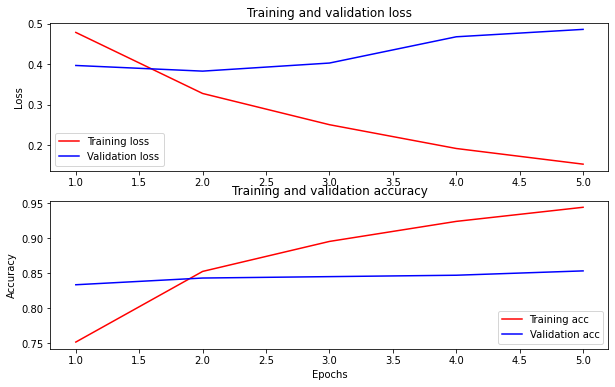

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2021-11-12 13:08:40.004947: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999205
input: The movie was great!           : score: 0.989532
input: The movie was meh.             : score: 0.913229
input: The movie was okish.           : score: 0.071168
input: The movie was terrible...      : score: 0.000734

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999205
input: The movie was great!           : score: 0.989532
input: The movie was meh.             : score: 0.913229
input: The movie was okish.           : score: 0.071168
input: The movie was terrible...      : score: 0.000734



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999205
input: The movie was great!           : score: 0.989532
input: The movie was meh.             : score: 0.913229
input: The movie was okish.           : score: 0.071168
input: The movie was terrible...      : score: 0.000734



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.